In [1]:
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')

In [2]:
trainy = pd.read_csv("./pretrained_100/trainy_pre.csv")
valy = pd.read_csv("./pretrained_100/valy_pre.csv")
#labels to categorical matrix
le = preprocessing.LabelEncoder()
le.fit(trainy['celltype_l2'])
classes = len(np.unique(trainy['celltype_l2']))
with open("./pretrained_100/label_encoder_pre.obj","wb") as f:
   pickle.dump(le, f)

y_train = pd.DataFrame(le.transform(trainy['celltype_l2']))
y_val = pd.DataFrame(le.transform(valy['celltype_l2']))
np.save('./pretrained_100/train_pre_label.npy', y_train)
np.save('./pretrained_100/val_pre_label.npy', y_val)

In [3]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = torch.nn.functional.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * torch.nn.functional.nll_loss(log_preds, target, reduction=self.reduction)


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./pretrained_100/checkpoint_model_pre.pth'):
        self.patience = patience    
        self.verbose = verbose      
        self.counter = 0            
        self.best_score = None      
        self.early_stop = False     
        self.val_acc_max = 0   
        self.path = path             
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None: 
            self.best_score = score 
            self.checkpoint(val_acc, model)
        elif score < self.best_score: 
            self.counter += 1 
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_acc, model)
            self.counter = 0  
    def checkpoint(self, val_acc, model):
        if self.verbose:  
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  
        self.val_acc_max = val_acc  

In [5]:
class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = np.load(img)
        self.label = torch.tensor(np.load(label))
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :] 
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        label = self.label[index]
        label = np.squeeze(label)
        return img,label
    def __len__(self):
        return self.img.shape[0]

In [6]:
def train_net(pre_epoch, EPOCH, early_patience, training_loader, validation_loader, net, optimizer, scheduler, criteria, device):
    with open("./pretrained_100/acc.txt", "w") as f:
        with open("./pretrained_100/log.txt", "w")as f2:
            start = time.time()
            earlystopping = EarlyStopping(patience=early_patience, verbose=True)
            losses_train = []
            accs_train = []
            losses_val = []
            accs_val = []
            best_acc = 0
            total_poches = 0
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                since = time.time()
                net.train()
                sum_loss = 0.0
                correct = 0
                total = 0
                for i, data in enumerate(training_loader):
                    length = len(training_loader)
                    input, target = data
                    input, target = input.to(device), target.to(device)
                    optimizer.zero_grad()
                    # forward + backward
                    output = net(input)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += predicted.eq(target.data).cpu().sum()
                    loss_train = sum_loss / (i + 1)
                    acc_train = 100. * float(correct) / float(total)
                    print('[epoch:%d, iter:%d] Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('%03d  %05d |Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('\n')
                    f2.flush()
                acc_train = 100. * float(correct) / float(total)
                accs_train.append(acc_train)
                losses_train.append(loss_train)
                print("Waiting Test!")
                with torch.no_grad():
                    sum_loss_val = 0
                    correct = 0
                    total = 0
                    loss_val = 0
                    for i, data in enumerate(validation_loader):
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criteria(outputs, labels)
                        sum_loss_val += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += predicted.eq(labels.data).cpu().sum()
                        loss_val = sum_loss_val / (i + 1)
                    acc_val = 100. * float(correct) / float(total)
                    losses_val.append(loss_val)
                    accs_val.append(acc_val)
                    print("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    scheduler.step(acc_val)
                    if acc_val > best_acc:
                        f3 = open("./pretrained_100/best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc_val))
                        f3.close()
                        best_acc = acc_val
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    earlystopping(acc_val, net)
                    if earlystopping.early_stop: 
                        print("Early Stopping!")
                        total_poches = epoch + 1
                        break
            print("Training Finished, TotalEPOCH=%d" % total_poches)
            time_total = time.time() - start
            print('The whole training process complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    return losses_train, accs_train, losses_val, accs_val

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
batch_size = 128
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
net._fc.out_features = classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

Loaded pretrained weights for efficientnet-b3


'Quadro RTX 8000'

In [8]:
net.to(device)
net = net.to(device)

In [9]:
train = MyDataset("./pretrained_100/train_pre.npy", "./pretrained_100/train_pre_label.npy")
training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = MyDataset("./pretrained_100/val_pre.npy", "./pretrained_100/val_pre_label.npy")
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:
LR = 3e-4 
# optimizer
params_to_update = net.parameters()
optimizer = optim.NAdam(params_to_update, lr=LR, betas=(0.9, 0.999), eps=1e-9)
# scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
criteria = LabelSmoothingCrossEntropy(0.1)

In [11]:
start = timer()

In [12]:
losses_train, accs_train, losses_val, accs_val = train_net(pre_epoch=0,
                                                           EPOCH = 50,
                                                           early_patience = 20,
                                                           training_loader=training_loader,
                                                           validation_loader = validation_loader,
                                                           net=net,
                                                           optimizer=optimizer,
                                                           scheduler=scheduler,
                                                           criteria=criteria,
                                                           device=device
                                                        )


Epoch: 1
[epoch:1, iter:1] Loss: 3.457 | Accuracy: 1.562% 
[epoch:1, iter:2] Loss: 3.365 | Accuracy: 11.328% 
[epoch:1, iter:3] Loss: 3.287 | Accuracy: 19.271% 
[epoch:1, iter:4] Loss: 3.221 | Accuracy: 24.023% 
[epoch:1, iter:5] Loss: 3.150 | Accuracy: 27.344% 
[epoch:1, iter:6] Loss: 3.101 | Accuracy: 27.604% 
[epoch:1, iter:7] Loss: 3.020 | Accuracy: 30.804% 
[epoch:1, iter:8] Loss: 2.950 | Accuracy: 33.301% 
[epoch:1, iter:9] Loss: 2.885 | Accuracy: 34.722% 
[epoch:1, iter:10] Loss: 2.825 | Accuracy: 35.938% 
[epoch:1, iter:11] Loss: 2.764 | Accuracy: 37.571% 
[epoch:1, iter:12] Loss: 2.704 | Accuracy: 38.802% 
[epoch:1, iter:13] Loss: 2.642 | Accuracy: 40.024% 
[epoch:1, iter:14] Loss: 2.585 | Accuracy: 41.518% 
[epoch:1, iter:15] Loss: 2.536 | Accuracy: 42.708% 
[epoch:1, iter:16] Loss: 2.495 | Accuracy: 43.701% 
[epoch:1, iter:17] Loss: 2.452 | Accuracy: 44.577% 
[epoch:1, iter:18] Loss: 2.414 | Accuracy: 45.443% 
[epoch:1, iter:19] Loss: 2.385 | Accuracy: 46.053% 
[epoch:1, it

[epoch:1, iter:158] Loss: 1.272 | Accuracy: 78.229% 
[epoch:1, iter:159] Loss: 1.271 | Accuracy: 78.312% 
[epoch:1, iter:160] Loss: 1.268 | Accuracy: 78.379% 
[epoch:1, iter:161] Loss: 1.266 | Accuracy: 78.450% 
[epoch:1, iter:162] Loss: 1.264 | Accuracy: 78.525% 
[epoch:1, iter:163] Loss: 1.262 | Accuracy: 78.585% 
[epoch:1, iter:164] Loss: 1.260 | Accuracy: 78.678% 
[epoch:1, iter:165] Loss: 1.258 | Accuracy: 78.745% 
[epoch:1, iter:166] Loss: 1.257 | Accuracy: 78.793% 
[epoch:1, iter:167] Loss: 1.255 | Accuracy: 78.850% 
[epoch:1, iter:168] Loss: 1.254 | Accuracy: 78.892% 
[epoch:1, iter:169] Loss: 1.252 | Accuracy: 78.920% 
[epoch:1, iter:170] Loss: 1.250 | Accuracy: 78.971% 
[epoch:1, iter:171] Loss: 1.248 | Accuracy: 79.043% 
[epoch:1, iter:172] Loss: 1.246 | Accuracy: 79.129% 
[epoch:1, iter:173] Loss: 1.244 | Accuracy: 79.182% 
[epoch:1, iter:174] Loss: 1.242 | Accuracy: 79.252% 
[epoch:1, iter:175] Loss: 1.241 | Accuracy: 79.312% 
[epoch:1, iter:176] Loss: 1.239 | Accuracy: 79

[epoch:1, iter:313] Loss: 1.105 | Accuracy: 83.828% 
[epoch:1, iter:314] Loss: 1.104 | Accuracy: 83.860% 
[epoch:1, iter:315] Loss: 1.103 | Accuracy: 83.886% 
[epoch:1, iter:316] Loss: 1.103 | Accuracy: 83.885% 
[epoch:1, iter:317] Loss: 1.102 | Accuracy: 83.907% 
[epoch:1, iter:318] Loss: 1.102 | Accuracy: 83.920% 
[epoch:1, iter:319] Loss: 1.101 | Accuracy: 83.942% 
[epoch:1, iter:320] Loss: 1.101 | Accuracy: 83.950% 
[epoch:1, iter:321] Loss: 1.100 | Accuracy: 83.966% 
[epoch:1, iter:322] Loss: 1.100 | Accuracy: 83.967% 
[epoch:1, iter:323] Loss: 1.099 | Accuracy: 83.998% 
[epoch:1, iter:324] Loss: 1.099 | Accuracy: 84.016% 
[epoch:1, iter:325] Loss: 1.098 | Accuracy: 84.043% 
[epoch:1, iter:326] Loss: 1.097 | Accuracy: 84.073% 
[epoch:1, iter:327] Loss: 1.096 | Accuracy: 84.103% 
[epoch:1, iter:328] Loss: 1.096 | Accuracy: 84.123% 
[epoch:1, iter:329] Loss: 1.095 | Accuracy: 84.145% 
[epoch:1, iter:330] Loss: 1.095 | Accuracy: 84.162% 
[epoch:1, iter:331] Loss: 1.094 | Accuracy: 84

[epoch:1, iter:468] Loss: 1.035 | Accuracy: 86.129% 
[epoch:1, iter:469] Loss: 1.035 | Accuracy: 86.137% 
[epoch:1, iter:470] Loss: 1.034 | Accuracy: 86.142% 
[epoch:1, iter:471] Loss: 1.034 | Accuracy: 86.150% 
[epoch:1, iter:472] Loss: 1.034 | Accuracy: 86.161% 
[epoch:1, iter:473] Loss: 1.034 | Accuracy: 86.159% 
[epoch:1, iter:474] Loss: 1.033 | Accuracy: 86.170% 
[epoch:1, iter:475] Loss: 1.033 | Accuracy: 86.171% 
[epoch:1, iter:476] Loss: 1.033 | Accuracy: 86.180% 
[epoch:1, iter:477] Loss: 1.033 | Accuracy: 86.185% 
[epoch:1, iter:478] Loss: 1.032 | Accuracy: 86.196% 
[epoch:1, iter:479] Loss: 1.032 | Accuracy: 86.212% 
[epoch:1, iter:480] Loss: 1.032 | Accuracy: 86.219% 
[epoch:1, iter:481] Loss: 1.031 | Accuracy: 86.233% 
[epoch:1, iter:482] Loss: 1.031 | Accuracy: 86.241% 
[epoch:1, iter:483] Loss: 1.031 | Accuracy: 86.251% 
[epoch:1, iter:484] Loss: 1.031 | Accuracy: 86.260% 
[epoch:1, iter:485] Loss: 1.030 | Accuracy: 86.268% 
[epoch:1, iter:486] Loss: 1.030 | Accuracy: 86

[epoch:1, iter:623] Loss: 0.996 | Accuracy: 87.422% 
[epoch:1, iter:624] Loss: 0.995 | Accuracy: 87.425% 
[epoch:1, iter:625] Loss: 0.995 | Accuracy: 87.441% 
[epoch:1, iter:626] Loss: 0.995 | Accuracy: 87.454% 
[epoch:1, iter:627] Loss: 0.994 | Accuracy: 87.464% 
[epoch:1, iter:628] Loss: 0.994 | Accuracy: 87.478% 
[epoch:1, iter:629] Loss: 0.994 | Accuracy: 87.489% 
[epoch:1, iter:630] Loss: 0.994 | Accuracy: 87.501% 
[epoch:1, iter:631] Loss: 0.993 | Accuracy: 87.504% 
[epoch:1, iter:632] Loss: 0.993 | Accuracy: 87.514% 
[epoch:1, iter:633] Loss: 0.993 | Accuracy: 87.520% 
[epoch:1, iter:634] Loss: 0.993 | Accuracy: 87.522% 
[epoch:1, iter:635] Loss: 0.993 | Accuracy: 87.526% 
[epoch:1, iter:636] Loss: 0.992 | Accuracy: 87.532% 
[epoch:1, iter:637] Loss: 0.992 | Accuracy: 87.534% 
[epoch:1, iter:638] Loss: 0.992 | Accuracy: 87.540% 
[epoch:1, iter:639] Loss: 0.992 | Accuracy: 87.539% 
[epoch:1, iter:640] Loss: 0.992 | Accuracy: 87.550% 
[epoch:1, iter:641] Loss: 0.992 | Accuracy: 87

[epoch:1, iter:778] Loss: 0.966 | Accuracy: 88.431% 
[epoch:1, iter:779] Loss: 0.966 | Accuracy: 88.437% 
[epoch:1, iter:780] Loss: 0.966 | Accuracy: 88.434% 
[epoch:1, iter:781] Loss: 0.966 | Accuracy: 88.441% 
[epoch:1, iter:782] Loss: 0.966 | Accuracy: 88.444% 
[epoch:1, iter:783] Loss: 0.966 | Accuracy: 88.446% 
[epoch:1, iter:784] Loss: 0.965 | Accuracy: 88.454% 
[epoch:1, iter:785] Loss: 0.965 | Accuracy: 88.456% 
[epoch:1, iter:786] Loss: 0.965 | Accuracy: 88.458% 
[epoch:1, iter:787] Loss: 0.965 | Accuracy: 88.463% 
[epoch:1, iter:788] Loss: 0.965 | Accuracy: 88.465% 
[epoch:1, iter:789] Loss: 0.965 | Accuracy: 88.466% 
[epoch:1, iter:790] Loss: 0.965 | Accuracy: 88.471% 
[epoch:1, iter:791] Loss: 0.965 | Accuracy: 88.479% 
[epoch:1, iter:792] Loss: 0.964 | Accuracy: 88.481% 
[epoch:1, iter:793] Loss: 0.964 | Accuracy: 88.487% 
[epoch:1, iter:794] Loss: 0.964 | Accuracy: 88.495% 
[epoch:1, iter:795] Loss: 0.964 | Accuracy: 88.502% 
[epoch:1, iter:796] Loss: 0.964 | Accuracy: 88

[epoch:1, iter:933] Loss: 0.946 | Accuracy: 89.129% 
[epoch:1, iter:934] Loss: 0.946 | Accuracy: 89.134% 
[epoch:1, iter:935] Loss: 0.945 | Accuracy: 89.135% 
[epoch:1, iter:936] Loss: 0.945 | Accuracy: 89.140% 
[epoch:1, iter:937] Loss: 0.945 | Accuracy: 89.146% 
[epoch:1, iter:938] Loss: 0.945 | Accuracy: 89.150% 
[epoch:1, iter:939] Loss: 0.945 | Accuracy: 89.151% 
[epoch:1, iter:940] Loss: 0.945 | Accuracy: 89.156% 
[epoch:1, iter:941] Loss: 0.945 | Accuracy: 89.160% 
[epoch:1, iter:942] Loss: 0.945 | Accuracy: 89.165% 
[epoch:1, iter:943] Loss: 0.944 | Accuracy: 89.168% 
[epoch:1, iter:944] Loss: 0.944 | Accuracy: 89.175% 
[epoch:1, iter:945] Loss: 0.944 | Accuracy: 89.182% 
[epoch:1, iter:946] Loss: 0.944 | Accuracy: 89.186% 
[epoch:1, iter:947] Loss: 0.944 | Accuracy: 89.193% 
[epoch:1, iter:948] Loss: 0.944 | Accuracy: 89.199% 
[epoch:1, iter:949] Loss: 0.944 | Accuracy: 89.203% 
[epoch:1, iter:950] Loss: 0.943 | Accuracy: 89.210% 
[epoch:1, iter:951] Loss: 0.943 | Accuracy: 89

[epoch:1, iter:1086] Loss: 0.930 | Accuracy: 89.674% 
[epoch:1, iter:1087] Loss: 0.930 | Accuracy: 89.676% 
[epoch:1, iter:1088] Loss: 0.929 | Accuracy: 89.681% 
[epoch:1, iter:1089] Loss: 0.929 | Accuracy: 89.686% 
[epoch:1, iter:1090] Loss: 0.929 | Accuracy: 89.687% 
[epoch:1, iter:1091] Loss: 0.929 | Accuracy: 89.687% 
[epoch:1, iter:1092] Loss: 0.929 | Accuracy: 89.689% 
[epoch:1, iter:1093] Loss: 0.929 | Accuracy: 89.691% 
[epoch:1, iter:1094] Loss: 0.929 | Accuracy: 89.694% 
[epoch:1, iter:1095] Loss: 0.929 | Accuracy: 89.702% 
[epoch:1, iter:1096] Loss: 0.929 | Accuracy: 89.706% 
[epoch:1, iter:1097] Loss: 0.929 | Accuracy: 89.711% 
[epoch:1, iter:1098] Loss: 0.929 | Accuracy: 89.713% 
[epoch:1, iter:1099] Loss: 0.929 | Accuracy: 89.714% 
[epoch:1, iter:1100] Loss: 0.928 | Accuracy: 89.720% 
[epoch:1, iter:1101] Loss: 0.928 | Accuracy: 89.727% 
[epoch:1, iter:1102] Loss: 0.928 | Accuracy: 89.727% 
[epoch:1, iter:1103] Loss: 0.928 | Accuracy: 89.728% 
[epoch:1, iter:1104] Loss: 0

[epoch:2, iter:1235] Loss: 0.809 | Accuracy: 93.884% 
[epoch:2, iter:1236] Loss: 0.809 | Accuracy: 93.875% 
[epoch:2, iter:1237] Loss: 0.810 | Accuracy: 93.851% 
[epoch:2, iter:1238] Loss: 0.810 | Accuracy: 93.842% 
[epoch:2, iter:1239] Loss: 0.809 | Accuracy: 93.849% 
[epoch:2, iter:1240] Loss: 0.809 | Accuracy: 93.840% 
[epoch:2, iter:1241] Loss: 0.809 | Accuracy: 93.824% 
[epoch:2, iter:1242] Loss: 0.809 | Accuracy: 93.838% 
[epoch:2, iter:1243] Loss: 0.810 | Accuracy: 93.838% 
[epoch:2, iter:1244] Loss: 0.810 | Accuracy: 93.830% 
[epoch:2, iter:1245] Loss: 0.811 | Accuracy: 93.793% 
[epoch:2, iter:1246] Loss: 0.811 | Accuracy: 93.786% 
[epoch:2, iter:1247] Loss: 0.811 | Accuracy: 93.778% 
[epoch:2, iter:1248] Loss: 0.811 | Accuracy: 93.785% 
[epoch:2, iter:1249] Loss: 0.812 | Accuracy: 93.785% 
[epoch:2, iter:1250] Loss: 0.811 | Accuracy: 93.812% 
[epoch:2, iter:1251] Loss: 0.811 | Accuracy: 93.811% 
[epoch:2, iter:1252] Loss: 0.811 | Accuracy: 93.817% 
[epoch:2, iter:1253] Loss: 0

[epoch:2, iter:1387] Loss: 0.810 | Accuracy: 93.756% 
[epoch:2, iter:1388] Loss: 0.810 | Accuracy: 93.750% 
[epoch:2, iter:1389] Loss: 0.810 | Accuracy: 93.753% 
[epoch:2, iter:1390] Loss: 0.811 | Accuracy: 93.747% 
[epoch:2, iter:1391] Loss: 0.811 | Accuracy: 93.744% 
[epoch:2, iter:1392] Loss: 0.811 | Accuracy: 93.732% 
[epoch:2, iter:1393] Loss: 0.811 | Accuracy: 93.732% 
[epoch:2, iter:1394] Loss: 0.811 | Accuracy: 93.729% 
[epoch:2, iter:1395] Loss: 0.811 | Accuracy: 93.723% 
[epoch:2, iter:1396] Loss: 0.811 | Accuracy: 93.717% 
[epoch:2, iter:1397] Loss: 0.811 | Accuracy: 93.717% 
[epoch:2, iter:1398] Loss: 0.811 | Accuracy: 93.711% 
[epoch:2, iter:1399] Loss: 0.811 | Accuracy: 93.711% 
[epoch:2, iter:1400] Loss: 0.811 | Accuracy: 93.714% 
[epoch:2, iter:1401] Loss: 0.811 | Accuracy: 93.723% 
[epoch:2, iter:1402] Loss: 0.811 | Accuracy: 93.729% 
[epoch:2, iter:1403] Loss: 0.811 | Accuracy: 93.715% 
[epoch:2, iter:1404] Loss: 0.811 | Accuracy: 93.715% 
[epoch:2, iter:1405] Loss: 0

[epoch:2, iter:1539] Loss: 0.810 | Accuracy: 93.868% 
[epoch:2, iter:1540] Loss: 0.810 | Accuracy: 93.874% 
[epoch:2, iter:1541] Loss: 0.810 | Accuracy: 93.870% 
[epoch:2, iter:1542] Loss: 0.810 | Accuracy: 93.871% 
[epoch:2, iter:1543] Loss: 0.810 | Accuracy: 93.873% 
[epoch:2, iter:1544] Loss: 0.810 | Accuracy: 93.878% 
[epoch:2, iter:1545] Loss: 0.810 | Accuracy: 93.880% 
[epoch:2, iter:1546] Loss: 0.810 | Accuracy: 93.883% 
[epoch:2, iter:1547] Loss: 0.810 | Accuracy: 93.887% 
[epoch:2, iter:1548] Loss: 0.809 | Accuracy: 93.883% 
[epoch:2, iter:1549] Loss: 0.809 | Accuracy: 93.888% 
[epoch:2, iter:1550] Loss: 0.809 | Accuracy: 93.890% 
[epoch:2, iter:1551] Loss: 0.809 | Accuracy: 93.887% 
[epoch:2, iter:1552] Loss: 0.809 | Accuracy: 93.891% 
[epoch:2, iter:1553] Loss: 0.809 | Accuracy: 93.887% 
[epoch:2, iter:1554] Loss: 0.809 | Accuracy: 93.881% 
[epoch:2, iter:1555] Loss: 0.810 | Accuracy: 93.873% 
[epoch:2, iter:1556] Loss: 0.809 | Accuracy: 93.875% 
[epoch:2, iter:1557] Loss: 0

[epoch:2, iter:1691] Loss: 0.809 | Accuracy: 93.882% 
[epoch:2, iter:1692] Loss: 0.809 | Accuracy: 93.883% 
[epoch:2, iter:1693] Loss: 0.809 | Accuracy: 93.889% 
[epoch:2, iter:1694] Loss: 0.809 | Accuracy: 93.889% 
[epoch:2, iter:1695] Loss: 0.809 | Accuracy: 93.880% 
[epoch:2, iter:1696] Loss: 0.809 | Accuracy: 93.883% 
[epoch:2, iter:1697] Loss: 0.809 | Accuracy: 93.882% 
[epoch:2, iter:1698] Loss: 0.809 | Accuracy: 93.881% 
[epoch:2, iter:1699] Loss: 0.809 | Accuracy: 93.880% 
[epoch:2, iter:1700] Loss: 0.809 | Accuracy: 93.880% 
[epoch:2, iter:1701] Loss: 0.809 | Accuracy: 93.874% 
[epoch:2, iter:1702] Loss: 0.809 | Accuracy: 93.883% 
[epoch:2, iter:1703] Loss: 0.809 | Accuracy: 93.882% 
[epoch:2, iter:1704] Loss: 0.809 | Accuracy: 93.885% 
[epoch:2, iter:1705] Loss: 0.809 | Accuracy: 93.887% 
[epoch:2, iter:1706] Loss: 0.809 | Accuracy: 93.895% 
[epoch:2, iter:1707] Loss: 0.808 | Accuracy: 93.898% 
[epoch:2, iter:1708] Loss: 0.808 | Accuracy: 93.900% 
[epoch:2, iter:1709] Loss: 0

[epoch:2, iter:1843] Loss: 0.809 | Accuracy: 93.861% 
[epoch:2, iter:1844] Loss: 0.809 | Accuracy: 93.864% 
[epoch:2, iter:1845] Loss: 0.809 | Accuracy: 93.863% 
[epoch:2, iter:1846] Loss: 0.809 | Accuracy: 93.870% 
[epoch:2, iter:1847] Loss: 0.809 | Accuracy: 93.875% 
[epoch:2, iter:1848] Loss: 0.809 | Accuracy: 93.881% 
[epoch:2, iter:1849] Loss: 0.809 | Accuracy: 93.881% 
[epoch:2, iter:1850] Loss: 0.809 | Accuracy: 93.881% 
[epoch:2, iter:1851] Loss: 0.809 | Accuracy: 93.884% 
[epoch:2, iter:1852] Loss: 0.809 | Accuracy: 93.885% 
[epoch:2, iter:1853] Loss: 0.809 | Accuracy: 93.887% 
[epoch:2, iter:1854] Loss: 0.809 | Accuracy: 93.887% 
[epoch:2, iter:1855] Loss: 0.809 | Accuracy: 93.889% 
[epoch:2, iter:1856] Loss: 0.809 | Accuracy: 93.889% 
[epoch:2, iter:1857] Loss: 0.809 | Accuracy: 93.891% 
[epoch:2, iter:1858] Loss: 0.809 | Accuracy: 93.892% 
[epoch:2, iter:1859] Loss: 0.808 | Accuracy: 93.896% 
[epoch:2, iter:1860] Loss: 0.809 | Accuracy: 93.895% 
[epoch:2, iter:1861] Loss: 0

[epoch:2, iter:1995] Loss: 0.807 | Accuracy: 93.899% 
[epoch:2, iter:1996] Loss: 0.807 | Accuracy: 93.901% 
[epoch:2, iter:1997] Loss: 0.807 | Accuracy: 93.902% 
[epoch:2, iter:1998] Loss: 0.807 | Accuracy: 93.905% 
[epoch:2, iter:1999] Loss: 0.807 | Accuracy: 93.903% 
[epoch:2, iter:2000] Loss: 0.807 | Accuracy: 93.905% 
[epoch:2, iter:2001] Loss: 0.807 | Accuracy: 93.904% 
[epoch:2, iter:2002] Loss: 0.807 | Accuracy: 93.906% 
[epoch:2, iter:2003] Loss: 0.807 | Accuracy: 93.906% 
[epoch:2, iter:2004] Loss: 0.807 | Accuracy: 93.903% 
[epoch:2, iter:2005] Loss: 0.807 | Accuracy: 93.902% 
[epoch:2, iter:2006] Loss: 0.807 | Accuracy: 93.905% 
[epoch:2, iter:2007] Loss: 0.807 | Accuracy: 93.904% 
[epoch:2, iter:2008] Loss: 0.807 | Accuracy: 93.901% 
[epoch:2, iter:2009] Loss: 0.807 | Accuracy: 93.906% 
[epoch:2, iter:2010] Loss: 0.807 | Accuracy: 93.906% 
[epoch:2, iter:2011] Loss: 0.807 | Accuracy: 93.907% 
[epoch:2, iter:2012] Loss: 0.807 | Accuracy: 93.904% 
[epoch:2, iter:2013] Loss: 0

[epoch:2, iter:2147] Loss: 0.806 | Accuracy: 93.952% 
[epoch:2, iter:2148] Loss: 0.806 | Accuracy: 93.953% 
[epoch:2, iter:2149] Loss: 0.806 | Accuracy: 93.952% 
[epoch:2, iter:2150] Loss: 0.806 | Accuracy: 93.952% 
[epoch:2, iter:2151] Loss: 0.806 | Accuracy: 93.954% 
[epoch:2, iter:2152] Loss: 0.806 | Accuracy: 93.951% 
[epoch:2, iter:2153] Loss: 0.806 | Accuracy: 93.953% 
[epoch:2, iter:2154] Loss: 0.806 | Accuracy: 93.950% 
[epoch:2, iter:2155] Loss: 0.806 | Accuracy: 93.952% 
[epoch:2, iter:2156] Loss: 0.806 | Accuracy: 93.951% 
[epoch:2, iter:2157] Loss: 0.806 | Accuracy: 93.954% 
[epoch:2, iter:2158] Loss: 0.806 | Accuracy: 93.953% 
[epoch:2, iter:2159] Loss: 0.806 | Accuracy: 93.955% 
[epoch:2, iter:2160] Loss: 0.806 | Accuracy: 93.960% 
[epoch:2, iter:2161] Loss: 0.806 | Accuracy: 93.957% 
[epoch:2, iter:2162] Loss: 0.806 | Accuracy: 93.956% 
[epoch:2, iter:2163] Loss: 0.806 | Accuracy: 93.958% 
[epoch:2, iter:2164] Loss: 0.806 | Accuracy: 93.958% 
[epoch:2, iter:2165] Loss: 0

[epoch:3, iter:2296] Loss: 0.800 | Accuracy: 94.108% 
[epoch:3, iter:2297] Loss: 0.801 | Accuracy: 94.125% 
[epoch:3, iter:2298] Loss: 0.801 | Accuracy: 94.141% 
[epoch:3, iter:2299] Loss: 0.802 | Accuracy: 94.097% 
[epoch:3, iter:2300] Loss: 0.801 | Accuracy: 94.141% 
[epoch:3, iter:2301] Loss: 0.799 | Accuracy: 94.208% 
[epoch:3, iter:2302] Loss: 0.804 | Accuracy: 94.010% 
[epoch:3, iter:2303] Loss: 0.802 | Accuracy: 94.128% 
[epoch:3, iter:2304] Loss: 0.802 | Accuracy: 94.116% 
[epoch:3, iter:2305] Loss: 0.803 | Accuracy: 94.058% 
[epoch:3, iter:2306] Loss: 0.803 | Accuracy: 94.072% 
[epoch:3, iter:2307] Loss: 0.802 | Accuracy: 94.174% 
[epoch:3, iter:2308] Loss: 0.800 | Accuracy: 94.271% 
[epoch:3, iter:2309] Loss: 0.801 | Accuracy: 94.299% 
[epoch:3, iter:2310] Loss: 0.800 | Accuracy: 94.285% 
[epoch:3, iter:2311] Loss: 0.799 | Accuracy: 94.351% 
[epoch:3, iter:2312] Loss: 0.798 | Accuracy: 94.355% 
[epoch:3, iter:2313] Loss: 0.798 | Accuracy: 94.264% 
[epoch:3, iter:2314] Loss: 0

[epoch:3, iter:2448] Loss: 0.787 | Accuracy: 94.762% 
[epoch:3, iter:2449] Loss: 0.787 | Accuracy: 94.770% 
[epoch:3, iter:2450] Loss: 0.787 | Accuracy: 94.764% 
[epoch:3, iter:2451] Loss: 0.787 | Accuracy: 94.767% 
[epoch:3, iter:2452] Loss: 0.787 | Accuracy: 94.757% 
[epoch:3, iter:2453] Loss: 0.787 | Accuracy: 94.773% 
[epoch:3, iter:2454] Loss: 0.788 | Accuracy: 94.750% 
[epoch:3, iter:2455] Loss: 0.788 | Accuracy: 94.728% 
[epoch:3, iter:2456] Loss: 0.788 | Accuracy: 94.727% 
[epoch:3, iter:2457] Loss: 0.788 | Accuracy: 94.713% 
[epoch:3, iter:2458] Loss: 0.788 | Accuracy: 94.708% 
[epoch:3, iter:2459] Loss: 0.789 | Accuracy: 94.694% 
[epoch:3, iter:2460] Loss: 0.789 | Accuracy: 94.685% 
[epoch:3, iter:2461] Loss: 0.788 | Accuracy: 94.692% 
[epoch:3, iter:2462] Loss: 0.788 | Accuracy: 94.712% 
[epoch:3, iter:2463] Loss: 0.788 | Accuracy: 94.707% 
[epoch:3, iter:2464] Loss: 0.788 | Accuracy: 94.710% 
[epoch:3, iter:2465] Loss: 0.788 | Accuracy: 94.709% 
[epoch:3, iter:2466] Loss: 0

[epoch:3, iter:2600] Loss: 0.785 | Accuracy: 94.846% 
[epoch:3, iter:2601] Loss: 0.785 | Accuracy: 94.849% 
[epoch:3, iter:2602] Loss: 0.785 | Accuracy: 94.856% 
[epoch:3, iter:2603] Loss: 0.785 | Accuracy: 94.848% 
[epoch:3, iter:2604] Loss: 0.785 | Accuracy: 94.856% 
[epoch:3, iter:2605] Loss: 0.785 | Accuracy: 94.850% 
[epoch:3, iter:2606] Loss: 0.785 | Accuracy: 94.852% 
[epoch:3, iter:2607] Loss: 0.785 | Accuracy: 94.855% 
[epoch:3, iter:2608] Loss: 0.785 | Accuracy: 94.852% 
[epoch:3, iter:2609] Loss: 0.784 | Accuracy: 94.860% 
[epoch:3, iter:2610] Loss: 0.784 | Accuracy: 94.864% 
[epoch:3, iter:2611] Loss: 0.784 | Accuracy: 94.858% 
[epoch:3, iter:2612] Loss: 0.784 | Accuracy: 94.858% 
[epoch:3, iter:2613] Loss: 0.785 | Accuracy: 94.854% 
[epoch:3, iter:2614] Loss: 0.785 | Accuracy: 94.849% 
[epoch:3, iter:2615] Loss: 0.785 | Accuracy: 94.850% 
[epoch:3, iter:2616] Loss: 0.785 | Accuracy: 94.842% 
[epoch:3, iter:2617] Loss: 0.785 | Accuracy: 94.844% 
[epoch:3, iter:2618] Loss: 0

[epoch:3, iter:2752] Loss: 0.785 | Accuracy: 94.800% 
[epoch:3, iter:2753] Loss: 0.785 | Accuracy: 94.801% 
[epoch:3, iter:2754] Loss: 0.786 | Accuracy: 94.797% 
[epoch:3, iter:2755] Loss: 0.785 | Accuracy: 94.800% 
[epoch:3, iter:2756] Loss: 0.785 | Accuracy: 94.798% 
[epoch:3, iter:2757] Loss: 0.786 | Accuracy: 94.794% 
[epoch:3, iter:2758] Loss: 0.786 | Accuracy: 94.790% 
[epoch:3, iter:2759] Loss: 0.786 | Accuracy: 94.793% 
[epoch:3, iter:2760] Loss: 0.786 | Accuracy: 94.789% 
[epoch:3, iter:2761] Loss: 0.786 | Accuracy: 94.792% 
[epoch:3, iter:2762] Loss: 0.786 | Accuracy: 94.782% 
[epoch:3, iter:2763] Loss: 0.786 | Accuracy: 94.786% 
[epoch:3, iter:2764] Loss: 0.786 | Accuracy: 94.785% 
[epoch:3, iter:2765] Loss: 0.786 | Accuracy: 94.782% 
[epoch:3, iter:2766] Loss: 0.786 | Accuracy: 94.778% 
[epoch:3, iter:2767] Loss: 0.786 | Accuracy: 94.777% 
[epoch:3, iter:2768] Loss: 0.786 | Accuracy: 94.782% 
[epoch:3, iter:2769] Loss: 0.786 | Accuracy: 94.784% 
[epoch:3, iter:2770] Loss: 0

[epoch:3, iter:2904] Loss: 0.784 | Accuracy: 94.832% 
[epoch:3, iter:2905] Loss: 0.784 | Accuracy: 94.830% 
[epoch:3, iter:2906] Loss: 0.784 | Accuracy: 94.826% 
[epoch:3, iter:2907] Loss: 0.784 | Accuracy: 94.825% 
[epoch:3, iter:2908] Loss: 0.784 | Accuracy: 94.827% 
[epoch:3, iter:2909] Loss: 0.784 | Accuracy: 94.823% 
[epoch:3, iter:2910] Loss: 0.784 | Accuracy: 94.825% 
[epoch:3, iter:2911] Loss: 0.784 | Accuracy: 94.828% 
[epoch:3, iter:2912] Loss: 0.784 | Accuracy: 94.824% 
[epoch:3, iter:2913] Loss: 0.784 | Accuracy: 94.824% 
[epoch:3, iter:2914] Loss: 0.784 | Accuracy: 94.821% 
[epoch:3, iter:2915] Loss: 0.784 | Accuracy: 94.824% 
[epoch:3, iter:2916] Loss: 0.784 | Accuracy: 94.820% 
[epoch:3, iter:2917] Loss: 0.784 | Accuracy: 94.815% 
[epoch:3, iter:2918] Loss: 0.784 | Accuracy: 94.814% 
[epoch:3, iter:2919] Loss: 0.784 | Accuracy: 94.807% 
[epoch:3, iter:2920] Loss: 0.784 | Accuracy: 94.809% 
[epoch:3, iter:2921] Loss: 0.784 | Accuracy: 94.805% 
[epoch:3, iter:2922] Loss: 0

[epoch:3, iter:3056] Loss: 0.784 | Accuracy: 94.793% 
[epoch:3, iter:3057] Loss: 0.784 | Accuracy: 94.794% 
[epoch:3, iter:3058] Loss: 0.784 | Accuracy: 94.799% 
[epoch:3, iter:3059] Loss: 0.784 | Accuracy: 94.798% 
[epoch:3, iter:3060] Loss: 0.784 | Accuracy: 94.800% 
[epoch:3, iter:3061] Loss: 0.784 | Accuracy: 94.804% 
[epoch:3, iter:3062] Loss: 0.784 | Accuracy: 94.803% 
[epoch:3, iter:3063] Loss: 0.784 | Accuracy: 94.806% 
[epoch:3, iter:3064] Loss: 0.784 | Accuracy: 94.805% 
[epoch:3, iter:3065] Loss: 0.784 | Accuracy: 94.806% 
[epoch:3, iter:3066] Loss: 0.784 | Accuracy: 94.808% 
[epoch:3, iter:3067] Loss: 0.784 | Accuracy: 94.806% 
[epoch:3, iter:3068] Loss: 0.784 | Accuracy: 94.806% 
[epoch:3, iter:3069] Loss: 0.784 | Accuracy: 94.809% 
[epoch:3, iter:3070] Loss: 0.784 | Accuracy: 94.810% 
[epoch:3, iter:3071] Loss: 0.784 | Accuracy: 94.812% 
[epoch:3, iter:3072] Loss: 0.784 | Accuracy: 94.814% 
[epoch:3, iter:3073] Loss: 0.784 | Accuracy: 94.815% 
[epoch:3, iter:3074] Loss: 0

[epoch:3, iter:3208] Loss: 0.784 | Accuracy: 94.838% 
[epoch:3, iter:3209] Loss: 0.784 | Accuracy: 94.839% 
[epoch:3, iter:3210] Loss: 0.784 | Accuracy: 94.835% 
[epoch:3, iter:3211] Loss: 0.784 | Accuracy: 94.834% 
[epoch:3, iter:3212] Loss: 0.784 | Accuracy: 94.835% 
[epoch:3, iter:3213] Loss: 0.784 | Accuracy: 94.835% 
[epoch:3, iter:3214] Loss: 0.784 | Accuracy: 94.836% 
[epoch:3, iter:3215] Loss: 0.784 | Accuracy: 94.836% 
[epoch:3, iter:3216] Loss: 0.784 | Accuracy: 94.838% 
[epoch:3, iter:3217] Loss: 0.784 | Accuracy: 94.840% 
[epoch:3, iter:3218] Loss: 0.784 | Accuracy: 94.842% 
[epoch:3, iter:3219] Loss: 0.783 | Accuracy: 94.846% 
[epoch:3, iter:3220] Loss: 0.783 | Accuracy: 94.844% 
[epoch:3, iter:3221] Loss: 0.783 | Accuracy: 94.845% 
[epoch:3, iter:3222] Loss: 0.784 | Accuracy: 94.846% 
[epoch:3, iter:3223] Loss: 0.783 | Accuracy: 94.849% 
[epoch:3, iter:3224] Loss: 0.784 | Accuracy: 94.846% 
[epoch:3, iter:3225] Loss: 0.784 | Accuracy: 94.844% 
[epoch:3, iter:3226] Loss: 0

[epoch:3, iter:3360] Loss: 0.784 | Accuracy: 94.840% 
[epoch:3, iter:3361] Loss: 0.784 | Accuracy: 94.840% 
[epoch:3, iter:3362] Loss: 0.784 | Accuracy: 94.836% 
[epoch:3, iter:3363] Loss: 0.784 | Accuracy: 94.834% 
[epoch:3, iter:3364] Loss: 0.784 | Accuracy: 94.836% 
[epoch:3, iter:3365] Loss: 0.784 | Accuracy: 94.836% 
[epoch:3, iter:3366] Loss: 0.784 | Accuracy: 94.839% 
[epoch:3, iter:3367] Loss: 0.784 | Accuracy: 94.839% 
[epoch:3, iter:3368] Loss: 0.784 | Accuracy: 94.839% 
[epoch:3, iter:3369] Loss: 0.784 | Accuracy: 94.840% 
[epoch:3, iter:3370] Loss: 0.784 | Accuracy: 94.841% 
[epoch:3, iter:3371] Loss: 0.784 | Accuracy: 94.842% 
[epoch:3, iter:3372] Loss: 0.784 | Accuracy: 94.842% 
[epoch:3, iter:3373] Loss: 0.784 | Accuracy: 94.842% 
[epoch:3, iter:3374] Loss: 0.784 | Accuracy: 94.843% 
[epoch:3, iter:3375] Loss: 0.783 | Accuracy: 94.844% 
[epoch:3, iter:3376] Loss: 0.783 | Accuracy: 94.845% 
[epoch:3, iter:3377] Loss: 0.783 | Accuracy: 94.842% 
[epoch:3, iter:3378] Loss: 0

[epoch:4, iter:3510] Loss: 0.764 | Accuracy: 95.596% 
[epoch:4, iter:3511] Loss: 0.764 | Accuracy: 95.586% 
[epoch:4, iter:3512] Loss: 0.764 | Accuracy: 95.590% 
[epoch:4, iter:3513] Loss: 0.763 | Accuracy: 95.603% 
[epoch:4, iter:3514] Loss: 0.763 | Accuracy: 95.615% 
[epoch:4, iter:3515] Loss: 0.763 | Accuracy: 95.619% 
[epoch:4, iter:3516] Loss: 0.764 | Accuracy: 95.595% 
[epoch:4, iter:3517] Loss: 0.764 | Accuracy: 95.606% 
[epoch:4, iter:3518] Loss: 0.764 | Accuracy: 95.604% 
[epoch:4, iter:3519] Loss: 0.763 | Accuracy: 95.629% 
[epoch:4, iter:3520] Loss: 0.764 | Accuracy: 95.619% 
[epoch:4, iter:3521] Loss: 0.763 | Accuracy: 95.637% 
[epoch:4, iter:3522] Loss: 0.763 | Accuracy: 95.655% 
[epoch:4, iter:3523] Loss: 0.763 | Accuracy: 95.639% 
[epoch:4, iter:3524] Loss: 0.764 | Accuracy: 95.622% 
[epoch:4, iter:3525] Loss: 0.764 | Accuracy: 95.640% 
[epoch:4, iter:3526] Loss: 0.764 | Accuracy: 95.617% 
[epoch:4, iter:3527] Loss: 0.764 | Accuracy: 95.614% 
[epoch:4, iter:3528] Loss: 0

[epoch:4, iter:3662] Loss: 0.763 | Accuracy: 95.666% 
[epoch:4, iter:3663] Loss: 0.763 | Accuracy: 95.674% 
[epoch:4, iter:3664] Loss: 0.763 | Accuracy: 95.663% 
[epoch:4, iter:3665] Loss: 0.763 | Accuracy: 95.665% 
[epoch:4, iter:3666] Loss: 0.763 | Accuracy: 95.670% 
[epoch:4, iter:3667] Loss: 0.763 | Accuracy: 95.665% 
[epoch:4, iter:3668] Loss: 0.763 | Accuracy: 95.664% 
[epoch:4, iter:3669] Loss: 0.763 | Accuracy: 95.669% 
[epoch:4, iter:3670] Loss: 0.763 | Accuracy: 95.667% 
[epoch:4, iter:3671] Loss: 0.763 | Accuracy: 95.669% 
[epoch:4, iter:3672] Loss: 0.763 | Accuracy: 95.674% 
[epoch:4, iter:3673] Loss: 0.763 | Accuracy: 95.678% 
[epoch:4, iter:3674] Loss: 0.763 | Accuracy: 95.688% 
[epoch:4, iter:3675] Loss: 0.763 | Accuracy: 95.696% 
[epoch:4, iter:3676] Loss: 0.763 | Accuracy: 95.689% 
[epoch:4, iter:3677] Loss: 0.763 | Accuracy: 95.676% 
[epoch:4, iter:3678] Loss: 0.763 | Accuracy: 95.677% 
[epoch:4, iter:3679] Loss: 0.764 | Accuracy: 95.667% 
[epoch:4, iter:3680] Loss: 0

[epoch:4, iter:3814] Loss: 0.766 | Accuracy: 95.547% 
[epoch:4, iter:3815] Loss: 0.766 | Accuracy: 95.533% 
[epoch:4, iter:3816] Loss: 0.766 | Accuracy: 95.538% 
[epoch:4, iter:3817] Loss: 0.766 | Accuracy: 95.542% 
[epoch:4, iter:3818] Loss: 0.766 | Accuracy: 95.545% 
[epoch:4, iter:3819] Loss: 0.766 | Accuracy: 95.529% 
[epoch:4, iter:3820] Loss: 0.766 | Accuracy: 95.529% 
[epoch:4, iter:3821] Loss: 0.766 | Accuracy: 95.532% 
[epoch:4, iter:3822] Loss: 0.766 | Accuracy: 95.533% 
[epoch:4, iter:3823] Loss: 0.766 | Accuracy: 95.531% 
[epoch:4, iter:3824] Loss: 0.766 | Accuracy: 95.530% 
[epoch:4, iter:3825] Loss: 0.766 | Accuracy: 95.524% 
[epoch:4, iter:3826] Loss: 0.766 | Accuracy: 95.526% 
[epoch:4, iter:3827] Loss: 0.766 | Accuracy: 95.529% 
[epoch:4, iter:3828] Loss: 0.766 | Accuracy: 95.526% 
[epoch:4, iter:3829] Loss: 0.766 | Accuracy: 95.522% 
[epoch:4, iter:3830] Loss: 0.766 | Accuracy: 95.518% 
[epoch:4, iter:3831] Loss: 0.766 | Accuracy: 95.518% 
[epoch:4, iter:3832] Loss: 0

[epoch:4, iter:3966] Loss: 0.769 | Accuracy: 95.384% 
[epoch:4, iter:3967] Loss: 0.769 | Accuracy: 95.387% 
[epoch:4, iter:3968] Loss: 0.769 | Accuracy: 95.388% 
[epoch:4, iter:3969] Loss: 0.769 | Accuracy: 95.389% 
[epoch:4, iter:3970] Loss: 0.769 | Accuracy: 95.392% 
[epoch:4, iter:3971] Loss: 0.769 | Accuracy: 95.387% 
[epoch:4, iter:3972] Loss: 0.769 | Accuracy: 95.387% 
[epoch:4, iter:3973] Loss: 0.769 | Accuracy: 95.391% 
[epoch:4, iter:3974] Loss: 0.769 | Accuracy: 95.393% 
[epoch:4, iter:3975] Loss: 0.769 | Accuracy: 95.399% 
[epoch:4, iter:3976] Loss: 0.769 | Accuracy: 95.398% 
[epoch:4, iter:3977] Loss: 0.769 | Accuracy: 95.395% 
[epoch:4, iter:3978] Loss: 0.769 | Accuracy: 95.396% 
[epoch:4, iter:3979] Loss: 0.769 | Accuracy: 95.396% 
[epoch:4, iter:3980] Loss: 0.769 | Accuracy: 95.396% 
[epoch:4, iter:3981] Loss: 0.769 | Accuracy: 95.398% 
[epoch:4, iter:3982] Loss: 0.769 | Accuracy: 95.398% 
[epoch:4, iter:3983] Loss: 0.769 | Accuracy: 95.394% 
[epoch:4, iter:3984] Loss: 0

[epoch:4, iter:4118] Loss: 0.770 | Accuracy: 95.348% 
[epoch:4, iter:4119] Loss: 0.770 | Accuracy: 95.348% 
[epoch:4, iter:4120] Loss: 0.770 | Accuracy: 95.348% 
[epoch:4, iter:4121] Loss: 0.770 | Accuracy: 95.344% 
[epoch:4, iter:4122] Loss: 0.770 | Accuracy: 95.346% 
[epoch:4, iter:4123] Loss: 0.770 | Accuracy: 95.350% 
[epoch:4, iter:4124] Loss: 0.770 | Accuracy: 95.352% 
[epoch:4, iter:4125] Loss: 0.770 | Accuracy: 95.357% 
[epoch:4, iter:4126] Loss: 0.770 | Accuracy: 95.357% 
[epoch:4, iter:4127] Loss: 0.770 | Accuracy: 95.361% 
[epoch:4, iter:4128] Loss: 0.770 | Accuracy: 95.362% 
[epoch:4, iter:4129] Loss: 0.770 | Accuracy: 95.363% 
[epoch:4, iter:4130] Loss: 0.770 | Accuracy: 95.363% 
[epoch:4, iter:4131] Loss: 0.770 | Accuracy: 95.362% 
[epoch:4, iter:4132] Loss: 0.770 | Accuracy: 95.364% 
[epoch:4, iter:4133] Loss: 0.769 | Accuracy: 95.370% 
[epoch:4, iter:4134] Loss: 0.770 | Accuracy: 95.363% 
[epoch:4, iter:4135] Loss: 0.770 | Accuracy: 95.364% 
[epoch:4, iter:4136] Loss: 0

[epoch:4, iter:4270] Loss: 0.770 | Accuracy: 95.361% 
[epoch:4, iter:4271] Loss: 0.770 | Accuracy: 95.360% 
[epoch:4, iter:4272] Loss: 0.770 | Accuracy: 95.360% 
[epoch:4, iter:4273] Loss: 0.770 | Accuracy: 95.359% 
[epoch:4, iter:4274] Loss: 0.770 | Accuracy: 95.357% 
[epoch:4, iter:4275] Loss: 0.770 | Accuracy: 95.358% 
[epoch:4, iter:4276] Loss: 0.770 | Accuracy: 95.358% 
[epoch:4, iter:4277] Loss: 0.770 | Accuracy: 95.357% 
[epoch:4, iter:4278] Loss: 0.770 | Accuracy: 95.358% 
[epoch:4, iter:4279] Loss: 0.770 | Accuracy: 95.361% 
[epoch:4, iter:4280] Loss: 0.770 | Accuracy: 95.363% 
[epoch:4, iter:4281] Loss: 0.770 | Accuracy: 95.362% 
[epoch:4, iter:4282] Loss: 0.770 | Accuracy: 95.366% 
[epoch:4, iter:4283] Loss: 0.770 | Accuracy: 95.370% 
[epoch:4, iter:4284] Loss: 0.770 | Accuracy: 95.369% 
[epoch:4, iter:4285] Loss: 0.770 | Accuracy: 95.369% 
[epoch:4, iter:4286] Loss: 0.770 | Accuracy: 95.369% 
[epoch:4, iter:4287] Loss: 0.770 | Accuracy: 95.371% 
[epoch:4, iter:4288] Loss: 0

[epoch:4, iter:4422] Loss: 0.770 | Accuracy: 95.329% 
[epoch:4, iter:4423] Loss: 0.770 | Accuracy: 95.328% 
[epoch:4, iter:4424] Loss: 0.770 | Accuracy: 95.329% 
[epoch:4, iter:4425] Loss: 0.770 | Accuracy: 95.332% 
[epoch:4, iter:4426] Loss: 0.770 | Accuracy: 95.333% 
[epoch:4, iter:4427] Loss: 0.770 | Accuracy: 95.332% 
[epoch:4, iter:4428] Loss: 0.770 | Accuracy: 95.329% 
[epoch:4, iter:4429] Loss: 0.770 | Accuracy: 95.329% 
[epoch:4, iter:4430] Loss: 0.770 | Accuracy: 95.333% 
[epoch:4, iter:4431] Loss: 0.770 | Accuracy: 95.334% 
[epoch:4, iter:4432] Loss: 0.770 | Accuracy: 95.332% 
[epoch:4, iter:4433] Loss: 0.770 | Accuracy: 95.332% 
[epoch:4, iter:4434] Loss: 0.770 | Accuracy: 95.333% 
[epoch:4, iter:4435] Loss: 0.770 | Accuracy: 95.335% 
[epoch:4, iter:4436] Loss: 0.770 | Accuracy: 95.338% 
[epoch:4, iter:4437] Loss: 0.770 | Accuracy: 95.340% 
[epoch:4, iter:4438] Loss: 0.770 | Accuracy: 95.338% 
[epoch:4, iter:4439] Loss: 0.770 | Accuracy: 95.340% 
[epoch:4, iter:4440] Loss: 0

[epoch:5, iter:4571] Loss: 0.765 | Accuracy: 95.168% 
[epoch:5, iter:4572] Loss: 0.763 | Accuracy: 95.257% 
[epoch:5, iter:4573] Loss: 0.763 | Accuracy: 95.286% 
[epoch:5, iter:4574] Loss: 0.762 | Accuracy: 95.365% 
[epoch:5, iter:4575] Loss: 0.762 | Accuracy: 95.363% 
[epoch:5, iter:4576] Loss: 0.763 | Accuracy: 95.312% 
[epoch:5, iter:4577] Loss: 0.763 | Accuracy: 95.336% 
[epoch:5, iter:4578] Loss: 0.762 | Accuracy: 95.381% 
[epoch:5, iter:4579] Loss: 0.761 | Accuracy: 95.469% 
[epoch:5, iter:4580] Loss: 0.760 | Accuracy: 95.443% 
[epoch:5, iter:4581] Loss: 0.760 | Accuracy: 95.481% 
[epoch:5, iter:4582] Loss: 0.760 | Accuracy: 95.518% 
[epoch:5, iter:4583] Loss: 0.759 | Accuracy: 95.533% 
[epoch:5, iter:4584] Loss: 0.760 | Accuracy: 95.469% 
[epoch:5, iter:4585] Loss: 0.761 | Accuracy: 95.465% 
[epoch:5, iter:4586] Loss: 0.761 | Accuracy: 95.480% 
[epoch:5, iter:4587] Loss: 0.763 | Accuracy: 95.440% 
[epoch:5, iter:4588] Loss: 0.762 | Accuracy: 95.472% 
[epoch:5, iter:4589] Loss: 0

[epoch:5, iter:4723] Loss: 0.755 | Accuracy: 95.972% 
[epoch:5, iter:4724] Loss: 0.755 | Accuracy: 95.977% 
[epoch:5, iter:4725] Loss: 0.755 | Accuracy: 95.977% 
[epoch:5, iter:4726] Loss: 0.755 | Accuracy: 95.982% 
[epoch:5, iter:4727] Loss: 0.755 | Accuracy: 95.991% 
[epoch:5, iter:4728] Loss: 0.755 | Accuracy: 96.009% 
[epoch:5, iter:4729] Loss: 0.755 | Accuracy: 95.992% 
[epoch:5, iter:4730] Loss: 0.755 | Accuracy: 95.980% 
[epoch:5, iter:4731] Loss: 0.755 | Accuracy: 95.981% 
[epoch:5, iter:4732] Loss: 0.755 | Accuracy: 95.965% 
[epoch:5, iter:4733] Loss: 0.755 | Accuracy: 95.970% 
[epoch:5, iter:4734] Loss: 0.755 | Accuracy: 95.970% 
[epoch:5, iter:4735] Loss: 0.755 | Accuracy: 95.975% 
[epoch:5, iter:4736] Loss: 0.755 | Accuracy: 95.968% 
[epoch:5, iter:4737] Loss: 0.756 | Accuracy: 95.956% 
[epoch:5, iter:4738] Loss: 0.756 | Accuracy: 95.957% 
[epoch:5, iter:4739] Loss: 0.756 | Accuracy: 95.966% 
[epoch:5, iter:4740] Loss: 0.756 | Accuracy: 95.970% 
[epoch:5, iter:4741] Loss: 0

[epoch:5, iter:4875] Loss: 0.756 | Accuracy: 95.924% 
[epoch:5, iter:4876] Loss: 0.756 | Accuracy: 95.920% 
[epoch:5, iter:4877] Loss: 0.756 | Accuracy: 95.925% 
[epoch:5, iter:4878] Loss: 0.756 | Accuracy: 95.923% 
[epoch:5, iter:4879] Loss: 0.756 | Accuracy: 95.928% 
[epoch:5, iter:4880] Loss: 0.756 | Accuracy: 95.929% 
[epoch:5, iter:4881] Loss: 0.756 | Accuracy: 95.929% 
[epoch:5, iter:4882] Loss: 0.755 | Accuracy: 95.930% 
[epoch:5, iter:4883] Loss: 0.756 | Accuracy: 95.930% 
[epoch:5, iter:4884] Loss: 0.755 | Accuracy: 95.933% 
[epoch:5, iter:4885] Loss: 0.755 | Accuracy: 95.933% 
[epoch:5, iter:4886] Loss: 0.756 | Accuracy: 95.925% 
[epoch:5, iter:4887] Loss: 0.756 | Accuracy: 95.932% 
[epoch:5, iter:4888] Loss: 0.755 | Accuracy: 95.935% 
[epoch:5, iter:4889] Loss: 0.756 | Accuracy: 95.926% 
[epoch:5, iter:4890] Loss: 0.756 | Accuracy: 95.922% 
[epoch:5, iter:4891] Loss: 0.756 | Accuracy: 95.914% 
[epoch:5, iter:4892] Loss: 0.756 | Accuracy: 95.914% 
[epoch:5, iter:4893] Loss: 0

[epoch:5, iter:5027] Loss: 0.756 | Accuracy: 95.869% 
[epoch:5, iter:5028] Loss: 0.756 | Accuracy: 95.871% 
[epoch:5, iter:5029] Loss: 0.756 | Accuracy: 95.873% 
[epoch:5, iter:5030] Loss: 0.756 | Accuracy: 95.870% 
[epoch:5, iter:5031] Loss: 0.756 | Accuracy: 95.869% 
[epoch:5, iter:5032] Loss: 0.756 | Accuracy: 95.868% 
[epoch:5, iter:5033] Loss: 0.756 | Accuracy: 95.872% 
[epoch:5, iter:5034] Loss: 0.756 | Accuracy: 95.872% 
[epoch:5, iter:5035] Loss: 0.756 | Accuracy: 95.876% 
[epoch:5, iter:5036] Loss: 0.756 | Accuracy: 95.873% 
[epoch:5, iter:5037] Loss: 0.756 | Accuracy: 95.873% 
[epoch:5, iter:5038] Loss: 0.756 | Accuracy: 95.872% 
[epoch:5, iter:5039] Loss: 0.756 | Accuracy: 95.868% 
[epoch:5, iter:5040] Loss: 0.756 | Accuracy: 95.867% 
[epoch:5, iter:5041] Loss: 0.756 | Accuracy: 95.871% 
[epoch:5, iter:5042] Loss: 0.756 | Accuracy: 95.869% 
[epoch:5, iter:5043] Loss: 0.756 | Accuracy: 95.871% 
[epoch:5, iter:5044] Loss: 0.756 | Accuracy: 95.872% 
[epoch:5, iter:5045] Loss: 0

[epoch:5, iter:5179] Loss: 0.757 | Accuracy: 95.827% 
[epoch:5, iter:5180] Loss: 0.757 | Accuracy: 95.827% 
[epoch:5, iter:5181] Loss: 0.757 | Accuracy: 95.823% 
[epoch:5, iter:5182] Loss: 0.757 | Accuracy: 95.823% 
[epoch:5, iter:5183] Loss: 0.757 | Accuracy: 95.824% 
[epoch:5, iter:5184] Loss: 0.757 | Accuracy: 95.819% 
[epoch:5, iter:5185] Loss: 0.757 | Accuracy: 95.820% 
[epoch:5, iter:5186] Loss: 0.757 | Accuracy: 95.816% 
[epoch:5, iter:5187] Loss: 0.757 | Accuracy: 95.818% 
[epoch:5, iter:5188] Loss: 0.757 | Accuracy: 95.821% 
[epoch:5, iter:5189] Loss: 0.757 | Accuracy: 95.818% 
[epoch:5, iter:5190] Loss: 0.757 | Accuracy: 95.822% 
[epoch:5, iter:5191] Loss: 0.757 | Accuracy: 95.824% 
[epoch:5, iter:5192] Loss: 0.757 | Accuracy: 95.825% 
[epoch:5, iter:5193] Loss: 0.757 | Accuracy: 95.827% 
[epoch:5, iter:5194] Loss: 0.757 | Accuracy: 95.832% 
[epoch:5, iter:5195] Loss: 0.757 | Accuracy: 95.836% 
[epoch:5, iter:5196] Loss: 0.757 | Accuracy: 95.835% 
[epoch:5, iter:5197] Loss: 0

[epoch:5, iter:5331] Loss: 0.758 | Accuracy: 95.801% 
[epoch:5, iter:5332] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5333] Loss: 0.758 | Accuracy: 95.801% 
[epoch:5, iter:5334] Loss: 0.758 | Accuracy: 95.803% 
[epoch:5, iter:5335] Loss: 0.758 | Accuracy: 95.802% 
[epoch:5, iter:5336] Loss: 0.758 | Accuracy: 95.798% 
[epoch:5, iter:5337] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5338] Loss: 0.758 | Accuracy: 95.801% 
[epoch:5, iter:5339] Loss: 0.758 | Accuracy: 95.803% 
[epoch:5, iter:5340] Loss: 0.758 | Accuracy: 95.801% 
[epoch:5, iter:5341] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5342] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5343] Loss: 0.758 | Accuracy: 95.798% 
[epoch:5, iter:5344] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5345] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5346] Loss: 0.758 | Accuracy: 95.796% 
[epoch:5, iter:5347] Loss: 0.758 | Accuracy: 95.798% 
[epoch:5, iter:5348] Loss: 0.758 | Accuracy: 95.799% 
[epoch:5, iter:5349] Loss: 0

[epoch:5, iter:5483] Loss: 0.758 | Accuracy: 95.816% 
[epoch:5, iter:5484] Loss: 0.758 | Accuracy: 95.818% 
[epoch:5, iter:5485] Loss: 0.758 | Accuracy: 95.819% 
[epoch:5, iter:5486] Loss: 0.758 | Accuracy: 95.820% 
[epoch:5, iter:5487] Loss: 0.758 | Accuracy: 95.821% 
[epoch:5, iter:5488] Loss: 0.758 | Accuracy: 95.817% 
[epoch:5, iter:5489] Loss: 0.758 | Accuracy: 95.814% 
[epoch:5, iter:5490] Loss: 0.758 | Accuracy: 95.809% 
[epoch:5, iter:5491] Loss: 0.758 | Accuracy: 95.811% 
[epoch:5, iter:5492] Loss: 0.758 | Accuracy: 95.813% 
[epoch:5, iter:5493] Loss: 0.758 | Accuracy: 95.812% 
[epoch:5, iter:5494] Loss: 0.758 | Accuracy: 95.813% 
[epoch:5, iter:5495] Loss: 0.758 | Accuracy: 95.810% 
[epoch:5, iter:5496] Loss: 0.758 | Accuracy: 95.809% 
[epoch:5, iter:5497] Loss: 0.758 | Accuracy: 95.811% 
[epoch:5, iter:5498] Loss: 0.758 | Accuracy: 95.810% 
[epoch:5, iter:5499] Loss: 0.758 | Accuracy: 95.812% 
[epoch:5, iter:5500] Loss: 0.758 | Accuracy: 95.813% 
[epoch:5, iter:5501] Loss: 0

[epoch:5, iter:5635] Loss: 0.758 | Accuracy: 95.808% 
[epoch:5, iter:5636] Loss: 0.758 | Accuracy: 95.808% 
[epoch:5, iter:5637] Loss: 0.758 | Accuracy: 95.807% 
[epoch:5, iter:5638] Loss: 0.758 | Accuracy: 95.808% 
[epoch:5, iter:5639] Loss: 0.758 | Accuracy: 95.808% 
[epoch:5, iter:5640] Loss: 0.758 | Accuracy: 95.809% 
[epoch:5, iter:5641] Loss: 0.758 | Accuracy: 95.807% 
[epoch:5, iter:5642] Loss: 0.758 | Accuracy: 95.810% 
[epoch:5, iter:5643] Loss: 0.758 | Accuracy: 95.809% 
[epoch:5, iter:5644] Loss: 0.758 | Accuracy: 95.808% 
[epoch:5, iter:5645] Loss: 0.758 | Accuracy: 95.808% 
[epoch:5, iter:5646] Loss: 0.758 | Accuracy: 95.805% 
[epoch:5, iter:5647] Loss: 0.758 | Accuracy: 95.803% 
[epoch:5, iter:5648] Loss: 0.758 | Accuracy: 95.802% 
[epoch:5, iter:5649] Loss: 0.758 | Accuracy: 95.802% 
[epoch:5, iter:5650] Loss: 0.758 | Accuracy: 95.802% 
[epoch:5, iter:5651] Loss: 0.758 | Accuracy: 95.800% 
[epoch:5, iter:5652] Loss: 0.758 | Accuracy: 95.802% 
[epoch:5, iter:5653] Loss: 0

[epoch:6, iter:5785] Loss: 0.741 | Accuracy: 96.295% 
[epoch:6, iter:5786] Loss: 0.741 | Accuracy: 96.271% 
[epoch:6, iter:5787] Loss: 0.741 | Accuracy: 96.262% 
[epoch:6, iter:5788] Loss: 0.741 | Accuracy: 96.260% 
[epoch:6, iter:5789] Loss: 0.742 | Accuracy: 96.251% 
[epoch:6, iter:5790] Loss: 0.742 | Accuracy: 96.257% 
[epoch:6, iter:5791] Loss: 0.741 | Accuracy: 96.263% 
[epoch:6, iter:5792] Loss: 0.742 | Accuracy: 96.261% 
[epoch:6, iter:5793] Loss: 0.742 | Accuracy: 96.246% 
[epoch:6, iter:5794] Loss: 0.742 | Accuracy: 96.265% 
[epoch:6, iter:5795] Loss: 0.743 | Accuracy: 96.257% 
[epoch:6, iter:5796] Loss: 0.742 | Accuracy: 96.255% 
[epoch:6, iter:5797] Loss: 0.743 | Accuracy: 96.241% 
[epoch:6, iter:5798] Loss: 0.742 | Accuracy: 96.246% 
[epoch:6, iter:5799] Loss: 0.742 | Accuracy: 96.245% 
[epoch:6, iter:5800] Loss: 0.742 | Accuracy: 96.243% 
[epoch:6, iter:5801] Loss: 0.742 | Accuracy: 96.242% 
[epoch:6, iter:5802] Loss: 0.742 | Accuracy: 96.260% 
[epoch:6, iter:5803] Loss: 0

[epoch:6, iter:5937] Loss: 0.743 | Accuracy: 96.294% 
[epoch:6, iter:5938] Loss: 0.743 | Accuracy: 96.294% 
[epoch:6, iter:5939] Loss: 0.743 | Accuracy: 96.293% 
[epoch:6, iter:5940] Loss: 0.744 | Accuracy: 96.289% 
[epoch:6, iter:5941] Loss: 0.743 | Accuracy: 96.291% 
[epoch:6, iter:5942] Loss: 0.743 | Accuracy: 96.291% 
[epoch:6, iter:5943] Loss: 0.744 | Accuracy: 96.284% 
[epoch:6, iter:5944] Loss: 0.744 | Accuracy: 96.277% 
[epoch:6, iter:5945] Loss: 0.744 | Accuracy: 96.277% 
[epoch:6, iter:5946] Loss: 0.744 | Accuracy: 96.273% 
[epoch:6, iter:5947] Loss: 0.744 | Accuracy: 96.258% 
[epoch:6, iter:5948] Loss: 0.744 | Accuracy: 96.245% 
[epoch:6, iter:5949] Loss: 0.745 | Accuracy: 96.242% 
[epoch:6, iter:5950] Loss: 0.745 | Accuracy: 96.236% 
[epoch:6, iter:5951] Loss: 0.745 | Accuracy: 96.232% 
[epoch:6, iter:5952] Loss: 0.745 | Accuracy: 96.232% 
[epoch:6, iter:5953] Loss: 0.745 | Accuracy: 96.228% 
[epoch:6, iter:5954] Loss: 0.745 | Accuracy: 96.225% 
[epoch:6, iter:5955] Loss: 0

[epoch:6, iter:6089] Loss: 0.744 | Accuracy: 96.258% 
[epoch:6, iter:6090] Loss: 0.744 | Accuracy: 96.258% 
[epoch:6, iter:6091] Loss: 0.744 | Accuracy: 96.259% 
[epoch:6, iter:6092] Loss: 0.744 | Accuracy: 96.263% 
[epoch:6, iter:6093] Loss: 0.744 | Accuracy: 96.256% 
[epoch:6, iter:6094] Loss: 0.744 | Accuracy: 96.260% 
[epoch:6, iter:6095] Loss: 0.744 | Accuracy: 96.263% 
[epoch:6, iter:6096] Loss: 0.744 | Accuracy: 96.259% 
[epoch:6, iter:6097] Loss: 0.744 | Accuracy: 96.260% 
[epoch:6, iter:6098] Loss: 0.744 | Accuracy: 96.268% 
[epoch:6, iter:6099] Loss: 0.744 | Accuracy: 96.273% 
[epoch:6, iter:6100] Loss: 0.744 | Accuracy: 96.272% 
[epoch:6, iter:6101] Loss: 0.744 | Accuracy: 96.272% 
[epoch:6, iter:6102] Loss: 0.744 | Accuracy: 96.257% 
[epoch:6, iter:6103] Loss: 0.744 | Accuracy: 96.258% 
[epoch:6, iter:6104] Loss: 0.744 | Accuracy: 96.261% 
[epoch:6, iter:6105] Loss: 0.744 | Accuracy: 96.259% 
[epoch:6, iter:6106] Loss: 0.744 | Accuracy: 96.257% 
[epoch:6, iter:6107] Loss: 0

[epoch:6, iter:6241] Loss: 0.746 | Accuracy: 96.239% 
[epoch:6, iter:6242] Loss: 0.746 | Accuracy: 96.241% 
[epoch:6, iter:6243] Loss: 0.746 | Accuracy: 96.233% 
[epoch:6, iter:6244] Loss: 0.746 | Accuracy: 96.229% 
[epoch:6, iter:6245] Loss: 0.746 | Accuracy: 96.231% 
[epoch:6, iter:6246] Loss: 0.746 | Accuracy: 96.228% 
[epoch:6, iter:6247] Loss: 0.746 | Accuracy: 96.229% 
[epoch:6, iter:6248] Loss: 0.746 | Accuracy: 96.230% 
[epoch:6, iter:6249] Loss: 0.746 | Accuracy: 96.228% 
[epoch:6, iter:6250] Loss: 0.747 | Accuracy: 96.224% 
[epoch:6, iter:6251] Loss: 0.747 | Accuracy: 96.225% 
[epoch:6, iter:6252] Loss: 0.747 | Accuracy: 96.224% 
[epoch:6, iter:6253] Loss: 0.747 | Accuracy: 96.221% 
[epoch:6, iter:6254] Loss: 0.747 | Accuracy: 96.222% 
[epoch:6, iter:6255] Loss: 0.747 | Accuracy: 96.221% 
[epoch:6, iter:6256] Loss: 0.747 | Accuracy: 96.225% 
[epoch:6, iter:6257] Loss: 0.746 | Accuracy: 96.226% 
[epoch:6, iter:6258] Loss: 0.746 | Accuracy: 96.230% 
[epoch:6, iter:6259] Loss: 0

[epoch:6, iter:6393] Loss: 0.747 | Accuracy: 96.202% 
[epoch:6, iter:6394] Loss: 0.747 | Accuracy: 96.201% 
[epoch:6, iter:6395] Loss: 0.747 | Accuracy: 96.198% 
[epoch:6, iter:6396] Loss: 0.747 | Accuracy: 96.198% 
[epoch:6, iter:6397] Loss: 0.747 | Accuracy: 96.202% 
[epoch:6, iter:6398] Loss: 0.747 | Accuracy: 96.207% 
[epoch:6, iter:6399] Loss: 0.747 | Accuracy: 96.208% 
[epoch:6, iter:6400] Loss: 0.747 | Accuracy: 96.202% 
[epoch:6, iter:6401] Loss: 0.747 | Accuracy: 96.200% 
[epoch:6, iter:6402] Loss: 0.747 | Accuracy: 96.204% 
[epoch:6, iter:6403] Loss: 0.747 | Accuracy: 96.204% 
[epoch:6, iter:6404] Loss: 0.747 | Accuracy: 96.201% 
[epoch:6, iter:6405] Loss: 0.747 | Accuracy: 96.204% 
[epoch:6, iter:6406] Loss: 0.747 | Accuracy: 96.208% 
[epoch:6, iter:6407] Loss: 0.747 | Accuracy: 96.207% 
[epoch:6, iter:6408] Loss: 0.747 | Accuracy: 96.205% 
[epoch:6, iter:6409] Loss: 0.747 | Accuracy: 96.206% 
[epoch:6, iter:6410] Loss: 0.747 | Accuracy: 96.207% 
[epoch:6, iter:6411] Loss: 0

[epoch:6, iter:6545] Loss: 0.748 | Accuracy: 96.170% 
[epoch:6, iter:6546] Loss: 0.748 | Accuracy: 96.168% 
[epoch:6, iter:6547] Loss: 0.748 | Accuracy: 96.167% 
[epoch:6, iter:6548] Loss: 0.748 | Accuracy: 96.168% 
[epoch:6, iter:6549] Loss: 0.748 | Accuracy: 96.165% 
[epoch:6, iter:6550] Loss: 0.748 | Accuracy: 96.166% 
[epoch:6, iter:6551] Loss: 0.748 | Accuracy: 96.168% 
[epoch:6, iter:6552] Loss: 0.748 | Accuracy: 96.169% 
[epoch:6, iter:6553] Loss: 0.748 | Accuracy: 96.169% 
[epoch:6, iter:6554] Loss: 0.748 | Accuracy: 96.166% 
[epoch:6, iter:6555] Loss: 0.748 | Accuracy: 96.167% 
[epoch:6, iter:6556] Loss: 0.748 | Accuracy: 96.168% 
[epoch:6, iter:6557] Loss: 0.748 | Accuracy: 96.167% 
[epoch:6, iter:6558] Loss: 0.748 | Accuracy: 96.167% 
[epoch:6, iter:6559] Loss: 0.748 | Accuracy: 96.168% 
[epoch:6, iter:6560] Loss: 0.748 | Accuracy: 96.168% 
[epoch:6, iter:6561] Loss: 0.748 | Accuracy: 96.166% 
[epoch:6, iter:6562] Loss: 0.748 | Accuracy: 96.167% 
[epoch:6, iter:6563] Loss: 0

[epoch:6, iter:6697] Loss: 0.748 | Accuracy: 96.141% 
[epoch:6, iter:6698] Loss: 0.748 | Accuracy: 96.141% 
[epoch:6, iter:6699] Loss: 0.748 | Accuracy: 96.137% 
[epoch:6, iter:6700] Loss: 0.748 | Accuracy: 96.137% 
[epoch:6, iter:6701] Loss: 0.748 | Accuracy: 96.135% 
[epoch:6, iter:6702] Loss: 0.748 | Accuracy: 96.136% 
[epoch:6, iter:6703] Loss: 0.748 | Accuracy: 96.133% 
[epoch:6, iter:6704] Loss: 0.748 | Accuracy: 96.132% 
[epoch:6, iter:6705] Loss: 0.748 | Accuracy: 96.133% 
[epoch:6, iter:6706] Loss: 0.749 | Accuracy: 96.131% 
[epoch:6, iter:6707] Loss: 0.749 | Accuracy: 96.131% 
[epoch:6, iter:6708] Loss: 0.748 | Accuracy: 96.132% 
[epoch:6, iter:6709] Loss: 0.748 | Accuracy: 96.132% 
[epoch:6, iter:6710] Loss: 0.749 | Accuracy: 96.129% 
[epoch:6, iter:6711] Loss: 0.749 | Accuracy: 96.130% 
[epoch:6, iter:6712] Loss: 0.749 | Accuracy: 96.128% 
[epoch:6, iter:6713] Loss: 0.749 | Accuracy: 96.127% 
[epoch:6, iter:6714] Loss: 0.749 | Accuracy: 96.126% 
[epoch:6, iter:6715] Loss: 0

[epoch:7, iter:6847] Loss: 0.742 | Accuracy: 96.371% 
[epoch:7, iter:6848] Loss: 0.742 | Accuracy: 96.387% 
[epoch:7, iter:6849] Loss: 0.740 | Accuracy: 96.449% 
[epoch:7, iter:6850] Loss: 0.742 | Accuracy: 96.392% 
[epoch:7, iter:6851] Loss: 0.740 | Accuracy: 96.451% 
[epoch:7, iter:6852] Loss: 0.739 | Accuracy: 96.506% 
[epoch:7, iter:6853] Loss: 0.740 | Accuracy: 96.495% 
[epoch:7, iter:6854] Loss: 0.740 | Accuracy: 96.484% 
[epoch:7, iter:6855] Loss: 0.740 | Accuracy: 96.494% 
[epoch:7, iter:6856] Loss: 0.738 | Accuracy: 96.582% 
[epoch:7, iter:6857] Loss: 0.737 | Accuracy: 96.627% 
[epoch:7, iter:6858] Loss: 0.737 | Accuracy: 96.596% 
[epoch:7, iter:6859] Loss: 0.737 | Accuracy: 96.584% 
[epoch:7, iter:6860] Loss: 0.737 | Accuracy: 96.644% 
[epoch:7, iter:6861] Loss: 0.736 | Accuracy: 96.684% 
[epoch:7, iter:6862] Loss: 0.736 | Accuracy: 96.705% 
[epoch:7, iter:6863] Loss: 0.735 | Accuracy: 96.775% 
[epoch:7, iter:6864] Loss: 0.735 | Accuracy: 96.777% 
[epoch:7, iter:6865] Loss: 0

[epoch:7, iter:6999] Loss: 0.735 | Accuracy: 96.709% 
[epoch:7, iter:7000] Loss: 0.735 | Accuracy: 96.688% 
[epoch:7, iter:7001] Loss: 0.735 | Accuracy: 96.693% 
[epoch:7, iter:7002] Loss: 0.735 | Accuracy: 96.690% 
[epoch:7, iter:7003] Loss: 0.735 | Accuracy: 96.691% 
[epoch:7, iter:7004] Loss: 0.735 | Accuracy: 96.688% 
[epoch:7, iter:7005] Loss: 0.736 | Accuracy: 96.672% 
[epoch:7, iter:7006] Loss: 0.736 | Accuracy: 96.674% 
[epoch:7, iter:7007] Loss: 0.736 | Accuracy: 96.679% 
[epoch:7, iter:7008] Loss: 0.736 | Accuracy: 96.667% 
[epoch:7, iter:7009] Loss: 0.736 | Accuracy: 96.665% 
[epoch:7, iter:7010] Loss: 0.736 | Accuracy: 96.658% 
[epoch:7, iter:7011] Loss: 0.736 | Accuracy: 96.647% 
[epoch:7, iter:7012] Loss: 0.736 | Accuracy: 96.648% 
[epoch:7, iter:7013] Loss: 0.736 | Accuracy: 96.661% 
[epoch:7, iter:7014] Loss: 0.736 | Accuracy: 96.654% 
[epoch:7, iter:7015] Loss: 0.736 | Accuracy: 96.651% 
[epoch:7, iter:7016] Loss: 0.736 | Accuracy: 96.656% 
[epoch:7, iter:7017] Loss: 0

[epoch:7, iter:7151] Loss: 0.737 | Accuracy: 96.656% 
[epoch:7, iter:7152] Loss: 0.737 | Accuracy: 96.661% 
[epoch:7, iter:7153] Loss: 0.737 | Accuracy: 96.664% 
[epoch:7, iter:7154] Loss: 0.737 | Accuracy: 96.658% 
[epoch:7, iter:7155] Loss: 0.737 | Accuracy: 96.654% 
[epoch:7, iter:7156] Loss: 0.737 | Accuracy: 96.645% 
[epoch:7, iter:7157] Loss: 0.738 | Accuracy: 96.644% 
[epoch:7, iter:7158] Loss: 0.738 | Accuracy: 96.640% 
[epoch:7, iter:7159] Loss: 0.738 | Accuracy: 96.636% 
[epoch:7, iter:7160] Loss: 0.738 | Accuracy: 96.637% 
[epoch:7, iter:7161] Loss: 0.738 | Accuracy: 96.635% 
[epoch:7, iter:7162] Loss: 0.738 | Accuracy: 96.629% 
[epoch:7, iter:7163] Loss: 0.738 | Accuracy: 96.627% 
[epoch:7, iter:7164] Loss: 0.738 | Accuracy: 96.628% 
[epoch:7, iter:7165] Loss: 0.738 | Accuracy: 96.631% 
[epoch:7, iter:7166] Loss: 0.738 | Accuracy: 96.632% 
[epoch:7, iter:7167] Loss: 0.738 | Accuracy: 96.632% 
[epoch:7, iter:7168] Loss: 0.738 | Accuracy: 96.629% 
[epoch:7, iter:7169] Loss: 0

[epoch:7, iter:7303] Loss: 0.737 | Accuracy: 96.638% 
[epoch:7, iter:7304] Loss: 0.737 | Accuracy: 96.641% 
[epoch:7, iter:7305] Loss: 0.737 | Accuracy: 96.640% 
[epoch:7, iter:7306] Loss: 0.737 | Accuracy: 96.642% 
[epoch:7, iter:7307] Loss: 0.737 | Accuracy: 96.644% 
[epoch:7, iter:7308] Loss: 0.737 | Accuracy: 96.643% 
[epoch:7, iter:7309] Loss: 0.737 | Accuracy: 96.648% 
[epoch:7, iter:7310] Loss: 0.737 | Accuracy: 96.644% 
[epoch:7, iter:7311] Loss: 0.737 | Accuracy: 96.649% 
[epoch:7, iter:7312] Loss: 0.737 | Accuracy: 96.651% 
[epoch:7, iter:7313] Loss: 0.737 | Accuracy: 96.647% 
[epoch:7, iter:7314] Loss: 0.737 | Accuracy: 96.646% 
[epoch:7, iter:7315] Loss: 0.737 | Accuracy: 96.643% 
[epoch:7, iter:7316] Loss: 0.737 | Accuracy: 96.642% 
[epoch:7, iter:7317] Loss: 0.737 | Accuracy: 96.638% 
[epoch:7, iter:7318] Loss: 0.737 | Accuracy: 96.642% 
[epoch:7, iter:7319] Loss: 0.737 | Accuracy: 96.640% 
[epoch:7, iter:7320] Loss: 0.737 | Accuracy: 96.639% 
[epoch:7, iter:7321] Loss: 0

[epoch:7, iter:7455] Loss: 0.738 | Accuracy: 96.602% 
[epoch:7, iter:7456] Loss: 0.738 | Accuracy: 96.605% 
[epoch:7, iter:7457] Loss: 0.738 | Accuracy: 96.607% 
[epoch:7, iter:7458] Loss: 0.738 | Accuracy: 96.608% 
[epoch:7, iter:7459] Loss: 0.738 | Accuracy: 96.606% 
[epoch:7, iter:7460] Loss: 0.738 | Accuracy: 96.606% 
[epoch:7, iter:7461] Loss: 0.738 | Accuracy: 96.606% 
[epoch:7, iter:7462] Loss: 0.738 | Accuracy: 96.608% 
[epoch:7, iter:7463] Loss: 0.738 | Accuracy: 96.612% 
[epoch:7, iter:7464] Loss: 0.738 | Accuracy: 96.615% 
[epoch:7, iter:7465] Loss: 0.738 | Accuracy: 96.617% 
[epoch:7, iter:7466] Loss: 0.738 | Accuracy: 96.614% 
[epoch:7, iter:7467] Loss: 0.738 | Accuracy: 96.617% 
[epoch:7, iter:7468] Loss: 0.738 | Accuracy: 96.619% 
[epoch:7, iter:7469] Loss: 0.738 | Accuracy: 96.619% 
[epoch:7, iter:7470] Loss: 0.738 | Accuracy: 96.611% 
[epoch:7, iter:7471] Loss: 0.738 | Accuracy: 96.608% 
[epoch:7, iter:7472] Loss: 0.738 | Accuracy: 96.606% 
[epoch:7, iter:7473] Loss: 0

[epoch:7, iter:7607] Loss: 0.739 | Accuracy: 96.575% 
[epoch:7, iter:7608] Loss: 0.739 | Accuracy: 96.574% 
[epoch:7, iter:7609] Loss: 0.739 | Accuracy: 96.574% 
[epoch:7, iter:7610] Loss: 0.739 | Accuracy: 96.575% 
[epoch:7, iter:7611] Loss: 0.739 | Accuracy: 96.577% 
[epoch:7, iter:7612] Loss: 0.739 | Accuracy: 96.579% 
[epoch:7, iter:7613] Loss: 0.739 | Accuracy: 96.578% 
[epoch:7, iter:7614] Loss: 0.739 | Accuracy: 96.578% 
[epoch:7, iter:7615] Loss: 0.739 | Accuracy: 96.578% 
[epoch:7, iter:7616] Loss: 0.739 | Accuracy: 96.582% 
[epoch:7, iter:7617] Loss: 0.739 | Accuracy: 96.581% 
[epoch:7, iter:7618] Loss: 0.739 | Accuracy: 96.583% 
[epoch:7, iter:7619] Loss: 0.739 | Accuracy: 96.583% 
[epoch:7, iter:7620] Loss: 0.739 | Accuracy: 96.582% 
[epoch:7, iter:7621] Loss: 0.739 | Accuracy: 96.583% 
[epoch:7, iter:7622] Loss: 0.738 | Accuracy: 96.583% 
[epoch:7, iter:7623] Loss: 0.738 | Accuracy: 96.585% 
[epoch:7, iter:7624] Loss: 0.739 | Accuracy: 96.583% 
[epoch:7, iter:7625] Loss: 0

[epoch:7, iter:7759] Loss: 0.739 | Accuracy: 96.548% 
[epoch:7, iter:7760] Loss: 0.739 | Accuracy: 96.548% 
[epoch:7, iter:7761] Loss: 0.739 | Accuracy: 96.548% 
[epoch:7, iter:7762] Loss: 0.739 | Accuracy: 96.545% 
[epoch:7, iter:7763] Loss: 0.739 | Accuracy: 96.545% 
[epoch:7, iter:7764] Loss: 0.739 | Accuracy: 96.545% 
[epoch:7, iter:7765] Loss: 0.739 | Accuracy: 96.546% 
[epoch:7, iter:7766] Loss: 0.739 | Accuracy: 96.544% 
[epoch:7, iter:7767] Loss: 0.739 | Accuracy: 96.546% 
[epoch:7, iter:7768] Loss: 0.739 | Accuracy: 96.545% 
[epoch:7, iter:7769] Loss: 0.739 | Accuracy: 96.544% 
[epoch:7, iter:7770] Loss: 0.739 | Accuracy: 96.546% 
[epoch:7, iter:7771] Loss: 0.739 | Accuracy: 96.549% 
[epoch:7, iter:7772] Loss: 0.739 | Accuracy: 96.551% 
[epoch:7, iter:7773] Loss: 0.739 | Accuracy: 96.551% 
[epoch:7, iter:7774] Loss: 0.739 | Accuracy: 96.550% 
[epoch:7, iter:7775] Loss: 0.739 | Accuracy: 96.553% 
[epoch:7, iter:7776] Loss: 0.739 | Accuracy: 96.554% 
[epoch:7, iter:7777] Loss: 0

[epoch:7, iter:7911] Loss: 0.739 | Accuracy: 96.553% 
[epoch:7, iter:7912] Loss: 0.739 | Accuracy: 96.551% 
[epoch:7, iter:7913] Loss: 0.739 | Accuracy: 96.552% 
[epoch:7, iter:7914] Loss: 0.739 | Accuracy: 96.553% 
[epoch:7, iter:7915] Loss: 0.739 | Accuracy: 96.552% 
[epoch:7, iter:7916] Loss: 0.739 | Accuracy: 96.552% 
[epoch:7, iter:7917] Loss: 0.739 | Accuracy: 96.554% 
[epoch:7, iter:7918] Loss: 0.739 | Accuracy: 96.554% 
[epoch:7, iter:7919] Loss: 0.739 | Accuracy: 96.556% 
[epoch:7, iter:7920] Loss: 0.739 | Accuracy: 96.557% 
[epoch:7, iter:7921] Loss: 0.739 | Accuracy: 96.557% 
[epoch:7, iter:7922] Loss: 0.739 | Accuracy: 96.554% 
[epoch:7, iter:7923] Loss: 0.739 | Accuracy: 96.552% 
[epoch:7, iter:7924] Loss: 0.739 | Accuracy: 96.553% 
[epoch:7, iter:7925] Loss: 0.739 | Accuracy: 96.554% 
[epoch:7, iter:7926] Loss: 0.739 | Accuracy: 96.555% 
[epoch:7, iter:7927] Loss: 0.739 | Accuracy: 96.554% 
[epoch:7, iter:7928] Loss: 0.739 | Accuracy: 96.553% 
[epoch:7, iter:7929] Loss: 0

[epoch:8, iter:8061] Loss: 0.725 | Accuracy: 97.076% 
[epoch:8, iter:8062] Loss: 0.725 | Accuracy: 97.060% 
[epoch:8, iter:8063] Loss: 0.725 | Accuracy: 97.065% 
[epoch:8, iter:8064] Loss: 0.725 | Accuracy: 97.070% 
[epoch:8, iter:8065] Loss: 0.725 | Accuracy: 97.089% 
[epoch:8, iter:8066] Loss: 0.724 | Accuracy: 97.115% 
[epoch:8, iter:8067] Loss: 0.724 | Accuracy: 97.113% 
[epoch:8, iter:8068] Loss: 0.724 | Accuracy: 97.117% 
[epoch:8, iter:8069] Loss: 0.724 | Accuracy: 97.135% 
[epoch:8, iter:8070] Loss: 0.724 | Accuracy: 97.127% 
[epoch:8, iter:8071] Loss: 0.724 | Accuracy: 97.131% 
[epoch:8, iter:8072] Loss: 0.724 | Accuracy: 97.135% 
[epoch:8, iter:8073] Loss: 0.724 | Accuracy: 97.153% 
[epoch:8, iter:8074] Loss: 0.724 | Accuracy: 97.125% 
[epoch:8, iter:8075] Loss: 0.724 | Accuracy: 97.129% 
[epoch:8, iter:8076] Loss: 0.724 | Accuracy: 97.127% 
[epoch:8, iter:8077] Loss: 0.725 | Accuracy: 97.094% 
[epoch:8, iter:8078] Loss: 0.725 | Accuracy: 97.104% 
[epoch:8, iter:8079] Loss: 0

[epoch:8, iter:8213] Loss: 0.728 | Accuracy: 96.974% 
[epoch:8, iter:8214] Loss: 0.727 | Accuracy: 96.976% 
[epoch:8, iter:8215] Loss: 0.727 | Accuracy: 96.982% 
[epoch:8, iter:8216] Loss: 0.728 | Accuracy: 96.976% 
[epoch:8, iter:8217] Loss: 0.728 | Accuracy: 96.975% 
[epoch:8, iter:8218] Loss: 0.728 | Accuracy: 96.981% 
[epoch:8, iter:8219] Loss: 0.727 | Accuracy: 96.983% 
[epoch:8, iter:8220] Loss: 0.728 | Accuracy: 96.983% 
[epoch:8, iter:8221] Loss: 0.728 | Accuracy: 96.988% 
[epoch:8, iter:8222] Loss: 0.727 | Accuracy: 96.997% 
[epoch:8, iter:8223] Loss: 0.727 | Accuracy: 96.993% 
[epoch:8, iter:8224] Loss: 0.727 | Accuracy: 96.996% 
[epoch:8, iter:8225] Loss: 0.727 | Accuracy: 97.007% 
[epoch:8, iter:8226] Loss: 0.727 | Accuracy: 97.018% 
[epoch:8, iter:8227] Loss: 0.727 | Accuracy: 97.020% 
[epoch:8, iter:8228] Loss: 0.727 | Accuracy: 97.028% 
[epoch:8, iter:8229] Loss: 0.727 | Accuracy: 97.030% 
[epoch:8, iter:8230] Loss: 0.727 | Accuracy: 97.032% 
[epoch:8, iter:8231] Loss: 0

[epoch:8, iter:8365] Loss: 0.725 | Accuracy: 97.104% 
[epoch:8, iter:8366] Loss: 0.725 | Accuracy: 97.101% 
[epoch:8, iter:8367] Loss: 0.725 | Accuracy: 97.108% 
[epoch:8, iter:8368] Loss: 0.725 | Accuracy: 97.100% 
[epoch:8, iter:8369] Loss: 0.725 | Accuracy: 97.094% 
[epoch:8, iter:8370] Loss: 0.725 | Accuracy: 97.097% 
[epoch:8, iter:8371] Loss: 0.725 | Accuracy: 97.101% 
[epoch:8, iter:8372] Loss: 0.725 | Accuracy: 97.104% 
[epoch:8, iter:8373] Loss: 0.725 | Accuracy: 97.105% 
[epoch:8, iter:8374] Loss: 0.725 | Accuracy: 97.103% 
[epoch:8, iter:8375] Loss: 0.725 | Accuracy: 97.106% 
[epoch:8, iter:8376] Loss: 0.725 | Accuracy: 97.103% 
[epoch:8, iter:8377] Loss: 0.725 | Accuracy: 97.103% 
[epoch:8, iter:8378] Loss: 0.725 | Accuracy: 97.104% 
[epoch:8, iter:8379] Loss: 0.725 | Accuracy: 97.095% 
[epoch:8, iter:8380] Loss: 0.725 | Accuracy: 97.087% 
[epoch:8, iter:8381] Loss: 0.725 | Accuracy: 97.086% 
[epoch:8, iter:8382] Loss: 0.726 | Accuracy: 97.082% 
[epoch:8, iter:8383] Loss: 0

[epoch:8, iter:8517] Loss: 0.727 | Accuracy: 97.028% 
[epoch:8, iter:8518] Loss: 0.727 | Accuracy: 97.025% 
[epoch:8, iter:8519] Loss: 0.727 | Accuracy: 97.025% 
[epoch:8, iter:8520] Loss: 0.727 | Accuracy: 97.030% 
[epoch:8, iter:8521] Loss: 0.727 | Accuracy: 97.027% 
[epoch:8, iter:8522] Loss: 0.727 | Accuracy: 97.024% 
[epoch:8, iter:8523] Loss: 0.727 | Accuracy: 97.023% 
[epoch:8, iter:8524] Loss: 0.727 | Accuracy: 97.021% 
[epoch:8, iter:8525] Loss: 0.727 | Accuracy: 97.022% 
[epoch:8, iter:8526] Loss: 0.727 | Accuracy: 97.017% 
[epoch:8, iter:8527] Loss: 0.727 | Accuracy: 97.015% 
[epoch:8, iter:8528] Loss: 0.727 | Accuracy: 97.016% 
[epoch:8, iter:8529] Loss: 0.727 | Accuracy: 97.016% 
[epoch:8, iter:8530] Loss: 0.727 | Accuracy: 97.018% 
[epoch:8, iter:8531] Loss: 0.727 | Accuracy: 97.019% 
[epoch:8, iter:8532] Loss: 0.727 | Accuracy: 97.019% 
[epoch:8, iter:8533] Loss: 0.727 | Accuracy: 97.022% 
[epoch:8, iter:8534] Loss: 0.727 | Accuracy: 97.023% 
[epoch:8, iter:8535] Loss: 0

[epoch:8, iter:8669] Loss: 0.727 | Accuracy: 97.011% 
[epoch:8, iter:8670] Loss: 0.727 | Accuracy: 97.013% 
[epoch:8, iter:8671] Loss: 0.727 | Accuracy: 97.008% 
[epoch:8, iter:8672] Loss: 0.727 | Accuracy: 97.006% 
[epoch:8, iter:8673] Loss: 0.727 | Accuracy: 97.006% 
[epoch:8, iter:8674] Loss: 0.727 | Accuracy: 97.008% 
[epoch:8, iter:8675] Loss: 0.727 | Accuracy: 97.007% 
[epoch:8, iter:8676] Loss: 0.727 | Accuracy: 97.007% 
[epoch:8, iter:8677] Loss: 0.727 | Accuracy: 97.010% 
[epoch:8, iter:8678] Loss: 0.727 | Accuracy: 97.011% 
[epoch:8, iter:8679] Loss: 0.727 | Accuracy: 97.008% 
[epoch:8, iter:8680] Loss: 0.727 | Accuracy: 97.011% 
[epoch:8, iter:8681] Loss: 0.727 | Accuracy: 97.009% 
[epoch:8, iter:8682] Loss: 0.727 | Accuracy: 97.008% 
[epoch:8, iter:8683] Loss: 0.727 | Accuracy: 97.006% 
[epoch:8, iter:8684] Loss: 0.727 | Accuracy: 97.004% 
[epoch:8, iter:8685] Loss: 0.728 | Accuracy: 97.002% 
[epoch:8, iter:8686] Loss: 0.728 | Accuracy: 97.001% 
[epoch:8, iter:8687] Loss: 0

[epoch:8, iter:8821] Loss: 0.728 | Accuracy: 96.963% 
[epoch:8, iter:8822] Loss: 0.728 | Accuracy: 96.962% 
[epoch:8, iter:8823] Loss: 0.728 | Accuracy: 96.963% 
[epoch:8, iter:8824] Loss: 0.728 | Accuracy: 96.959% 
[epoch:8, iter:8825] Loss: 0.728 | Accuracy: 96.959% 
[epoch:8, iter:8826] Loss: 0.728 | Accuracy: 96.959% 
[epoch:8, iter:8827] Loss: 0.728 | Accuracy: 96.960% 
[epoch:8, iter:8828] Loss: 0.728 | Accuracy: 96.961% 
[epoch:8, iter:8829] Loss: 0.728 | Accuracy: 96.957% 
[epoch:8, iter:8830] Loss: 0.728 | Accuracy: 96.956% 
[epoch:8, iter:8831] Loss: 0.728 | Accuracy: 96.956% 
[epoch:8, iter:8832] Loss: 0.728 | Accuracy: 96.955% 
[epoch:8, iter:8833] Loss: 0.728 | Accuracy: 96.956% 
[epoch:8, iter:8834] Loss: 0.728 | Accuracy: 96.956% 
[epoch:8, iter:8835] Loss: 0.728 | Accuracy: 96.956% 
[epoch:8, iter:8836] Loss: 0.728 | Accuracy: 96.955% 
[epoch:8, iter:8837] Loss: 0.728 | Accuracy: 96.955% 
[epoch:8, iter:8838] Loss: 0.728 | Accuracy: 96.957% 
[epoch:8, iter:8839] Loss: 0

[epoch:8, iter:8973] Loss: 0.729 | Accuracy: 96.907% 
[epoch:8, iter:8974] Loss: 0.729 | Accuracy: 96.909% 
[epoch:8, iter:8975] Loss: 0.729 | Accuracy: 96.909% 
[epoch:8, iter:8976] Loss: 0.729 | Accuracy: 96.905% 
[epoch:8, iter:8977] Loss: 0.729 | Accuracy: 96.905% 
[epoch:8, iter:8978] Loss: 0.729 | Accuracy: 96.905% 
[epoch:8, iter:8979] Loss: 0.729 | Accuracy: 96.907% 
[epoch:8, iter:8980] Loss: 0.729 | Accuracy: 96.908% 
[epoch:8, iter:8981] Loss: 0.729 | Accuracy: 96.907% 
[epoch:8, iter:8982] Loss: 0.729 | Accuracy: 96.907% 
[epoch:8, iter:8983] Loss: 0.729 | Accuracy: 96.904% 
[epoch:8, iter:8984] Loss: 0.729 | Accuracy: 96.905% 
[epoch:8, iter:8985] Loss: 0.729 | Accuracy: 96.906% 
[epoch:8, iter:8986] Loss: 0.729 | Accuracy: 96.905% 
[epoch:8, iter:8987] Loss: 0.729 | Accuracy: 96.905% 
[epoch:8, iter:8988] Loss: 0.729 | Accuracy: 96.906% 
[epoch:8, iter:8989] Loss: 0.729 | Accuracy: 96.907% 
[epoch:8, iter:8990] Loss: 0.729 | Accuracy: 96.907% 
[epoch:8, iter:8991] Loss: 0

[epoch:9, iter:9122] Loss: 0.719 | Accuracy: 97.518% 
[epoch:9, iter:9123] Loss: 0.719 | Accuracy: 97.478% 
[epoch:9, iter:9124] Loss: 0.719 | Accuracy: 97.504% 
[epoch:9, iter:9125] Loss: 0.719 | Accuracy: 97.508% 
[epoch:9, iter:9126] Loss: 0.719 | Accuracy: 97.492% 
[epoch:9, iter:9127] Loss: 0.718 | Accuracy: 97.536% 
[epoch:9, iter:9128] Loss: 0.717 | Accuracy: 97.539% 
[epoch:9, iter:9129] Loss: 0.718 | Accuracy: 97.466% 
[epoch:9, iter:9130] Loss: 0.717 | Accuracy: 97.507% 
[epoch:9, iter:9131] Loss: 0.717 | Accuracy: 97.529% 
[epoch:9, iter:9132] Loss: 0.717 | Accuracy: 97.550% 
[epoch:9, iter:9133] Loss: 0.717 | Accuracy: 97.569% 
[epoch:9, iter:9134] Loss: 0.717 | Accuracy: 97.537% 
[epoch:9, iter:9135] Loss: 0.717 | Accuracy: 97.540% 
[epoch:9, iter:9136] Loss: 0.717 | Accuracy: 97.526% 
[epoch:9, iter:9137] Loss: 0.717 | Accuracy: 97.545% 
[epoch:9, iter:9138] Loss: 0.718 | Accuracy: 97.516% 
[epoch:9, iter:9139] Loss: 0.717 | Accuracy: 97.503% 
[epoch:9, iter:9140] Loss: 0

[epoch:9, iter:9274] Loss: 0.711 | Accuracy: 97.749% 
[epoch:9, iter:9275] Loss: 0.712 | Accuracy: 97.744% 
[epoch:9, iter:9276] Loss: 0.711 | Accuracy: 97.752% 
[epoch:9, iter:9277] Loss: 0.711 | Accuracy: 97.760% 
[epoch:9, iter:9278] Loss: 0.711 | Accuracy: 97.751% 
[epoch:9, iter:9279] Loss: 0.712 | Accuracy: 97.734% 
[epoch:9, iter:9280] Loss: 0.712 | Accuracy: 97.725% 
[epoch:9, iter:9281] Loss: 0.712 | Accuracy: 97.709% 
[epoch:9, iter:9282] Loss: 0.712 | Accuracy: 97.705% 
[epoch:9, iter:9283] Loss: 0.712 | Accuracy: 97.712% 
[epoch:9, iter:9284] Loss: 0.712 | Accuracy: 97.716% 
[epoch:9, iter:9285] Loss: 0.712 | Accuracy: 97.724% 
[epoch:9, iter:9286] Loss: 0.712 | Accuracy: 97.727% 
[epoch:9, iter:9287] Loss: 0.712 | Accuracy: 97.735% 
[epoch:9, iter:9288] Loss: 0.712 | Accuracy: 97.730% 
[epoch:9, iter:9289] Loss: 0.712 | Accuracy: 97.730% 
[epoch:9, iter:9290] Loss: 0.712 | Accuracy: 97.734% 
[epoch:9, iter:9291] Loss: 0.712 | Accuracy: 97.733% 
[epoch:9, iter:9292] Loss: 0

[epoch:9, iter:9426] Loss: 0.709 | Accuracy: 97.788% 
[epoch:9, iter:9427] Loss: 0.709 | Accuracy: 97.792% 
[epoch:9, iter:9428] Loss: 0.709 | Accuracy: 97.794% 
[epoch:9, iter:9429] Loss: 0.709 | Accuracy: 97.791% 
[epoch:9, iter:9430] Loss: 0.709 | Accuracy: 97.791% 
[epoch:9, iter:9431] Loss: 0.709 | Accuracy: 97.793% 
[epoch:9, iter:9432] Loss: 0.709 | Accuracy: 97.788% 
[epoch:9, iter:9433] Loss: 0.709 | Accuracy: 97.779% 
[epoch:9, iter:9434] Loss: 0.709 | Accuracy: 97.778% 
[epoch:9, iter:9435] Loss: 0.709 | Accuracy: 97.780% 
[epoch:9, iter:9436] Loss: 0.709 | Accuracy: 97.773% 
[epoch:9, iter:9437] Loss: 0.709 | Accuracy: 97.773% 
[epoch:9, iter:9438] Loss: 0.709 | Accuracy: 97.772% 
[epoch:9, iter:9439] Loss: 0.709 | Accuracy: 97.768% 
[epoch:9, iter:9440] Loss: 0.709 | Accuracy: 97.767% 
[epoch:9, iter:9441] Loss: 0.709 | Accuracy: 97.762% 
[epoch:9, iter:9442] Loss: 0.709 | Accuracy: 97.762% 
[epoch:9, iter:9443] Loss: 0.709 | Accuracy: 97.760% 
[epoch:9, iter:9444] Loss: 0

[epoch:9, iter:9578] Loss: 0.709 | Accuracy: 97.758% 
[epoch:9, iter:9579] Loss: 0.709 | Accuracy: 97.758% 
[epoch:9, iter:9580] Loss: 0.709 | Accuracy: 97.758% 
[epoch:9, iter:9581] Loss: 0.709 | Accuracy: 97.759% 
[epoch:9, iter:9582] Loss: 0.709 | Accuracy: 97.759% 
[epoch:9, iter:9583] Loss: 0.709 | Accuracy: 97.762% 
[epoch:9, iter:9584] Loss: 0.709 | Accuracy: 97.763% 
[epoch:9, iter:9585] Loss: 0.709 | Accuracy: 97.763% 
[epoch:9, iter:9586] Loss: 0.709 | Accuracy: 97.764% 
[epoch:9, iter:9587] Loss: 0.709 | Accuracy: 97.764% 
[epoch:9, iter:9588] Loss: 0.709 | Accuracy: 97.766% 
[epoch:9, iter:9589] Loss: 0.709 | Accuracy: 97.764% 
[epoch:9, iter:9590] Loss: 0.709 | Accuracy: 97.761% 
[epoch:9, iter:9591] Loss: 0.709 | Accuracy: 97.757% 
[epoch:9, iter:9592] Loss: 0.709 | Accuracy: 97.760% 
[epoch:9, iter:9593] Loss: 0.709 | Accuracy: 97.760% 
[epoch:9, iter:9594] Loss: 0.709 | Accuracy: 97.761% 
[epoch:9, iter:9595] Loss: 0.709 | Accuracy: 97.753% 
[epoch:9, iter:9596] Loss: 0

[epoch:9, iter:9730] Loss: 0.709 | Accuracy: 97.780% 
[epoch:9, iter:9731] Loss: 0.709 | Accuracy: 97.780% 
[epoch:9, iter:9732] Loss: 0.709 | Accuracy: 97.778% 
[epoch:9, iter:9733] Loss: 0.709 | Accuracy: 97.781% 
[epoch:9, iter:9734] Loss: 0.709 | Accuracy: 97.780% 
[epoch:9, iter:9735] Loss: 0.709 | Accuracy: 97.782% 
[epoch:9, iter:9736] Loss: 0.709 | Accuracy: 97.783% 
[epoch:9, iter:9737] Loss: 0.709 | Accuracy: 97.784% 
[epoch:9, iter:9738] Loss: 0.709 | Accuracy: 97.781% 
[epoch:9, iter:9739] Loss: 0.709 | Accuracy: 97.779% 
[epoch:9, iter:9740] Loss: 0.709 | Accuracy: 97.781% 
[epoch:9, iter:9741] Loss: 0.709 | Accuracy: 97.782% 
[epoch:9, iter:9742] Loss: 0.709 | Accuracy: 97.780% 
[epoch:9, iter:9743] Loss: 0.709 | Accuracy: 97.781% 
[epoch:9, iter:9744] Loss: 0.709 | Accuracy: 97.781% 
[epoch:9, iter:9745] Loss: 0.709 | Accuracy: 97.780% 
[epoch:9, iter:9746] Loss: 0.709 | Accuracy: 97.775% 
[epoch:9, iter:9747] Loss: 0.709 | Accuracy: 97.777% 
[epoch:9, iter:9748] Loss: 0

[epoch:9, iter:9882] Loss: 0.709 | Accuracy: 97.764% 
[epoch:9, iter:9883] Loss: 0.709 | Accuracy: 97.765% 
[epoch:9, iter:9884] Loss: 0.709 | Accuracy: 97.765% 
[epoch:9, iter:9885] Loss: 0.709 | Accuracy: 97.763% 
[epoch:9, iter:9886] Loss: 0.709 | Accuracy: 97.763% 
[epoch:9, iter:9887] Loss: 0.709 | Accuracy: 97.761% 
[epoch:9, iter:9888] Loss: 0.709 | Accuracy: 97.759% 
[epoch:9, iter:9889] Loss: 0.709 | Accuracy: 97.762% 
[epoch:9, iter:9890] Loss: 0.709 | Accuracy: 97.760% 
[epoch:9, iter:9891] Loss: 0.709 | Accuracy: 97.761% 
[epoch:9, iter:9892] Loss: 0.709 | Accuracy: 97.761% 
[epoch:9, iter:9893] Loss: 0.709 | Accuracy: 97.762% 
[epoch:9, iter:9894] Loss: 0.709 | Accuracy: 97.761% 
[epoch:9, iter:9895] Loss: 0.709 | Accuracy: 97.762% 
[epoch:9, iter:9896] Loss: 0.709 | Accuracy: 97.760% 
[epoch:9, iter:9897] Loss: 0.709 | Accuracy: 97.758% 
[epoch:9, iter:9898] Loss: 0.709 | Accuracy: 97.758% 
[epoch:9, iter:9899] Loss: 0.709 | Accuracy: 97.758% 
[epoch:9, iter:9900] Loss: 0

[epoch:9, iter:10034] Loss: 0.710 | Accuracy: 97.742% 
[epoch:9, iter:10035] Loss: 0.710 | Accuracy: 97.743% 
[epoch:9, iter:10036] Loss: 0.710 | Accuracy: 97.742% 
[epoch:9, iter:10037] Loss: 0.710 | Accuracy: 97.741% 
[epoch:9, iter:10038] Loss: 0.710 | Accuracy: 97.739% 
[epoch:9, iter:10039] Loss: 0.710 | Accuracy: 97.740% 
[epoch:9, iter:10040] Loss: 0.710 | Accuracy: 97.741% 
[epoch:9, iter:10041] Loss: 0.710 | Accuracy: 97.742% 
[epoch:9, iter:10042] Loss: 0.710 | Accuracy: 97.740% 
[epoch:9, iter:10043] Loss: 0.710 | Accuracy: 97.739% 
[epoch:9, iter:10044] Loss: 0.710 | Accuracy: 97.740% 
[epoch:9, iter:10045] Loss: 0.710 | Accuracy: 97.741% 
[epoch:9, iter:10046] Loss: 0.710 | Accuracy: 97.739% 
[epoch:9, iter:10047] Loss: 0.710 | Accuracy: 97.738% 
[epoch:9, iter:10048] Loss: 0.710 | Accuracy: 97.737% 
[epoch:9, iter:10049] Loss: 0.710 | Accuracy: 97.735% 
[epoch:9, iter:10050] Loss: 0.710 | Accuracy: 97.735% 
[epoch:9, iter:10051] Loss: 0.710 | Accuracy: 97.733% 
[epoch:9, 

[epoch:9, iter:10183] Loss: 0.710 | Accuracy: 97.718% 
[epoch:9, iter:10184] Loss: 0.710 | Accuracy: 97.719% 
[epoch:9, iter:10185] Loss: 0.710 | Accuracy: 97.718% 
[epoch:9, iter:10186] Loss: 0.710 | Accuracy: 97.718% 
[epoch:9, iter:10187] Loss: 0.710 | Accuracy: 97.718% 
[epoch:9, iter:10188] Loss: 0.710 | Accuracy: 97.719% 
[epoch:9, iter:10189] Loss: 0.710 | Accuracy: 97.717% 
[epoch:9, iter:10190] Loss: 0.710 | Accuracy: 97.717% 
[epoch:9, iter:10191] Loss: 0.710 | Accuracy: 97.717% 
[epoch:9, iter:10192] Loss: 0.710 | Accuracy: 97.719% 
[epoch:9, iter:10193] Loss: 0.710 | Accuracy: 97.719% 
[epoch:9, iter:10194] Loss: 0.710 | Accuracy: 97.720% 
[epoch:9, iter:10195] Loss: 0.710 | Accuracy: 97.719% 
[epoch:9, iter:10196] Loss: 0.710 | Accuracy: 97.719% 
[epoch:9, iter:10197] Loss: 0.710 | Accuracy: 97.719% 
[epoch:9, iter:10198] Loss: 0.710 | Accuracy: 97.720% 
[epoch:9, iter:10199] Loss: 0.710 | Accuracy: 97.721% 
[epoch:9, iter:10200] Loss: 0.710 | Accuracy: 97.720% 
[epoch:9, 

[epoch:10, iter:10328] Loss: 0.696 | Accuracy: 98.242% 
[epoch:10, iter:10329] Loss: 0.696 | Accuracy: 98.237% 
[epoch:10, iter:10330] Loss: 0.696 | Accuracy: 98.224% 
[epoch:10, iter:10331] Loss: 0.696 | Accuracy: 98.204% 
[epoch:10, iter:10332] Loss: 0.696 | Accuracy: 98.206% 
[epoch:10, iter:10333] Loss: 0.696 | Accuracy: 98.222% 
[epoch:10, iter:10334] Loss: 0.696 | Accuracy: 98.232% 
[epoch:10, iter:10335] Loss: 0.696 | Accuracy: 98.233% 
[epoch:10, iter:10336] Loss: 0.696 | Accuracy: 98.235% 
[epoch:10, iter:10337] Loss: 0.697 | Accuracy: 98.196% 
[epoch:10, iter:10338] Loss: 0.697 | Accuracy: 98.204% 
[epoch:10, iter:10339] Loss: 0.697 | Accuracy: 98.200% 
[epoch:10, iter:10340] Loss: 0.697 | Accuracy: 98.188% 
[epoch:10, iter:10341] Loss: 0.697 | Accuracy: 98.184% 
[epoch:10, iter:10342] Loss: 0.697 | Accuracy: 98.166% 
[epoch:10, iter:10343] Loss: 0.697 | Accuracy: 98.181% 
[epoch:10, iter:10344] Loss: 0.697 | Accuracy: 98.177% 
[epoch:10, iter:10345] Loss: 0.697 | Accuracy: 9

[epoch:10, iter:10475] Loss: 0.697 | Accuracy: 98.282% 
[epoch:10, iter:10476] Loss: 0.697 | Accuracy: 98.279% 
[epoch:10, iter:10477] Loss: 0.697 | Accuracy: 98.283% 
[epoch:10, iter:10478] Loss: 0.697 | Accuracy: 98.274% 
[epoch:10, iter:10479] Loss: 0.697 | Accuracy: 98.275% 
[epoch:10, iter:10480] Loss: 0.697 | Accuracy: 98.279% 
[epoch:10, iter:10481] Loss: 0.697 | Accuracy: 98.279% 
[epoch:10, iter:10482] Loss: 0.697 | Accuracy: 98.274% 
[epoch:10, iter:10483] Loss: 0.697 | Accuracy: 98.269% 
[epoch:10, iter:10484] Loss: 0.697 | Accuracy: 98.275% 
[epoch:10, iter:10485] Loss: 0.697 | Accuracy: 98.279% 
[epoch:10, iter:10486] Loss: 0.697 | Accuracy: 98.276% 
[epoch:10, iter:10487] Loss: 0.697 | Accuracy: 98.283% 
[epoch:10, iter:10488] Loss: 0.697 | Accuracy: 98.284% 
[epoch:10, iter:10489] Loss: 0.697 | Accuracy: 98.284% 
[epoch:10, iter:10490] Loss: 0.697 | Accuracy: 98.279% 
[epoch:10, iter:10491] Loss: 0.697 | Accuracy: 98.282% 
[epoch:10, iter:10492] Loss: 0.697 | Accuracy: 9

[epoch:10, iter:10622] Loss: 0.697 | Accuracy: 98.294% 
[epoch:10, iter:10623] Loss: 0.697 | Accuracy: 98.295% 
[epoch:10, iter:10624] Loss: 0.697 | Accuracy: 98.295% 
[epoch:10, iter:10625] Loss: 0.697 | Accuracy: 98.293% 
[epoch:10, iter:10626] Loss: 0.697 | Accuracy: 98.294% 
[epoch:10, iter:10627] Loss: 0.697 | Accuracy: 98.296% 
[epoch:10, iter:10628] Loss: 0.697 | Accuracy: 98.292% 
[epoch:10, iter:10629] Loss: 0.697 | Accuracy: 98.291% 
[epoch:10, iter:10630] Loss: 0.697 | Accuracy: 98.289% 
[epoch:10, iter:10631] Loss: 0.697 | Accuracy: 98.292% 
[epoch:10, iter:10632] Loss: 0.697 | Accuracy: 98.290% 
[epoch:10, iter:10633] Loss: 0.697 | Accuracy: 98.290% 
[epoch:10, iter:10634] Loss: 0.697 | Accuracy: 98.293% 
[epoch:10, iter:10635] Loss: 0.697 | Accuracy: 98.293% 
[epoch:10, iter:10636] Loss: 0.697 | Accuracy: 98.291% 
[epoch:10, iter:10637] Loss: 0.697 | Accuracy: 98.294% 
[epoch:10, iter:10638] Loss: 0.697 | Accuracy: 98.290% 
[epoch:10, iter:10639] Loss: 0.697 | Accuracy: 9

[epoch:10, iter:10769] Loss: 0.697 | Accuracy: 98.260% 
[epoch:10, iter:10770] Loss: 0.697 | Accuracy: 98.262% 
[epoch:10, iter:10771] Loss: 0.697 | Accuracy: 98.262% 
[epoch:10, iter:10772] Loss: 0.697 | Accuracy: 98.256% 
[epoch:10, iter:10773] Loss: 0.697 | Accuracy: 98.255% 
[epoch:10, iter:10774] Loss: 0.697 | Accuracy: 98.253% 
[epoch:10, iter:10775] Loss: 0.697 | Accuracy: 98.255% 
[epoch:10, iter:10776] Loss: 0.698 | Accuracy: 98.254% 
[epoch:10, iter:10777] Loss: 0.697 | Accuracy: 98.255% 
[epoch:10, iter:10778] Loss: 0.697 | Accuracy: 98.253% 
[epoch:10, iter:10779] Loss: 0.697 | Accuracy: 98.252% 
[epoch:10, iter:10780] Loss: 0.697 | Accuracy: 98.253% 
[epoch:10, iter:10781] Loss: 0.697 | Accuracy: 98.254% 
[epoch:10, iter:10782] Loss: 0.697 | Accuracy: 98.253% 
[epoch:10, iter:10783] Loss: 0.698 | Accuracy: 98.250% 
[epoch:10, iter:10784] Loss: 0.698 | Accuracy: 98.253% 
[epoch:10, iter:10785] Loss: 0.698 | Accuracy: 98.249% 
[epoch:10, iter:10786] Loss: 0.698 | Accuracy: 9

[epoch:10, iter:10916] Loss: 0.698 | Accuracy: 98.216% 
[epoch:10, iter:10917] Loss: 0.698 | Accuracy: 98.217% 
[epoch:10, iter:10918] Loss: 0.698 | Accuracy: 98.218% 
[epoch:10, iter:10919] Loss: 0.698 | Accuracy: 98.219% 
[epoch:10, iter:10920] Loss: 0.698 | Accuracy: 98.220% 
[epoch:10, iter:10921] Loss: 0.698 | Accuracy: 98.221% 
[epoch:10, iter:10922] Loss: 0.698 | Accuracy: 98.221% 
[epoch:10, iter:10923] Loss: 0.698 | Accuracy: 98.223% 
[epoch:10, iter:10924] Loss: 0.698 | Accuracy: 98.220% 
[epoch:10, iter:10925] Loss: 0.698 | Accuracy: 98.219% 
[epoch:10, iter:10926] Loss: 0.698 | Accuracy: 98.217% 
[epoch:10, iter:10927] Loss: 0.698 | Accuracy: 98.217% 
[epoch:10, iter:10928] Loss: 0.698 | Accuracy: 98.217% 
[epoch:10, iter:10929] Loss: 0.698 | Accuracy: 98.217% 
[epoch:10, iter:10930] Loss: 0.698 | Accuracy: 98.220% 
[epoch:10, iter:10931] Loss: 0.698 | Accuracy: 98.219% 
[epoch:10, iter:10932] Loss: 0.698 | Accuracy: 98.218% 
[epoch:10, iter:10933] Loss: 0.698 | Accuracy: 9

[epoch:10, iter:11063] Loss: 0.698 | Accuracy: 98.200% 
[epoch:10, iter:11064] Loss: 0.698 | Accuracy: 98.199% 
[epoch:10, iter:11065] Loss: 0.698 | Accuracy: 98.200% 
[epoch:10, iter:11066] Loss: 0.698 | Accuracy: 98.201% 
[epoch:10, iter:11067] Loss: 0.698 | Accuracy: 98.200% 
[epoch:10, iter:11068] Loss: 0.698 | Accuracy: 98.200% 
[epoch:10, iter:11069] Loss: 0.698 | Accuracy: 98.198% 
[epoch:10, iter:11070] Loss: 0.698 | Accuracy: 98.197% 
[epoch:10, iter:11071] Loss: 0.698 | Accuracy: 98.199% 
[epoch:10, iter:11072] Loss: 0.698 | Accuracy: 98.199% 
[epoch:10, iter:11073] Loss: 0.698 | Accuracy: 98.197% 
[epoch:10, iter:11074] Loss: 0.698 | Accuracy: 98.199% 
[epoch:10, iter:11075] Loss: 0.698 | Accuracy: 98.199% 
[epoch:10, iter:11076] Loss: 0.698 | Accuracy: 98.198% 
[epoch:10, iter:11077] Loss: 0.698 | Accuracy: 98.198% 
[epoch:10, iter:11078] Loss: 0.698 | Accuracy: 98.195% 
[epoch:10, iter:11079] Loss: 0.698 | Accuracy: 98.194% 
[epoch:10, iter:11080] Loss: 0.698 | Accuracy: 9

[epoch:10, iter:11210] Loss: 0.699 | Accuracy: 98.167% 
[epoch:10, iter:11211] Loss: 0.699 | Accuracy: 98.165% 
[epoch:10, iter:11212] Loss: 0.699 | Accuracy: 98.165% 
[epoch:10, iter:11213] Loss: 0.699 | Accuracy: 98.163% 
[epoch:10, iter:11214] Loss: 0.699 | Accuracy: 98.163% 
[epoch:10, iter:11215] Loss: 0.699 | Accuracy: 98.163% 
[epoch:10, iter:11216] Loss: 0.699 | Accuracy: 98.164% 
[epoch:10, iter:11217] Loss: 0.699 | Accuracy: 98.165% 
[epoch:10, iter:11218] Loss: 0.699 | Accuracy: 98.164% 
[epoch:10, iter:11219] Loss: 0.699 | Accuracy: 98.163% 
[epoch:10, iter:11220] Loss: 0.699 | Accuracy: 98.162% 
[epoch:10, iter:11221] Loss: 0.699 | Accuracy: 98.163% 
[epoch:10, iter:11222] Loss: 0.699 | Accuracy: 98.164% 
[epoch:10, iter:11223] Loss: 0.699 | Accuracy: 98.165% 
[epoch:10, iter:11224] Loss: 0.699 | Accuracy: 98.164% 
[epoch:10, iter:11225] Loss: 0.699 | Accuracy: 98.166% 
[epoch:10, iter:11226] Loss: 0.699 | Accuracy: 98.166% 
[epoch:10, iter:11227] Loss: 0.699 | Accuracy: 9

[epoch:10, iter:11357] Loss: 0.700 | Accuracy: 98.133% 
[epoch:10, iter:11358] Loss: 0.700 | Accuracy: 98.134% 
[epoch:10, iter:11359] Loss: 0.700 | Accuracy: 98.133% 
[epoch:10, iter:11360] Loss: 0.700 | Accuracy: 98.132% 
Waiting Test!
EPOCH=010, Loss: 0.811, Accuracy= 94.117%
Training complete in 9m 0s
EarlyStopping counter: 1 out of 20

Epoch: 11
[epoch:11, iter:11361] Loss: 0.678 | Accuracy: 99.219% 
[epoch:11, iter:11362] Loss: 0.682 | Accuracy: 99.219% 
[epoch:11, iter:11363] Loss: 0.686 | Accuracy: 98.698% 
[epoch:11, iter:11364] Loss: 0.687 | Accuracy: 98.438% 
[epoch:11, iter:11365] Loss: 0.683 | Accuracy: 98.750% 
[epoch:11, iter:11366] Loss: 0.684 | Accuracy: 98.828% 
[epoch:11, iter:11367] Loss: 0.686 | Accuracy: 98.884% 
[epoch:11, iter:11368] Loss: 0.688 | Accuracy: 98.926% 
[epoch:11, iter:11369] Loss: 0.690 | Accuracy: 98.872% 
[epoch:11, iter:11370] Loss: 0.688 | Accuracy: 98.828% 
[epoch:11, iter:11371] Loss: 0.690 | Accuracy: 98.722% 
[epoch:11, iter:11372] Loss: 0.

[epoch:11, iter:11501] Loss: 0.691 | Accuracy: 98.482% 
[epoch:11, iter:11502] Loss: 0.691 | Accuracy: 98.476% 
[epoch:11, iter:11503] Loss: 0.691 | Accuracy: 98.465% 
[epoch:11, iter:11504] Loss: 0.691 | Accuracy: 98.465% 
[epoch:11, iter:11505] Loss: 0.691 | Accuracy: 98.464% 
[epoch:11, iter:11506] Loss: 0.692 | Accuracy: 98.443% 
[epoch:11, iter:11507] Loss: 0.692 | Accuracy: 98.448% 
[epoch:11, iter:11508] Loss: 0.691 | Accuracy: 98.459% 
[epoch:11, iter:11509] Loss: 0.691 | Accuracy: 98.464% 
[epoch:11, iter:11510] Loss: 0.691 | Accuracy: 98.453% 
[epoch:11, iter:11511] Loss: 0.692 | Accuracy: 98.448% 
[epoch:11, iter:11512] Loss: 0.692 | Accuracy: 98.453% 
[epoch:11, iter:11513] Loss: 0.691 | Accuracy: 98.463% 
[epoch:11, iter:11514] Loss: 0.691 | Accuracy: 98.473% 
[epoch:11, iter:11515] Loss: 0.691 | Accuracy: 98.478% 
[epoch:11, iter:11516] Loss: 0.691 | Accuracy: 98.488% 
[epoch:11, iter:11517] Loss: 0.691 | Accuracy: 98.497% 
[epoch:11, iter:11518] Loss: 0.690 | Accuracy: 9

[epoch:11, iter:11648] Loss: 0.690 | Accuracy: 98.519% 
[epoch:11, iter:11649] Loss: 0.690 | Accuracy: 98.519% 
[epoch:11, iter:11650] Loss: 0.690 | Accuracy: 98.521% 
[epoch:11, iter:11651] Loss: 0.690 | Accuracy: 98.518% 
[epoch:11, iter:11652] Loss: 0.690 | Accuracy: 98.507% 
[epoch:11, iter:11653] Loss: 0.691 | Accuracy: 98.507% 
[epoch:11, iter:11654] Loss: 0.691 | Accuracy: 98.504% 
[epoch:11, iter:11655] Loss: 0.691 | Accuracy: 98.504% 
[epoch:11, iter:11656] Loss: 0.690 | Accuracy: 98.506% 
[epoch:11, iter:11657] Loss: 0.690 | Accuracy: 98.511% 
[epoch:11, iter:11658] Loss: 0.690 | Accuracy: 98.508% 
[epoch:11, iter:11659] Loss: 0.690 | Accuracy: 98.508% 
[epoch:11, iter:11660] Loss: 0.690 | Accuracy: 98.505% 
[epoch:11, iter:11661] Loss: 0.690 | Accuracy: 98.508% 
[epoch:11, iter:11662] Loss: 0.690 | Accuracy: 98.513% 
[epoch:11, iter:11663] Loss: 0.690 | Accuracy: 98.512% 
[epoch:11, iter:11664] Loss: 0.691 | Accuracy: 98.512% 
[epoch:11, iter:11665] Loss: 0.690 | Accuracy: 9

[epoch:11, iter:11795] Loss: 0.691 | Accuracy: 98.508% 
[epoch:11, iter:11796] Loss: 0.691 | Accuracy: 98.511% 
[epoch:11, iter:11797] Loss: 0.691 | Accuracy: 98.513% 
[epoch:11, iter:11798] Loss: 0.691 | Accuracy: 98.511% 
[epoch:11, iter:11799] Loss: 0.691 | Accuracy: 98.512% 
[epoch:11, iter:11800] Loss: 0.691 | Accuracy: 98.516% 
[epoch:11, iter:11801] Loss: 0.691 | Accuracy: 98.514% 
[epoch:11, iter:11802] Loss: 0.691 | Accuracy: 98.510% 
[epoch:11, iter:11803] Loss: 0.691 | Accuracy: 98.508% 
[epoch:11, iter:11804] Loss: 0.691 | Accuracy: 98.510% 
[epoch:11, iter:11805] Loss: 0.691 | Accuracy: 98.508% 
[epoch:11, iter:11806] Loss: 0.691 | Accuracy: 98.509% 
[epoch:11, iter:11807] Loss: 0.691 | Accuracy: 98.511% 
[epoch:11, iter:11808] Loss: 0.691 | Accuracy: 98.514% 
[epoch:11, iter:11809] Loss: 0.691 | Accuracy: 98.518% 
[epoch:11, iter:11810] Loss: 0.690 | Accuracy: 98.519% 
[epoch:11, iter:11811] Loss: 0.691 | Accuracy: 98.515% 
[epoch:11, iter:11812] Loss: 0.691 | Accuracy: 9

[epoch:11, iter:11942] Loss: 0.691 | Accuracy: 98.542% 
[epoch:11, iter:11943] Loss: 0.691 | Accuracy: 98.543% 
[epoch:11, iter:11944] Loss: 0.691 | Accuracy: 98.546% 
[epoch:11, iter:11945] Loss: 0.691 | Accuracy: 98.546% 
[epoch:11, iter:11946] Loss: 0.691 | Accuracy: 98.545% 
[epoch:11, iter:11947] Loss: 0.691 | Accuracy: 98.544% 
[epoch:11, iter:11948] Loss: 0.691 | Accuracy: 98.540% 
[epoch:11, iter:11949] Loss: 0.691 | Accuracy: 98.538% 
[epoch:11, iter:11950] Loss: 0.691 | Accuracy: 98.535% 
[epoch:11, iter:11951] Loss: 0.691 | Accuracy: 98.538% 
[epoch:11, iter:11952] Loss: 0.691 | Accuracy: 98.540% 
[epoch:11, iter:11953] Loss: 0.691 | Accuracy: 98.539% 
[epoch:11, iter:11954] Loss: 0.691 | Accuracy: 98.540% 
[epoch:11, iter:11955] Loss: 0.691 | Accuracy: 98.540% 
[epoch:11, iter:11956] Loss: 0.691 | Accuracy: 98.540% 
[epoch:11, iter:11957] Loss: 0.691 | Accuracy: 98.540% 
[epoch:11, iter:11958] Loss: 0.691 | Accuracy: 98.541% 
[epoch:11, iter:11959] Loss: 0.691 | Accuracy: 9

[epoch:11, iter:12089] Loss: 0.691 | Accuracy: 98.519% 
[epoch:11, iter:12090] Loss: 0.691 | Accuracy: 98.518% 
[epoch:11, iter:12091] Loss: 0.691 | Accuracy: 98.520% 
[epoch:11, iter:12092] Loss: 0.691 | Accuracy: 98.520% 
[epoch:11, iter:12093] Loss: 0.691 | Accuracy: 98.521% 
[epoch:11, iter:12094] Loss: 0.691 | Accuracy: 98.521% 
[epoch:11, iter:12095] Loss: 0.691 | Accuracy: 98.518% 
[epoch:11, iter:12096] Loss: 0.691 | Accuracy: 98.518% 
[epoch:11, iter:12097] Loss: 0.691 | Accuracy: 98.519% 
[epoch:11, iter:12098] Loss: 0.691 | Accuracy: 98.520% 
[epoch:11, iter:12099] Loss: 0.691 | Accuracy: 98.520% 
[epoch:11, iter:12100] Loss: 0.691 | Accuracy: 98.520% 
[epoch:11, iter:12101] Loss: 0.691 | Accuracy: 98.520% 
[epoch:11, iter:12102] Loss: 0.691 | Accuracy: 98.521% 
[epoch:11, iter:12103] Loss: 0.691 | Accuracy: 98.521% 
[epoch:11, iter:12104] Loss: 0.691 | Accuracy: 98.520% 
[epoch:11, iter:12105] Loss: 0.691 | Accuracy: 98.521% 
[epoch:11, iter:12106] Loss: 0.691 | Accuracy: 9

[epoch:11, iter:12236] Loss: 0.692 | Accuracy: 98.492% 
[epoch:11, iter:12237] Loss: 0.692 | Accuracy: 98.493% 
[epoch:11, iter:12238] Loss: 0.692 | Accuracy: 98.494% 
[epoch:11, iter:12239] Loss: 0.692 | Accuracy: 98.494% 
[epoch:11, iter:12240] Loss: 0.692 | Accuracy: 98.493% 
[epoch:11, iter:12241] Loss: 0.692 | Accuracy: 98.493% 
[epoch:11, iter:12242] Loss: 0.692 | Accuracy: 98.492% 
[epoch:11, iter:12243] Loss: 0.692 | Accuracy: 98.491% 
[epoch:11, iter:12244] Loss: 0.692 | Accuracy: 98.490% 
[epoch:11, iter:12245] Loss: 0.692 | Accuracy: 98.487% 
[epoch:11, iter:12246] Loss: 0.692 | Accuracy: 98.485% 
[epoch:11, iter:12247] Loss: 0.692 | Accuracy: 98.486% 
[epoch:11, iter:12248] Loss: 0.692 | Accuracy: 98.487% 
[epoch:11, iter:12249] Loss: 0.692 | Accuracy: 98.487% 
[epoch:11, iter:12250] Loss: 0.692 | Accuracy: 98.487% 
[epoch:11, iter:12251] Loss: 0.692 | Accuracy: 98.487% 
[epoch:11, iter:12252] Loss: 0.692 | Accuracy: 98.487% 
[epoch:11, iter:12253] Loss: 0.692 | Accuracy: 9

[epoch:11, iter:12383] Loss: 0.693 | Accuracy: 98.447% 
[epoch:11, iter:12384] Loss: 0.693 | Accuracy: 98.447% 
[epoch:11, iter:12385] Loss: 0.692 | Accuracy: 98.447% 
[epoch:11, iter:12386] Loss: 0.693 | Accuracy: 98.446% 
[epoch:11, iter:12387] Loss: 0.692 | Accuracy: 98.447% 
[epoch:11, iter:12388] Loss: 0.692 | Accuracy: 98.447% 
[epoch:11, iter:12389] Loss: 0.692 | Accuracy: 98.447% 
[epoch:11, iter:12390] Loss: 0.693 | Accuracy: 98.443% 
[epoch:11, iter:12391] Loss: 0.693 | Accuracy: 98.442% 
[epoch:11, iter:12392] Loss: 0.693 | Accuracy: 98.441% 
[epoch:11, iter:12393] Loss: 0.693 | Accuracy: 98.441% 
[epoch:11, iter:12394] Loss: 0.693 | Accuracy: 98.441% 
[epoch:11, iter:12395] Loss: 0.693 | Accuracy: 98.441% 
[epoch:11, iter:12396] Loss: 0.693 | Accuracy: 98.439% 
[epoch:11, iter:12397] Loss: 0.693 | Accuracy: 98.438% 
[epoch:11, iter:12398] Loss: 0.693 | Accuracy: 98.434% 
[epoch:11, iter:12399] Loss: 0.693 | Accuracy: 98.434% 
[epoch:11, iter:12400] Loss: 0.693 | Accuracy: 9

[epoch:12, iter:12527] Loss: 0.687 | Accuracy: 98.740% 
[epoch:12, iter:12528] Loss: 0.687 | Accuracy: 98.755% 
[epoch:12, iter:12529] Loss: 0.686 | Accuracy: 98.793% 
[epoch:12, iter:12530] Loss: 0.686 | Accuracy: 98.759% 
[epoch:12, iter:12531] Loss: 0.686 | Accuracy: 98.772% 
[epoch:12, iter:12532] Loss: 0.685 | Accuracy: 98.785% 
[epoch:12, iter:12533] Loss: 0.685 | Accuracy: 98.818% 
[epoch:12, iter:12534] Loss: 0.684 | Accuracy: 98.828% 
[epoch:12, iter:12535] Loss: 0.684 | Accuracy: 98.858% 
[epoch:12, iter:12536] Loss: 0.683 | Accuracy: 98.867% 
[epoch:12, iter:12537] Loss: 0.683 | Accuracy: 98.876% 
[epoch:12, iter:12538] Loss: 0.683 | Accuracy: 98.865% 
[epoch:12, iter:12539] Loss: 0.683 | Accuracy: 98.855% 
[epoch:12, iter:12540] Loss: 0.682 | Accuracy: 98.881% 
[epoch:12, iter:12541] Loss: 0.682 | Accuracy: 98.872% 
[epoch:12, iter:12542] Loss: 0.682 | Accuracy: 98.896% 
[epoch:12, iter:12543] Loss: 0.682 | Accuracy: 98.886% 
[epoch:12, iter:12544] Loss: 0.683 | Accuracy: 9

[epoch:12, iter:12674] Loss: 0.680 | Accuracy: 98.977% 
[epoch:12, iter:12675] Loss: 0.680 | Accuracy: 98.974% 
[epoch:12, iter:12676] Loss: 0.680 | Accuracy: 98.967% 
[epoch:12, iter:12677] Loss: 0.680 | Accuracy: 98.960% 
[epoch:12, iter:12678] Loss: 0.680 | Accuracy: 98.957% 
[epoch:12, iter:12679] Loss: 0.680 | Accuracy: 98.954% 
[epoch:12, iter:12680] Loss: 0.680 | Accuracy: 98.951% 
[epoch:12, iter:12681] Loss: 0.680 | Accuracy: 98.957% 
[epoch:12, iter:12682] Loss: 0.680 | Accuracy: 98.963% 
[epoch:12, iter:12683] Loss: 0.680 | Accuracy: 98.968% 
[epoch:12, iter:12684] Loss: 0.680 | Accuracy: 98.965% 
[epoch:12, iter:12685] Loss: 0.680 | Accuracy: 98.954% 
[epoch:12, iter:12686] Loss: 0.680 | Accuracy: 98.951% 
[epoch:12, iter:12687] Loss: 0.680 | Accuracy: 98.949% 
[epoch:12, iter:12688] Loss: 0.681 | Accuracy: 98.942% 
[epoch:12, iter:12689] Loss: 0.681 | Accuracy: 98.943% 
[epoch:12, iter:12690] Loss: 0.681 | Accuracy: 98.941% 
[epoch:12, iter:12691] Loss: 0.681 | Accuracy: 9

[epoch:12, iter:12821] Loss: 0.683 | Accuracy: 98.812% 
[epoch:12, iter:12822] Loss: 0.683 | Accuracy: 98.816% 
[epoch:12, iter:12823] Loss: 0.683 | Accuracy: 98.820% 
[epoch:12, iter:12824] Loss: 0.683 | Accuracy: 98.816% 
[epoch:12, iter:12825] Loss: 0.683 | Accuracy: 98.817% 
[epoch:12, iter:12826] Loss: 0.683 | Accuracy: 98.809% 
[epoch:12, iter:12827] Loss: 0.683 | Accuracy: 98.808% 
[epoch:12, iter:12828] Loss: 0.683 | Accuracy: 98.812% 
[epoch:12, iter:12829] Loss: 0.683 | Accuracy: 98.815% 
[epoch:12, iter:12830] Loss: 0.683 | Accuracy: 98.812% 
[epoch:12, iter:12831] Loss: 0.683 | Accuracy: 98.806% 
[epoch:12, iter:12832] Loss: 0.683 | Accuracy: 98.805% 
[epoch:12, iter:12833] Loss: 0.683 | Accuracy: 98.804% 
[epoch:12, iter:12834] Loss: 0.683 | Accuracy: 98.803% 
[epoch:12, iter:12835] Loss: 0.683 | Accuracy: 98.804% 
[epoch:12, iter:12836] Loss: 0.683 | Accuracy: 98.805% 
[epoch:12, iter:12837] Loss: 0.683 | Accuracy: 98.804% 
[epoch:12, iter:12838] Loss: 0.683 | Accuracy: 9

[epoch:12, iter:12968] Loss: 0.685 | Accuracy: 98.735% 
[epoch:12, iter:12969] Loss: 0.685 | Accuracy: 98.736% 
[epoch:12, iter:12970] Loss: 0.685 | Accuracy: 98.734% 
[epoch:12, iter:12971] Loss: 0.685 | Accuracy: 98.735% 
[epoch:12, iter:12972] Loss: 0.685 | Accuracy: 98.733% 
[epoch:12, iter:12973] Loss: 0.685 | Accuracy: 98.736% 
[epoch:12, iter:12974] Loss: 0.685 | Accuracy: 98.732% 
[epoch:12, iter:12975] Loss: 0.685 | Accuracy: 98.729% 
[epoch:12, iter:12976] Loss: 0.685 | Accuracy: 98.726% 
[epoch:12, iter:12977] Loss: 0.685 | Accuracy: 98.725% 
[epoch:12, iter:12978] Loss: 0.685 | Accuracy: 98.724% 
[epoch:12, iter:12979] Loss: 0.685 | Accuracy: 98.719% 
[epoch:12, iter:12980] Loss: 0.685 | Accuracy: 98.714% 
[epoch:12, iter:12981] Loss: 0.685 | Accuracy: 98.711% 
[epoch:12, iter:12982] Loss: 0.685 | Accuracy: 98.712% 
[epoch:12, iter:12983] Loss: 0.685 | Accuracy: 98.712% 
[epoch:12, iter:12984] Loss: 0.685 | Accuracy: 98.713% 
[epoch:12, iter:12985] Loss: 0.685 | Accuracy: 9

[epoch:12, iter:13115] Loss: 0.686 | Accuracy: 98.677% 
[epoch:12, iter:13116] Loss: 0.686 | Accuracy: 98.677% 
[epoch:12, iter:13117] Loss: 0.686 | Accuracy: 98.678% 
[epoch:12, iter:13118] Loss: 0.686 | Accuracy: 98.677% 
[epoch:12, iter:13119] Loss: 0.686 | Accuracy: 98.675% 
[epoch:12, iter:13120] Loss: 0.686 | Accuracy: 98.674% 
[epoch:12, iter:13121] Loss: 0.686 | Accuracy: 98.675% 
[epoch:12, iter:13122] Loss: 0.686 | Accuracy: 98.675% 
[epoch:12, iter:13123] Loss: 0.686 | Accuracy: 98.674% 
[epoch:12, iter:13124] Loss: 0.687 | Accuracy: 98.674% 
[epoch:12, iter:13125] Loss: 0.686 | Accuracy: 98.673% 
[epoch:12, iter:13126] Loss: 0.686 | Accuracy: 98.674% 
[epoch:12, iter:13127] Loss: 0.686 | Accuracy: 98.674% 
[epoch:12, iter:13128] Loss: 0.686 | Accuracy: 98.674% 
[epoch:12, iter:13129] Loss: 0.687 | Accuracy: 98.672% 
[epoch:12, iter:13130] Loss: 0.687 | Accuracy: 98.670% 
[epoch:12, iter:13131] Loss: 0.687 | Accuracy: 98.670% 
[epoch:12, iter:13132] Loss: 0.687 | Accuracy: 9

[epoch:12, iter:13262] Loss: 0.687 | Accuracy: 98.643% 
[epoch:12, iter:13263] Loss: 0.687 | Accuracy: 98.640% 
[epoch:12, iter:13264] Loss: 0.687 | Accuracy: 98.640% 
[epoch:12, iter:13265] Loss: 0.687 | Accuracy: 98.641% 
[epoch:12, iter:13266] Loss: 0.687 | Accuracy: 98.640% 
[epoch:12, iter:13267] Loss: 0.687 | Accuracy: 98.639% 
[epoch:12, iter:13268] Loss: 0.687 | Accuracy: 98.641% 
[epoch:12, iter:13269] Loss: 0.687 | Accuracy: 98.641% 
[epoch:12, iter:13270] Loss: 0.687 | Accuracy: 98.639% 
[epoch:12, iter:13271] Loss: 0.687 | Accuracy: 98.641% 
[epoch:12, iter:13272] Loss: 0.687 | Accuracy: 98.640% 
[epoch:12, iter:13273] Loss: 0.687 | Accuracy: 98.641% 
[epoch:12, iter:13274] Loss: 0.687 | Accuracy: 98.639% 
[epoch:12, iter:13275] Loss: 0.687 | Accuracy: 98.638% 
[epoch:12, iter:13276] Loss: 0.687 | Accuracy: 98.639% 
[epoch:12, iter:13277] Loss: 0.687 | Accuracy: 98.640% 
[epoch:12, iter:13278] Loss: 0.687 | Accuracy: 98.639% 
[epoch:12, iter:13279] Loss: 0.687 | Accuracy: 9

[epoch:12, iter:13409] Loss: 0.687 | Accuracy: 98.633% 
[epoch:12, iter:13410] Loss: 0.687 | Accuracy: 98.632% 
[epoch:12, iter:13411] Loss: 0.687 | Accuracy: 98.632% 
[epoch:12, iter:13412] Loss: 0.688 | Accuracy: 98.631% 
[epoch:12, iter:13413] Loss: 0.687 | Accuracy: 98.632% 
[epoch:12, iter:13414] Loss: 0.687 | Accuracy: 98.632% 
[epoch:12, iter:13415] Loss: 0.687 | Accuracy: 98.631% 
[epoch:12, iter:13416] Loss: 0.687 | Accuracy: 98.631% 
[epoch:12, iter:13417] Loss: 0.688 | Accuracy: 98.628% 
[epoch:12, iter:13418] Loss: 0.688 | Accuracy: 98.627% 
[epoch:12, iter:13419] Loss: 0.688 | Accuracy: 98.627% 
[epoch:12, iter:13420] Loss: 0.688 | Accuracy: 98.626% 
[epoch:12, iter:13421] Loss: 0.688 | Accuracy: 98.627% 
[epoch:12, iter:13422] Loss: 0.688 | Accuracy: 98.625% 
[epoch:12, iter:13423] Loss: 0.688 | Accuracy: 98.625% 
[epoch:12, iter:13424] Loss: 0.688 | Accuracy: 98.624% 
[epoch:12, iter:13425] Loss: 0.688 | Accuracy: 98.624% 
[epoch:12, iter:13426] Loss: 0.688 | Accuracy: 9

[epoch:12, iter:13556] Loss: 0.688 | Accuracy: 98.611% 
[epoch:12, iter:13557] Loss: 0.688 | Accuracy: 98.610% 
[epoch:12, iter:13558] Loss: 0.688 | Accuracy: 98.610% 
[epoch:12, iter:13559] Loss: 0.688 | Accuracy: 98.609% 
[epoch:12, iter:13560] Loss: 0.688 | Accuracy: 98.611% 
[epoch:12, iter:13561] Loss: 0.688 | Accuracy: 98.611% 
[epoch:12, iter:13562] Loss: 0.688 | Accuracy: 98.610% 
[epoch:12, iter:13563] Loss: 0.688 | Accuracy: 98.610% 
[epoch:12, iter:13564] Loss: 0.688 | Accuracy: 98.610% 
[epoch:12, iter:13565] Loss: 0.688 | Accuracy: 98.610% 
[epoch:12, iter:13566] Loss: 0.688 | Accuracy: 98.611% 
[epoch:12, iter:13567] Loss: 0.688 | Accuracy: 98.608% 
[epoch:12, iter:13568] Loss: 0.688 | Accuracy: 98.607% 
[epoch:12, iter:13569] Loss: 0.688 | Accuracy: 98.607% 
[epoch:12, iter:13570] Loss: 0.688 | Accuracy: 98.607% 
[epoch:12, iter:13571] Loss: 0.688 | Accuracy: 98.608% 
[epoch:12, iter:13572] Loss: 0.688 | Accuracy: 98.607% 
[epoch:12, iter:13573] Loss: 0.688 | Accuracy: 9

[epoch:13, iter:13700] Loss: 0.675 | Accuracy: 99.138% 
[epoch:13, iter:13701] Loss: 0.675 | Accuracy: 99.128% 
[epoch:13, iter:13702] Loss: 0.676 | Accuracy: 99.096% 
[epoch:13, iter:13703] Loss: 0.676 | Accuracy: 99.109% 
[epoch:13, iter:13704] Loss: 0.675 | Accuracy: 99.121% 
[epoch:13, iter:13705] Loss: 0.676 | Accuracy: 99.101% 
[epoch:13, iter:13706] Loss: 0.675 | Accuracy: 99.092% 
[epoch:13, iter:13707] Loss: 0.675 | Accuracy: 99.104% 
[epoch:13, iter:13708] Loss: 0.675 | Accuracy: 99.095% 
[epoch:13, iter:13709] Loss: 0.676 | Accuracy: 99.077% 
[epoch:13, iter:13710] Loss: 0.675 | Accuracy: 99.079% 
[epoch:13, iter:13711] Loss: 0.675 | Accuracy: 99.090% 
[epoch:13, iter:13712] Loss: 0.675 | Accuracy: 99.102% 
[epoch:13, iter:13713] Loss: 0.675 | Accuracy: 99.103% 
[epoch:13, iter:13714] Loss: 0.675 | Accuracy: 99.104% 
[epoch:13, iter:13715] Loss: 0.675 | Accuracy: 99.115% 
[epoch:13, iter:13716] Loss: 0.675 | Accuracy: 99.107% 
[epoch:13, iter:13717] Loss: 0.675 | Accuracy: 9

[epoch:13, iter:13847] Loss: 0.680 | Accuracy: 98.979% 
[epoch:13, iter:13848] Loss: 0.680 | Accuracy: 98.980% 
[epoch:13, iter:13849] Loss: 0.680 | Accuracy: 98.981% 
[epoch:13, iter:13850] Loss: 0.680 | Accuracy: 98.982% 
[epoch:13, iter:13851] Loss: 0.680 | Accuracy: 98.976% 
[epoch:13, iter:13852] Loss: 0.680 | Accuracy: 98.974% 
[epoch:13, iter:13853] Loss: 0.680 | Accuracy: 98.975% 
[epoch:13, iter:13854] Loss: 0.680 | Accuracy: 98.976% 
[epoch:13, iter:13855] Loss: 0.680 | Accuracy: 98.967% 
[epoch:13, iter:13856] Loss: 0.680 | Accuracy: 98.971% 
[epoch:13, iter:13857] Loss: 0.680 | Accuracy: 98.969% 
[epoch:13, iter:13858] Loss: 0.680 | Accuracy: 98.973% 
[epoch:13, iter:13859] Loss: 0.680 | Accuracy: 98.971% 
[epoch:13, iter:13860] Loss: 0.680 | Accuracy: 98.975% 
[epoch:13, iter:13861] Loss: 0.680 | Accuracy: 98.980% 
[epoch:13, iter:13862] Loss: 0.680 | Accuracy: 98.984% 
[epoch:13, iter:13863] Loss: 0.680 | Accuracy: 98.975% 
[epoch:13, iter:13864] Loss: 0.680 | Accuracy: 9

[epoch:13, iter:13994] Loss: 0.678 | Accuracy: 99.012% 
[epoch:13, iter:13995] Loss: 0.678 | Accuracy: 99.014% 
[epoch:13, iter:13996] Loss: 0.678 | Accuracy: 99.017% 
[epoch:13, iter:13997] Loss: 0.678 | Accuracy: 99.013% 
[epoch:13, iter:13998] Loss: 0.678 | Accuracy: 99.016% 
[epoch:13, iter:13999] Loss: 0.678 | Accuracy: 99.017% 
[epoch:13, iter:14000] Loss: 0.678 | Accuracy: 99.011% 
[epoch:13, iter:14001] Loss: 0.678 | Accuracy: 99.011% 
[epoch:13, iter:14002] Loss: 0.678 | Accuracy: 99.014% 
[epoch:13, iter:14003] Loss: 0.678 | Accuracy: 99.017% 
[epoch:13, iter:14004] Loss: 0.678 | Accuracy: 99.019% 
[epoch:13, iter:14005] Loss: 0.678 | Accuracy: 99.018% 
[epoch:13, iter:14006] Loss: 0.678 | Accuracy: 99.016% 
[epoch:13, iter:14007] Loss: 0.678 | Accuracy: 99.017% 
[epoch:13, iter:14008] Loss: 0.678 | Accuracy: 99.017% 
[epoch:13, iter:14009] Loss: 0.678 | Accuracy: 99.016% 
[epoch:13, iter:14010] Loss: 0.678 | Accuracy: 99.018% 
[epoch:13, iter:14011] Loss: 0.678 | Accuracy: 9

[epoch:13, iter:14141] Loss: 0.680 | Accuracy: 98.942% 
[epoch:13, iter:14142] Loss: 0.680 | Accuracy: 98.943% 
[epoch:13, iter:14143] Loss: 0.680 | Accuracy: 98.944% 
[epoch:13, iter:14144] Loss: 0.680 | Accuracy: 98.943% 
[epoch:13, iter:14145] Loss: 0.680 | Accuracy: 98.940% 
[epoch:13, iter:14146] Loss: 0.680 | Accuracy: 98.939% 
[epoch:13, iter:14147] Loss: 0.680 | Accuracy: 98.940% 
[epoch:13, iter:14148] Loss: 0.680 | Accuracy: 98.939% 
[epoch:13, iter:14149] Loss: 0.680 | Accuracy: 98.941% 
[epoch:13, iter:14150] Loss: 0.680 | Accuracy: 98.940% 
[epoch:13, iter:14151] Loss: 0.680 | Accuracy: 98.940% 
[epoch:13, iter:14152] Loss: 0.680 | Accuracy: 98.941% 
[epoch:13, iter:14153] Loss: 0.680 | Accuracy: 98.941% 
[epoch:13, iter:14154] Loss: 0.680 | Accuracy: 98.939% 
[epoch:13, iter:14155] Loss: 0.680 | Accuracy: 98.941% 
[epoch:13, iter:14156] Loss: 0.680 | Accuracy: 98.938% 
[epoch:13, iter:14157] Loss: 0.680 | Accuracy: 98.936% 
[epoch:13, iter:14158] Loss: 0.680 | Accuracy: 9

[epoch:13, iter:14288] Loss: 0.681 | Accuracy: 98.875% 
[epoch:13, iter:14289] Loss: 0.681 | Accuracy: 98.875% 
[epoch:13, iter:14290] Loss: 0.681 | Accuracy: 98.874% 
[epoch:13, iter:14291] Loss: 0.681 | Accuracy: 98.875% 
[epoch:13, iter:14292] Loss: 0.681 | Accuracy: 98.875% 
[epoch:13, iter:14293] Loss: 0.681 | Accuracy: 98.874% 
[epoch:13, iter:14294] Loss: 0.681 | Accuracy: 98.873% 
[epoch:13, iter:14295] Loss: 0.681 | Accuracy: 98.872% 
[epoch:13, iter:14296] Loss: 0.681 | Accuracy: 98.873% 
[epoch:13, iter:14297] Loss: 0.681 | Accuracy: 98.873% 
[epoch:13, iter:14298] Loss: 0.681 | Accuracy: 98.875% 
[epoch:13, iter:14299] Loss: 0.681 | Accuracy: 98.876% 
[epoch:13, iter:14300] Loss: 0.681 | Accuracy: 98.875% 
[epoch:13, iter:14301] Loss: 0.681 | Accuracy: 98.877% 
[epoch:13, iter:14302] Loss: 0.681 | Accuracy: 98.878% 
[epoch:13, iter:14303] Loss: 0.681 | Accuracy: 98.876% 
[epoch:13, iter:14304] Loss: 0.681 | Accuracy: 98.877% 
[epoch:13, iter:14305] Loss: 0.681 | Accuracy: 9

[epoch:13, iter:14435] Loss: 0.681 | Accuracy: 98.881% 
[epoch:13, iter:14436] Loss: 0.681 | Accuracy: 98.881% 
[epoch:13, iter:14437] Loss: 0.681 | Accuracy: 98.880% 
[epoch:13, iter:14438] Loss: 0.681 | Accuracy: 98.879% 
[epoch:13, iter:14439] Loss: 0.681 | Accuracy: 98.878% 
[epoch:13, iter:14440] Loss: 0.681 | Accuracy: 98.879% 
[epoch:13, iter:14441] Loss: 0.681 | Accuracy: 98.879% 
[epoch:13, iter:14442] Loss: 0.681 | Accuracy: 98.877% 
[epoch:13, iter:14443] Loss: 0.681 | Accuracy: 98.876% 
[epoch:13, iter:14444] Loss: 0.681 | Accuracy: 98.874% 
[epoch:13, iter:14445] Loss: 0.681 | Accuracy: 98.875% 
[epoch:13, iter:14446] Loss: 0.681 | Accuracy: 98.875% 
[epoch:13, iter:14447] Loss: 0.681 | Accuracy: 98.877% 
[epoch:13, iter:14448] Loss: 0.681 | Accuracy: 98.878% 
[epoch:13, iter:14449] Loss: 0.681 | Accuracy: 98.876% 
[epoch:13, iter:14450] Loss: 0.681 | Accuracy: 98.877% 
[epoch:13, iter:14451] Loss: 0.681 | Accuracy: 98.876% 
[epoch:13, iter:14452] Loss: 0.681 | Accuracy: 9

[epoch:13, iter:14582] Loss: 0.682 | Accuracy: 98.851% 
[epoch:13, iter:14583] Loss: 0.682 | Accuracy: 98.852% 
[epoch:13, iter:14584] Loss: 0.682 | Accuracy: 98.853% 
[epoch:13, iter:14585] Loss: 0.682 | Accuracy: 98.851% 
[epoch:13, iter:14586] Loss: 0.682 | Accuracy: 98.852% 
[epoch:13, iter:14587] Loss: 0.682 | Accuracy: 98.852% 
[epoch:13, iter:14588] Loss: 0.682 | Accuracy: 98.852% 
[epoch:13, iter:14589] Loss: 0.682 | Accuracy: 98.851% 
[epoch:13, iter:14590] Loss: 0.682 | Accuracy: 98.852% 
[epoch:13, iter:14591] Loss: 0.682 | Accuracy: 98.852% 
[epoch:13, iter:14592] Loss: 0.682 | Accuracy: 98.853% 
[epoch:13, iter:14593] Loss: 0.682 | Accuracy: 98.853% 
[epoch:13, iter:14594] Loss: 0.682 | Accuracy: 98.852% 
[epoch:13, iter:14595] Loss: 0.682 | Accuracy: 98.854% 
[epoch:13, iter:14596] Loss: 0.682 | Accuracy: 98.855% 
[epoch:13, iter:14597] Loss: 0.682 | Accuracy: 98.855% 
[epoch:13, iter:14598] Loss: 0.682 | Accuracy: 98.856% 
[epoch:13, iter:14599] Loss: 0.682 | Accuracy: 9

[epoch:13, iter:14729] Loss: 0.683 | Accuracy: 98.817% 
[epoch:13, iter:14730] Loss: 0.683 | Accuracy: 98.816% 
[epoch:13, iter:14731] Loss: 0.683 | Accuracy: 98.816% 
[epoch:13, iter:14732] Loss: 0.683 | Accuracy: 98.817% 
[epoch:13, iter:14733] Loss: 0.683 | Accuracy: 98.818% 
[epoch:13, iter:14734] Loss: 0.683 | Accuracy: 98.817% 
[epoch:13, iter:14735] Loss: 0.683 | Accuracy: 98.818% 
[epoch:13, iter:14736] Loss: 0.683 | Accuracy: 98.817% 
[epoch:13, iter:14737] Loss: 0.683 | Accuracy: 98.817% 
[epoch:13, iter:14738] Loss: 0.683 | Accuracy: 98.818% 
[epoch:13, iter:14739] Loss: 0.683 | Accuracy: 98.819% 
[epoch:13, iter:14740] Loss: 0.683 | Accuracy: 98.818% 
[epoch:13, iter:14741] Loss: 0.683 | Accuracy: 98.819% 
[epoch:13, iter:14742] Loss: 0.683 | Accuracy: 98.819% 
[epoch:13, iter:14743] Loss: 0.683 | Accuracy: 98.819% 
[epoch:13, iter:14744] Loss: 0.683 | Accuracy: 98.819% 
[epoch:13, iter:14745] Loss: 0.683 | Accuracy: 98.819% 
[epoch:13, iter:14746] Loss: 0.683 | Accuracy: 9

[epoch:14, iter:14872] Loss: 0.673 | Accuracy: 99.219% 
[epoch:14, iter:14873] Loss: 0.673 | Accuracy: 99.211% 
[epoch:14, iter:14874] Loss: 0.673 | Accuracy: 99.211% 
[epoch:14, iter:14875] Loss: 0.674 | Accuracy: 99.197% 
[epoch:14, iter:14876] Loss: 0.674 | Accuracy: 99.197% 
[epoch:14, iter:14877] Loss: 0.673 | Accuracy: 99.204% 
[epoch:14, iter:14878] Loss: 0.673 | Accuracy: 99.212% 
[epoch:14, iter:14879] Loss: 0.673 | Accuracy: 99.205% 
[epoch:14, iter:14880] Loss: 0.673 | Accuracy: 99.212% 
[epoch:14, iter:14881] Loss: 0.673 | Accuracy: 99.205% 
[epoch:14, iter:14882] Loss: 0.673 | Accuracy: 99.198% 
[epoch:14, iter:14883] Loss: 0.674 | Accuracy: 99.192% 
[epoch:14, iter:14884] Loss: 0.674 | Accuracy: 99.185% 
[epoch:14, iter:14885] Loss: 0.674 | Accuracy: 99.185% 
[epoch:14, iter:14886] Loss: 0.674 | Accuracy: 99.179% 
[epoch:14, iter:14887] Loss: 0.674 | Accuracy: 99.173% 
[epoch:14, iter:14888] Loss: 0.674 | Accuracy: 99.180% 
[epoch:14, iter:14889] Loss: 0.674 | Accuracy: 9

[epoch:14, iter:15019] Loss: 0.673 | Accuracy: 99.250% 
[epoch:14, iter:15020] Loss: 0.673 | Accuracy: 99.253% 
[epoch:14, iter:15021] Loss: 0.673 | Accuracy: 99.253% 
[epoch:14, iter:15022] Loss: 0.673 | Accuracy: 99.256% 
[epoch:14, iter:15023] Loss: 0.673 | Accuracy: 99.259% 
[epoch:14, iter:15024] Loss: 0.672 | Accuracy: 99.261% 
[epoch:14, iter:15025] Loss: 0.673 | Accuracy: 99.258% 
[epoch:14, iter:15026] Loss: 0.673 | Accuracy: 99.258% 
[epoch:14, iter:15027] Loss: 0.673 | Accuracy: 99.261% 
[epoch:14, iter:15028] Loss: 0.672 | Accuracy: 99.264% 
[epoch:14, iter:15029] Loss: 0.672 | Accuracy: 99.264% 
[epoch:14, iter:15030] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15031] Loss: 0.673 | Accuracy: 99.263% 
[epoch:14, iter:15032] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15033] Loss: 0.673 | Accuracy: 99.260% 
[epoch:14, iter:15034] Loss: 0.673 | Accuracy: 99.260% 
[epoch:14, iter:15035] Loss: 0.673 | Accuracy: 99.263% 
[epoch:14, iter:15036] Loss: 0.673 | Accuracy: 9

[epoch:14, iter:15166] Loss: 0.671 | Accuracy: 99.323% 
[epoch:14, iter:15167] Loss: 0.671 | Accuracy: 99.323% 
[epoch:14, iter:15168] Loss: 0.671 | Accuracy: 99.324% 
[epoch:14, iter:15169] Loss: 0.671 | Accuracy: 99.326% 
[epoch:14, iter:15170] Loss: 0.671 | Accuracy: 99.326% 
[epoch:14, iter:15171] Loss: 0.671 | Accuracy: 99.325% 
[epoch:14, iter:15172] Loss: 0.671 | Accuracy: 99.325% 
[epoch:14, iter:15173] Loss: 0.671 | Accuracy: 99.327% 
[epoch:14, iter:15174] Loss: 0.671 | Accuracy: 99.327% 
[epoch:14, iter:15175] Loss: 0.671 | Accuracy: 99.326% 
[epoch:14, iter:15176] Loss: 0.671 | Accuracy: 99.326% 
[epoch:14, iter:15177] Loss: 0.671 | Accuracy: 99.328% 
[epoch:14, iter:15178] Loss: 0.671 | Accuracy: 99.324% 
[epoch:14, iter:15179] Loss: 0.671 | Accuracy: 99.323% 
[epoch:14, iter:15180] Loss: 0.671 | Accuracy: 99.323% 
[epoch:14, iter:15181] Loss: 0.671 | Accuracy: 99.319% 
[epoch:14, iter:15182] Loss: 0.671 | Accuracy: 99.321% 
[epoch:14, iter:15183] Loss: 0.671 | Accuracy: 9

[epoch:14, iter:15313] Loss: 0.671 | Accuracy: 99.305% 
[epoch:14, iter:15314] Loss: 0.671 | Accuracy: 99.305% 
[epoch:14, iter:15315] Loss: 0.671 | Accuracy: 99.306% 
[epoch:14, iter:15316] Loss: 0.671 | Accuracy: 99.306% 
[epoch:14, iter:15317] Loss: 0.671 | Accuracy: 99.306% 
[epoch:14, iter:15318] Loss: 0.671 | Accuracy: 99.301% 
[epoch:14, iter:15319] Loss: 0.671 | Accuracy: 99.302% 
[epoch:14, iter:15320] Loss: 0.671 | Accuracy: 99.302% 
[epoch:14, iter:15321] Loss: 0.671 | Accuracy: 99.302% 
[epoch:14, iter:15322] Loss: 0.671 | Accuracy: 99.303% 
[epoch:14, iter:15323] Loss: 0.671 | Accuracy: 99.299% 
[epoch:14, iter:15324] Loss: 0.671 | Accuracy: 99.297% 
[epoch:14, iter:15325] Loss: 0.671 | Accuracy: 99.297% 
[epoch:14, iter:15326] Loss: 0.671 | Accuracy: 99.299% 
[epoch:14, iter:15327] Loss: 0.671 | Accuracy: 99.300% 
[epoch:14, iter:15328] Loss: 0.671 | Accuracy: 99.301% 
[epoch:14, iter:15329] Loss: 0.671 | Accuracy: 99.301% 
[epoch:14, iter:15330] Loss: 0.671 | Accuracy: 9

[epoch:14, iter:15460] Loss: 0.672 | Accuracy: 99.275% 
[epoch:14, iter:15461] Loss: 0.672 | Accuracy: 99.276% 
[epoch:14, iter:15462] Loss: 0.672 | Accuracy: 99.274% 
[epoch:14, iter:15463] Loss: 0.672 | Accuracy: 99.273% 
[epoch:14, iter:15464] Loss: 0.672 | Accuracy: 99.274% 
[epoch:14, iter:15465] Loss: 0.672 | Accuracy: 99.273% 
[epoch:14, iter:15466] Loss: 0.672 | Accuracy: 99.274% 
[epoch:14, iter:15467] Loss: 0.672 | Accuracy: 99.272% 
[epoch:14, iter:15468] Loss: 0.672 | Accuracy: 99.272% 
[epoch:14, iter:15469] Loss: 0.672 | Accuracy: 99.272% 
[epoch:14, iter:15470] Loss: 0.672 | Accuracy: 99.272% 
[epoch:14, iter:15471] Loss: 0.672 | Accuracy: 99.273% 
[epoch:14, iter:15472] Loss: 0.672 | Accuracy: 99.273% 
[epoch:14, iter:15473] Loss: 0.672 | Accuracy: 99.273% 
[epoch:14, iter:15474] Loss: 0.672 | Accuracy: 99.273% 
[epoch:14, iter:15475] Loss: 0.672 | Accuracy: 99.273% 
[epoch:14, iter:15476] Loss: 0.672 | Accuracy: 99.274% 
[epoch:14, iter:15477] Loss: 0.672 | Accuracy: 9

[epoch:14, iter:15607] Loss: 0.671 | Accuracy: 99.280% 
[epoch:14, iter:15608] Loss: 0.671 | Accuracy: 99.281% 
[epoch:14, iter:15609] Loss: 0.671 | Accuracy: 99.282% 
[epoch:14, iter:15610] Loss: 0.671 | Accuracy: 99.282% 
[epoch:14, iter:15611] Loss: 0.671 | Accuracy: 99.283% 
[epoch:14, iter:15612] Loss: 0.671 | Accuracy: 99.280% 
[epoch:14, iter:15613] Loss: 0.671 | Accuracy: 99.280% 
[epoch:14, iter:15614] Loss: 0.671 | Accuracy: 99.280% 
[epoch:14, iter:15615] Loss: 0.671 | Accuracy: 99.280% 
[epoch:14, iter:15616] Loss: 0.671 | Accuracy: 99.278% 
[epoch:14, iter:15617] Loss: 0.671 | Accuracy: 99.279% 
[epoch:14, iter:15618] Loss: 0.671 | Accuracy: 99.278% 
[epoch:14, iter:15619] Loss: 0.671 | Accuracy: 99.278% 
[epoch:14, iter:15620] Loss: 0.671 | Accuracy: 99.278% 
[epoch:14, iter:15621] Loss: 0.671 | Accuracy: 99.277% 
[epoch:14, iter:15622] Loss: 0.671 | Accuracy: 99.276% 
[epoch:14, iter:15623] Loss: 0.671 | Accuracy: 99.276% 
[epoch:14, iter:15624] Loss: 0.671 | Accuracy: 9

[epoch:14, iter:15754] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15755] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15756] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15757] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15758] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15759] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15760] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15761] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15762] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15763] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15764] Loss: 0.672 | Accuracy: 99.267% 
[epoch:14, iter:15765] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15766] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15767] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15768] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15769] Loss: 0.672 | Accuracy: 99.265% 
[epoch:14, iter:15770] Loss: 0.672 | Accuracy: 99.266% 
[epoch:14, iter:15771] Loss: 0.672 | Accuracy: 9

[epoch:14, iter:15901] Loss: 0.672 | Accuracy: 99.253% 
[epoch:14, iter:15902] Loss: 0.672 | Accuracy: 99.253% 
[epoch:14, iter:15903] Loss: 0.672 | Accuracy: 99.253% 
[epoch:14, iter:15904] Loss: 0.672 | Accuracy: 99.253% 
Waiting Test!
EPOCH=014, Loss: 0.808, Accuracy= 94.996%
Training complete in 9m 10s
Validation accuracy increased (94.884815 --> 94.996284).  Saving model ...

Epoch: 15
[epoch:15, iter:15905] Loss: 0.682 | Accuracy: 98.438% 
[epoch:15, iter:15906] Loss: 0.672 | Accuracy: 99.219% 
[epoch:15, iter:15907] Loss: 0.686 | Accuracy: 98.698% 
[epoch:15, iter:15908] Loss: 0.691 | Accuracy: 98.438% 
[epoch:15, iter:15909] Loss: 0.685 | Accuracy: 98.594% 
[epoch:15, iter:15910] Loss: 0.687 | Accuracy: 98.568% 
[epoch:15, iter:15911] Loss: 0.683 | Accuracy: 98.772% 
[epoch:15, iter:15912] Loss: 0.680 | Accuracy: 98.926% 
[epoch:15, iter:15913] Loss: 0.677 | Accuracy: 99.045% 
[epoch:15, iter:15914] Loss: 0.678 | Accuracy: 99.062% 
[epoch:15, iter:15915] Loss: 0.678 | Accuracy:

[epoch:15, iter:16045] Loss: 0.667 | Accuracy: 99.451% 
[epoch:15, iter:16046] Loss: 0.667 | Accuracy: 99.450% 
[epoch:15, iter:16047] Loss: 0.667 | Accuracy: 99.443% 
[epoch:15, iter:16048] Loss: 0.667 | Accuracy: 99.441% 
[epoch:15, iter:16049] Loss: 0.667 | Accuracy: 99.440% 
[epoch:15, iter:16050] Loss: 0.667 | Accuracy: 99.443% 
[epoch:15, iter:16051] Loss: 0.667 | Accuracy: 99.442% 
[epoch:15, iter:16052] Loss: 0.667 | Accuracy: 99.446% 
[epoch:15, iter:16053] Loss: 0.667 | Accuracy: 99.444% 
[epoch:15, iter:16054] Loss: 0.667 | Accuracy: 99.443% 
[epoch:15, iter:16055] Loss: 0.667 | Accuracy: 99.441% 
[epoch:15, iter:16056] Loss: 0.667 | Accuracy: 99.440% 
[epoch:15, iter:16057] Loss: 0.667 | Accuracy: 99.443% 
[epoch:15, iter:16058] Loss: 0.667 | Accuracy: 99.432% 
[epoch:15, iter:16059] Loss: 0.667 | Accuracy: 99.425% 
[epoch:15, iter:16060] Loss: 0.667 | Accuracy: 99.424% 
[epoch:15, iter:16061] Loss: 0.667 | Accuracy: 99.428% 
[epoch:15, iter:16062] Loss: 0.667 | Accuracy: 9

[epoch:15, iter:16192] Loss: 0.667 | Accuracy: 99.471% 
[epoch:15, iter:16193] Loss: 0.667 | Accuracy: 99.473% 
[epoch:15, iter:16194] Loss: 0.666 | Accuracy: 99.475% 
[epoch:15, iter:16195] Loss: 0.667 | Accuracy: 99.471% 
[epoch:15, iter:16196] Loss: 0.667 | Accuracy: 99.470% 
[epoch:15, iter:16197] Loss: 0.667 | Accuracy: 99.469% 
[epoch:15, iter:16198] Loss: 0.666 | Accuracy: 99.471% 
[epoch:15, iter:16199] Loss: 0.666 | Accuracy: 99.473% 
[epoch:15, iter:16200] Loss: 0.666 | Accuracy: 99.475% 
[epoch:15, iter:16201] Loss: 0.666 | Accuracy: 99.477% 
[epoch:15, iter:16202] Loss: 0.666 | Accuracy: 99.473% 
[epoch:15, iter:16203] Loss: 0.666 | Accuracy: 99.475% 
[epoch:15, iter:16204] Loss: 0.666 | Accuracy: 99.474% 
[epoch:15, iter:16205] Loss: 0.666 | Accuracy: 99.473% 
[epoch:15, iter:16206] Loss: 0.666 | Accuracy: 99.475% 
[epoch:15, iter:16207] Loss: 0.666 | Accuracy: 99.477% 
[epoch:15, iter:16208] Loss: 0.666 | Accuracy: 99.478% 
[epoch:15, iter:16209] Loss: 0.666 | Accuracy: 9

[epoch:15, iter:16339] Loss: 0.667 | Accuracy: 99.431% 
[epoch:15, iter:16340] Loss: 0.667 | Accuracy: 99.428% 
[epoch:15, iter:16341] Loss: 0.667 | Accuracy: 99.430% 
[epoch:15, iter:16342] Loss: 0.667 | Accuracy: 99.431% 
[epoch:15, iter:16343] Loss: 0.667 | Accuracy: 99.429% 
[epoch:15, iter:16344] Loss: 0.667 | Accuracy: 99.428% 
[epoch:15, iter:16345] Loss: 0.667 | Accuracy: 99.428% 
[epoch:15, iter:16346] Loss: 0.667 | Accuracy: 99.429% 
[epoch:15, iter:16347] Loss: 0.667 | Accuracy: 99.430% 
[epoch:15, iter:16348] Loss: 0.667 | Accuracy: 99.430% 
[epoch:15, iter:16349] Loss: 0.667 | Accuracy: 99.431% 
[epoch:15, iter:16350] Loss: 0.667 | Accuracy: 99.432% 
[epoch:15, iter:16351] Loss: 0.667 | Accuracy: 99.432% 
[epoch:15, iter:16352] Loss: 0.667 | Accuracy: 99.430% 
[epoch:15, iter:16353] Loss: 0.667 | Accuracy: 99.431% 
[epoch:15, iter:16354] Loss: 0.667 | Accuracy: 99.431% 
[epoch:15, iter:16355] Loss: 0.667 | Accuracy: 99.432% 
[epoch:15, iter:16356] Loss: 0.667 | Accuracy: 9

[epoch:15, iter:16486] Loss: 0.668 | Accuracy: 99.427% 
[epoch:15, iter:16487] Loss: 0.668 | Accuracy: 99.428% 
[epoch:15, iter:16488] Loss: 0.668 | Accuracy: 99.429% 
[epoch:15, iter:16489] Loss: 0.668 | Accuracy: 99.430% 
[epoch:15, iter:16490] Loss: 0.668 | Accuracy: 99.429% 
[epoch:15, iter:16491] Loss: 0.668 | Accuracy: 99.428% 
[epoch:15, iter:16492] Loss: 0.668 | Accuracy: 99.427% 
[epoch:15, iter:16493] Loss: 0.668 | Accuracy: 99.428% 
[epoch:15, iter:16494] Loss: 0.668 | Accuracy: 99.428% 
[epoch:15, iter:16495] Loss: 0.668 | Accuracy: 99.429% 
[epoch:15, iter:16496] Loss: 0.668 | Accuracy: 99.430% 
[epoch:15, iter:16497] Loss: 0.668 | Accuracy: 99.431% 
[epoch:15, iter:16498] Loss: 0.668 | Accuracy: 99.432% 
[epoch:15, iter:16499] Loss: 0.668 | Accuracy: 99.433% 
[epoch:15, iter:16500] Loss: 0.668 | Accuracy: 99.428% 
[epoch:15, iter:16501] Loss: 0.668 | Accuracy: 99.428% 
[epoch:15, iter:16502] Loss: 0.668 | Accuracy: 99.429% 
[epoch:15, iter:16503] Loss: 0.668 | Accuracy: 9

[epoch:15, iter:16633] Loss: 0.668 | Accuracy: 99.407% 
[epoch:15, iter:16634] Loss: 0.668 | Accuracy: 99.406% 
[epoch:15, iter:16635] Loss: 0.668 | Accuracy: 99.407% 
[epoch:15, iter:16636] Loss: 0.668 | Accuracy: 99.408% 
[epoch:15, iter:16637] Loss: 0.668 | Accuracy: 99.407% 
[epoch:15, iter:16638] Loss: 0.668 | Accuracy: 99.404% 
[epoch:15, iter:16639] Loss: 0.668 | Accuracy: 99.405% 
[epoch:15, iter:16640] Loss: 0.668 | Accuracy: 99.406% 
[epoch:15, iter:16641] Loss: 0.668 | Accuracy: 99.404% 
[epoch:15, iter:16642] Loss: 0.668 | Accuracy: 99.404% 
[epoch:15, iter:16643] Loss: 0.668 | Accuracy: 99.405% 
[epoch:15, iter:16644] Loss: 0.668 | Accuracy: 99.406% 
[epoch:15, iter:16645] Loss: 0.668 | Accuracy: 99.402% 
[epoch:15, iter:16646] Loss: 0.668 | Accuracy: 99.403% 
[epoch:15, iter:16647] Loss: 0.668 | Accuracy: 99.404% 
[epoch:15, iter:16648] Loss: 0.668 | Accuracy: 99.401% 
[epoch:15, iter:16649] Loss: 0.668 | Accuracy: 99.399% 
[epoch:15, iter:16650] Loss: 0.668 | Accuracy: 9

[epoch:15, iter:16780] Loss: 0.668 | Accuracy: 99.393% 
[epoch:15, iter:16781] Loss: 0.668 | Accuracy: 99.393% 
[epoch:15, iter:16782] Loss: 0.668 | Accuracy: 99.393% 
[epoch:15, iter:16783] Loss: 0.668 | Accuracy: 99.394% 
[epoch:15, iter:16784] Loss: 0.668 | Accuracy: 99.395% 
[epoch:15, iter:16785] Loss: 0.668 | Accuracy: 99.394% 
[epoch:15, iter:16786] Loss: 0.668 | Accuracy: 99.394% 
[epoch:15, iter:16787] Loss: 0.668 | Accuracy: 99.393% 
[epoch:15, iter:16788] Loss: 0.668 | Accuracy: 99.393% 
[epoch:15, iter:16789] Loss: 0.668 | Accuracy: 99.391% 
[epoch:15, iter:16790] Loss: 0.668 | Accuracy: 99.390% 
[epoch:15, iter:16791] Loss: 0.668 | Accuracy: 99.388% 
[epoch:15, iter:16792] Loss: 0.668 | Accuracy: 99.388% 
[epoch:15, iter:16793] Loss: 0.668 | Accuracy: 99.387% 
[epoch:15, iter:16794] Loss: 0.668 | Accuracy: 99.386% 
[epoch:15, iter:16795] Loss: 0.668 | Accuracy: 99.386% 
[epoch:15, iter:16796] Loss: 0.668 | Accuracy: 99.386% 
[epoch:15, iter:16797] Loss: 0.668 | Accuracy: 9

[epoch:15, iter:16927] Loss: 0.668 | Accuracy: 99.385% 
[epoch:15, iter:16928] Loss: 0.668 | Accuracy: 99.386% 
[epoch:15, iter:16929] Loss: 0.668 | Accuracy: 99.385% 
[epoch:15, iter:16930] Loss: 0.668 | Accuracy: 99.385% 
[epoch:15, iter:16931] Loss: 0.668 | Accuracy: 99.385% 
[epoch:15, iter:16932] Loss: 0.668 | Accuracy: 99.384% 
[epoch:15, iter:16933] Loss: 0.668 | Accuracy: 99.384% 
[epoch:15, iter:16934] Loss: 0.668 | Accuracy: 99.383% 
[epoch:15, iter:16935] Loss: 0.668 | Accuracy: 99.384% 
[epoch:15, iter:16936] Loss: 0.668 | Accuracy: 99.384% 
[epoch:15, iter:16937] Loss: 0.668 | Accuracy: 99.384% 
[epoch:15, iter:16938] Loss: 0.668 | Accuracy: 99.383% 
[epoch:15, iter:16939] Loss: 0.668 | Accuracy: 99.383% 
[epoch:15, iter:16940] Loss: 0.668 | Accuracy: 99.384% 
[epoch:15, iter:16941] Loss: 0.668 | Accuracy: 99.381% 
[epoch:15, iter:16942] Loss: 0.668 | Accuracy: 99.381% 
[epoch:15, iter:16943] Loss: 0.668 | Accuracy: 99.381% 
[epoch:15, iter:16944] Loss: 0.668 | Accuracy: 9

[epoch:16, iter:17071] Loss: 0.662 | Accuracy: 99.647% 
[epoch:16, iter:17072] Loss: 0.662 | Accuracy: 99.634% 
[epoch:16, iter:17073] Loss: 0.662 | Accuracy: 99.645% 
[epoch:16, iter:17074] Loss: 0.661 | Accuracy: 99.655% 
[epoch:16, iter:17075] Loss: 0.662 | Accuracy: 99.643% 
[epoch:16, iter:17076] Loss: 0.663 | Accuracy: 99.588% 
[epoch:16, iter:17077] Loss: 0.663 | Accuracy: 99.578% 
[epoch:16, iter:17078] Loss: 0.663 | Accuracy: 99.548% 
[epoch:16, iter:17079] Loss: 0.663 | Accuracy: 99.539% 
[epoch:16, iter:17080] Loss: 0.663 | Accuracy: 99.531% 
[epoch:16, iter:17081] Loss: 0.663 | Accuracy: 99.543% 
[epoch:16, iter:17082] Loss: 0.663 | Accuracy: 99.554% 
[epoch:16, iter:17083] Loss: 0.663 | Accuracy: 99.546% 
[epoch:16, iter:17084] Loss: 0.663 | Accuracy: 99.521% 
[epoch:16, iter:17085] Loss: 0.663 | Accuracy: 99.531% 
[epoch:16, iter:17086] Loss: 0.663 | Accuracy: 99.524% 
[epoch:16, iter:17087] Loss: 0.663 | Accuracy: 99.535% 
[epoch:16, iter:17088] Loss: 0.663 | Accuracy: 9

[epoch:16, iter:17218] Loss: 0.665 | Accuracy: 99.495% 
[epoch:16, iter:17219] Loss: 0.665 | Accuracy: 99.498% 
[epoch:16, iter:17220] Loss: 0.665 | Accuracy: 99.501% 
[epoch:16, iter:17221] Loss: 0.665 | Accuracy: 99.495% 
[epoch:16, iter:17222] Loss: 0.665 | Accuracy: 99.498% 
[epoch:16, iter:17223] Loss: 0.665 | Accuracy: 99.501% 
[epoch:16, iter:17224] Loss: 0.665 | Accuracy: 99.499% 
[epoch:16, iter:17225] Loss: 0.665 | Accuracy: 99.497% 
[epoch:16, iter:17226] Loss: 0.665 | Accuracy: 99.500% 
[epoch:16, iter:17227] Loss: 0.665 | Accuracy: 99.490% 
[epoch:16, iter:17228] Loss: 0.665 | Accuracy: 99.493% 
[epoch:16, iter:17229] Loss: 0.665 | Accuracy: 99.496% 
[epoch:16, iter:17230] Loss: 0.665 | Accuracy: 99.498% 
[epoch:16, iter:17231] Loss: 0.665 | Accuracy: 99.493% 
[epoch:16, iter:17232] Loss: 0.665 | Accuracy: 99.487% 
[epoch:16, iter:17233] Loss: 0.665 | Accuracy: 99.490% 
[epoch:16, iter:17234] Loss: 0.665 | Accuracy: 99.493% 
[epoch:16, iter:17235] Loss: 0.665 | Accuracy: 9

[epoch:16, iter:17365] Loss: 0.666 | Accuracy: 99.442% 
[epoch:16, iter:17366] Loss: 0.666 | Accuracy: 99.437% 
[epoch:16, iter:17367] Loss: 0.666 | Accuracy: 99.436% 
[epoch:16, iter:17368] Loss: 0.666 | Accuracy: 99.438% 
[epoch:16, iter:17369] Loss: 0.666 | Accuracy: 99.440% 
[epoch:16, iter:17370] Loss: 0.666 | Accuracy: 99.439% 
[epoch:16, iter:17371] Loss: 0.666 | Accuracy: 99.438% 
[epoch:16, iter:17372] Loss: 0.666 | Accuracy: 99.440% 
[epoch:16, iter:17373] Loss: 0.666 | Accuracy: 99.442% 
[epoch:16, iter:17374] Loss: 0.666 | Accuracy: 99.439% 
[epoch:16, iter:17375] Loss: 0.666 | Accuracy: 99.440% 
[epoch:16, iter:17376] Loss: 0.666 | Accuracy: 99.440% 
[epoch:16, iter:17377] Loss: 0.666 | Accuracy: 99.439% 
[epoch:16, iter:17378] Loss: 0.666 | Accuracy: 99.441% 
[epoch:16, iter:17379] Loss: 0.666 | Accuracy: 99.442% 
[epoch:16, iter:17380] Loss: 0.666 | Accuracy: 99.442% 
[epoch:16, iter:17381] Loss: 0.666 | Accuracy: 99.443% 
[epoch:16, iter:17382] Loss: 0.666 | Accuracy: 9

[epoch:16, iter:17512] Loss: 0.665 | Accuracy: 99.465% 
[epoch:16, iter:17513] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17514] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17515] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17516] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17517] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17518] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17519] Loss: 0.666 | Accuracy: 99.463% 
[epoch:16, iter:17520] Loss: 0.666 | Accuracy: 99.463% 
[epoch:16, iter:17521] Loss: 0.666 | Accuracy: 99.462% 
[epoch:16, iter:17522] Loss: 0.666 | Accuracy: 99.462% 
[epoch:16, iter:17523] Loss: 0.666 | Accuracy: 99.461% 
[epoch:16, iter:17524] Loss: 0.666 | Accuracy: 99.462% 
[epoch:16, iter:17525] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17526] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17527] Loss: 0.666 | Accuracy: 99.466% 
[epoch:16, iter:17528] Loss: 0.665 | Accuracy: 99.467% 
[epoch:16, iter:17529] Loss: 0.665 | Accuracy: 9

[epoch:16, iter:17659] Loss: 0.666 | Accuracy: 99.462% 
[epoch:16, iter:17660] Loss: 0.666 | Accuracy: 99.463% 
[epoch:16, iter:17661] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17662] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17663] Loss: 0.666 | Accuracy: 99.466% 
[epoch:16, iter:17664] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17665] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17666] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17667] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17668] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17669] Loss: 0.666 | Accuracy: 99.466% 
[epoch:16, iter:17670] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17671] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17672] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17673] Loss: 0.666 | Accuracy: 99.464% 
[epoch:16, iter:17674] Loss: 0.666 | Accuracy: 99.465% 
[epoch:16, iter:17675] Loss: 0.666 | Accuracy: 99.466% 
[epoch:16, iter:17676] Loss: 0.666 | Accuracy: 9

[epoch:16, iter:17806] Loss: 0.666 | Accuracy: 99.430% 
[epoch:16, iter:17807] Loss: 0.666 | Accuracy: 99.430% 
[epoch:16, iter:17808] Loss: 0.666 | Accuracy: 99.427% 
[epoch:16, iter:17809] Loss: 0.666 | Accuracy: 99.424% 
[epoch:16, iter:17810] Loss: 0.666 | Accuracy: 99.425% 
[epoch:16, iter:17811] Loss: 0.666 | Accuracy: 99.424% 
[epoch:16, iter:17812] Loss: 0.666 | Accuracy: 99.425% 
[epoch:16, iter:17813] Loss: 0.666 | Accuracy: 99.426% 
[epoch:16, iter:17814] Loss: 0.666 | Accuracy: 99.426% 
[epoch:16, iter:17815] Loss: 0.666 | Accuracy: 99.423% 
[epoch:16, iter:17816] Loss: 0.666 | Accuracy: 99.423% 
[epoch:16, iter:17817] Loss: 0.666 | Accuracy: 99.423% 
[epoch:16, iter:17818] Loss: 0.666 | Accuracy: 99.423% 
[epoch:16, iter:17819] Loss: 0.666 | Accuracy: 99.423% 
[epoch:16, iter:17820] Loss: 0.666 | Accuracy: 99.424% 
[epoch:16, iter:17821] Loss: 0.666 | Accuracy: 99.423% 
[epoch:16, iter:17822] Loss: 0.666 | Accuracy: 99.423% 
[epoch:16, iter:17823] Loss: 0.666 | Accuracy: 9

[epoch:16, iter:17953] Loss: 0.667 | Accuracy: 99.414% 
[epoch:16, iter:17954] Loss: 0.667 | Accuracy: 99.414% 
[epoch:16, iter:17955] Loss: 0.667 | Accuracy: 99.413% 
[epoch:16, iter:17956] Loss: 0.667 | Accuracy: 99.414% 
[epoch:16, iter:17957] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17958] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17959] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17960] Loss: 0.667 | Accuracy: 99.416% 
[epoch:16, iter:17961] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17962] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17963] Loss: 0.667 | Accuracy: 99.415% 
[epoch:16, iter:17964] Loss: 0.667 | Accuracy: 99.416% 
[epoch:16, iter:17965] Loss: 0.667 | Accuracy: 99.416% 
[epoch:16, iter:17966] Loss: 0.667 | Accuracy: 99.417% 
[epoch:16, iter:17967] Loss: 0.667 | Accuracy: 99.417% 
[epoch:16, iter:17968] Loss: 0.667 | Accuracy: 99.417% 
[epoch:16, iter:17969] Loss: 0.667 | Accuracy: 99.417% 
[epoch:16, iter:17970] Loss: 0.666 | Accuracy: 9

[epoch:16, iter:18100] Loss: 0.667 | Accuracy: 99.407% 
[epoch:16, iter:18101] Loss: 0.667 | Accuracy: 99.407% 
[epoch:16, iter:18102] Loss: 0.667 | Accuracy: 99.406% 
[epoch:16, iter:18103] Loss: 0.667 | Accuracy: 99.405% 
[epoch:16, iter:18104] Loss: 0.667 | Accuracy: 99.403% 
[epoch:16, iter:18105] Loss: 0.667 | Accuracy: 99.403% 
[epoch:16, iter:18106] Loss: 0.667 | Accuracy: 99.403% 
[epoch:16, iter:18107] Loss: 0.667 | Accuracy: 99.403% 
[epoch:16, iter:18108] Loss: 0.667 | Accuracy: 99.403% 
[epoch:16, iter:18109] Loss: 0.667 | Accuracy: 99.403% 
[epoch:16, iter:18110] Loss: 0.667 | Accuracy: 99.403% 
[epoch:16, iter:18111] Loss: 0.667 | Accuracy: 99.404% 
[epoch:16, iter:18112] Loss: 0.667 | Accuracy: 99.405% 
[epoch:16, iter:18113] Loss: 0.667 | Accuracy: 99.405% 
[epoch:16, iter:18114] Loss: 0.667 | Accuracy: 99.406% 
[epoch:16, iter:18115] Loss: 0.667 | Accuracy: 99.405% 
[epoch:16, iter:18116] Loss: 0.667 | Accuracy: 99.405% 
[epoch:16, iter:18117] Loss: 0.667 | Accuracy: 9

[epoch:17, iter:18244] Loss: 0.663 | Accuracy: 99.598% 
[epoch:17, iter:18245] Loss: 0.663 | Accuracy: 99.581% 
[epoch:17, iter:18246] Loss: 0.663 | Accuracy: 99.576% 
[epoch:17, iter:18247] Loss: 0.663 | Accuracy: 99.582% 
[epoch:17, iter:18248] Loss: 0.663 | Accuracy: 99.577% 
[epoch:17, iter:18249] Loss: 0.663 | Accuracy: 99.572% 
[epoch:17, iter:18250] Loss: 0.663 | Accuracy: 99.567% 
[epoch:17, iter:18251] Loss: 0.663 | Accuracy: 99.562% 
[epoch:17, iter:18252] Loss: 0.663 | Accuracy: 99.558% 
[epoch:17, iter:18253] Loss: 0.663 | Accuracy: 99.543% 
[epoch:17, iter:18254] Loss: 0.663 | Accuracy: 99.549% 
[epoch:17, iter:18255] Loss: 0.663 | Accuracy: 99.555% 
[epoch:17, iter:18256] Loss: 0.663 | Accuracy: 99.561% 
[epoch:17, iter:18257] Loss: 0.663 | Accuracy: 99.566% 
[epoch:17, iter:18258] Loss: 0.663 | Accuracy: 99.571% 
[epoch:17, iter:18259] Loss: 0.663 | Accuracy: 99.576% 
[epoch:17, iter:18260] Loss: 0.663 | Accuracy: 99.581% 
[epoch:17, iter:18261] Loss: 0.663 | Accuracy: 9

[epoch:17, iter:18391] Loss: 0.664 | Accuracy: 99.509% 
[epoch:17, iter:18392] Loss: 0.663 | Accuracy: 99.512% 
[epoch:17, iter:18393] Loss: 0.663 | Accuracy: 99.514% 
[epoch:17, iter:18394] Loss: 0.663 | Accuracy: 99.516% 
[epoch:17, iter:18395] Loss: 0.663 | Accuracy: 99.515% 
[epoch:17, iter:18396] Loss: 0.663 | Accuracy: 99.517% 
[epoch:17, iter:18397] Loss: 0.663 | Accuracy: 99.519% 
[epoch:17, iter:18398] Loss: 0.663 | Accuracy: 99.514% 
[epoch:17, iter:18399] Loss: 0.663 | Accuracy: 99.513% 
[epoch:17, iter:18400] Loss: 0.663 | Accuracy: 99.515% 
[epoch:17, iter:18401] Loss: 0.663 | Accuracy: 99.514% 
[epoch:17, iter:18402] Loss: 0.663 | Accuracy: 99.516% 
[epoch:17, iter:18403] Loss: 0.663 | Accuracy: 99.511% 
[epoch:17, iter:18404] Loss: 0.663 | Accuracy: 99.510% 
[epoch:17, iter:18405] Loss: 0.663 | Accuracy: 99.509% 
[epoch:17, iter:18406] Loss: 0.664 | Accuracy: 99.507% 
[epoch:17, iter:18407] Loss: 0.664 | Accuracy: 99.510% 
[epoch:17, iter:18408] Loss: 0.664 | Accuracy: 9

[epoch:17, iter:18538] Loss: 0.664 | Accuracy: 99.506% 
[epoch:17, iter:18539] Loss: 0.664 | Accuracy: 99.507% 
[epoch:17, iter:18540] Loss: 0.664 | Accuracy: 99.508% 
[epoch:17, iter:18541] Loss: 0.664 | Accuracy: 99.510% 
[epoch:17, iter:18542] Loss: 0.664 | Accuracy: 99.511% 
[epoch:17, iter:18543] Loss: 0.664 | Accuracy: 99.513% 
[epoch:17, iter:18544] Loss: 0.664 | Accuracy: 99.512% 
[epoch:17, iter:18545] Loss: 0.664 | Accuracy: 99.511% 
[epoch:17, iter:18546] Loss: 0.664 | Accuracy: 99.506% 
[epoch:17, iter:18547] Loss: 0.664 | Accuracy: 99.507% 
[epoch:17, iter:18548] Loss: 0.664 | Accuracy: 99.506% 
[epoch:17, iter:18549] Loss: 0.664 | Accuracy: 99.508% 
[epoch:17, iter:18550] Loss: 0.664 | Accuracy: 99.507% 
[epoch:17, iter:18551] Loss: 0.664 | Accuracy: 99.504% 
[epoch:17, iter:18552] Loss: 0.664 | Accuracy: 99.505% 
[epoch:17, iter:18553] Loss: 0.664 | Accuracy: 99.507% 
[epoch:17, iter:18554] Loss: 0.664 | Accuracy: 99.506% 
[epoch:17, iter:18555] Loss: 0.664 | Accuracy: 9

[epoch:17, iter:18685] Loss: 0.664 | Accuracy: 99.480% 
[epoch:17, iter:18686] Loss: 0.664 | Accuracy: 99.478% 
[epoch:17, iter:18687] Loss: 0.664 | Accuracy: 99.477% 
[epoch:17, iter:18688] Loss: 0.664 | Accuracy: 99.478% 
[epoch:17, iter:18689] Loss: 0.664 | Accuracy: 99.479% 
[epoch:17, iter:18690] Loss: 0.664 | Accuracy: 99.479% 
[epoch:17, iter:18691] Loss: 0.664 | Accuracy: 99.480% 
[epoch:17, iter:18692] Loss: 0.664 | Accuracy: 99.481% 
[epoch:17, iter:18693] Loss: 0.664 | Accuracy: 99.480% 
[epoch:17, iter:18694] Loss: 0.664 | Accuracy: 99.481% 
[epoch:17, iter:18695] Loss: 0.664 | Accuracy: 99.481% 
[epoch:17, iter:18696] Loss: 0.664 | Accuracy: 99.482% 
[epoch:17, iter:18697] Loss: 0.664 | Accuracy: 99.483% 
[epoch:17, iter:18698] Loss: 0.664 | Accuracy: 99.482% 
[epoch:17, iter:18699] Loss: 0.664 | Accuracy: 99.482% 
[epoch:17, iter:18700] Loss: 0.664 | Accuracy: 99.483% 
[epoch:17, iter:18701] Loss: 0.664 | Accuracy: 99.482% 
[epoch:17, iter:18702] Loss: 0.664 | Accuracy: 9

[epoch:17, iter:18832] Loss: 0.665 | Accuracy: 99.470% 
[epoch:17, iter:18833] Loss: 0.665 | Accuracy: 99.470% 
[epoch:17, iter:18834] Loss: 0.665 | Accuracy: 99.470% 
[epoch:17, iter:18835] Loss: 0.665 | Accuracy: 99.470% 
[epoch:17, iter:18836] Loss: 0.665 | Accuracy: 99.471% 
[epoch:17, iter:18837] Loss: 0.665 | Accuracy: 99.469% 
[epoch:17, iter:18838] Loss: 0.665 | Accuracy: 99.469% 
[epoch:17, iter:18839] Loss: 0.665 | Accuracy: 99.469% 
[epoch:17, iter:18840] Loss: 0.665 | Accuracy: 99.469% 
[epoch:17, iter:18841] Loss: 0.665 | Accuracy: 99.469% 
[epoch:17, iter:18842] Loss: 0.665 | Accuracy: 99.470% 
[epoch:17, iter:18843] Loss: 0.665 | Accuracy: 99.471% 
[epoch:17, iter:18844] Loss: 0.665 | Accuracy: 99.470% 
[epoch:17, iter:18845] Loss: 0.665 | Accuracy: 99.471% 
[epoch:17, iter:18846] Loss: 0.665 | Accuracy: 99.472% 
[epoch:17, iter:18847] Loss: 0.665 | Accuracy: 99.473% 
[epoch:17, iter:18848] Loss: 0.665 | Accuracy: 99.471% 
[epoch:17, iter:18849] Loss: 0.665 | Accuracy: 9

[epoch:17, iter:18979] Loss: 0.664 | Accuracy: 99.481% 
[epoch:17, iter:18980] Loss: 0.664 | Accuracy: 99.482% 
[epoch:17, iter:18981] Loss: 0.664 | Accuracy: 99.482% 
[epoch:17, iter:18982] Loss: 0.664 | Accuracy: 99.481% 
[epoch:17, iter:18983] Loss: 0.664 | Accuracy: 99.482% 
[epoch:17, iter:18984] Loss: 0.664 | Accuracy: 99.483% 
[epoch:17, iter:18985] Loss: 0.664 | Accuracy: 99.483% 
[epoch:17, iter:18986] Loss: 0.665 | Accuracy: 99.482% 
[epoch:17, iter:18987] Loss: 0.665 | Accuracy: 99.482% 
[epoch:17, iter:18988] Loss: 0.665 | Accuracy: 99.481% 
[epoch:17, iter:18989] Loss: 0.665 | Accuracy: 99.479% 
[epoch:17, iter:18990] Loss: 0.665 | Accuracy: 99.480% 
[epoch:17, iter:18991] Loss: 0.665 | Accuracy: 99.479% 
[epoch:17, iter:18992] Loss: 0.665 | Accuracy: 99.480% 
[epoch:17, iter:18993] Loss: 0.665 | Accuracy: 99.479% 
[epoch:17, iter:18994] Loss: 0.665 | Accuracy: 99.479% 
[epoch:17, iter:18995] Loss: 0.665 | Accuracy: 99.479% 
[epoch:17, iter:18996] Loss: 0.665 | Accuracy: 9

[epoch:17, iter:19126] Loss: 0.665 | Accuracy: 99.457% 
[epoch:17, iter:19127] Loss: 0.665 | Accuracy: 99.458% 
[epoch:17, iter:19128] Loss: 0.665 | Accuracy: 99.457% 
[epoch:17, iter:19129] Loss: 0.665 | Accuracy: 99.456% 
[epoch:17, iter:19130] Loss: 0.665 | Accuracy: 99.457% 
[epoch:17, iter:19131] Loss: 0.665 | Accuracy: 99.456% 
[epoch:17, iter:19132] Loss: 0.665 | Accuracy: 99.457% 
[epoch:17, iter:19133] Loss: 0.665 | Accuracy: 99.457% 
[epoch:17, iter:19134] Loss: 0.665 | Accuracy: 99.457% 
[epoch:17, iter:19135] Loss: 0.665 | Accuracy: 99.457% 
[epoch:17, iter:19136] Loss: 0.665 | Accuracy: 99.456% 
[epoch:17, iter:19137] Loss: 0.665 | Accuracy: 99.455% 
[epoch:17, iter:19138] Loss: 0.665 | Accuracy: 99.455% 
[epoch:17, iter:19139] Loss: 0.665 | Accuracy: 99.454% 
[epoch:17, iter:19140] Loss: 0.665 | Accuracy: 99.455% 
[epoch:17, iter:19141] Loss: 0.665 | Accuracy: 99.454% 
[epoch:17, iter:19142] Loss: 0.665 | Accuracy: 99.454% 
[epoch:17, iter:19143] Loss: 0.665 | Accuracy: 9

[epoch:17, iter:19273] Loss: 0.665 | Accuracy: 99.467% 
[epoch:17, iter:19274] Loss: 0.665 | Accuracy: 99.467% 
[epoch:17, iter:19275] Loss: 0.665 | Accuracy: 99.467% 
[epoch:17, iter:19276] Loss: 0.665 | Accuracy: 99.466% 
[epoch:17, iter:19277] Loss: 0.665 | Accuracy: 99.466% 
[epoch:17, iter:19278] Loss: 0.665 | Accuracy: 99.465% 
[epoch:17, iter:19279] Loss: 0.665 | Accuracy: 99.464% 
[epoch:17, iter:19280] Loss: 0.665 | Accuracy: 99.464% 
[epoch:17, iter:19281] Loss: 0.665 | Accuracy: 99.463% 
[epoch:17, iter:19282] Loss: 0.665 | Accuracy: 99.464% 
[epoch:17, iter:19283] Loss: 0.665 | Accuracy: 99.464% 
[epoch:17, iter:19284] Loss: 0.665 | Accuracy: 99.463% 
[epoch:17, iter:19285] Loss: 0.665 | Accuracy: 99.462% 
[epoch:17, iter:19286] Loss: 0.665 | Accuracy: 99.463% 
[epoch:17, iter:19287] Loss: 0.665 | Accuracy: 99.462% 
[epoch:17, iter:19288] Loss: 0.665 | Accuracy: 99.463% 
[epoch:17, iter:19289] Loss: 0.665 | Accuracy: 99.463% 
[epoch:17, iter:19290] Loss: 0.665 | Accuracy: 9

[epoch:18, iter:19417] Loss: 0.661 | Accuracy: 99.680% 
[epoch:18, iter:19418] Loss: 0.661 | Accuracy: 99.683% 
[epoch:18, iter:19419] Loss: 0.661 | Accuracy: 99.679% 
[epoch:18, iter:19420] Loss: 0.661 | Accuracy: 99.682% 
[epoch:18, iter:19421] Loss: 0.661 | Accuracy: 99.685% 
[epoch:18, iter:19422] Loss: 0.661 | Accuracy: 99.688% 
[epoch:18, iter:19423] Loss: 0.661 | Accuracy: 99.683% 
[epoch:18, iter:19424] Loss: 0.661 | Accuracy: 99.672% 
[epoch:18, iter:19425] Loss: 0.661 | Accuracy: 99.654% 
[epoch:18, iter:19426] Loss: 0.661 | Accuracy: 99.650% 
[epoch:18, iter:19427] Loss: 0.661 | Accuracy: 99.654% 
[epoch:18, iter:19428] Loss: 0.661 | Accuracy: 99.650% 
[epoch:18, iter:19429] Loss: 0.661 | Accuracy: 99.653% 
[epoch:18, iter:19430] Loss: 0.661 | Accuracy: 99.649% 
[epoch:18, iter:19431] Loss: 0.661 | Accuracy: 99.639% 
[epoch:18, iter:19432] Loss: 0.661 | Accuracy: 99.635% 
[epoch:18, iter:19433] Loss: 0.661 | Accuracy: 99.638% 
[epoch:18, iter:19434] Loss: 0.661 | Accuracy: 9

[epoch:18, iter:19564] Loss: 0.662 | Accuracy: 99.569% 
[epoch:18, iter:19565] Loss: 0.662 | Accuracy: 99.571% 
[epoch:18, iter:19566] Loss: 0.662 | Accuracy: 99.572% 
[epoch:18, iter:19567] Loss: 0.662 | Accuracy: 99.571% 
[epoch:18, iter:19568] Loss: 0.662 | Accuracy: 99.570% 
[epoch:18, iter:19569] Loss: 0.662 | Accuracy: 99.571% 
[epoch:18, iter:19570] Loss: 0.662 | Accuracy: 99.570% 
[epoch:18, iter:19571] Loss: 0.662 | Accuracy: 99.569% 
[epoch:18, iter:19572] Loss: 0.662 | Accuracy: 99.570% 
[epoch:18, iter:19573] Loss: 0.662 | Accuracy: 99.566% 
[epoch:18, iter:19574] Loss: 0.662 | Accuracy: 99.568% 
[epoch:18, iter:19575] Loss: 0.662 | Accuracy: 99.566% 
[epoch:18, iter:19576] Loss: 0.662 | Accuracy: 99.562% 
[epoch:18, iter:19577] Loss: 0.662 | Accuracy: 99.561% 
[epoch:18, iter:19578] Loss: 0.662 | Accuracy: 99.562% 
[epoch:18, iter:19579] Loss: 0.662 | Accuracy: 99.564% 
[epoch:18, iter:19580] Loss: 0.662 | Accuracy: 99.566% 
[epoch:18, iter:19581] Loss: 0.662 | Accuracy: 9

[epoch:18, iter:19711] Loss: 0.662 | Accuracy: 99.548% 
[epoch:18, iter:19712] Loss: 0.662 | Accuracy: 99.547% 
[epoch:18, iter:19713] Loss: 0.662 | Accuracy: 99.548% 
[epoch:18, iter:19714] Loss: 0.662 | Accuracy: 99.549% 
[epoch:18, iter:19715] Loss: 0.662 | Accuracy: 99.550% 
[epoch:18, iter:19716] Loss: 0.662 | Accuracy: 99.546% 
[epoch:18, iter:19717] Loss: 0.662 | Accuracy: 99.545% 
[epoch:18, iter:19718] Loss: 0.662 | Accuracy: 99.546% 
[epoch:18, iter:19719] Loss: 0.662 | Accuracy: 99.547% 
[epoch:18, iter:19720] Loss: 0.662 | Accuracy: 99.548% 
[epoch:18, iter:19721] Loss: 0.662 | Accuracy: 99.545% 
[epoch:18, iter:19722] Loss: 0.662 | Accuracy: 99.546% 
[epoch:18, iter:19723] Loss: 0.662 | Accuracy: 99.548% 
[epoch:18, iter:19724] Loss: 0.662 | Accuracy: 99.547% 
[epoch:18, iter:19725] Loss: 0.662 | Accuracy: 99.544% 
[epoch:18, iter:19726] Loss: 0.662 | Accuracy: 99.543% 
[epoch:18, iter:19727] Loss: 0.662 | Accuracy: 99.544% 
[epoch:18, iter:19728] Loss: 0.662 | Accuracy: 9

[epoch:18, iter:19858] Loss: 0.663 | Accuracy: 99.538% 
[epoch:18, iter:19859] Loss: 0.663 | Accuracy: 99.539% 
[epoch:18, iter:19860] Loss: 0.663 | Accuracy: 99.540% 
[epoch:18, iter:19861] Loss: 0.663 | Accuracy: 99.540% 
[epoch:18, iter:19862] Loss: 0.663 | Accuracy: 99.541% 
[epoch:18, iter:19863] Loss: 0.663 | Accuracy: 99.542% 
[epoch:18, iter:19864] Loss: 0.663 | Accuracy: 99.541% 
[epoch:18, iter:19865] Loss: 0.663 | Accuracy: 99.541% 
[epoch:18, iter:19866] Loss: 0.663 | Accuracy: 99.540% 
[epoch:18, iter:19867] Loss: 0.663 | Accuracy: 99.541% 
[epoch:18, iter:19868] Loss: 0.663 | Accuracy: 99.542% 
[epoch:18, iter:19869] Loss: 0.663 | Accuracy: 99.543% 
[epoch:18, iter:19870] Loss: 0.663 | Accuracy: 99.544% 
[epoch:18, iter:19871] Loss: 0.663 | Accuracy: 99.543% 
[epoch:18, iter:19872] Loss: 0.663 | Accuracy: 99.544% 
[epoch:18, iter:19873] Loss: 0.663 | Accuracy: 99.543% 
[epoch:18, iter:19874] Loss: 0.663 | Accuracy: 99.543% 
[epoch:18, iter:19875] Loss: 0.663 | Accuracy: 9

[epoch:18, iter:20005] Loss: 0.663 | Accuracy: 99.524% 
[epoch:18, iter:20006] Loss: 0.663 | Accuracy: 99.524% 
[epoch:18, iter:20007] Loss: 0.663 | Accuracy: 99.522% 
[epoch:18, iter:20008] Loss: 0.663 | Accuracy: 99.522% 
[epoch:18, iter:20009] Loss: 0.663 | Accuracy: 99.520% 
[epoch:18, iter:20010] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20011] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20012] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20013] Loss: 0.663 | Accuracy: 99.522% 
[epoch:18, iter:20014] Loss: 0.663 | Accuracy: 99.523% 
[epoch:18, iter:20015] Loss: 0.663 | Accuracy: 99.522% 
[epoch:18, iter:20016] Loss: 0.663 | Accuracy: 99.523% 
[epoch:18, iter:20017] Loss: 0.663 | Accuracy: 99.523% 
[epoch:18, iter:20018] Loss: 0.663 | Accuracy: 99.524% 
[epoch:18, iter:20019] Loss: 0.663 | Accuracy: 99.524% 
[epoch:18, iter:20020] Loss: 0.663 | Accuracy: 99.524% 
[epoch:18, iter:20021] Loss: 0.663 | Accuracy: 99.524% 
[epoch:18, iter:20022] Loss: 0.663 | Accuracy: 9

[epoch:18, iter:20152] Loss: 0.663 | Accuracy: 99.522% 
[epoch:18, iter:20153] Loss: 0.663 | Accuracy: 99.522% 
[epoch:18, iter:20154] Loss: 0.663 | Accuracy: 99.522% 
[epoch:18, iter:20155] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20156] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20157] Loss: 0.663 | Accuracy: 99.520% 
[epoch:18, iter:20158] Loss: 0.663 | Accuracy: 99.520% 
[epoch:18, iter:20159] Loss: 0.663 | Accuracy: 99.520% 
[epoch:18, iter:20160] Loss: 0.663 | Accuracy: 99.520% 
[epoch:18, iter:20161] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20162] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20163] Loss: 0.663 | Accuracy: 99.522% 
[epoch:18, iter:20164] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20165] Loss: 0.663 | Accuracy: 99.521% 
[epoch:18, iter:20166] Loss: 0.663 | Accuracy: 99.520% 
[epoch:18, iter:20167] Loss: 0.663 | Accuracy: 99.519% 
[epoch:18, iter:20168] Loss: 0.663 | Accuracy: 99.520% 
[epoch:18, iter:20169] Loss: 0.663 | Accuracy: 9

[epoch:18, iter:20299] Loss: 0.663 | Accuracy: 99.507% 
[epoch:18, iter:20300] Loss: 0.663 | Accuracy: 99.507% 
[epoch:18, iter:20301] Loss: 0.663 | Accuracy: 99.508% 
[epoch:18, iter:20302] Loss: 0.664 | Accuracy: 99.506% 
[epoch:18, iter:20303] Loss: 0.664 | Accuracy: 99.506% 
[epoch:18, iter:20304] Loss: 0.664 | Accuracy: 99.506% 
[epoch:18, iter:20305] Loss: 0.664 | Accuracy: 99.507% 
[epoch:18, iter:20306] Loss: 0.664 | Accuracy: 99.506% 
[epoch:18, iter:20307] Loss: 0.664 | Accuracy: 99.505% 
[epoch:18, iter:20308] Loss: 0.664 | Accuracy: 99.505% 
[epoch:18, iter:20309] Loss: 0.664 | Accuracy: 99.505% 
[epoch:18, iter:20310] Loss: 0.664 | Accuracy: 99.504% 
[epoch:18, iter:20311] Loss: 0.664 | Accuracy: 99.505% 
[epoch:18, iter:20312] Loss: 0.664 | Accuracy: 99.504% 
[epoch:18, iter:20313] Loss: 0.664 | Accuracy: 99.504% 
[epoch:18, iter:20314] Loss: 0.664 | Accuracy: 99.505% 
[epoch:18, iter:20315] Loss: 0.664 | Accuracy: 99.504% 
[epoch:18, iter:20316] Loss: 0.664 | Accuracy: 9

[epoch:18, iter:20446] Loss: 0.664 | Accuracy: 99.499% 
[epoch:18, iter:20447] Loss: 0.664 | Accuracy: 99.500% 
[epoch:18, iter:20448] Loss: 0.664 | Accuracy: 99.499% 
Waiting Test!
EPOCH=018, Loss: 0.813, Accuracy= 95.170%
Training complete in 9m 4s
Validation accuracy increased (95.058212 --> 95.169680).  Saving model ...

Epoch: 19
[epoch:19, iter:20449] Loss: 0.656 | Accuracy: 100.000% 
[epoch:19, iter:20450] Loss: 0.656 | Accuracy: 100.000% 
[epoch:19, iter:20451] Loss: 0.658 | Accuracy: 99.740% 
[epoch:19, iter:20452] Loss: 0.657 | Accuracy: 99.805% 
[epoch:19, iter:20453] Loss: 0.658 | Accuracy: 99.844% 
[epoch:19, iter:20454] Loss: 0.658 | Accuracy: 99.870% 
[epoch:19, iter:20455] Loss: 0.657 | Accuracy: 99.888% 
[epoch:19, iter:20456] Loss: 0.657 | Accuracy: 99.902% 
[epoch:19, iter:20457] Loss: 0.657 | Accuracy: 99.913% 
[epoch:19, iter:20458] Loss: 0.657 | Accuracy: 99.922% 
[epoch:19, iter:20459] Loss: 0.657 | Accuracy: 99.929% 
[epoch:19, iter:20460] Loss: 0.657 | Accuracy

[epoch:19, iter:20590] Loss: 0.659 | Accuracy: 99.670% 
[epoch:19, iter:20591] Loss: 0.659 | Accuracy: 99.672% 
[epoch:19, iter:20592] Loss: 0.660 | Accuracy: 99.664% 
[epoch:19, iter:20593] Loss: 0.659 | Accuracy: 99.661% 
[epoch:19, iter:20594] Loss: 0.660 | Accuracy: 99.658% 
[epoch:19, iter:20595] Loss: 0.660 | Accuracy: 99.655% 
[epoch:19, iter:20596] Loss: 0.660 | Accuracy: 99.657% 
[epoch:19, iter:20597] Loss: 0.660 | Accuracy: 99.654% 
[epoch:19, iter:20598] Loss: 0.660 | Accuracy: 99.651% 
[epoch:19, iter:20599] Loss: 0.660 | Accuracy: 99.653% 
[epoch:19, iter:20600] Loss: 0.660 | Accuracy: 99.656% 
[epoch:19, iter:20601] Loss: 0.660 | Accuracy: 99.653% 
[epoch:19, iter:20602] Loss: 0.660 | Accuracy: 99.650% 
[epoch:19, iter:20603] Loss: 0.660 | Accuracy: 99.652% 
[epoch:19, iter:20604] Loss: 0.660 | Accuracy: 99.649% 
[epoch:19, iter:20605] Loss: 0.660 | Accuracy: 99.642% 
[epoch:19, iter:20606] Loss: 0.660 | Accuracy: 99.644% 
[epoch:19, iter:20607] Loss: 0.660 | Accuracy: 9

[epoch:19, iter:20737] Loss: 0.660 | Accuracy: 99.627% 
[epoch:19, iter:20738] Loss: 0.660 | Accuracy: 99.623% 
[epoch:19, iter:20739] Loss: 0.660 | Accuracy: 99.624% 
[epoch:19, iter:20740] Loss: 0.660 | Accuracy: 99.623% 
[epoch:19, iter:20741] Loss: 0.660 | Accuracy: 99.624% 
[epoch:19, iter:20742] Loss: 0.660 | Accuracy: 99.623% 
[epoch:19, iter:20743] Loss: 0.660 | Accuracy: 99.624% 
[epoch:19, iter:20744] Loss: 0.660 | Accuracy: 99.625% 
[epoch:19, iter:20745] Loss: 0.660 | Accuracy: 99.621% 
[epoch:19, iter:20746] Loss: 0.660 | Accuracy: 99.622% 
[epoch:19, iter:20747] Loss: 0.660 | Accuracy: 99.619% 
[epoch:19, iter:20748] Loss: 0.660 | Accuracy: 99.617% 
[epoch:19, iter:20749] Loss: 0.660 | Accuracy: 99.618% 
[epoch:19, iter:20750] Loss: 0.660 | Accuracy: 99.620% 
[epoch:19, iter:20751] Loss: 0.660 | Accuracy: 99.621% 
[epoch:19, iter:20752] Loss: 0.660 | Accuracy: 99.622% 
[epoch:19, iter:20753] Loss: 0.660 | Accuracy: 99.623% 
[epoch:19, iter:20754] Loss: 0.660 | Accuracy: 9

[epoch:19, iter:20884] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:20885] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:20886] Loss: 0.661 | Accuracy: 99.606% 
[epoch:19, iter:20887] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:20888] Loss: 0.661 | Accuracy: 99.608% 
[epoch:19, iter:20889] Loss: 0.661 | Accuracy: 99.607% 
[epoch:19, iter:20890] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:20891] Loss: 0.661 | Accuracy: 99.601% 
[epoch:19, iter:20892] Loss: 0.661 | Accuracy: 99.602% 
[epoch:19, iter:20893] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:20894] Loss: 0.661 | Accuracy: 99.602% 
[epoch:19, iter:20895] Loss: 0.661 | Accuracy: 99.603% 
[epoch:19, iter:20896] Loss: 0.661 | Accuracy: 99.604% 
[epoch:19, iter:20897] Loss: 0.661 | Accuracy: 99.602% 
[epoch:19, iter:20898] Loss: 0.661 | Accuracy: 99.601% 
[epoch:19, iter:20899] Loss: 0.661 | Accuracy: 99.598% 
[epoch:19, iter:20900] Loss: 0.661 | Accuracy: 99.599% 
[epoch:19, iter:20901] Loss: 0.661 | Accuracy: 9

[epoch:19, iter:21031] Loss: 0.661 | Accuracy: 99.577% 
[epoch:19, iter:21032] Loss: 0.661 | Accuracy: 99.576% 
[epoch:19, iter:21033] Loss: 0.661 | Accuracy: 99.575% 
[epoch:19, iter:21034] Loss: 0.661 | Accuracy: 99.575% 
[epoch:19, iter:21035] Loss: 0.661 | Accuracy: 99.575% 
[epoch:19, iter:21036] Loss: 0.661 | Accuracy: 99.576% 
[epoch:19, iter:21037] Loss: 0.661 | Accuracy: 99.577% 
[epoch:19, iter:21038] Loss: 0.661 | Accuracy: 99.576% 
[epoch:19, iter:21039] Loss: 0.661 | Accuracy: 99.574% 
[epoch:19, iter:21040] Loss: 0.662 | Accuracy: 99.574% 
[epoch:19, iter:21041] Loss: 0.662 | Accuracy: 99.574% 
[epoch:19, iter:21042] Loss: 0.661 | Accuracy: 99.575% 
[epoch:19, iter:21043] Loss: 0.661 | Accuracy: 99.576% 
[epoch:19, iter:21044] Loss: 0.661 | Accuracy: 99.575% 
[epoch:19, iter:21045] Loss: 0.661 | Accuracy: 99.575% 
[epoch:19, iter:21046] Loss: 0.661 | Accuracy: 99.574% 
[epoch:19, iter:21047] Loss: 0.661 | Accuracy: 99.574% 
[epoch:19, iter:21048] Loss: 0.662 | Accuracy: 9

[epoch:19, iter:21178] Loss: 0.662 | Accuracy: 99.571% 
[epoch:19, iter:21179] Loss: 0.662 | Accuracy: 99.571% 
[epoch:19, iter:21180] Loss: 0.662 | Accuracy: 99.570% 
[epoch:19, iter:21181] Loss: 0.662 | Accuracy: 99.567% 
[epoch:19, iter:21182] Loss: 0.662 | Accuracy: 99.566% 
[epoch:19, iter:21183] Loss: 0.662 | Accuracy: 99.565% 
[epoch:19, iter:21184] Loss: 0.662 | Accuracy: 99.566% 
[epoch:19, iter:21185] Loss: 0.662 | Accuracy: 99.565% 
[epoch:19, iter:21186] Loss: 0.662 | Accuracy: 99.564% 
[epoch:19, iter:21187] Loss: 0.662 | Accuracy: 99.564% 
[epoch:19, iter:21188] Loss: 0.662 | Accuracy: 99.565% 
[epoch:19, iter:21189] Loss: 0.662 | Accuracy: 99.564% 
[epoch:19, iter:21190] Loss: 0.662 | Accuracy: 99.564% 
[epoch:19, iter:21191] Loss: 0.662 | Accuracy: 99.564% 
[epoch:19, iter:21192] Loss: 0.662 | Accuracy: 99.564% 
[epoch:19, iter:21193] Loss: 0.662 | Accuracy: 99.564% 
[epoch:19, iter:21194] Loss: 0.662 | Accuracy: 99.564% 
[epoch:19, iter:21195] Loss: 0.662 | Accuracy: 9

[epoch:19, iter:21325] Loss: 0.662 | Accuracy: 99.556% 
[epoch:19, iter:21326] Loss: 0.662 | Accuracy: 99.556% 
[epoch:19, iter:21327] Loss: 0.662 | Accuracy: 99.555% 
[epoch:19, iter:21328] Loss: 0.662 | Accuracy: 99.555% 
[epoch:19, iter:21329] Loss: 0.662 | Accuracy: 99.556% 
[epoch:19, iter:21330] Loss: 0.662 | Accuracy: 99.556% 
[epoch:19, iter:21331] Loss: 0.662 | Accuracy: 99.556% 
[epoch:19, iter:21332] Loss: 0.662 | Accuracy: 99.555% 
[epoch:19, iter:21333] Loss: 0.662 | Accuracy: 99.554% 
[epoch:19, iter:21334] Loss: 0.662 | Accuracy: 99.555% 
[epoch:19, iter:21335] Loss: 0.662 | Accuracy: 99.553% 
[epoch:19, iter:21336] Loss: 0.662 | Accuracy: 99.554% 
[epoch:19, iter:21337] Loss: 0.662 | Accuracy: 99.554% 
[epoch:19, iter:21338] Loss: 0.662 | Accuracy: 99.552% 
[epoch:19, iter:21339] Loss: 0.662 | Accuracy: 99.553% 
[epoch:19, iter:21340] Loss: 0.662 | Accuracy: 99.553% 
[epoch:19, iter:21341] Loss: 0.662 | Accuracy: 99.553% 
[epoch:19, iter:21342] Loss: 0.662 | Accuracy: 9

[epoch:19, iter:21472] Loss: 0.662 | Accuracy: 99.545% 
[epoch:19, iter:21473] Loss: 0.662 | Accuracy: 99.544% 
[epoch:19, iter:21474] Loss: 0.662 | Accuracy: 99.544% 
[epoch:19, iter:21475] Loss: 0.662 | Accuracy: 99.544% 
[epoch:19, iter:21476] Loss: 0.662 | Accuracy: 99.544% 
[epoch:19, iter:21477] Loss: 0.662 | Accuracy: 99.541% 
[epoch:19, iter:21478] Loss: 0.662 | Accuracy: 99.541% 
[epoch:19, iter:21479] Loss: 0.662 | Accuracy: 99.542% 
[epoch:19, iter:21480] Loss: 0.662 | Accuracy: 99.541% 
[epoch:19, iter:21481] Loss: 0.662 | Accuracy: 99.541% 
[epoch:19, iter:21482] Loss: 0.662 | Accuracy: 99.541% 
[epoch:19, iter:21483] Loss: 0.662 | Accuracy: 99.540% 
[epoch:19, iter:21484] Loss: 0.662 | Accuracy: 99.541% 
[epoch:19, iter:21485] Loss: 0.662 | Accuracy: 99.540% 
[epoch:19, iter:21486] Loss: 0.662 | Accuracy: 99.540% 
[epoch:19, iter:21487] Loss: 0.662 | Accuracy: 99.539% 
[epoch:19, iter:21488] Loss: 0.662 | Accuracy: 99.540% 
[epoch:19, iter:21489] Loss: 0.662 | Accuracy: 9

[epoch:20, iter:21616] Loss: 0.660 | Accuracy: 99.634% 
[epoch:20, iter:21617] Loss: 0.661 | Accuracy: 99.598% 
[epoch:20, iter:21618] Loss: 0.661 | Accuracy: 99.609% 
[epoch:20, iter:21619] Loss: 0.660 | Accuracy: 99.621% 
[epoch:20, iter:21620] Loss: 0.661 | Accuracy: 99.631% 
[epoch:20, iter:21621] Loss: 0.661 | Accuracy: 99.620% 
[epoch:20, iter:21622] Loss: 0.661 | Accuracy: 99.630% 
[epoch:20, iter:21623] Loss: 0.661 | Accuracy: 99.599% 
[epoch:20, iter:21624] Loss: 0.661 | Accuracy: 99.609% 
[epoch:20, iter:21625] Loss: 0.661 | Accuracy: 99.619% 
[epoch:20, iter:21626] Loss: 0.661 | Accuracy: 99.628% 
[epoch:20, iter:21627] Loss: 0.661 | Accuracy: 99.637% 
[epoch:20, iter:21628] Loss: 0.660 | Accuracy: 99.645% 
[epoch:20, iter:21629] Loss: 0.661 | Accuracy: 99.618% 
[epoch:20, iter:21630] Loss: 0.660 | Accuracy: 99.626% 
[epoch:20, iter:21631] Loss: 0.660 | Accuracy: 99.618% 
[epoch:20, iter:21632] Loss: 0.661 | Accuracy: 99.609% 
[epoch:20, iter:21633] Loss: 0.660 | Accuracy: 9

[epoch:20, iter:21763] Loss: 0.660 | Accuracy: 99.607% 
[epoch:20, iter:21764] Loss: 0.660 | Accuracy: 99.605% 
[epoch:20, iter:21765] Loss: 0.660 | Accuracy: 99.599% 
[epoch:20, iter:21766] Loss: 0.660 | Accuracy: 99.601% 
[epoch:20, iter:21767] Loss: 0.660 | Accuracy: 99.603% 
[epoch:20, iter:21768] Loss: 0.660 | Accuracy: 99.597% 
[epoch:20, iter:21769] Loss: 0.660 | Accuracy: 99.595% 
[epoch:20, iter:21770] Loss: 0.661 | Accuracy: 99.588% 
[epoch:20, iter:21771] Loss: 0.660 | Accuracy: 99.591% 
[epoch:20, iter:21772] Loss: 0.660 | Accuracy: 99.593% 
[epoch:20, iter:21773] Loss: 0.660 | Accuracy: 99.595% 
[epoch:20, iter:21774] Loss: 0.660 | Accuracy: 99.597% 
[epoch:20, iter:21775] Loss: 0.660 | Accuracy: 99.599% 
[epoch:20, iter:21776] Loss: 0.660 | Accuracy: 99.593% 
[epoch:20, iter:21777] Loss: 0.660 | Accuracy: 99.595% 
[epoch:20, iter:21778] Loss: 0.660 | Accuracy: 99.597% 
[epoch:20, iter:21779] Loss: 0.660 | Accuracy: 99.595% 
[epoch:20, iter:21780] Loss: 0.660 | Accuracy: 9

[epoch:20, iter:21910] Loss: 0.660 | Accuracy: 99.621% 
[epoch:20, iter:21911] Loss: 0.660 | Accuracy: 99.623% 
[epoch:20, iter:21912] Loss: 0.660 | Accuracy: 99.624% 
[epoch:20, iter:21913] Loss: 0.660 | Accuracy: 99.622% 
[epoch:20, iter:21914] Loss: 0.660 | Accuracy: 99.621% 
[epoch:20, iter:21915] Loss: 0.660 | Accuracy: 99.620% 
[epoch:20, iter:21916] Loss: 0.660 | Accuracy: 99.621% 
[epoch:20, iter:21917] Loss: 0.661 | Accuracy: 99.620% 
[epoch:20, iter:21918] Loss: 0.660 | Accuracy: 99.621% 
[epoch:20, iter:21919] Loss: 0.660 | Accuracy: 99.622% 
[epoch:20, iter:21920] Loss: 0.660 | Accuracy: 99.623% 
[epoch:20, iter:21921] Loss: 0.660 | Accuracy: 99.624% 
[epoch:20, iter:21922] Loss: 0.660 | Accuracy: 99.623% 
[epoch:20, iter:21923] Loss: 0.660 | Accuracy: 99.624% 
[epoch:20, iter:21924] Loss: 0.660 | Accuracy: 99.625% 
[epoch:20, iter:21925] Loss: 0.660 | Accuracy: 99.627% 
[epoch:20, iter:21926] Loss: 0.660 | Accuracy: 99.625% 
[epoch:20, iter:21927] Loss: 0.660 | Accuracy: 9

[epoch:20, iter:22057] Loss: 0.660 | Accuracy: 99.617% 
[epoch:20, iter:22058] Loss: 0.660 | Accuracy: 99.616% 
[epoch:20, iter:22059] Loss: 0.660 | Accuracy: 99.617% 
[epoch:20, iter:22060] Loss: 0.660 | Accuracy: 99.616% 
[epoch:20, iter:22061] Loss: 0.660 | Accuracy: 99.615% 
[epoch:20, iter:22062] Loss: 0.660 | Accuracy: 99.614% 
[epoch:20, iter:22063] Loss: 0.660 | Accuracy: 99.615% 
[epoch:20, iter:22064] Loss: 0.660 | Accuracy: 99.614% 
[epoch:20, iter:22065] Loss: 0.660 | Accuracy: 99.615% 
[epoch:20, iter:22066] Loss: 0.660 | Accuracy: 99.616% 
[epoch:20, iter:22067] Loss: 0.660 | Accuracy: 99.615% 
[epoch:20, iter:22068] Loss: 0.660 | Accuracy: 99.613% 
[epoch:20, iter:22069] Loss: 0.660 | Accuracy: 99.613% 
[epoch:20, iter:22070] Loss: 0.660 | Accuracy: 99.613% 
[epoch:20, iter:22071] Loss: 0.661 | Accuracy: 99.613% 
[epoch:20, iter:22072] Loss: 0.660 | Accuracy: 99.614% 
[epoch:20, iter:22073] Loss: 0.660 | Accuracy: 99.613% 
[epoch:20, iter:22074] Loss: 0.660 | Accuracy: 9

[epoch:20, iter:22204] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:22205] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:22206] Loss: 0.661 | Accuracy: 99.607% 
[epoch:20, iter:22207] Loss: 0.661 | Accuracy: 99.605% 
[epoch:20, iter:22208] Loss: 0.661 | Accuracy: 99.604% 
[epoch:20, iter:22209] Loss: 0.661 | Accuracy: 99.605% 
[epoch:20, iter:22210] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:22211] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:22212] Loss: 0.661 | Accuracy: 99.606% 
[epoch:20, iter:22213] Loss: 0.661 | Accuracy: 99.604% 
[epoch:20, iter:22214] Loss: 0.661 | Accuracy: 99.603% 
[epoch:20, iter:22215] Loss: 0.661 | Accuracy: 99.603% 
[epoch:20, iter:22216] Loss: 0.661 | Accuracy: 99.602% 
[epoch:20, iter:22217] Loss: 0.661 | Accuracy: 99.603% 
[epoch:20, iter:22218] Loss: 0.661 | Accuracy: 99.603% 
[epoch:20, iter:22219] Loss: 0.661 | Accuracy: 99.604% 
[epoch:20, iter:22220] Loss: 0.661 | Accuracy: 99.604% 
[epoch:20, iter:22221] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:22351] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:22352] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:22353] Loss: 0.661 | Accuracy: 99.583% 
[epoch:20, iter:22354] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:22355] Loss: 0.661 | Accuracy: 99.585% 
[epoch:20, iter:22356] Loss: 0.661 | Accuracy: 99.585% 
[epoch:20, iter:22357] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:22358] Loss: 0.661 | Accuracy: 99.583% 
[epoch:20, iter:22359] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:22360] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:22361] Loss: 0.661 | Accuracy: 99.585% 
[epoch:20, iter:22362] Loss: 0.661 | Accuracy: 99.585% 
[epoch:20, iter:22363] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:22364] Loss: 0.661 | Accuracy: 99.584% 
[epoch:20, iter:22365] Loss: 0.661 | Accuracy: 99.585% 
[epoch:20, iter:22366] Loss: 0.661 | Accuracy: 99.585% 
[epoch:20, iter:22367] Loss: 0.661 | Accuracy: 99.586% 
[epoch:20, iter:22368] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:22498] Loss: 0.661 | Accuracy: 99.581% 
[epoch:20, iter:22499] Loss: 0.661 | Accuracy: 99.582% 
[epoch:20, iter:22500] Loss: 0.661 | Accuracy: 99.580% 
[epoch:20, iter:22501] Loss: 0.661 | Accuracy: 99.581% 
[epoch:20, iter:22502] Loss: 0.661 | Accuracy: 99.580% 
[epoch:20, iter:22503] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:22504] Loss: 0.661 | Accuracy: 99.580% 
[epoch:20, iter:22505] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:22506] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:22507] Loss: 0.661 | Accuracy: 99.578% 
[epoch:20, iter:22508] Loss: 0.661 | Accuracy: 99.577% 
[epoch:20, iter:22509] Loss: 0.661 | Accuracy: 99.578% 
[epoch:20, iter:22510] Loss: 0.661 | Accuracy: 99.578% 
[epoch:20, iter:22511] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:22512] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:22513] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:22514] Loss: 0.661 | Accuracy: 99.579% 
[epoch:20, iter:22515] Loss: 0.661 | Accuracy: 9

[epoch:20, iter:22645] Loss: 0.661 | Accuracy: 99.569% 
[epoch:20, iter:22646] Loss: 0.661 | Accuracy: 99.568% 
[epoch:20, iter:22647] Loss: 0.661 | Accuracy: 99.568% 
[epoch:20, iter:22648] Loss: 0.662 | Accuracy: 99.566% 
[epoch:20, iter:22649] Loss: 0.662 | Accuracy: 99.566% 
[epoch:20, iter:22650] Loss: 0.662 | Accuracy: 99.566% 
[epoch:20, iter:22651] Loss: 0.662 | Accuracy: 99.567% 
[epoch:20, iter:22652] Loss: 0.661 | Accuracy: 99.567% 
[epoch:20, iter:22653] Loss: 0.661 | Accuracy: 99.567% 
[epoch:20, iter:22654] Loss: 0.661 | Accuracy: 99.568% 
[epoch:20, iter:22655] Loss: 0.661 | Accuracy: 99.568% 
[epoch:20, iter:22656] Loss: 0.661 | Accuracy: 99.568% 
[epoch:20, iter:22657] Loss: 0.661 | Accuracy: 99.568% 
[epoch:20, iter:22658] Loss: 0.661 | Accuracy: 99.569% 
[epoch:20, iter:22659] Loss: 0.661 | Accuracy: 99.569% 
[epoch:20, iter:22660] Loss: 0.661 | Accuracy: 99.569% 
[epoch:20, iter:22661] Loss: 0.661 | Accuracy: 99.568% 
[epoch:20, iter:22662] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:22789] Loss: 0.660 | Accuracy: 99.581% 
[epoch:21, iter:22790] Loss: 0.660 | Accuracy: 99.576% 
[epoch:21, iter:22791] Loss: 0.661 | Accuracy: 99.571% 
[epoch:21, iter:22792] Loss: 0.661 | Accuracy: 99.577% 
[epoch:21, iter:22793] Loss: 0.660 | Accuracy: 99.583% 
[epoch:21, iter:22794] Loss: 0.661 | Accuracy: 99.578% 
[epoch:21, iter:22795] Loss: 0.661 | Accuracy: 99.573% 
[epoch:21, iter:22796] Loss: 0.661 | Accuracy: 99.579% 
[epoch:21, iter:22797] Loss: 0.661 | Accuracy: 99.574% 
[epoch:21, iter:22798] Loss: 0.661 | Accuracy: 99.569% 
[epoch:21, iter:22799] Loss: 0.661 | Accuracy: 99.575% 
[epoch:21, iter:22800] Loss: 0.661 | Accuracy: 99.561% 
[epoch:21, iter:22801] Loss: 0.661 | Accuracy: 99.566% 
[epoch:21, iter:22802] Loss: 0.661 | Accuracy: 99.571% 
[epoch:21, iter:22803] Loss: 0.661 | Accuracy: 99.576% 
[epoch:21, iter:22804] Loss: 0.661 | Accuracy: 99.581% 
[epoch:21, iter:22805] Loss: 0.661 | Accuracy: 99.586% 
[epoch:21, iter:22806] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:22936] Loss: 0.660 | Accuracy: 99.624% 
[epoch:21, iter:22937] Loss: 0.660 | Accuracy: 99.626% 
[epoch:21, iter:22938] Loss: 0.660 | Accuracy: 99.627% 
[epoch:21, iter:22939] Loss: 0.660 | Accuracy: 99.629% 
[epoch:21, iter:22940] Loss: 0.660 | Accuracy: 99.631% 
[epoch:21, iter:22941] Loss: 0.660 | Accuracy: 99.632% 
[epoch:21, iter:22942] Loss: 0.659 | Accuracy: 99.634% 
[epoch:21, iter:22943] Loss: 0.659 | Accuracy: 99.636% 
[epoch:21, iter:22944] Loss: 0.659 | Accuracy: 99.637% 
[epoch:21, iter:22945] Loss: 0.659 | Accuracy: 99.639% 
[epoch:21, iter:22946] Loss: 0.659 | Accuracy: 99.640% 
[epoch:21, iter:22947] Loss: 0.659 | Accuracy: 99.635% 
[epoch:21, iter:22948] Loss: 0.659 | Accuracy: 99.637% 
[epoch:21, iter:22949] Loss: 0.659 | Accuracy: 99.638% 
[epoch:21, iter:22950] Loss: 0.659 | Accuracy: 99.640% 
[epoch:21, iter:22951] Loss: 0.659 | Accuracy: 99.642% 
[epoch:21, iter:22952] Loss: 0.659 | Accuracy: 99.640% 
[epoch:21, iter:22953] Loss: 0.659 | Accuracy: 9

[epoch:21, iter:23083] Loss: 0.660 | Accuracy: 99.621% 
[epoch:21, iter:23084] Loss: 0.660 | Accuracy: 99.622% 
[epoch:21, iter:23085] Loss: 0.660 | Accuracy: 99.621% 
[epoch:21, iter:23086] Loss: 0.660 | Accuracy: 99.620% 
[epoch:21, iter:23087] Loss: 0.660 | Accuracy: 99.621% 
[epoch:21, iter:23088] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:23089] Loss: 0.660 | Accuracy: 99.617% 
[epoch:21, iter:23090] Loss: 0.660 | Accuracy: 99.618% 
[epoch:21, iter:23091] Loss: 0.660 | Accuracy: 99.619% 
[epoch:21, iter:23092] Loss: 0.660 | Accuracy: 99.620% 
[epoch:21, iter:23093] Loss: 0.660 | Accuracy: 99.617% 
[epoch:21, iter:23094] Loss: 0.660 | Accuracy: 99.614% 
[epoch:21, iter:23095] Loss: 0.660 | Accuracy: 99.612% 
[epoch:21, iter:23096] Loss: 0.660 | Accuracy: 99.611% 
[epoch:21, iter:23097] Loss: 0.660 | Accuracy: 99.612% 
[epoch:21, iter:23098] Loss: 0.660 | Accuracy: 99.614% 
[epoch:21, iter:23099] Loss: 0.660 | Accuracy: 99.615% 
[epoch:21, iter:23100] Loss: 0.660 | Accuracy: 9

[epoch:21, iter:23230] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23231] Loss: 0.661 | Accuracy: 99.578% 
[epoch:21, iter:23232] Loss: 0.661 | Accuracy: 99.579% 
[epoch:21, iter:23233] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23234] Loss: 0.661 | Accuracy: 99.579% 
[epoch:21, iter:23235] Loss: 0.661 | Accuracy: 99.578% 
[epoch:21, iter:23236] Loss: 0.661 | Accuracy: 99.576% 
[epoch:21, iter:23237] Loss: 0.661 | Accuracy: 99.575% 
[epoch:21, iter:23238] Loss: 0.661 | Accuracy: 99.575% 
[epoch:21, iter:23239] Loss: 0.661 | Accuracy: 99.576% 
[epoch:21, iter:23240] Loss: 0.661 | Accuracy: 99.575% 
[epoch:21, iter:23241] Loss: 0.661 | Accuracy: 99.571% 
[epoch:21, iter:23242] Loss: 0.661 | Accuracy: 99.570% 
[epoch:21, iter:23243] Loss: 0.661 | Accuracy: 99.571% 
[epoch:21, iter:23244] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23245] Loss: 0.661 | Accuracy: 99.571% 
[epoch:21, iter:23246] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23247] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:23377] Loss: 0.661 | Accuracy: 99.583% 
[epoch:21, iter:23378] Loss: 0.661 | Accuracy: 99.583% 
[epoch:21, iter:23379] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23380] Loss: 0.661 | Accuracy: 99.581% 
[epoch:21, iter:23381] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23382] Loss: 0.661 | Accuracy: 99.581% 
[epoch:21, iter:23383] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23384] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23385] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23386] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23387] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23388] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23389] Loss: 0.661 | Accuracy: 99.583% 
[epoch:21, iter:23390] Loss: 0.661 | Accuracy: 99.583% 
[epoch:21, iter:23391] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23392] Loss: 0.661 | Accuracy: 99.583% 
[epoch:21, iter:23393] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23394] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:23524] Loss: 0.661 | Accuracy: 99.579% 
[epoch:21, iter:23525] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23526] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23527] Loss: 0.661 | Accuracy: 99.581% 
[epoch:21, iter:23528] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23529] Loss: 0.661 | Accuracy: 99.581% 
[epoch:21, iter:23530] Loss: 0.661 | Accuracy: 99.581% 
[epoch:21, iter:23531] Loss: 0.661 | Accuracy: 99.582% 
[epoch:21, iter:23532] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23533] Loss: 0.661 | Accuracy: 99.579% 
[epoch:21, iter:23534] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23535] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23536] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23537] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23538] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23539] Loss: 0.661 | Accuracy: 99.580% 
[epoch:21, iter:23540] Loss: 0.661 | Accuracy: 99.581% 
[epoch:21, iter:23541] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:23671] Loss: 0.661 | Accuracy: 99.573% 
[epoch:21, iter:23672] Loss: 0.661 | Accuracy: 99.573% 
[epoch:21, iter:23673] Loss: 0.661 | Accuracy: 99.573% 
[epoch:21, iter:23674] Loss: 0.661 | Accuracy: 99.573% 
[epoch:21, iter:23675] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23676] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23677] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23678] Loss: 0.661 | Accuracy: 99.573% 
[epoch:21, iter:23679] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23680] Loss: 0.661 | Accuracy: 99.571% 
[epoch:21, iter:23681] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23682] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23683] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23684] Loss: 0.661 | Accuracy: 99.571% 
[epoch:21, iter:23685] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23686] Loss: 0.661 | Accuracy: 99.571% 
[epoch:21, iter:23687] Loss: 0.661 | Accuracy: 99.572% 
[epoch:21, iter:23688] Loss: 0.661 | Accuracy: 9

[epoch:21, iter:23818] Loss: 0.661 | Accuracy: 99.589% 
[epoch:21, iter:23819] Loss: 0.661 | Accuracy: 99.590% 
[epoch:21, iter:23820] Loss: 0.661 | Accuracy: 99.590% 
[epoch:21, iter:23821] Loss: 0.661 | Accuracy: 99.590% 
[epoch:21, iter:23822] Loss: 0.661 | Accuracy: 99.590% 
[epoch:21, iter:23823] Loss: 0.661 | Accuracy: 99.590% 
[epoch:21, iter:23824] Loss: 0.661 | Accuracy: 99.590% 
[epoch:21, iter:23825] Loss: 0.661 | Accuracy: 99.589% 
[epoch:21, iter:23826] Loss: 0.661 | Accuracy: 99.588% 
[epoch:21, iter:23827] Loss: 0.661 | Accuracy: 99.587% 
[epoch:21, iter:23828] Loss: 0.661 | Accuracy: 99.587% 
[epoch:21, iter:23829] Loss: 0.661 | Accuracy: 99.587% 
[epoch:21, iter:23830] Loss: 0.661 | Accuracy: 99.588% 
[epoch:21, iter:23831] Loss: 0.661 | Accuracy: 99.587% 
[epoch:21, iter:23832] Loss: 0.661 | Accuracy: 99.588% 
[epoch:21, iter:23833] Loss: 0.661 | Accuracy: 99.588% 
[epoch:21, iter:23834] Loss: 0.661 | Accuracy: 99.588% 
[epoch:21, iter:23835] Loss: 0.661 | Accuracy: 9

[epoch:22, iter:23962] Loss: 0.658 | Accuracy: 99.713% 
[epoch:22, iter:23963] Loss: 0.658 | Accuracy: 99.715% 
[epoch:22, iter:23964] Loss: 0.658 | Accuracy: 99.703% 
[epoch:22, iter:23965] Loss: 0.658 | Accuracy: 99.706% 
[epoch:22, iter:23966] Loss: 0.658 | Accuracy: 99.709% 
[epoch:22, iter:23967] Loss: 0.658 | Accuracy: 99.711% 
[epoch:22, iter:23968] Loss: 0.658 | Accuracy: 99.714% 
[epoch:22, iter:23969] Loss: 0.658 | Accuracy: 99.717% 
[epoch:22, iter:23970] Loss: 0.658 | Accuracy: 99.719% 
[epoch:22, iter:23971] Loss: 0.658 | Accuracy: 99.721% 
[epoch:22, iter:23972] Loss: 0.658 | Accuracy: 99.724% 
[epoch:22, iter:23973] Loss: 0.658 | Accuracy: 99.713% 
[epoch:22, iter:23974] Loss: 0.658 | Accuracy: 99.715% 
[epoch:22, iter:23975] Loss: 0.658 | Accuracy: 99.718% 
[epoch:22, iter:23976] Loss: 0.658 | Accuracy: 99.714% 
[epoch:22, iter:23977] Loss: 0.658 | Accuracy: 99.716% 
[epoch:22, iter:23978] Loss: 0.658 | Accuracy: 99.712% 
[epoch:22, iter:23979] Loss: 0.658 | Accuracy: 9

[epoch:22, iter:24109] Loss: 0.659 | Accuracy: 99.651% 
[epoch:22, iter:24110] Loss: 0.659 | Accuracy: 99.652% 
[epoch:22, iter:24111] Loss: 0.659 | Accuracy: 99.654% 
[epoch:22, iter:24112] Loss: 0.659 | Accuracy: 99.652% 
[epoch:22, iter:24113] Loss: 0.659 | Accuracy: 99.653% 
[epoch:22, iter:24114] Loss: 0.659 | Accuracy: 99.652% 
[epoch:22, iter:24115] Loss: 0.659 | Accuracy: 99.653% 
[epoch:22, iter:24116] Loss: 0.659 | Accuracy: 99.651% 
[epoch:22, iter:24117] Loss: 0.659 | Accuracy: 99.650% 
[epoch:22, iter:24118] Loss: 0.659 | Accuracy: 99.648% 
[epoch:22, iter:24119] Loss: 0.659 | Accuracy: 99.649% 
[epoch:22, iter:24120] Loss: 0.659 | Accuracy: 99.642% 
[epoch:22, iter:24121] Loss: 0.659 | Accuracy: 99.640% 
[epoch:22, iter:24122] Loss: 0.659 | Accuracy: 99.639% 
[epoch:22, iter:24123] Loss: 0.659 | Accuracy: 99.640% 
[epoch:22, iter:24124] Loss: 0.659 | Accuracy: 99.641% 
[epoch:22, iter:24125] Loss: 0.659 | Accuracy: 99.643% 
[epoch:22, iter:24126] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:24256] Loss: 0.660 | Accuracy: 99.637% 
[epoch:22, iter:24257] Loss: 0.660 | Accuracy: 99.636% 
[epoch:22, iter:24258] Loss: 0.660 | Accuracy: 99.637% 
[epoch:22, iter:24259] Loss: 0.660 | Accuracy: 99.637% 
[epoch:22, iter:24260] Loss: 0.660 | Accuracy: 99.638% 
[epoch:22, iter:24261] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:24262] Loss: 0.660 | Accuracy: 99.640% 
[epoch:22, iter:24263] Loss: 0.660 | Accuracy: 99.639% 
[epoch:22, iter:24264] Loss: 0.660 | Accuracy: 99.638% 
[epoch:22, iter:24265] Loss: 0.660 | Accuracy: 99.637% 
[epoch:22, iter:24266] Loss: 0.660 | Accuracy: 99.638% 
[epoch:22, iter:24267] Loss: 0.660 | Accuracy: 99.635% 
[epoch:22, iter:24268] Loss: 0.660 | Accuracy: 99.636% 
[epoch:22, iter:24269] Loss: 0.660 | Accuracy: 99.635% 
[epoch:22, iter:24270] Loss: 0.660 | Accuracy: 99.636% 
[epoch:22, iter:24271] Loss: 0.660 | Accuracy: 99.637% 
[epoch:22, iter:24272] Loss: 0.660 | Accuracy: 99.638% 
[epoch:22, iter:24273] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:24403] Loss: 0.659 | Accuracy: 99.652% 
[epoch:22, iter:24404] Loss: 0.660 | Accuracy: 99.649% 
[epoch:22, iter:24405] Loss: 0.660 | Accuracy: 99.647% 
[epoch:22, iter:24406] Loss: 0.660 | Accuracy: 99.648% 
[epoch:22, iter:24407] Loss: 0.660 | Accuracy: 99.648% 
[epoch:22, iter:24408] Loss: 0.660 | Accuracy: 99.649% 
[epoch:22, iter:24409] Loss: 0.660 | Accuracy: 99.650% 
[epoch:22, iter:24410] Loss: 0.660 | Accuracy: 99.649% 
[epoch:22, iter:24411] Loss: 0.660 | Accuracy: 99.649% 
[epoch:22, iter:24412] Loss: 0.659 | Accuracy: 99.650% 
[epoch:22, iter:24413] Loss: 0.660 | Accuracy: 99.651% 
[epoch:22, iter:24414] Loss: 0.659 | Accuracy: 99.651% 
[epoch:22, iter:24415] Loss: 0.659 | Accuracy: 99.652% 
[epoch:22, iter:24416] Loss: 0.659 | Accuracy: 99.651% 
[epoch:22, iter:24417] Loss: 0.659 | Accuracy: 99.652% 
[epoch:22, iter:24418] Loss: 0.659 | Accuracy: 99.652% 
[epoch:22, iter:24419] Loss: 0.659 | Accuracy: 99.653% 
[epoch:22, iter:24420] Loss: 0.659 | Accuracy: 9

[epoch:22, iter:24550] Loss: 0.660 | Accuracy: 99.648% 
[epoch:22, iter:24551] Loss: 0.660 | Accuracy: 99.647% 
[epoch:22, iter:24552] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:24553] Loss: 0.660 | Accuracy: 99.647% 
[epoch:22, iter:24554] Loss: 0.660 | Accuracy: 99.645% 
[epoch:22, iter:24555] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:24556] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:24557] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:24558] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:24559] Loss: 0.660 | Accuracy: 99.647% 
[epoch:22, iter:24560] Loss: 0.660 | Accuracy: 99.646% 
[epoch:22, iter:24561] Loss: 0.660 | Accuracy: 99.645% 
[epoch:22, iter:24562] Loss: 0.660 | Accuracy: 99.645% 
[epoch:22, iter:24563] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:24564] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:24565] Loss: 0.660 | Accuracy: 99.644% 
[epoch:22, iter:24566] Loss: 0.660 | Accuracy: 99.645% 
[epoch:22, iter:24567] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:24697] Loss: 0.660 | Accuracy: 99.631% 
[epoch:22, iter:24698] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24699] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24700] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24701] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24702] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24703] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24704] Loss: 0.660 | Accuracy: 99.630% 
[epoch:22, iter:24705] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24706] Loss: 0.660 | Accuracy: 99.630% 
[epoch:22, iter:24707] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24708] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24709] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24710] Loss: 0.660 | Accuracy: 99.629% 
[epoch:22, iter:24711] Loss: 0.660 | Accuracy: 99.628% 
[epoch:22, iter:24712] Loss: 0.660 | Accuracy: 99.628% 
[epoch:22, iter:24713] Loss: 0.660 | Accuracy: 99.627% 
[epoch:22, iter:24714] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:24844] Loss: 0.660 | Accuracy: 99.611% 
[epoch:22, iter:24845] Loss: 0.660 | Accuracy: 99.611% 
[epoch:22, iter:24846] Loss: 0.660 | Accuracy: 99.612% 
[epoch:22, iter:24847] Loss: 0.660 | Accuracy: 99.611% 
[epoch:22, iter:24848] Loss: 0.660 | Accuracy: 99.612% 
[epoch:22, iter:24849] Loss: 0.660 | Accuracy: 99.612% 
[epoch:22, iter:24850] Loss: 0.660 | Accuracy: 99.613% 
[epoch:22, iter:24851] Loss: 0.660 | Accuracy: 99.613% 
[epoch:22, iter:24852] Loss: 0.660 | Accuracy: 99.613% 
[epoch:22, iter:24853] Loss: 0.660 | Accuracy: 99.613% 
[epoch:22, iter:24854] Loss: 0.660 | Accuracy: 99.613% 
[epoch:22, iter:24855] Loss: 0.660 | Accuracy: 99.614% 
[epoch:22, iter:24856] Loss: 0.660 | Accuracy: 99.614% 
[epoch:22, iter:24857] Loss: 0.660 | Accuracy: 99.614% 
[epoch:22, iter:24858] Loss: 0.660 | Accuracy: 99.615% 
[epoch:22, iter:24859] Loss: 0.660 | Accuracy: 99.615% 
[epoch:22, iter:24860] Loss: 0.660 | Accuracy: 99.616% 
[epoch:22, iter:24861] Loss: 0.660 | Accuracy: 9

[epoch:22, iter:24991] Loss: 0.660 | Accuracy: 99.617% 
[epoch:22, iter:24992] Loss: 0.660 | Accuracy: 99.616% 
Waiting Test!
EPOCH=022, Loss: 0.811, Accuracy= 95.071%
Epoch 00022: reducing learning rate of group 0 to 1.0290e-04.
Training complete in 9m 4s
EarlyStopping counter: 4 out of 20

Epoch: 23
[epoch:23, iter:24993] Loss: 0.656 | Accuracy: 100.000% 
[epoch:23, iter:24994] Loss: 0.667 | Accuracy: 99.609% 
[epoch:23, iter:24995] Loss: 0.666 | Accuracy: 99.479% 
[epoch:23, iter:24996] Loss: 0.664 | Accuracy: 99.609% 
[epoch:23, iter:24997] Loss: 0.662 | Accuracy: 99.688% 
[epoch:23, iter:24998] Loss: 0.661 | Accuracy: 99.740% 
[epoch:23, iter:24999] Loss: 0.661 | Accuracy: 99.665% 
[epoch:23, iter:25000] Loss: 0.659 | Accuracy: 99.707% 
[epoch:23, iter:25001] Loss: 0.659 | Accuracy: 99.740% 
[epoch:23, iter:25002] Loss: 0.659 | Accuracy: 99.688% 
[epoch:23, iter:25003] Loss: 0.658 | Accuracy: 99.716% 
[epoch:23, iter:25004] Loss: 0.658 | Accuracy: 99.740% 
[epoch:23, iter:25005] L

[epoch:23, iter:25134] Loss: 0.657 | Accuracy: 99.747% 
[epoch:23, iter:25135] Loss: 0.657 | Accuracy: 99.743% 
[epoch:23, iter:25136] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:25137] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:25138] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:25139] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:25140] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:25141] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:25142] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:25143] Loss: 0.657 | Accuracy: 99.731% 
[epoch:23, iter:25144] Loss: 0.657 | Accuracy: 99.733% 
[epoch:23, iter:25145] Loss: 0.657 | Accuracy: 99.734% 
[epoch:23, iter:25146] Loss: 0.657 | Accuracy: 99.736% 
[epoch:23, iter:25147] Loss: 0.657 | Accuracy: 99.738% 
[epoch:23, iter:25148] Loss: 0.657 | Accuracy: 99.740% 
[epoch:23, iter:25149] Loss: 0.657 | Accuracy: 99.741% 
[epoch:23, iter:25150] Loss: 0.657 | Accuracy: 99.743% 
[epoch:23, iter:25151] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:25281] Loss: 0.657 | Accuracy: 99.754% 
[epoch:23, iter:25282] Loss: 0.657 | Accuracy: 99.755% 
[epoch:23, iter:25283] Loss: 0.657 | Accuracy: 99.750% 
[epoch:23, iter:25284] Loss: 0.657 | Accuracy: 99.751% 
[epoch:23, iter:25285] Loss: 0.657 | Accuracy: 99.752% 
[epoch:23, iter:25286] Loss: 0.657 | Accuracy: 99.753% 
[epoch:23, iter:25287] Loss: 0.657 | Accuracy: 99.754% 
[epoch:23, iter:25288] Loss: 0.657 | Accuracy: 99.755% 
[epoch:23, iter:25289] Loss: 0.657 | Accuracy: 99.750% 
[epoch:23, iter:25290] Loss: 0.657 | Accuracy: 99.751% 
[epoch:23, iter:25291] Loss: 0.657 | Accuracy: 99.752% 
[epoch:23, iter:25292] Loss: 0.657 | Accuracy: 99.753% 
[epoch:23, iter:25293] Loss: 0.657 | Accuracy: 99.751% 
[epoch:23, iter:25294] Loss: 0.657 | Accuracy: 99.752% 
[epoch:23, iter:25295] Loss: 0.657 | Accuracy: 99.752% 
[epoch:23, iter:25296] Loss: 0.657 | Accuracy: 99.753% 
[epoch:23, iter:25297] Loss: 0.657 | Accuracy: 99.754% 
[epoch:23, iter:25298] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:25428] Loss: 0.657 | Accuracy: 99.767% 
[epoch:23, iter:25429] Loss: 0.657 | Accuracy: 99.768% 
[epoch:23, iter:25430] Loss: 0.657 | Accuracy: 99.768% 
[epoch:23, iter:25431] Loss: 0.657 | Accuracy: 99.769% 
[epoch:23, iter:25432] Loss: 0.657 | Accuracy: 99.769% 
[epoch:23, iter:25433] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25434] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25435] Loss: 0.657 | Accuracy: 99.769% 
[epoch:23, iter:25436] Loss: 0.657 | Accuracy: 99.769% 
[epoch:23, iter:25437] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25438] Loss: 0.657 | Accuracy: 99.769% 
[epoch:23, iter:25439] Loss: 0.657 | Accuracy: 99.769% 
[epoch:23, iter:25440] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25441] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25442] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25443] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25444] Loss: 0.657 | Accuracy: 99.772% 
[epoch:23, iter:25445] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:25575] Loss: 0.656 | Accuracy: 99.772% 
[epoch:23, iter:25576] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25577] Loss: 0.657 | Accuracy: 99.772% 
[epoch:23, iter:25578] Loss: 0.657 | Accuracy: 99.772% 
[epoch:23, iter:25579] Loss: 0.657 | Accuracy: 99.772% 
[epoch:23, iter:25580] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25581] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25582] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25583] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25584] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25585] Loss: 0.657 | Accuracy: 99.769% 
[epoch:23, iter:25586] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25587] Loss: 0.657 | Accuracy: 99.770% 
[epoch:23, iter:25588] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25589] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25590] Loss: 0.657 | Accuracy: 99.771% 
[epoch:23, iter:25591] Loss: 0.657 | Accuracy: 99.772% 
[epoch:23, iter:25592] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:25722] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:25723] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:25724] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:25725] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:25726] Loss: 0.657 | Accuracy: 99.759% 
[epoch:23, iter:25727] Loss: 0.657 | Accuracy: 99.759% 
[epoch:23, iter:25728] Loss: 0.657 | Accuracy: 99.759% 
[epoch:23, iter:25729] Loss: 0.657 | Accuracy: 99.759% 
[epoch:23, iter:25730] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:25731] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:25732] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:25733] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:25734] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:25735] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:25736] Loss: 0.657 | Accuracy: 99.762% 
[epoch:23, iter:25737] Loss: 0.657 | Accuracy: 99.762% 
[epoch:23, iter:25738] Loss: 0.657 | Accuracy: 99.762% 
[epoch:23, iter:25739] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:25869] Loss: 0.657 | Accuracy: 99.765% 
[epoch:23, iter:25870] Loss: 0.657 | Accuracy: 99.764% 
[epoch:23, iter:25871] Loss: 0.657 | Accuracy: 99.764% 
[epoch:23, iter:25872] Loss: 0.657 | Accuracy: 99.765% 
[epoch:23, iter:25873] Loss: 0.657 | Accuracy: 99.765% 
[epoch:23, iter:25874] Loss: 0.657 | Accuracy: 99.765% 
[epoch:23, iter:25875] Loss: 0.657 | Accuracy: 99.766% 
[epoch:23, iter:25876] Loss: 0.657 | Accuracy: 99.766% 
[epoch:23, iter:25877] Loss: 0.657 | Accuracy: 99.766% 
[epoch:23, iter:25878] Loss: 0.657 | Accuracy: 99.765% 
[epoch:23, iter:25879] Loss: 0.657 | Accuracy: 99.766% 
[epoch:23, iter:25880] Loss: 0.657 | Accuracy: 99.766% 
[epoch:23, iter:25881] Loss: 0.657 | Accuracy: 99.766% 
[epoch:23, iter:25882] Loss: 0.657 | Accuracy: 99.767% 
[epoch:23, iter:25883] Loss: 0.657 | Accuracy: 99.766% 
[epoch:23, iter:25884] Loss: 0.657 | Accuracy: 99.765% 
[epoch:23, iter:25885] Loss: 0.657 | Accuracy: 99.765% 
[epoch:23, iter:25886] Loss: 0.657 | Accuracy: 9

[epoch:23, iter:26016] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:26017] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26018] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26019] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26020] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:26021] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:26022] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:26023] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26024] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26025] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26026] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:26027] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26028] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26029] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26030] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26031] Loss: 0.657 | Accuracy: 99.761% 
[epoch:23, iter:26032] Loss: 0.657 | Accuracy: 99.760% 
[epoch:23, iter:26033] Loss: 0.657 | Accuracy: 9

[epoch:24, iter:26160] Loss: 0.655 | Accuracy: 99.805% 
[epoch:24, iter:26161] Loss: 0.655 | Accuracy: 99.811% 
[epoch:24, iter:26162] Loss: 0.654 | Accuracy: 99.816% 
[epoch:24, iter:26163] Loss: 0.654 | Accuracy: 99.821% 
[epoch:24, iter:26164] Loss: 0.654 | Accuracy: 99.826% 
[epoch:24, iter:26165] Loss: 0.654 | Accuracy: 99.831% 
[epoch:24, iter:26166] Loss: 0.654 | Accuracy: 99.836% 
[epoch:24, iter:26167] Loss: 0.654 | Accuracy: 99.840% 
[epoch:24, iter:26168] Loss: 0.654 | Accuracy: 99.824% 
[epoch:24, iter:26169] Loss: 0.654 | Accuracy: 99.829% 
[epoch:24, iter:26170] Loss: 0.654 | Accuracy: 99.833% 
[epoch:24, iter:26171] Loss: 0.654 | Accuracy: 99.836% 
[epoch:24, iter:26172] Loss: 0.654 | Accuracy: 99.822% 
[epoch:24, iter:26173] Loss: 0.654 | Accuracy: 99.826% 
[epoch:24, iter:26174] Loss: 0.654 | Accuracy: 99.830% 
[epoch:24, iter:26175] Loss: 0.654 | Accuracy: 99.834% 
[epoch:24, iter:26176] Loss: 0.654 | Accuracy: 99.837% 
[epoch:24, iter:26177] Loss: 0.654 | Accuracy: 9

[epoch:24, iter:26307] Loss: 0.654 | Accuracy: 99.821% 
[epoch:24, iter:26308] Loss: 0.655 | Accuracy: 99.818% 
[epoch:24, iter:26309] Loss: 0.654 | Accuracy: 99.819% 
[epoch:24, iter:26310] Loss: 0.655 | Accuracy: 99.820% 
[epoch:24, iter:26311] Loss: 0.654 | Accuracy: 99.821% 
[epoch:24, iter:26312] Loss: 0.654 | Accuracy: 99.822% 
[epoch:24, iter:26313] Loss: 0.654 | Accuracy: 99.823% 
[epoch:24, iter:26314] Loss: 0.654 | Accuracy: 99.824% 
[epoch:24, iter:26315] Loss: 0.654 | Accuracy: 99.825% 
[epoch:24, iter:26316] Loss: 0.654 | Accuracy: 99.825% 
[epoch:24, iter:26317] Loss: 0.654 | Accuracy: 99.826% 
[epoch:24, iter:26318] Loss: 0.654 | Accuracy: 99.827% 
[epoch:24, iter:26319] Loss: 0.654 | Accuracy: 99.828% 
[epoch:24, iter:26320] Loss: 0.654 | Accuracy: 99.829% 
[epoch:24, iter:26321] Loss: 0.654 | Accuracy: 99.830% 
[epoch:24, iter:26322] Loss: 0.654 | Accuracy: 99.827% 
[epoch:24, iter:26323] Loss: 0.654 | Accuracy: 99.828% 
[epoch:24, iter:26324] Loss: 0.654 | Accuracy: 9

[epoch:24, iter:26454] Loss: 0.654 | Accuracy: 99.832% 
[epoch:24, iter:26455] Loss: 0.654 | Accuracy: 99.833% 
[epoch:24, iter:26456] Loss: 0.654 | Accuracy: 99.833% 
[epoch:24, iter:26457] Loss: 0.654 | Accuracy: 99.834% 
[epoch:24, iter:26458] Loss: 0.654 | Accuracy: 99.834% 
[epoch:24, iter:26459] Loss: 0.654 | Accuracy: 99.835% 
[epoch:24, iter:26460] Loss: 0.654 | Accuracy: 99.835% 
[epoch:24, iter:26461] Loss: 0.654 | Accuracy: 99.836% 
[epoch:24, iter:26462] Loss: 0.654 | Accuracy: 99.836% 
[epoch:24, iter:26463] Loss: 0.654 | Accuracy: 99.834% 
[epoch:24, iter:26464] Loss: 0.654 | Accuracy: 99.835% 
[epoch:24, iter:26465] Loss: 0.654 | Accuracy: 99.835% 
[epoch:24, iter:26466] Loss: 0.654 | Accuracy: 99.836% 
[epoch:24, iter:26467] Loss: 0.654 | Accuracy: 99.836% 
[epoch:24, iter:26468] Loss: 0.654 | Accuracy: 99.837% 
[epoch:24, iter:26469] Loss: 0.654 | Accuracy: 99.837% 
[epoch:24, iter:26470] Loss: 0.654 | Accuracy: 99.836% 
[epoch:24, iter:26471] Loss: 0.654 | Accuracy: 9

[epoch:24, iter:26601] Loss: 0.655 | Accuracy: 99.823% 
[epoch:24, iter:26602] Loss: 0.654 | Accuracy: 99.824% 
[epoch:24, iter:26603] Loss: 0.655 | Accuracy: 99.822% 
[epoch:24, iter:26604] Loss: 0.654 | Accuracy: 99.823% 
[epoch:24, iter:26605] Loss: 0.655 | Accuracy: 99.821% 
[epoch:24, iter:26606] Loss: 0.654 | Accuracy: 99.822% 
[epoch:24, iter:26607] Loss: 0.654 | Accuracy: 99.822% 
[epoch:24, iter:26608] Loss: 0.654 | Accuracy: 99.823% 
[epoch:24, iter:26609] Loss: 0.654 | Accuracy: 99.823% 
[epoch:24, iter:26610] Loss: 0.655 | Accuracy: 99.822% 
[epoch:24, iter:26611] Loss: 0.655 | Accuracy: 99.820% 
[epoch:24, iter:26612] Loss: 0.655 | Accuracy: 99.821% 
[epoch:24, iter:26613] Loss: 0.655 | Accuracy: 99.820% 
[epoch:24, iter:26614] Loss: 0.655 | Accuracy: 99.818% 
[epoch:24, iter:26615] Loss: 0.655 | Accuracy: 99.817% 
[epoch:24, iter:26616] Loss: 0.655 | Accuracy: 99.816% 
[epoch:24, iter:26617] Loss: 0.655 | Accuracy: 99.816% 
[epoch:24, iter:26618] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:26748] Loss: 0.655 | Accuracy: 99.796% 
[epoch:24, iter:26749] Loss: 0.655 | Accuracy: 99.794% 
[epoch:24, iter:26750] Loss: 0.655 | Accuracy: 99.794% 
[epoch:24, iter:26751] Loss: 0.655 | Accuracy: 99.794% 
[epoch:24, iter:26752] Loss: 0.655 | Accuracy: 99.793% 
[epoch:24, iter:26753] Loss: 0.655 | Accuracy: 99.793% 
[epoch:24, iter:26754] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:26755] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:26756] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:26757] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:26758] Loss: 0.655 | Accuracy: 99.790% 
[epoch:24, iter:26759] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:26760] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:26761] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:26762] Loss: 0.655 | Accuracy: 99.792% 
[epoch:24, iter:26763] Loss: 0.655 | Accuracy: 99.792% 
[epoch:24, iter:26764] Loss: 0.655 | Accuracy: 99.791% 
[epoch:24, iter:26765] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:26895] Loss: 0.655 | Accuracy: 99.779% 
[epoch:24, iter:26896] Loss: 0.655 | Accuracy: 99.779% 
[epoch:24, iter:26897] Loss: 0.655 | Accuracy: 99.779% 
[epoch:24, iter:26898] Loss: 0.655 | Accuracy: 99.779% 
[epoch:24, iter:26899] Loss: 0.655 | Accuracy: 99.778% 
[epoch:24, iter:26900] Loss: 0.655 | Accuracy: 99.778% 
[epoch:24, iter:26901] Loss: 0.655 | Accuracy: 99.779% 
[epoch:24, iter:26902] Loss: 0.655 | Accuracy: 99.779% 
[epoch:24, iter:26903] Loss: 0.655 | Accuracy: 99.778% 
[epoch:24, iter:26904] Loss: 0.656 | Accuracy: 99.778% 
[epoch:24, iter:26905] Loss: 0.655 | Accuracy: 99.778% 
[epoch:24, iter:26906] Loss: 0.655 | Accuracy: 99.778% 
[epoch:24, iter:26907] Loss: 0.655 | Accuracy: 99.778% 
[epoch:24, iter:26908] Loss: 0.655 | Accuracy: 99.779% 
[epoch:24, iter:26909] Loss: 0.655 | Accuracy: 99.779% 
[epoch:24, iter:26910] Loss: 0.655 | Accuracy: 99.778% 
[epoch:24, iter:26911] Loss: 0.655 | Accuracy: 99.778% 
[epoch:24, iter:26912] Loss: 0.655 | Accuracy: 9

[epoch:24, iter:27042] Loss: 0.655 | Accuracy: 99.777% 
[epoch:24, iter:27043] Loss: 0.656 | Accuracy: 99.775% 
[epoch:24, iter:27044] Loss: 0.656 | Accuracy: 99.774% 
[epoch:24, iter:27045] Loss: 0.656 | Accuracy: 99.773% 
[epoch:24, iter:27046] Loss: 0.656 | Accuracy: 99.773% 
[epoch:24, iter:27047] Loss: 0.656 | Accuracy: 99.773% 
[epoch:24, iter:27048] Loss: 0.656 | Accuracy: 99.773% 
[epoch:24, iter:27049] Loss: 0.656 | Accuracy: 99.774% 
[epoch:24, iter:27050] Loss: 0.656 | Accuracy: 99.774% 
[epoch:24, iter:27051] Loss: 0.656 | Accuracy: 99.774% 
[epoch:24, iter:27052] Loss: 0.656 | Accuracy: 99.774% 
[epoch:24, iter:27053] Loss: 0.656 | Accuracy: 99.774% 
[epoch:24, iter:27054] Loss: 0.656 | Accuracy: 99.775% 
[epoch:24, iter:27055] Loss: 0.656 | Accuracy: 99.775% 
[epoch:24, iter:27056] Loss: 0.656 | Accuracy: 99.775% 
[epoch:24, iter:27057] Loss: 0.656 | Accuracy: 99.775% 
[epoch:24, iter:27058] Loss: 0.656 | Accuracy: 99.776% 
[epoch:24, iter:27059] Loss: 0.656 | Accuracy: 9

[epoch:24, iter:27189] Loss: 0.656 | Accuracy: 99.772% 
[epoch:24, iter:27190] Loss: 0.656 | Accuracy: 99.771% 
[epoch:24, iter:27191] Loss: 0.656 | Accuracy: 99.771% 
[epoch:24, iter:27192] Loss: 0.656 | Accuracy: 99.772% 
[epoch:24, iter:27193] Loss: 0.656 | Accuracy: 99.771% 
[epoch:24, iter:27194] Loss: 0.656 | Accuracy: 99.771% 
[epoch:24, iter:27195] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27196] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27197] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27198] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27199] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27200] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27201] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27202] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27203] Loss: 0.656 | Accuracy: 99.770% 
[epoch:24, iter:27204] Loss: 0.656 | Accuracy: 99.771% 
[epoch:24, iter:27205] Loss: 0.656 | Accuracy: 99.771% 
[epoch:24, iter:27206] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:27333] Loss: 0.656 | Accuracy: 99.819% 
[epoch:25, iter:27334] Loss: 0.656 | Accuracy: 99.821% 
[epoch:25, iter:27335] Loss: 0.656 | Accuracy: 99.824% 
[epoch:25, iter:27336] Loss: 0.656 | Accuracy: 99.826% 
[epoch:25, iter:27337] Loss: 0.656 | Accuracy: 99.829% 
[epoch:25, iter:27338] Loss: 0.656 | Accuracy: 99.821% 
[epoch:25, iter:27339] Loss: 0.656 | Accuracy: 99.823% 
[epoch:25, iter:27340] Loss: 0.656 | Accuracy: 99.825% 
[epoch:25, iter:27341] Loss: 0.656 | Accuracy: 99.817% 
[epoch:25, iter:27342] Loss: 0.656 | Accuracy: 99.820% 
[epoch:25, iter:27343] Loss: 0.656 | Accuracy: 99.822% 
[epoch:25, iter:27344] Loss: 0.656 | Accuracy: 99.824% 
[epoch:25, iter:27345] Loss: 0.656 | Accuracy: 99.826% 
[epoch:25, iter:27346] Loss: 0.656 | Accuracy: 99.829% 
[epoch:25, iter:27347] Loss: 0.656 | Accuracy: 99.831% 
[epoch:25, iter:27348] Loss: 0.656 | Accuracy: 99.833% 
[epoch:25, iter:27349] Loss: 0.656 | Accuracy: 99.835% 
[epoch:25, iter:27350] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:27480] Loss: 0.654 | Accuracy: 99.855% 
[epoch:25, iter:27481] Loss: 0.654 | Accuracy: 99.856% 
[epoch:25, iter:27482] Loss: 0.654 | Accuracy: 99.857% 
[epoch:25, iter:27483] Loss: 0.654 | Accuracy: 99.854% 
[epoch:25, iter:27484] Loss: 0.654 | Accuracy: 99.854% 
[epoch:25, iter:27485] Loss: 0.654 | Accuracy: 99.855% 
[epoch:25, iter:27486] Loss: 0.654 | Accuracy: 99.852% 
[epoch:25, iter:27487] Loss: 0.654 | Accuracy: 99.849% 
[epoch:25, iter:27488] Loss: 0.654 | Accuracy: 99.850% 
[epoch:25, iter:27489] Loss: 0.654 | Accuracy: 99.844% 
[epoch:25, iter:27490] Loss: 0.654 | Accuracy: 99.844% 
[epoch:25, iter:27491] Loss: 0.654 | Accuracy: 99.845% 
[epoch:25, iter:27492] Loss: 0.654 | Accuracy: 99.846% 
[epoch:25, iter:27493] Loss: 0.654 | Accuracy: 99.846% 
[epoch:25, iter:27494] Loss: 0.654 | Accuracy: 99.844% 
[epoch:25, iter:27495] Loss: 0.654 | Accuracy: 99.844% 
[epoch:25, iter:27496] Loss: 0.654 | Accuracy: 99.845% 
[epoch:25, iter:27497] Loss: 0.654 | Accuracy: 9

[epoch:25, iter:27627] Loss: 0.654 | Accuracy: 99.851% 
[epoch:25, iter:27628] Loss: 0.654 | Accuracy: 99.852% 
[epoch:25, iter:27629] Loss: 0.654 | Accuracy: 99.850% 
[epoch:25, iter:27630] Loss: 0.654 | Accuracy: 99.851% 
[epoch:25, iter:27631] Loss: 0.654 | Accuracy: 99.851% 
[epoch:25, iter:27632] Loss: 0.654 | Accuracy: 99.849% 
[epoch:25, iter:27633] Loss: 0.654 | Accuracy: 99.850% 
[epoch:25, iter:27634] Loss: 0.654 | Accuracy: 99.850% 
[epoch:25, iter:27635] Loss: 0.654 | Accuracy: 99.850% 
[epoch:25, iter:27636] Loss: 0.654 | Accuracy: 99.849% 
[epoch:25, iter:27637] Loss: 0.654 | Accuracy: 99.849% 
[epoch:25, iter:27638] Loss: 0.654 | Accuracy: 99.850% 
[epoch:25, iter:27639] Loss: 0.654 | Accuracy: 99.850% 
[epoch:25, iter:27640] Loss: 0.654 | Accuracy: 99.850% 
[epoch:25, iter:27641] Loss: 0.654 | Accuracy: 99.851% 
[epoch:25, iter:27642] Loss: 0.654 | Accuracy: 99.847% 
[epoch:25, iter:27643] Loss: 0.654 | Accuracy: 99.847% 
[epoch:25, iter:27644] Loss: 0.654 | Accuracy: 9

[epoch:25, iter:27774] Loss: 0.655 | Accuracy: 99.827% 
[epoch:25, iter:27775] Loss: 0.655 | Accuracy: 99.826% 
[epoch:25, iter:27776] Loss: 0.655 | Accuracy: 99.826% 
[epoch:25, iter:27777] Loss: 0.655 | Accuracy: 99.825% 
[epoch:25, iter:27778] Loss: 0.655 | Accuracy: 99.825% 
[epoch:25, iter:27779] Loss: 0.655 | Accuracy: 99.826% 
[epoch:25, iter:27780] Loss: 0.655 | Accuracy: 99.824% 
[epoch:25, iter:27781] Loss: 0.655 | Accuracy: 99.823% 
[epoch:25, iter:27782] Loss: 0.655 | Accuracy: 99.822% 
[epoch:25, iter:27783] Loss: 0.655 | Accuracy: 99.822% 
[epoch:25, iter:27784] Loss: 0.655 | Accuracy: 99.823% 
[epoch:25, iter:27785] Loss: 0.655 | Accuracy: 99.823% 
[epoch:25, iter:27786] Loss: 0.655 | Accuracy: 99.823% 
[epoch:25, iter:27787] Loss: 0.655 | Accuracy: 99.821% 
[epoch:25, iter:27788] Loss: 0.655 | Accuracy: 99.820% 
[epoch:25, iter:27789] Loss: 0.655 | Accuracy: 99.820% 
[epoch:25, iter:27790] Loss: 0.655 | Accuracy: 99.816% 
[epoch:25, iter:27791] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:27921] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27922] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27923] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27924] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27925] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27926] Loss: 0.655 | Accuracy: 99.798% 
[epoch:25, iter:27927] Loss: 0.655 | Accuracy: 99.796% 
[epoch:25, iter:27928] Loss: 0.655 | Accuracy: 99.796% 
[epoch:25, iter:27929] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27930] Loss: 0.655 | Accuracy: 99.797% 
[epoch:25, iter:27931] Loss: 0.655 | Accuracy: 99.795% 
[epoch:25, iter:27932] Loss: 0.655 | Accuracy: 99.795% 
[epoch:25, iter:27933] Loss: 0.655 | Accuracy: 99.796% 
[epoch:25, iter:27934] Loss: 0.655 | Accuracy: 99.796% 
[epoch:25, iter:27935] Loss: 0.655 | Accuracy: 99.795% 
[epoch:25, iter:27936] Loss: 0.655 | Accuracy: 99.795% 
[epoch:25, iter:27937] Loss: 0.655 | Accuracy: 99.796% 
[epoch:25, iter:27938] Loss: 0.655 | Accuracy: 9

[epoch:25, iter:28068] Loss: 0.656 | Accuracy: 99.788% 
[epoch:25, iter:28069] Loss: 0.656 | Accuracy: 99.788% 
[epoch:25, iter:28070] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:28071] Loss: 0.656 | Accuracy: 99.788% 
[epoch:25, iter:28072] Loss: 0.656 | Accuracy: 99.788% 
[epoch:25, iter:28073] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:28074] Loss: 0.656 | Accuracy: 99.789% 
[epoch:25, iter:28075] Loss: 0.656 | Accuracy: 99.787% 
[epoch:25, iter:28076] Loss: 0.656 | Accuracy: 99.786% 
[epoch:25, iter:28077] Loss: 0.656 | Accuracy: 99.786% 
[epoch:25, iter:28078] Loss: 0.656 | Accuracy: 99.786% 
[epoch:25, iter:28079] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28080] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:28081] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28082] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28083] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28084] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28085] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:28215] Loss: 0.656 | Accuracy: 99.785% 
[epoch:25, iter:28216] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28217] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28218] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28219] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:28220] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28221] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28222] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28223] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28224] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28225] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28226] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28227] Loss: 0.656 | Accuracy: 99.783% 
[epoch:25, iter:28228] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28229] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28230] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28231] Loss: 0.656 | Accuracy: 99.784% 
[epoch:25, iter:28232] Loss: 0.656 | Accuracy: 9

[epoch:25, iter:28362] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:28363] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:28364] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:28365] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:28366] Loss: 0.656 | Accuracy: 99.782% 
[epoch:25, iter:28367] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:28368] Loss: 0.656 | Accuracy: 99.781% 
[epoch:25, iter:28369] Loss: 0.656 | Accuracy: 99.780% 
[epoch:25, iter:28370] Loss: 0.656 | Accuracy: 99.780% 
[epoch:25, iter:28371] Loss: 0.656 | Accuracy: 99.780% 
[epoch:25, iter:28372] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:28373] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:28374] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:28375] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:28376] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:28377] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:28378] Loss: 0.656 | Accuracy: 99.779% 
[epoch:25, iter:28379] Loss: 0.656 | Accuracy: 9

[epoch:26, iter:28506] Loss: 0.654 | Accuracy: 99.838% 
[epoch:26, iter:28507] Loss: 0.654 | Accuracy: 99.839% 
[epoch:26, iter:28508] Loss: 0.654 | Accuracy: 99.834% 
[epoch:26, iter:28509] Loss: 0.654 | Accuracy: 99.835% 
[epoch:26, iter:28510] Loss: 0.654 | Accuracy: 99.837% 
[epoch:26, iter:28511] Loss: 0.654 | Accuracy: 99.838% 
[epoch:26, iter:28512] Loss: 0.654 | Accuracy: 99.840% 
[epoch:26, iter:28513] Loss: 0.654 | Accuracy: 99.841% 
[epoch:26, iter:28514] Loss: 0.654 | Accuracy: 99.842% 
[epoch:26, iter:28515] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:28516] Loss: 0.654 | Accuracy: 99.845% 
[epoch:26, iter:28517] Loss: 0.654 | Accuracy: 99.846% 
[epoch:26, iter:28518] Loss: 0.654 | Accuracy: 99.848% 
[epoch:26, iter:28519] Loss: 0.654 | Accuracy: 99.842% 
[epoch:26, iter:28520] Loss: 0.654 | Accuracy: 99.844% 
[epoch:26, iter:28521] Loss: 0.654 | Accuracy: 99.845% 
[epoch:26, iter:28522] Loss: 0.654 | Accuracy: 99.846% 
[epoch:26, iter:28523] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:28653] Loss: 0.655 | Accuracy: 99.802% 
[epoch:26, iter:28654] Loss: 0.655 | Accuracy: 99.803% 
[epoch:26, iter:28655] Loss: 0.655 | Accuracy: 99.804% 
[epoch:26, iter:28656] Loss: 0.655 | Accuracy: 99.805% 
[epoch:26, iter:28657] Loss: 0.655 | Accuracy: 99.805% 
[epoch:26, iter:28658] Loss: 0.655 | Accuracy: 99.803% 
[epoch:26, iter:28659] Loss: 0.655 | Accuracy: 99.801% 
[epoch:26, iter:28660] Loss: 0.655 | Accuracy: 99.799% 
[epoch:26, iter:28661] Loss: 0.655 | Accuracy: 99.799% 
[epoch:26, iter:28662] Loss: 0.655 | Accuracy: 99.800% 
[epoch:26, iter:28663] Loss: 0.655 | Accuracy: 99.801% 
[epoch:26, iter:28664] Loss: 0.655 | Accuracy: 99.802% 
[epoch:26, iter:28665] Loss: 0.655 | Accuracy: 99.802% 
[epoch:26, iter:28666] Loss: 0.655 | Accuracy: 99.803% 
[epoch:26, iter:28667] Loss: 0.655 | Accuracy: 99.804% 
[epoch:26, iter:28668] Loss: 0.655 | Accuracy: 99.805% 
[epoch:26, iter:28669] Loss: 0.655 | Accuracy: 99.805% 
[epoch:26, iter:28670] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:28800] Loss: 0.655 | Accuracy: 99.820% 
[epoch:26, iter:28801] Loss: 0.655 | Accuracy: 99.821% 
[epoch:26, iter:28802] Loss: 0.655 | Accuracy: 99.821% 
[epoch:26, iter:28803] Loss: 0.655 | Accuracy: 99.822% 
[epoch:26, iter:28804] Loss: 0.655 | Accuracy: 99.822% 
[epoch:26, iter:28805] Loss: 0.655 | Accuracy: 99.823% 
[epoch:26, iter:28806] Loss: 0.655 | Accuracy: 99.823% 
[epoch:26, iter:28807] Loss: 0.655 | Accuracy: 99.823% 
[epoch:26, iter:28808] Loss: 0.655 | Accuracy: 99.822% 
[epoch:26, iter:28809] Loss: 0.655 | Accuracy: 99.820% 
[epoch:26, iter:28810] Loss: 0.655 | Accuracy: 99.819% 
[epoch:26, iter:28811] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:28812] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:28813] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:28814] Loss: 0.655 | Accuracy: 99.819% 
[epoch:26, iter:28815] Loss: 0.655 | Accuracy: 99.819% 
[epoch:26, iter:28816] Loss: 0.655 | Accuracy: 99.820% 
[epoch:26, iter:28817] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:28947] Loss: 0.654 | Accuracy: 99.826% 
[epoch:26, iter:28948] Loss: 0.654 | Accuracy: 99.826% 
[epoch:26, iter:28949] Loss: 0.654 | Accuracy: 99.826% 
[epoch:26, iter:28950] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28951] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28952] Loss: 0.654 | Accuracy: 99.826% 
[epoch:26, iter:28953] Loss: 0.654 | Accuracy: 99.826% 
[epoch:26, iter:28954] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28955] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28956] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28957] Loss: 0.654 | Accuracy: 99.826% 
[epoch:26, iter:28958] Loss: 0.654 | Accuracy: 99.826% 
[epoch:26, iter:28959] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28960] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28961] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28962] Loss: 0.654 | Accuracy: 99.828% 
[epoch:26, iter:28963] Loss: 0.654 | Accuracy: 99.827% 
[epoch:26, iter:28964] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:29094] Loss: 0.654 | Accuracy: 99.823% 
[epoch:26, iter:29095] Loss: 0.654 | Accuracy: 99.824% 
[epoch:26, iter:29096] Loss: 0.654 | Accuracy: 99.824% 
[epoch:26, iter:29097] Loss: 0.654 | Accuracy: 99.824% 
[epoch:26, iter:29098] Loss: 0.654 | Accuracy: 99.824% 
[epoch:26, iter:29099] Loss: 0.654 | Accuracy: 99.825% 
[epoch:26, iter:29100] Loss: 0.654 | Accuracy: 99.825% 
[epoch:26, iter:29101] Loss: 0.654 | Accuracy: 99.825% 
[epoch:26, iter:29102] Loss: 0.654 | Accuracy: 99.825% 
[epoch:26, iter:29103] Loss: 0.654 | Accuracy: 99.823% 
[epoch:26, iter:29104] Loss: 0.654 | Accuracy: 99.824% 
[epoch:26, iter:29105] Loss: 0.654 | Accuracy: 99.824% 
[epoch:26, iter:29106] Loss: 0.654 | Accuracy: 99.823% 
[epoch:26, iter:29107] Loss: 0.654 | Accuracy: 99.823% 
[epoch:26, iter:29108] Loss: 0.654 | Accuracy: 99.823% 
[epoch:26, iter:29109] Loss: 0.654 | Accuracy: 99.824% 
[epoch:26, iter:29110] Loss: 0.654 | Accuracy: 99.824% 
[epoch:26, iter:29111] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:29241] Loss: 0.654 | Accuracy: 99.829% 
[epoch:26, iter:29242] Loss: 0.654 | Accuracy: 99.828% 
[epoch:26, iter:29243] Loss: 0.654 | Accuracy: 99.828% 
[epoch:26, iter:29244] Loss: 0.654 | Accuracy: 99.828% 
[epoch:26, iter:29245] Loss: 0.654 | Accuracy: 99.828% 
[epoch:26, iter:29246] Loss: 0.654 | Accuracy: 99.828% 
[epoch:26, iter:29247] Loss: 0.654 | Accuracy: 99.828% 
[epoch:26, iter:29248] Loss: 0.654 | Accuracy: 99.829% 
[epoch:26, iter:29249] Loss: 0.654 | Accuracy: 99.829% 
[epoch:26, iter:29250] Loss: 0.654 | Accuracy: 99.829% 
[epoch:26, iter:29251] Loss: 0.654 | Accuracy: 99.829% 
[epoch:26, iter:29252] Loss: 0.654 | Accuracy: 99.829% 
[epoch:26, iter:29253] Loss: 0.654 | Accuracy: 99.830% 
[epoch:26, iter:29254] Loss: 0.654 | Accuracy: 99.830% 
[epoch:26, iter:29255] Loss: 0.654 | Accuracy: 99.830% 
[epoch:26, iter:29256] Loss: 0.654 | Accuracy: 99.829% 
[epoch:26, iter:29257] Loss: 0.654 | Accuracy: 99.830% 
[epoch:26, iter:29258] Loss: 0.654 | Accuracy: 9

[epoch:26, iter:29388] Loss: 0.655 | Accuracy: 99.819% 
[epoch:26, iter:29389] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29390] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29391] Loss: 0.655 | Accuracy: 99.819% 
[epoch:26, iter:29392] Loss: 0.655 | Accuracy: 99.819% 
[epoch:26, iter:29393] Loss: 0.655 | Accuracy: 99.819% 
[epoch:26, iter:29394] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29395] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29396] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29397] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29398] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29399] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29400] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29401] Loss: 0.655 | Accuracy: 99.817% 
[epoch:26, iter:29402] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29403] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29404] Loss: 0.655 | Accuracy: 99.818% 
[epoch:26, iter:29405] Loss: 0.655 | Accuracy: 9

[epoch:26, iter:29535] Loss: 0.655 | Accuracy: 99.805% 
[epoch:26, iter:29536] Loss: 0.655 | Accuracy: 99.804% 
Waiting Test!
EPOCH=026, Loss: 0.823, Accuracy= 94.972%
Epoch 00026: reducing learning rate of group 0 to 7.2030e-05.
Training complete in 9m 11s
EarlyStopping counter: 8 out of 20

Epoch: 27
[epoch:27, iter:29537] Loss: 0.650 | Accuracy: 100.000% 
[epoch:27, iter:29538] Loss: 0.650 | Accuracy: 100.000% 
[epoch:27, iter:29539] Loss: 0.650 | Accuracy: 100.000% 
[epoch:27, iter:29540] Loss: 0.651 | Accuracy: 100.000% 
[epoch:27, iter:29541] Loss: 0.653 | Accuracy: 100.000% 
[epoch:27, iter:29542] Loss: 0.654 | Accuracy: 99.870% 
[epoch:27, iter:29543] Loss: 0.654 | Accuracy: 99.888% 
[epoch:27, iter:29544] Loss: 0.653 | Accuracy: 99.902% 
[epoch:27, iter:29545] Loss: 0.653 | Accuracy: 99.913% 
[epoch:27, iter:29546] Loss: 0.653 | Accuracy: 99.922% 
[epoch:27, iter:29547] Loss: 0.653 | Accuracy: 99.929% 
[epoch:27, iter:29548] Loss: 0.653 | Accuracy: 99.935% 
[epoch:27, iter:295

[epoch:27, iter:29678] Loss: 0.655 | Accuracy: 99.813% 
[epoch:27, iter:29679] Loss: 0.655 | Accuracy: 99.814% 
[epoch:27, iter:29680] Loss: 0.655 | Accuracy: 99.816% 
[epoch:27, iter:29681] Loss: 0.654 | Accuracy: 99.817% 
[epoch:27, iter:29682] Loss: 0.654 | Accuracy: 99.818% 
[epoch:27, iter:29683] Loss: 0.654 | Accuracy: 99.819% 
[epoch:27, iter:29684] Loss: 0.654 | Accuracy: 99.821% 
[epoch:27, iter:29685] Loss: 0.654 | Accuracy: 99.822% 
[epoch:27, iter:29686] Loss: 0.655 | Accuracy: 99.818% 
[epoch:27, iter:29687] Loss: 0.654 | Accuracy: 99.819% 
[epoch:27, iter:29688] Loss: 0.654 | Accuracy: 99.820% 
[epoch:27, iter:29689] Loss: 0.654 | Accuracy: 99.821% 
[epoch:27, iter:29690] Loss: 0.654 | Accuracy: 99.822% 
[epoch:27, iter:29691] Loss: 0.654 | Accuracy: 99.824% 
[epoch:27, iter:29692] Loss: 0.654 | Accuracy: 99.825% 
[epoch:27, iter:29693] Loss: 0.654 | Accuracy: 99.826% 
[epoch:27, iter:29694] Loss: 0.654 | Accuracy: 99.827% 
[epoch:27, iter:29695] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:29825] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:29826] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:29827] Loss: 0.654 | Accuracy: 99.844% 
[epoch:27, iter:29828] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:29829] Loss: 0.654 | Accuracy: 99.845% 
[epoch:27, iter:29830] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:29831] Loss: 0.654 | Accuracy: 99.846% 
[epoch:27, iter:29832] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:29833] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:29834] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:29835] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:29836] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:29837] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:29838] Loss: 0.654 | Accuracy: 99.847% 
[epoch:27, iter:29839] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:29840] Loss: 0.654 | Accuracy: 99.848% 
[epoch:27, iter:29841] Loss: 0.654 | Accuracy: 99.849% 
[epoch:27, iter:29842] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:29972] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29973] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29974] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29975] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29976] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29977] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29978] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29979] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29980] Loss: 0.654 | Accuracy: 99.859% 
[epoch:27, iter:29981] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29982] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29983] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29984] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29985] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29986] Loss: 0.654 | Accuracy: 99.861% 
[epoch:27, iter:29987] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29988] Loss: 0.654 | Accuracy: 99.860% 
[epoch:27, iter:29989] Loss: 0.654 | Accuracy: 9

[epoch:27, iter:30119] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30120] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30121] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30122] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30123] Loss: 0.653 | Accuracy: 99.870% 
[epoch:27, iter:30124] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30125] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30126] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30127] Loss: 0.653 | Accuracy: 99.866% 
[epoch:27, iter:30128] Loss: 0.653 | Accuracy: 99.867% 
[epoch:27, iter:30129] Loss: 0.653 | Accuracy: 99.867% 
[epoch:27, iter:30130] Loss: 0.653 | Accuracy: 99.867% 
[epoch:27, iter:30131] Loss: 0.653 | Accuracy: 99.867% 
[epoch:27, iter:30132] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30133] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30134] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30135] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30136] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:30266] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30267] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30268] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30269] Loss: 0.653 | Accuracy: 99.865% 
[epoch:27, iter:30270] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30271] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30272] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30273] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:30274] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:30275] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30276] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:30277] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:30278] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:30279] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:30280] Loss: 0.653 | Accuracy: 99.863% 
[epoch:27, iter:30281] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30282] Loss: 0.653 | Accuracy: 99.864% 
[epoch:27, iter:30283] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:30413] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30414] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30415] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30416] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30417] Loss: 0.653 | Accuracy: 99.871% 
[epoch:27, iter:30418] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30419] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30420] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30421] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30422] Loss: 0.653 | Accuracy: 99.871% 
[epoch:27, iter:30423] Loss: 0.653 | Accuracy: 99.871% 
[epoch:27, iter:30424] Loss: 0.653 | Accuracy: 99.872% 
[epoch:27, iter:30425] Loss: 0.653 | Accuracy: 99.871% 
[epoch:27, iter:30426] Loss: 0.653 | Accuracy: 99.871% 
[epoch:27, iter:30427] Loss: 0.653 | Accuracy: 99.871% 
[epoch:27, iter:30428] Loss: 0.653 | Accuracy: 99.871% 
[epoch:27, iter:30429] Loss: 0.653 | Accuracy: 99.871% 
[epoch:27, iter:30430] Loss: 0.653 | Accuracy: 9

[epoch:27, iter:30560] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30561] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30562] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30563] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30564] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30565] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30566] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30567] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30568] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30569] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30570] Loss: 0.653 | Accuracy: 99.869% 
[epoch:27, iter:30571] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30572] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30573] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30574] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30575] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30576] Loss: 0.653 | Accuracy: 99.868% 
[epoch:27, iter:30577] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:30704] Loss: 0.653 | Accuracy: 99.878% 
[epoch:28, iter:30705] Loss: 0.653 | Accuracy: 99.882% 
[epoch:28, iter:30706] Loss: 0.653 | Accuracy: 99.885% 
[epoch:28, iter:30707] Loss: 0.653 | Accuracy: 99.866% 
[epoch:28, iter:30708] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:30709] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:30710] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:30711] Loss: 0.653 | Accuracy: 99.860% 
[epoch:28, iter:30712] Loss: 0.653 | Accuracy: 99.863% 
[epoch:28, iter:30713] Loss: 0.653 | Accuracy: 99.867% 
[epoch:28, iter:30714] Loss: 0.653 | Accuracy: 99.870% 
[epoch:28, iter:30715] Loss: 0.653 | Accuracy: 99.873% 
[epoch:28, iter:30716] Loss: 0.652 | Accuracy: 99.876% 
[epoch:28, iter:30717] Loss: 0.652 | Accuracy: 99.878% 
[epoch:28, iter:30718] Loss: 0.652 | Accuracy: 99.864% 
[epoch:28, iter:30719] Loss: 0.652 | Accuracy: 99.867% 
[epoch:28, iter:30720] Loss: 0.652 | Accuracy: 99.870% 
[epoch:28, iter:30721] Loss: 0.652 | Accuracy: 9

[epoch:28, iter:30851] Loss: 0.653 | Accuracy: 99.847% 
[epoch:28, iter:30852] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:30853] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:30854] Loss: 0.653 | Accuracy: 99.850% 
[epoch:28, iter:30855] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:30856] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:30857] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:30858] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:30859] Loss: 0.653 | Accuracy: 99.854% 
[epoch:28, iter:30860] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:30861] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:30862] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:30863] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:30864] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:30865] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:30866] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:30867] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:30868] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:30998] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:30999] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31000] Loss: 0.653 | Accuracy: 99.850% 
[epoch:28, iter:31001] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31002] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31003] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31004] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31005] Loss: 0.653 | Accuracy: 99.850% 
[epoch:28, iter:31006] Loss: 0.653 | Accuracy: 99.850% 
[epoch:28, iter:31007] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31008] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31009] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31010] Loss: 0.653 | Accuracy: 99.850% 
[epoch:28, iter:31011] Loss: 0.653 | Accuracy: 99.850% 
[epoch:28, iter:31012] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31013] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31014] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31015] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:31145] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:31146] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:31147] Loss: 0.653 | Accuracy: 99.855% 
[epoch:28, iter:31148] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:31149] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:31150] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:31151] Loss: 0.653 | Accuracy: 99.856% 
[epoch:28, iter:31152] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:31153] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:31154] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:31155] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31156] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31157] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31158] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:31159] Loss: 0.653 | Accuracy: 99.857% 
[epoch:28, iter:31160] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31161] Loss: 0.653 | Accuracy: 99.858% 
[epoch:28, iter:31162] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:31292] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31293] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31294] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31295] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31296] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31297] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31298] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31299] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31300] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31301] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31302] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31303] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:31304] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:31305] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:31306] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:31307] Loss: 0.653 | Accuracy: 99.854% 
[epoch:28, iter:31308] Loss: 0.653 | Accuracy: 99.854% 
[epoch:28, iter:31309] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:31439] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31440] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31441] Loss: 0.653 | Accuracy: 99.846% 
[epoch:28, iter:31442] Loss: 0.653 | Accuracy: 99.846% 
[epoch:28, iter:31443] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31444] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31445] Loss: 0.653 | Accuracy: 99.844% 
[epoch:28, iter:31446] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31447] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31448] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31449] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31450] Loss: 0.653 | Accuracy: 99.845% 
[epoch:28, iter:31451] Loss: 0.653 | Accuracy: 99.846% 
[epoch:28, iter:31452] Loss: 0.653 | Accuracy: 99.846% 
[epoch:28, iter:31453] Loss: 0.653 | Accuracy: 99.846% 
[epoch:28, iter:31454] Loss: 0.653 | Accuracy: 99.846% 
[epoch:28, iter:31455] Loss: 0.653 | Accuracy: 99.846% 
[epoch:28, iter:31456] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:31586] Loss: 0.653 | Accuracy: 99.850% 
[epoch:28, iter:31587] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31588] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31589] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31590] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31591] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31592] Loss: 0.653 | Accuracy: 99.849% 
[epoch:28, iter:31593] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31594] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31595] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31596] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31597] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31598] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31599] Loss: 0.653 | Accuracy: 99.847% 
[epoch:28, iter:31600] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31601] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31602] Loss: 0.653 | Accuracy: 99.848% 
[epoch:28, iter:31603] Loss: 0.653 | Accuracy: 9

[epoch:28, iter:31733] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31734] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31735] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31736] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31737] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31738] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31739] Loss: 0.653 | Accuracy: 99.851% 
[epoch:28, iter:31740] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31741] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31742] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31743] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31744] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31745] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31746] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31747] Loss: 0.653 | Accuracy: 99.852% 
[epoch:28, iter:31748] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:31749] Loss: 0.653 | Accuracy: 99.853% 
[epoch:28, iter:31750] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:31877] Loss: 0.652 | Accuracy: 99.921% 
[epoch:29, iter:31878] Loss: 0.652 | Accuracy: 99.922% 
[epoch:29, iter:31879] Loss: 0.652 | Accuracy: 99.923% 
[epoch:29, iter:31880] Loss: 0.652 | Accuracy: 99.913% 
[epoch:29, iter:31881] Loss: 0.652 | Accuracy: 99.914% 
[epoch:29, iter:31882] Loss: 0.652 | Accuracy: 99.916% 
[epoch:29, iter:31883] Loss: 0.652 | Accuracy: 99.917% 
[epoch:29, iter:31884] Loss: 0.652 | Accuracy: 99.918% 
[epoch:29, iter:31885] Loss: 0.652 | Accuracy: 99.909% 
[epoch:29, iter:31886] Loss: 0.652 | Accuracy: 99.910% 
[epoch:29, iter:31887] Loss: 0.652 | Accuracy: 99.911% 
[epoch:29, iter:31888] Loss: 0.652 | Accuracy: 99.902% 
[epoch:29, iter:31889] Loss: 0.652 | Accuracy: 99.904% 
[epoch:29, iter:31890] Loss: 0.652 | Accuracy: 99.905% 
[epoch:29, iter:31891] Loss: 0.652 | Accuracy: 99.906% 
[epoch:29, iter:31892] Loss: 0.652 | Accuracy: 99.907% 
[epoch:29, iter:31893] Loss: 0.652 | Accuracy: 99.908% 
[epoch:29, iter:31894] Loss: 0.652 | Accuracy: 9

[epoch:29, iter:32024] Loss: 0.653 | Accuracy: 99.863% 
[epoch:29, iter:32025] Loss: 0.653 | Accuracy: 99.863% 
[epoch:29, iter:32026] Loss: 0.653 | Accuracy: 99.864% 
[epoch:29, iter:32027] Loss: 0.653 | Accuracy: 99.864% 
[epoch:29, iter:32028] Loss: 0.653 | Accuracy: 99.865% 
[epoch:29, iter:32029] Loss: 0.653 | Accuracy: 99.866% 
[epoch:29, iter:32030] Loss: 0.653 | Accuracy: 99.866% 
[epoch:29, iter:32031] Loss: 0.653 | Accuracy: 99.867% 
[epoch:29, iter:32032] Loss: 0.653 | Accuracy: 99.867% 
[epoch:29, iter:32033] Loss: 0.653 | Accuracy: 99.868% 
[epoch:29, iter:32034] Loss: 0.653 | Accuracy: 99.869% 
[epoch:29, iter:32035] Loss: 0.653 | Accuracy: 99.869% 
[epoch:29, iter:32036] Loss: 0.653 | Accuracy: 99.870% 
[epoch:29, iter:32037] Loss: 0.653 | Accuracy: 99.870% 
[epoch:29, iter:32038] Loss: 0.653 | Accuracy: 99.868% 
[epoch:29, iter:32039] Loss: 0.653 | Accuracy: 99.868% 
[epoch:29, iter:32040] Loss: 0.653 | Accuracy: 99.869% 
[epoch:29, iter:32041] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32171] Loss: 0.653 | Accuracy: 99.892% 
[epoch:29, iter:32172] Loss: 0.653 | Accuracy: 99.893% 
[epoch:29, iter:32173] Loss: 0.653 | Accuracy: 99.893% 
[epoch:29, iter:32174] Loss: 0.653 | Accuracy: 99.893% 
[epoch:29, iter:32175] Loss: 0.653 | Accuracy: 99.894% 
[epoch:29, iter:32176] Loss: 0.653 | Accuracy: 99.894% 
[epoch:29, iter:32177] Loss: 0.653 | Accuracy: 99.894% 
[epoch:29, iter:32178] Loss: 0.653 | Accuracy: 99.894% 
[epoch:29, iter:32179] Loss: 0.653 | Accuracy: 99.895% 
[epoch:29, iter:32180] Loss: 0.653 | Accuracy: 99.895% 
[epoch:29, iter:32181] Loss: 0.653 | Accuracy: 99.895% 
[epoch:29, iter:32182] Loss: 0.653 | Accuracy: 99.896% 
[epoch:29, iter:32183] Loss: 0.653 | Accuracy: 99.896% 
[epoch:29, iter:32184] Loss: 0.653 | Accuracy: 99.896% 
[epoch:29, iter:32185] Loss: 0.653 | Accuracy: 99.896% 
[epoch:29, iter:32186] Loss: 0.653 | Accuracy: 99.897% 
[epoch:29, iter:32187] Loss: 0.653 | Accuracy: 99.897% 
[epoch:29, iter:32188] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32318] Loss: 0.653 | Accuracy: 99.874% 
[epoch:29, iter:32319] Loss: 0.653 | Accuracy: 99.875% 
[epoch:29, iter:32320] Loss: 0.653 | Accuracy: 99.875% 
[epoch:29, iter:32321] Loss: 0.653 | Accuracy: 99.875% 
[epoch:29, iter:32322] Loss: 0.653 | Accuracy: 99.875% 
[epoch:29, iter:32323] Loss: 0.653 | Accuracy: 99.876% 
[epoch:29, iter:32324] Loss: 0.653 | Accuracy: 99.876% 
[epoch:29, iter:32325] Loss: 0.653 | Accuracy: 99.876% 
[epoch:29, iter:32326] Loss: 0.653 | Accuracy: 99.876% 
[epoch:29, iter:32327] Loss: 0.653 | Accuracy: 99.877% 
[epoch:29, iter:32328] Loss: 0.653 | Accuracy: 99.877% 
[epoch:29, iter:32329] Loss: 0.653 | Accuracy: 99.877% 
[epoch:29, iter:32330] Loss: 0.653 | Accuracy: 99.877% 
[epoch:29, iter:32331] Loss: 0.653 | Accuracy: 99.878% 
[epoch:29, iter:32332] Loss: 0.653 | Accuracy: 99.878% 
[epoch:29, iter:32333] Loss: 0.653 | Accuracy: 99.878% 
[epoch:29, iter:32334] Loss: 0.653 | Accuracy: 99.878% 
[epoch:29, iter:32335] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32465] Loss: 0.653 | Accuracy: 99.887% 
[epoch:29, iter:32466] Loss: 0.653 | Accuracy: 99.887% 
[epoch:29, iter:32467] Loss: 0.653 | Accuracy: 99.886% 
[epoch:29, iter:32468] Loss: 0.653 | Accuracy: 99.885% 
[epoch:29, iter:32469] Loss: 0.653 | Accuracy: 99.885% 
[epoch:29, iter:32470] Loss: 0.653 | Accuracy: 99.886% 
[epoch:29, iter:32471] Loss: 0.653 | Accuracy: 99.886% 
[epoch:29, iter:32472] Loss: 0.653 | Accuracy: 99.886% 
[epoch:29, iter:32473] Loss: 0.653 | Accuracy: 99.886% 
[epoch:29, iter:32474] Loss: 0.653 | Accuracy: 99.886% 
[epoch:29, iter:32475] Loss: 0.653 | Accuracy: 99.886% 
[epoch:29, iter:32476] Loss: 0.653 | Accuracy: 99.887% 
[epoch:29, iter:32477] Loss: 0.653 | Accuracy: 99.887% 
[epoch:29, iter:32478] Loss: 0.653 | Accuracy: 99.887% 
[epoch:29, iter:32479] Loss: 0.653 | Accuracy: 99.887% 
[epoch:29, iter:32480] Loss: 0.653 | Accuracy: 99.887% 
[epoch:29, iter:32481] Loss: 0.653 | Accuracy: 99.887% 
[epoch:29, iter:32482] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32612] Loss: 0.653 | Accuracy: 99.884% 
[epoch:29, iter:32613] Loss: 0.653 | Accuracy: 99.885% 
[epoch:29, iter:32614] Loss: 0.653 | Accuracy: 99.885% 
[epoch:29, iter:32615] Loss: 0.653 | Accuracy: 99.885% 
[epoch:29, iter:32616] Loss: 0.653 | Accuracy: 99.885% 
[epoch:29, iter:32617] Loss: 0.653 | Accuracy: 99.883% 
[epoch:29, iter:32618] Loss: 0.653 | Accuracy: 99.883% 
[epoch:29, iter:32619] Loss: 0.653 | Accuracy: 99.883% 
[epoch:29, iter:32620] Loss: 0.653 | Accuracy: 99.883% 
[epoch:29, iter:32621] Loss: 0.653 | Accuracy: 99.882% 
[epoch:29, iter:32622] Loss: 0.653 | Accuracy: 99.882% 
[epoch:29, iter:32623] Loss: 0.653 | Accuracy: 99.882% 
[epoch:29, iter:32624] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32625] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32626] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32627] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32628] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32629] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32759] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32760] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32761] Loss: 0.653 | Accuracy: 99.879% 
[epoch:29, iter:32762] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32763] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32764] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32765] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32766] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32767] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32768] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32769] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32770] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32771] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32772] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32773] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32774] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32775] Loss: 0.653 | Accuracy: 99.880% 
[epoch:29, iter:32776] Loss: 0.653 | Accuracy: 9

[epoch:29, iter:32906] Loss: 0.653 | Accuracy: 99.882% 
[epoch:29, iter:32907] Loss: 0.653 | Accuracy: 99.882% 
[epoch:29, iter:32908] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32909] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32910] Loss: 0.653 | Accuracy: 99.882% 
[epoch:29, iter:32911] Loss: 0.653 | Accuracy: 99.882% 
[epoch:29, iter:32912] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32913] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32914] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32915] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32916] Loss: 0.653 | Accuracy: 99.882% 
[epoch:29, iter:32917] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32918] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32919] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32920] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32921] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32922] Loss: 0.653 | Accuracy: 99.881% 
[epoch:29, iter:32923] Loss: 0.653 | Accuracy: 9

[epoch:30, iter:33050] Loss: 0.652 | Accuracy: 99.897% 
[epoch:30, iter:33051] Loss: 0.652 | Accuracy: 99.898% 
[epoch:30, iter:33052] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:33053] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33054] Loss: 0.652 | Accuracy: 99.901% 
[epoch:30, iter:33055] Loss: 0.652 | Accuracy: 99.901% 
[epoch:30, iter:33056] Loss: 0.652 | Accuracy: 99.902% 
[epoch:30, iter:33057] Loss: 0.652 | Accuracy: 99.903% 
[epoch:30, iter:33058] Loss: 0.652 | Accuracy: 99.904% 
[epoch:30, iter:33059] Loss: 0.652 | Accuracy: 99.905% 
[epoch:30, iter:33060] Loss: 0.652 | Accuracy: 99.906% 
[epoch:30, iter:33061] Loss: 0.652 | Accuracy: 99.907% 
[epoch:30, iter:33062] Loss: 0.652 | Accuracy: 99.907% 
[epoch:30, iter:33063] Loss: 0.652 | Accuracy: 99.908% 
[epoch:30, iter:33064] Loss: 0.652 | Accuracy: 99.909% 
[epoch:30, iter:33065] Loss: 0.652 | Accuracy: 99.910% 
[epoch:30, iter:33066] Loss: 0.652 | Accuracy: 99.910% 
[epoch:30, iter:33067] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33197] Loss: 0.652 | Accuracy: 99.873% 
[epoch:30, iter:33198] Loss: 0.652 | Accuracy: 99.874% 
[epoch:30, iter:33199] Loss: 0.652 | Accuracy: 99.874% 
[epoch:30, iter:33200] Loss: 0.652 | Accuracy: 99.875% 
[epoch:30, iter:33201] Loss: 0.652 | Accuracy: 99.875% 
[epoch:30, iter:33202] Loss: 0.652 | Accuracy: 99.873% 
[epoch:30, iter:33203] Loss: 0.652 | Accuracy: 99.873% 
[epoch:30, iter:33204] Loss: 0.652 | Accuracy: 99.874% 
[epoch:30, iter:33205] Loss: 0.652 | Accuracy: 99.874% 
[epoch:30, iter:33206] Loss: 0.652 | Accuracy: 99.875% 
[epoch:30, iter:33207] Loss: 0.652 | Accuracy: 99.875% 
[epoch:30, iter:33208] Loss: 0.652 | Accuracy: 99.876% 
[epoch:30, iter:33209] Loss: 0.652 | Accuracy: 99.876% 
[epoch:30, iter:33210] Loss: 0.652 | Accuracy: 99.877% 
[epoch:30, iter:33211] Loss: 0.652 | Accuracy: 99.877% 
[epoch:30, iter:33212] Loss: 0.652 | Accuracy: 99.875% 
[epoch:30, iter:33213] Loss: 0.652 | Accuracy: 99.872% 
[epoch:30, iter:33214] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33344] Loss: 0.652 | Accuracy: 99.891% 
[epoch:30, iter:33345] Loss: 0.652 | Accuracy: 99.891% 
[epoch:30, iter:33346] Loss: 0.652 | Accuracy: 99.891% 
[epoch:30, iter:33347] Loss: 0.652 | Accuracy: 99.891% 
[epoch:30, iter:33348] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33349] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33350] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33351] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33352] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33353] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33354] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33355] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33356] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33357] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33358] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33359] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33360] Loss: 0.652 | Accuracy: 99.891% 
[epoch:30, iter:33361] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33491] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:33492] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:33493] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:33494] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33495] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33496] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33497] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33498] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33499] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33500] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33501] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33502] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33503] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33504] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33505] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33506] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33507] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33508] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33638] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33639] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33640] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33641] Loss: 0.652 | Accuracy: 99.892% 
[epoch:30, iter:33642] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33643] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33644] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33645] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33646] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33647] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33648] Loss: 0.652 | Accuracy: 99.893% 
[epoch:30, iter:33649] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33650] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33651] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33652] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33653] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33654] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33655] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33785] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33786] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33787] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33788] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33789] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33790] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33791] Loss: 0.652 | Accuracy: 99.899% 
[epoch:30, iter:33792] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33793] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33794] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33795] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33796] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33797] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33798] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33799] Loss: 0.652 | Accuracy: 99.900% 
[epoch:30, iter:33800] Loss: 0.652 | Accuracy: 99.901% 
[epoch:30, iter:33801] Loss: 0.652 | Accuracy: 99.901% 
[epoch:30, iter:33802] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:33932] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33933] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33934] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33935] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33936] Loss: 0.652 | Accuracy: 99.894% 
[epoch:30, iter:33937] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33938] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33939] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33940] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33941] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33942] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33943] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33944] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33945] Loss: 0.652 | Accuracy: 99.895% 
[epoch:30, iter:33946] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:33947] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:33948] Loss: 0.652 | Accuracy: 99.896% 
[epoch:30, iter:33949] Loss: 0.652 | Accuracy: 9

[epoch:30, iter:34079] Loss: 0.652 | Accuracy: 99.889% 
[epoch:30, iter:34080] Loss: 0.652 | Accuracy: 99.889% 
Waiting Test!
EPOCH=030, Loss: 0.825, Accuracy= 95.033%
Epoch 00030: reducing learning rate of group 0 to 5.0421e-05.
Training complete in 9m 4s
EarlyStopping counter: 12 out of 20

Epoch: 31
[epoch:31, iter:34081] Loss: 0.664 | Accuracy: 99.219% 
[epoch:31, iter:34082] Loss: 0.657 | Accuracy: 99.609% 
[epoch:31, iter:34083] Loss: 0.657 | Accuracy: 99.479% 
[epoch:31, iter:34084] Loss: 0.655 | Accuracy: 99.609% 
[epoch:31, iter:34085] Loss: 0.656 | Accuracy: 99.531% 
[epoch:31, iter:34086] Loss: 0.655 | Accuracy: 99.609% 
[epoch:31, iter:34087] Loss: 0.654 | Accuracy: 99.665% 
[epoch:31, iter:34088] Loss: 0.653 | Accuracy: 99.707% 
[epoch:31, iter:34089] Loss: 0.656 | Accuracy: 99.653% 
[epoch:31, iter:34090] Loss: 0.656 | Accuracy: 99.609% 
[epoch:31, iter:34091] Loss: 0.656 | Accuracy: 99.645% 
[epoch:31, iter:34092] Loss: 0.655 | Accuracy: 99.674% 
[epoch:31, iter:34093] L

[epoch:31, iter:34222] Loss: 0.652 | Accuracy: 99.879% 
[epoch:31, iter:34223] Loss: 0.652 | Accuracy: 99.880% 
[epoch:31, iter:34224] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:34225] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:34226] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:34227] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:34228] Loss: 0.652 | Accuracy: 99.884% 
[epoch:31, iter:34229] Loss: 0.652 | Accuracy: 99.885% 
[epoch:31, iter:34230] Loss: 0.652 | Accuracy: 99.885% 
[epoch:31, iter:34231] Loss: 0.652 | Accuracy: 99.886% 
[epoch:31, iter:34232] Loss: 0.652 | Accuracy: 99.887% 
[epoch:31, iter:34233] Loss: 0.652 | Accuracy: 99.888% 
[epoch:31, iter:34234] Loss: 0.652 | Accuracy: 99.888% 
[epoch:31, iter:34235] Loss: 0.652 | Accuracy: 99.889% 
[epoch:31, iter:34236] Loss: 0.652 | Accuracy: 99.890% 
[epoch:31, iter:34237] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34238] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34239] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34369] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:34370] Loss: 0.652 | Accuracy: 99.881% 
[epoch:31, iter:34371] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:34372] Loss: 0.652 | Accuracy: 99.882% 
[epoch:31, iter:34373] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:34374] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:34375] Loss: 0.652 | Accuracy: 99.883% 
[epoch:31, iter:34376] Loss: 0.652 | Accuracy: 99.884% 
[epoch:31, iter:34377] Loss: 0.652 | Accuracy: 99.884% 
[epoch:31, iter:34378] Loss: 0.652 | Accuracy: 99.885% 
[epoch:31, iter:34379] Loss: 0.652 | Accuracy: 99.885% 
[epoch:31, iter:34380] Loss: 0.652 | Accuracy: 99.885% 
[epoch:31, iter:34381] Loss: 0.652 | Accuracy: 99.886% 
[epoch:31, iter:34382] Loss: 0.652 | Accuracy: 99.886% 
[epoch:31, iter:34383] Loss: 0.652 | Accuracy: 99.884% 
[epoch:31, iter:34384] Loss: 0.652 | Accuracy: 99.884% 
[epoch:31, iter:34385] Loss: 0.652 | Accuracy: 99.885% 
[epoch:31, iter:34386] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34516] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34517] Loss: 0.652 | Accuracy: 99.893% 
[epoch:31, iter:34518] Loss: 0.652 | Accuracy: 99.893% 
[epoch:31, iter:34519] Loss: 0.652 | Accuracy: 99.893% 
[epoch:31, iter:34520] Loss: 0.652 | Accuracy: 99.893% 
[epoch:31, iter:34521] Loss: 0.652 | Accuracy: 99.894% 
[epoch:31, iter:34522] Loss: 0.652 | Accuracy: 99.894% 
[epoch:31, iter:34523] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34524] Loss: 0.652 | Accuracy: 99.893% 
[epoch:31, iter:34525] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34526] Loss: 0.652 | Accuracy: 99.891% 
[epoch:31, iter:34527] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34528] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34529] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34530] Loss: 0.652 | Accuracy: 99.892% 
[epoch:31, iter:34531] Loss: 0.652 | Accuracy: 99.893% 
[epoch:31, iter:34532] Loss: 0.652 | Accuracy: 99.893% 
[epoch:31, iter:34533] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34663] Loss: 0.652 | Accuracy: 99.901% 
[epoch:31, iter:34664] Loss: 0.652 | Accuracy: 99.901% 
[epoch:31, iter:34665] Loss: 0.652 | Accuracy: 99.901% 
[epoch:31, iter:34666] Loss: 0.652 | Accuracy: 99.901% 
[epoch:31, iter:34667] Loss: 0.652 | Accuracy: 99.902% 
[epoch:31, iter:34668] Loss: 0.652 | Accuracy: 99.902% 
[epoch:31, iter:34669] Loss: 0.652 | Accuracy: 99.902% 
[epoch:31, iter:34670] Loss: 0.652 | Accuracy: 99.902% 
[epoch:31, iter:34671] Loss: 0.652 | Accuracy: 99.902% 
[epoch:31, iter:34672] Loss: 0.652 | Accuracy: 99.902% 
[epoch:31, iter:34673] Loss: 0.652 | Accuracy: 99.903% 
[epoch:31, iter:34674] Loss: 0.652 | Accuracy: 99.903% 
[epoch:31, iter:34675] Loss: 0.652 | Accuracy: 99.903% 
[epoch:31, iter:34676] Loss: 0.652 | Accuracy: 99.903% 
[epoch:31, iter:34677] Loss: 0.652 | Accuracy: 99.902% 
[epoch:31, iter:34678] Loss: 0.652 | Accuracy: 99.901% 
[epoch:31, iter:34679] Loss: 0.652 | Accuracy: 99.901% 
[epoch:31, iter:34680] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34810] Loss: 0.652 | Accuracy: 99.900% 
[epoch:31, iter:34811] Loss: 0.652 | Accuracy: 99.900% 
[epoch:31, iter:34812] Loss: 0.652 | Accuracy: 99.900% 
[epoch:31, iter:34813] Loss: 0.652 | Accuracy: 99.900% 
[epoch:31, iter:34814] Loss: 0.652 | Accuracy: 99.900% 
[epoch:31, iter:34815] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34816] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34817] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34818] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34819] Loss: 0.652 | Accuracy: 99.900% 
[epoch:31, iter:34820] Loss: 0.652 | Accuracy: 99.900% 
[epoch:31, iter:34821] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34822] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34823] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34824] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34825] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34826] Loss: 0.652 | Accuracy: 99.899% 
[epoch:31, iter:34827] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:34957] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34958] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34959] Loss: 0.652 | Accuracy: 99.905% 
[epoch:31, iter:34960] Loss: 0.652 | Accuracy: 99.905% 
[epoch:31, iter:34961] Loss: 0.652 | Accuracy: 99.905% 
[epoch:31, iter:34962] Loss: 0.652 | Accuracy: 99.905% 
[epoch:31, iter:34963] Loss: 0.652 | Accuracy: 99.905% 
[epoch:31, iter:34964] Loss: 0.652 | Accuracy: 99.905% 
[epoch:31, iter:34965] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34966] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34967] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34968] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34969] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34970] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34971] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34972] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34973] Loss: 0.652 | Accuracy: 99.906% 
[epoch:31, iter:34974] Loss: 0.652 | Accuracy: 9

[epoch:31, iter:35104] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35105] Loss: 0.652 | Accuracy: 99.909% 
[epoch:31, iter:35106] Loss: 0.652 | Accuracy: 99.909% 
[epoch:31, iter:35107] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35108] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35109] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35110] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35111] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35112] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35113] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35114] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35115] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35116] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35117] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35118] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35119] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35120] Loss: 0.652 | Accuracy: 99.908% 
[epoch:31, iter:35121] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:35248] Loss: 0.652 | Accuracy: 99.902% 
[epoch:32, iter:35249] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35250] Loss: 0.652 | Accuracy: 99.908% 
[epoch:32, iter:35251] Loss: 0.652 | Accuracy: 99.911% 
[epoch:32, iter:35252] Loss: 0.652 | Accuracy: 99.891% 
[epoch:32, iter:35253] Loss: 0.652 | Accuracy: 99.894% 
[epoch:32, iter:35254] Loss: 0.652 | Accuracy: 99.897% 
[epoch:32, iter:35255] Loss: 0.652 | Accuracy: 99.880% 
[epoch:32, iter:35256] Loss: 0.652 | Accuracy: 99.863% 
[epoch:32, iter:35257] Loss: 0.652 | Accuracy: 99.848% 
[epoch:32, iter:35258] Loss: 0.652 | Accuracy: 99.851% 
[epoch:32, iter:35259] Loss: 0.652 | Accuracy: 99.855% 
[epoch:32, iter:35260] Loss: 0.652 | Accuracy: 99.858% 
[epoch:32, iter:35261] Loss: 0.652 | Accuracy: 99.861% 
[epoch:32, iter:35262] Loss: 0.652 | Accuracy: 99.864% 
[epoch:32, iter:35263] Loss: 0.652 | Accuracy: 99.867% 
[epoch:32, iter:35264] Loss: 0.652 | Accuracy: 99.870% 
[epoch:32, iter:35265] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:35395] Loss: 0.651 | Accuracy: 99.913% 
[epoch:32, iter:35396] Loss: 0.651 | Accuracy: 99.913% 
[epoch:32, iter:35397] Loss: 0.651 | Accuracy: 99.914% 
[epoch:32, iter:35398] Loss: 0.651 | Accuracy: 99.914% 
[epoch:32, iter:35399] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35400] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35401] Loss: 0.652 | Accuracy: 99.911% 
[epoch:32, iter:35402] Loss: 0.652 | Accuracy: 99.912% 
[epoch:32, iter:35403] Loss: 0.652 | Accuracy: 99.912% 
[epoch:32, iter:35404] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35405] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35406] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35407] Loss: 0.651 | Accuracy: 99.914% 
[epoch:32, iter:35408] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35409] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35410] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35411] Loss: 0.651 | Accuracy: 99.916% 
[epoch:32, iter:35412] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:35542] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:35543] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:35544] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35545] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35546] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35547] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35548] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35549] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35550] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35551] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:35552] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35553] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35554] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35555] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35556] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35557] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35558] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35559] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:35689] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35690] Loss: 0.652 | Accuracy: 99.904% 
[epoch:32, iter:35691] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35692] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35693] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35694] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35695] Loss: 0.652 | Accuracy: 99.905% 
[epoch:32, iter:35696] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35697] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35698] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35699] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35700] Loss: 0.652 | Accuracy: 99.906% 
[epoch:32, iter:35701] Loss: 0.652 | Accuracy: 99.907% 
[epoch:32, iter:35702] Loss: 0.652 | Accuracy: 99.907% 
[epoch:32, iter:35703] Loss: 0.652 | Accuracy: 99.907% 
[epoch:32, iter:35704] Loss: 0.652 | Accuracy: 99.907% 
[epoch:32, iter:35705] Loss: 0.652 | Accuracy: 99.907% 
[epoch:32, iter:35706] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:35836] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35837] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35838] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35839] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35840] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35841] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35842] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35843] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35844] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35845] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35846] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35847] Loss: 0.652 | Accuracy: 99.915% 
[epoch:32, iter:35848] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35849] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35850] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35851] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35852] Loss: 0.651 | Accuracy: 99.915% 
[epoch:32, iter:35853] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:35983] Loss: 0.652 | Accuracy: 99.912% 
[epoch:32, iter:35984] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35985] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35986] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35987] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35988] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35989] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35990] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35991] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35992] Loss: 0.652 | Accuracy: 99.913% 
[epoch:32, iter:35993] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35994] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35995] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35996] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35997] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35998] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:35999] Loss: 0.652 | Accuracy: 99.914% 
[epoch:32, iter:36000] Loss: 0.652 | Accuracy: 9

[epoch:32, iter:36130] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36131] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36132] Loss: 0.651 | Accuracy: 99.920% 
[epoch:32, iter:36133] Loss: 0.651 | Accuracy: 99.920% 
[epoch:32, iter:36134] Loss: 0.651 | Accuracy: 99.920% 
[epoch:32, iter:36135] Loss: 0.651 | Accuracy: 99.920% 
[epoch:32, iter:36136] Loss: 0.651 | Accuracy: 99.920% 
[epoch:32, iter:36137] Loss: 0.651 | Accuracy: 99.920% 
[epoch:32, iter:36138] Loss: 0.651 | Accuracy: 99.920% 
[epoch:32, iter:36139] Loss: 0.651 | Accuracy: 99.920% 
[epoch:32, iter:36140] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36141] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36142] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36143] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36144] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36145] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36146] Loss: 0.651 | Accuracy: 99.921% 
[epoch:32, iter:36147] Loss: 0.651 | Accuracy: 9

[epoch:32, iter:36277] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36278] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36279] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36280] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36281] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36282] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36283] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36284] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36285] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36286] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36287] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36288] Loss: 0.651 | Accuracy: 99.923% 
[epoch:32, iter:36289] Loss: 0.651 | Accuracy: 99.924% 
[epoch:32, iter:36290] Loss: 0.651 | Accuracy: 99.924% 
[epoch:32, iter:36291] Loss: 0.651 | Accuracy: 99.924% 
[epoch:32, iter:36292] Loss: 0.651 | Accuracy: 99.924% 
[epoch:32, iter:36293] Loss: 0.651 | Accuracy: 99.924% 
[epoch:32, iter:36294] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:36421] Loss: 0.650 | Accuracy: 99.943% 
[epoch:33, iter:36422] Loss: 0.650 | Accuracy: 99.944% 
[epoch:33, iter:36423] Loss: 0.650 | Accuracy: 99.945% 
[epoch:33, iter:36424] Loss: 0.650 | Accuracy: 99.946% 
[epoch:33, iter:36425] Loss: 0.650 | Accuracy: 99.946% 
[epoch:33, iter:36426] Loss: 0.650 | Accuracy: 99.947% 
[epoch:33, iter:36427] Loss: 0.650 | Accuracy: 99.948% 
[epoch:33, iter:36428] Loss: 0.650 | Accuracy: 99.949% 
[epoch:33, iter:36429] Loss: 0.650 | Accuracy: 99.949% 
[epoch:33, iter:36430] Loss: 0.650 | Accuracy: 99.950% 
[epoch:33, iter:36431] Loss: 0.650 | Accuracy: 99.951% 
[epoch:33, iter:36432] Loss: 0.650 | Accuracy: 99.951% 
[epoch:33, iter:36433] Loss: 0.650 | Accuracy: 99.952% 
[epoch:33, iter:36434] Loss: 0.650 | Accuracy: 99.952% 
[epoch:33, iter:36435] Loss: 0.650 | Accuracy: 99.953% 
[epoch:33, iter:36436] Loss: 0.650 | Accuracy: 99.953% 
[epoch:33, iter:36437] Loss: 0.650 | Accuracy: 99.954% 
[epoch:33, iter:36438] Loss: 0.650 | Accuracy: 9

[epoch:33, iter:36568] Loss: 0.651 | Accuracy: 99.931% 
[epoch:33, iter:36569] Loss: 0.651 | Accuracy: 99.932% 
[epoch:33, iter:36570] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:36571] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:36572] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:36573] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:36574] Loss: 0.651 | Accuracy: 99.930% 
[epoch:33, iter:36575] Loss: 0.651 | Accuracy: 99.926% 
[epoch:33, iter:36576] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:36577] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:36578] Loss: 0.651 | Accuracy: 99.927% 
[epoch:33, iter:36579] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:36580] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:36581] Loss: 0.651 | Accuracy: 99.928% 
[epoch:33, iter:36582] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:36583] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:36584] Loss: 0.651 | Accuracy: 99.929% 
[epoch:33, iter:36585] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:36715] Loss: 0.651 | Accuracy: 99.912% 
[epoch:33, iter:36716] Loss: 0.651 | Accuracy: 99.912% 
[epoch:33, iter:36717] Loss: 0.651 | Accuracy: 99.910% 
[epoch:33, iter:36718] Loss: 0.651 | Accuracy: 99.910% 
[epoch:33, iter:36719] Loss: 0.651 | Accuracy: 99.911% 
[epoch:33, iter:36720] Loss: 0.651 | Accuracy: 99.911% 
[epoch:33, iter:36721] Loss: 0.651 | Accuracy: 99.909% 
[epoch:33, iter:36722] Loss: 0.651 | Accuracy: 99.909% 
[epoch:33, iter:36723] Loss: 0.651 | Accuracy: 99.909% 
[epoch:33, iter:36724] Loss: 0.651 | Accuracy: 99.910% 
[epoch:33, iter:36725] Loss: 0.651 | Accuracy: 99.908% 
[epoch:33, iter:36726] Loss: 0.651 | Accuracy: 99.908% 
[epoch:33, iter:36727] Loss: 0.651 | Accuracy: 99.908% 
[epoch:33, iter:36728] Loss: 0.651 | Accuracy: 99.909% 
[epoch:33, iter:36729] Loss: 0.651 | Accuracy: 99.909% 
[epoch:33, iter:36730] Loss: 0.651 | Accuracy: 99.907% 
[epoch:33, iter:36731] Loss: 0.651 | Accuracy: 99.907% 
[epoch:33, iter:36732] Loss: 0.651 | Accuracy: 9

[epoch:33, iter:36862] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:36863] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:36864] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:36865] Loss: 0.652 | Accuracy: 99.903% 
[epoch:33, iter:36866] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:36867] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:36868] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:36869] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:36870] Loss: 0.652 | Accuracy: 99.900% 
[epoch:33, iter:36871] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:36872] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:36873] Loss: 0.652 | Accuracy: 99.900% 
[epoch:33, iter:36874] Loss: 0.652 | Accuracy: 99.900% 
[epoch:33, iter:36875] Loss: 0.652 | Accuracy: 99.898% 
[epoch:33, iter:36876] Loss: 0.652 | Accuracy: 99.899% 
[epoch:33, iter:36877] Loss: 0.652 | Accuracy: 99.899% 
[epoch:33, iter:36878] Loss: 0.652 | Accuracy: 99.899% 
[epoch:33, iter:36879] Loss: 0.652 | Accuracy: 9

[epoch:33, iter:37009] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37010] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37011] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37012] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37013] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37014] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37015] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37016] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37017] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37018] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37019] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37020] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37021] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37022] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37023] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37024] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37025] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37026] Loss: 0.652 | Accuracy: 9

[epoch:33, iter:37156] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37157] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37158] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37159] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37160] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37161] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37162] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37163] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37164] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37165] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37166] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37167] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37168] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37169] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37170] Loss: 0.652 | Accuracy: 99.903% 
[epoch:33, iter:37171] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37172] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37173] Loss: 0.652 | Accuracy: 9

[epoch:33, iter:37303] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37304] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37305] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37306] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37307] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37308] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37309] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37310] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37311] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37312] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37313] Loss: 0.652 | Accuracy: 99.902% 
[epoch:33, iter:37314] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37315] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37316] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37317] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37318] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37319] Loss: 0.652 | Accuracy: 99.901% 
[epoch:33, iter:37320] Loss: 0.652 | Accuracy: 9

[epoch:33, iter:37450] Loss: 0.652 | Accuracy: 99.908% 
[epoch:33, iter:37451] Loss: 0.652 | Accuracy: 99.908% 
[epoch:33, iter:37452] Loss: 0.652 | Accuracy: 99.908% 
[epoch:33, iter:37453] Loss: 0.652 | Accuracy: 99.908% 
[epoch:33, iter:37454] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37455] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37456] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37457] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37458] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37459] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37460] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37461] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37462] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37463] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37464] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37465] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37466] Loss: 0.652 | Accuracy: 99.909% 
[epoch:33, iter:37467] Loss: 0.652 | Accuracy: 9

[epoch:34, iter:37594] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:37595] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:37596] Loss: 0.651 | Accuracy: 99.935% 
[epoch:34, iter:37597] Loss: 0.651 | Accuracy: 99.935% 
[epoch:34, iter:37598] Loss: 0.651 | Accuracy: 99.936% 
[epoch:34, iter:37599] Loss: 0.651 | Accuracy: 99.937% 
[epoch:34, iter:37600] Loss: 0.651 | Accuracy: 99.937% 
[epoch:34, iter:37601] Loss: 0.651 | Accuracy: 99.938% 
[epoch:34, iter:37602] Loss: 0.651 | Accuracy: 99.938% 
[epoch:34, iter:37603] Loss: 0.651 | Accuracy: 99.939% 
[epoch:34, iter:37604] Loss: 0.651 | Accuracy: 99.939% 
[epoch:34, iter:37605] Loss: 0.651 | Accuracy: 99.933% 
[epoch:34, iter:37606] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:37607] Loss: 0.651 | Accuracy: 99.934% 
[epoch:34, iter:37608] Loss: 0.651 | Accuracy: 99.935% 
[epoch:34, iter:37609] Loss: 0.651 | Accuracy: 99.935% 
[epoch:34, iter:37610] Loss: 0.651 | Accuracy: 99.936% 
[epoch:34, iter:37611] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:37741] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:37742] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:37743] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:37744] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:37745] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:37746] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:37747] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:37748] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:37749] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:37750] Loss: 0.651 | Accuracy: 99.925% 
[epoch:34, iter:37751] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:37752] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:37753] Loss: 0.651 | Accuracy: 99.926% 
[epoch:34, iter:37754] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:37755] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:37756] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:37757] Loss: 0.651 | Accuracy: 99.927% 
[epoch:34, iter:37758] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:37888] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:37889] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:37890] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:37891] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:37892] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:37893] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:37894] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:37895] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:37896] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:37897] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:37898] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:37899] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:37900] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:37901] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:37902] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:37903] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:37904] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:37905] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38035] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38036] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38037] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38038] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38039] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38040] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38041] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38042] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38043] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:38044] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:38045] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:38046] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:38047] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:38048] Loss: 0.651 | Accuracy: 99.920% 
[epoch:34, iter:38049] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:38050] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:38051] Loss: 0.651 | Accuracy: 99.921% 
[epoch:34, iter:38052] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38182] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38183] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38184] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38185] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38186] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38187] Loss: 0.651 | Accuracy: 99.917% 
[epoch:34, iter:38188] Loss: 0.651 | Accuracy: 99.917% 
[epoch:34, iter:38189] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38190] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38191] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38192] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38193] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38194] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38195] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38196] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38197] Loss: 0.651 | Accuracy: 99.918% 
[epoch:34, iter:38198] Loss: 0.651 | Accuracy: 99.919% 
[epoch:34, iter:38199] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38329] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38330] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38331] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38332] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38333] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38334] Loss: 0.651 | Accuracy: 99.922% 
[epoch:34, iter:38335] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38336] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38337] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38338] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38339] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38340] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38341] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38342] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38343] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38344] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38345] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38346] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38476] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38477] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38478] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38479] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38480] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38481] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38482] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38483] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38484] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38485] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38486] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38487] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38488] Loss: 0.651 | Accuracy: 99.923% 
[epoch:34, iter:38489] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38490] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38491] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38492] Loss: 0.651 | Accuracy: 99.924% 
[epoch:34, iter:38493] Loss: 0.651 | Accuracy: 9

[epoch:34, iter:38623] Loss: 0.651 | Accuracy: 99.928% 
[epoch:34, iter:38624] Loss: 0.651 | Accuracy: 99.928% 
Waiting Test!
EPOCH=034, Loss: 0.827, Accuracy= 95.120%
Epoch 00034: reducing learning rate of group 0 to 3.5295e-05.
Training complete in 9m 5s
EarlyStopping counter: 3 out of 20

Epoch: 35
[epoch:35, iter:38625] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38626] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38627] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38628] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38629] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38630] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38631] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38632] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38633] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38634] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38635] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, iter:38636] Loss: 0.649 | Accuracy: 100.000% 
[epoch:35, it

[epoch:35, iter:38766] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:38767] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:38768] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:38769] Loss: 0.651 | Accuracy: 99.919% 
[epoch:35, iter:38770] Loss: 0.651 | Accuracy: 99.920% 
[epoch:35, iter:38771] Loss: 0.651 | Accuracy: 99.915% 
[epoch:35, iter:38772] Loss: 0.651 | Accuracy: 99.916% 
[epoch:35, iter:38773] Loss: 0.651 | Accuracy: 99.916% 
[epoch:35, iter:38774] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38775] Loss: 0.651 | Accuracy: 99.917% 
[epoch:35, iter:38776] Loss: 0.651 | Accuracy: 99.918% 
[epoch:35, iter:38777] Loss: 0.651 | Accuracy: 99.913% 
[epoch:35, iter:38778] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:38779] Loss: 0.651 | Accuracy: 99.914% 
[epoch:35, iter:38780] Loss: 0.651 | Accuracy: 99.915% 
[epoch:35, iter:38781] Loss: 0.651 | Accuracy: 99.915% 
[epoch:35, iter:38782] Loss: 0.651 | Accuracy: 99.916% 
[epoch:35, iter:38783] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:38913] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:38914] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:38915] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:38916] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:38917] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:38918] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:38919] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:38920] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:38921] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:38922] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:38923] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:38924] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:38925] Loss: 0.651 | Accuracy: 99.927% 
[epoch:35, iter:38926] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:38927] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:38928] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:38929] Loss: 0.651 | Accuracy: 99.926% 
[epoch:35, iter:38930] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39060] Loss: 0.651 | Accuracy: 99.925% 
[epoch:35, iter:39061] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39062] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39063] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39064] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:39065] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:39066] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:39067] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:39068] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39069] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39070] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39071] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39072] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39073] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39074] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:39075] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:39076] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:39077] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39207] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:39208] Loss: 0.651 | Accuracy: 99.922% 
[epoch:35, iter:39209] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39210] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39211] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39212] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39213] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39214] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39215] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39216] Loss: 0.651 | Accuracy: 99.923% 
[epoch:35, iter:39217] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:39218] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:39219] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:39220] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:39221] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:39222] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:39223] Loss: 0.651 | Accuracy: 99.924% 
[epoch:35, iter:39224] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39354] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39355] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39356] Loss: 0.651 | Accuracy: 99.928% 
[epoch:35, iter:39357] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39358] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39359] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39360] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39361] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39362] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39363] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39364] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39365] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39366] Loss: 0.651 | Accuracy: 99.929% 
[epoch:35, iter:39367] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39368] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39369] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39370] Loss: 0.651 | Accuracy: 99.930% 
[epoch:35, iter:39371] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39501] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39502] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39503] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39504] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:39505] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:39506] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:39507] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:39508] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:39509] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:39510] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39511] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39512] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39513] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39514] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39515] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39516] Loss: 0.651 | Accuracy: 99.937% 
[epoch:35, iter:39517] Loss: 0.651 | Accuracy: 99.936% 
[epoch:35, iter:39518] Loss: 0.651 | Accuracy: 9

[epoch:35, iter:39648] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39649] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39650] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39651] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39652] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39653] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39654] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39655] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39656] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39657] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39658] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39659] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39660] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39661] Loss: 0.651 | Accuracy: 99.934% 
[epoch:35, iter:39662] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:39663] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:39664] Loss: 0.651 | Accuracy: 99.935% 
[epoch:35, iter:39665] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:39792] Loss: 0.649 | Accuracy: 99.976% 
[epoch:36, iter:39793] Loss: 0.649 | Accuracy: 99.976% 
[epoch:36, iter:39794] Loss: 0.649 | Accuracy: 99.977% 
[epoch:36, iter:39795] Loss: 0.650 | Accuracy: 99.955% 
[epoch:36, iter:39796] Loss: 0.650 | Accuracy: 99.957% 
[epoch:36, iter:39797] Loss: 0.650 | Accuracy: 99.958% 
[epoch:36, iter:39798] Loss: 0.650 | Accuracy: 99.959% 
[epoch:36, iter:39799] Loss: 0.650 | Accuracy: 99.960% 
[epoch:36, iter:39800] Loss: 0.650 | Accuracy: 99.961% 
[epoch:36, iter:39801] Loss: 0.650 | Accuracy: 99.962% 
[epoch:36, iter:39802] Loss: 0.650 | Accuracy: 99.963% 
[epoch:36, iter:39803] Loss: 0.650 | Accuracy: 99.964% 
[epoch:36, iter:39804] Loss: 0.650 | Accuracy: 99.947% 
[epoch:36, iter:39805] Loss: 0.650 | Accuracy: 99.948% 
[epoch:36, iter:39806] Loss: 0.650 | Accuracy: 99.949% 
[epoch:36, iter:39807] Loss: 0.650 | Accuracy: 99.950% 
[epoch:36, iter:39808] Loss: 0.650 | Accuracy: 99.951% 
[epoch:36, iter:39809] Loss: 0.650 | Accuracy: 9

[epoch:36, iter:39939] Loss: 0.651 | Accuracy: 99.921% 
[epoch:36, iter:39940] Loss: 0.651 | Accuracy: 99.922% 
[epoch:36, iter:39941] Loss: 0.651 | Accuracy: 99.922% 
[epoch:36, iter:39942] Loss: 0.651 | Accuracy: 99.923% 
[epoch:36, iter:39943] Loss: 0.651 | Accuracy: 99.923% 
[epoch:36, iter:39944] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:39945] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:39946] Loss: 0.651 | Accuracy: 99.924% 
[epoch:36, iter:39947] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:39948] Loss: 0.651 | Accuracy: 99.925% 
[epoch:36, iter:39949] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:39950] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:39951] Loss: 0.651 | Accuracy: 99.922% 
[epoch:36, iter:39952] Loss: 0.651 | Accuracy: 99.923% 
[epoch:36, iter:39953] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:39954] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:39955] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:39956] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40086] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40087] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40088] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40089] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40090] Loss: 0.651 | Accuracy: 99.920% 
[epoch:36, iter:40091] Loss: 0.651 | Accuracy: 99.920% 
[epoch:36, iter:40092] Loss: 0.651 | Accuracy: 99.920% 
[epoch:36, iter:40093] Loss: 0.651 | Accuracy: 99.920% 
[epoch:36, iter:40094] Loss: 0.651 | Accuracy: 99.920% 
[epoch:36, iter:40095] Loss: 0.651 | Accuracy: 99.918% 
[epoch:36, iter:40096] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40097] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40098] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40099] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40100] Loss: 0.651 | Accuracy: 99.920% 
[epoch:36, iter:40101] Loss: 0.651 | Accuracy: 99.920% 
[epoch:36, iter:40102] Loss: 0.651 | Accuracy: 99.920% 
[epoch:36, iter:40103] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40233] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40234] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40235] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40236] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40237] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40238] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40239] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40240] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40241] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40242] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40243] Loss: 0.651 | Accuracy: 99.918% 
[epoch:36, iter:40244] Loss: 0.651 | Accuracy: 99.918% 
[epoch:36, iter:40245] Loss: 0.651 | Accuracy: 99.918% 
[epoch:36, iter:40246] Loss: 0.651 | Accuracy: 99.918% 
[epoch:36, iter:40247] Loss: 0.651 | Accuracy: 99.918% 
[epoch:36, iter:40248] Loss: 0.651 | Accuracy: 99.918% 
[epoch:36, iter:40249] Loss: 0.651 | Accuracy: 99.919% 
[epoch:36, iter:40250] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40380] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40381] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40382] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40383] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40384] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40385] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40386] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40387] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40388] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40389] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40390] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40391] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40392] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40393] Loss: 0.651 | Accuracy: 99.917% 
[epoch:36, iter:40394] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40395] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40396] Loss: 0.651 | Accuracy: 99.916% 
[epoch:36, iter:40397] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40527] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40528] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40529] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40530] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40531] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40532] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40533] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40534] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40535] Loss: 0.651 | Accuracy: 99.926% 
[epoch:36, iter:40536] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:40537] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:40538] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:40539] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:40540] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:40541] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:40542] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:40543] Loss: 0.651 | Accuracy: 99.927% 
[epoch:36, iter:40544] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40674] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40675] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40676] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40677] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40678] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40679] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40680] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:40681] Loss: 0.651 | Accuracy: 99.930% 
[epoch:36, iter:40682] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40683] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40684] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40685] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40686] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40687] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40688] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40689] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40690] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40691] Loss: 0.651 | Accuracy: 9

[epoch:36, iter:40821] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40822] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40823] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40824] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40825] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40826] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40827] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40828] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40829] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40830] Loss: 0.651 | Accuracy: 99.928% 
[epoch:36, iter:40831] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40832] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40833] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40834] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40835] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40836] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40837] Loss: 0.651 | Accuracy: 99.929% 
[epoch:36, iter:40838] Loss: 0.651 | Accuracy: 9

[epoch:37, iter:40964] Loss: 0.650 | Accuracy: 99.954% 
[epoch:37, iter:40965] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:40966] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:40967] Loss: 0.650 | Accuracy: 99.956% 
[epoch:37, iter:40968] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:40969] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:40970] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:40971] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:40972] Loss: 0.650 | Accuracy: 99.959% 
[epoch:37, iter:40973] Loss: 0.650 | Accuracy: 99.959% 
[epoch:37, iter:40974] Loss: 0.650 | Accuracy: 99.960% 
[epoch:37, iter:40975] Loss: 0.650 | Accuracy: 99.960% 
[epoch:37, iter:40976] Loss: 0.650 | Accuracy: 99.961% 
[epoch:37, iter:40977] Loss: 0.650 | Accuracy: 99.961% 
[epoch:37, iter:40978] Loss: 0.650 | Accuracy: 99.962% 
[epoch:37, iter:40979] Loss: 0.650 | Accuracy: 99.962% 
[epoch:37, iter:40980] Loss: 0.650 | Accuracy: 99.963% 
[epoch:37, iter:40981] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41111] Loss: 0.650 | Accuracy: 99.960% 
[epoch:37, iter:41112] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:41113] Loss: 0.650 | Accuracy: 99.953% 
[epoch:37, iter:41114] Loss: 0.650 | Accuracy: 99.953% 
[epoch:37, iter:41115] Loss: 0.650 | Accuracy: 99.954% 
[epoch:37, iter:41116] Loss: 0.650 | Accuracy: 99.954% 
[epoch:37, iter:41117] Loss: 0.650 | Accuracy: 99.954% 
[epoch:37, iter:41118] Loss: 0.650 | Accuracy: 99.954% 
[epoch:37, iter:41119] Loss: 0.650 | Accuracy: 99.954% 
[epoch:37, iter:41120] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:41121] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:41122] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:41123] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:41124] Loss: 0.650 | Accuracy: 99.955% 
[epoch:37, iter:41125] Loss: 0.650 | Accuracy: 99.956% 
[epoch:37, iter:41126] Loss: 0.650 | Accuracy: 99.956% 
[epoch:37, iter:41127] Loss: 0.650 | Accuracy: 99.956% 
[epoch:37, iter:41128] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41258] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:41259] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:41260] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:41261] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:41262] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:41263] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:41264] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41265] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41266] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41267] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41268] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41269] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41270] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41271] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41272] Loss: 0.650 | Accuracy: 99.958% 
[epoch:37, iter:41273] Loss: 0.650 | Accuracy: 99.956% 
[epoch:37, iter:41274] Loss: 0.650 | Accuracy: 99.957% 
[epoch:37, iter:41275] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41405] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41406] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41407] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41408] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41409] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41410] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41411] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41412] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41413] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41414] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41415] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41416] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41417] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41418] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41419] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41420] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41421] Loss: 0.650 | Accuracy: 99.946% 
[epoch:37, iter:41422] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41552] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41553] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41554] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41555] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41556] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41557] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41558] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41559] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41560] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41561] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41562] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41563] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41564] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41565] Loss: 0.650 | Accuracy: 99.947% 
[epoch:37, iter:41566] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41567] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41568] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41569] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41699] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41700] Loss: 0.650 | Accuracy: 99.948% 
[epoch:37, iter:41701] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41702] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41703] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41704] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41705] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41706] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41707] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41708] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41709] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41710] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41711] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41712] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41713] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41714] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41715] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41716] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41846] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41847] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41848] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41849] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41850] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41851] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41852] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41853] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41854] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41855] Loss: 0.650 | Accuracy: 99.949% 
[epoch:37, iter:41856] Loss: 0.650 | Accuracy: 99.950% 
[epoch:37, iter:41857] Loss: 0.650 | Accuracy: 99.950% 
[epoch:37, iter:41858] Loss: 0.650 | Accuracy: 99.950% 
[epoch:37, iter:41859] Loss: 0.650 | Accuracy: 99.950% 
[epoch:37, iter:41860] Loss: 0.650 | Accuracy: 99.950% 
[epoch:37, iter:41861] Loss: 0.650 | Accuracy: 99.950% 
[epoch:37, iter:41862] Loss: 0.650 | Accuracy: 99.950% 
[epoch:37, iter:41863] Loss: 0.650 | Accuracy: 9

[epoch:37, iter:41993] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:41994] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:41995] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:41996] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:41997] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:41998] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:41999] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42000] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42001] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42002] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42003] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42004] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42005] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42006] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42007] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42008] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42009] Loss: 0.650 | Accuracy: 99.952% 
[epoch:37, iter:42010] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42137] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42138] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42139] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42140] Loss: 0.650 | Accuracy: 99.949% 
[epoch:38, iter:42141] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42142] Loss: 0.650 | Accuracy: 99.950% 
[epoch:38, iter:42143] Loss: 0.650 | Accuracy: 99.951% 
[epoch:38, iter:42144] Loss: 0.650 | Accuracy: 99.951% 
[epoch:38, iter:42145] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42146] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42147] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42148] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42149] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42150] Loss: 0.650 | Accuracy: 99.954% 
[epoch:38, iter:42151] Loss: 0.650 | Accuracy: 99.954% 
[epoch:38, iter:42152] Loss: 0.650 | Accuracy: 99.954% 
[epoch:38, iter:42153] Loss: 0.650 | Accuracy: 99.955% 
[epoch:38, iter:42154] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42284] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42285] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42286] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42287] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42288] Loss: 0.650 | Accuracy: 99.942% 
[epoch:38, iter:42289] Loss: 0.650 | Accuracy: 99.942% 
[epoch:38, iter:42290] Loss: 0.650 | Accuracy: 99.942% 
[epoch:38, iter:42291] Loss: 0.650 | Accuracy: 99.943% 
[epoch:38, iter:42292] Loss: 0.650 | Accuracy: 99.943% 
[epoch:38, iter:42293] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:42294] Loss: 0.650 | Accuracy: 99.940% 
[epoch:38, iter:42295] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:42296] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:42297] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:42298] Loss: 0.650 | Accuracy: 99.941% 
[epoch:38, iter:42299] Loss: 0.650 | Accuracy: 99.939% 
[epoch:38, iter:42300] Loss: 0.650 | Accuracy: 99.939% 
[epoch:38, iter:42301] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42431] Loss: 0.650 | Accuracy: 99.943% 
[epoch:38, iter:42432] Loss: 0.650 | Accuracy: 99.943% 
[epoch:38, iter:42433] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42434] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42435] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42436] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42437] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42438] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42439] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42440] Loss: 0.650 | Accuracy: 99.944% 
[epoch:38, iter:42441] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42442] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42443] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42444] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42445] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42446] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42447] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42448] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42578] Loss: 0.650 | Accuracy: 99.951% 
[epoch:38, iter:42579] Loss: 0.650 | Accuracy: 99.951% 
[epoch:38, iter:42580] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42581] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42582] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42583] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42584] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42585] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42586] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42587] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42588] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42589] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42590] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42591] Loss: 0.650 | Accuracy: 99.952% 
[epoch:38, iter:42592] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42593] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42594] Loss: 0.650 | Accuracy: 99.953% 
[epoch:38, iter:42595] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42725] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42726] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42727] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42728] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42729] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42730] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42731] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:42732] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42733] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42734] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42735] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42736] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42737] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42738] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42739] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42740] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42741] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:42742] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:42872] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42873] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42874] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42875] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42876] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42877] Loss: 0.650 | Accuracy: 99.945% 
[epoch:38, iter:42878] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42879] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42880] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42881] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42882] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42883] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42884] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42885] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42886] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42887] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42888] Loss: 0.650 | Accuracy: 99.946% 
[epoch:38, iter:42889] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:43019] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43020] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43021] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43022] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43023] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43024] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43025] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43026] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43027] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43028] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43029] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:43030] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:43031] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:43032] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:43033] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:43034] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:43035] Loss: 0.650 | Accuracy: 99.947% 
[epoch:38, iter:43036] Loss: 0.650 | Accuracy: 9

[epoch:38, iter:43166] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43167] Loss: 0.650 | Accuracy: 99.948% 
[epoch:38, iter:43168] Loss: 0.650 | Accuracy: 99.948% 
Waiting Test!
EPOCH=038, Loss: 0.829, Accuracy= 95.108%
Training complete in 9m 14s
EarlyStopping counter: 2 out of 20

Epoch: 39
[epoch:39, iter:43169] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43170] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43171] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43172] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43173] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43174] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43175] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43176] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43177] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43178] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43179] Loss: 0.649 | Accuracy: 100.000% 
[epoch:39, iter:43180] Loss: 0.650 | Accuracy: 99.935% 
[epoch:39, iter:431

[epoch:39, iter:43310] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:43311] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:43312] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:43313] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:43314] Loss: 0.651 | Accuracy: 99.925% 
[epoch:39, iter:43315] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:43316] Loss: 0.651 | Accuracy: 99.926% 
[epoch:39, iter:43317] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:43318] Loss: 0.651 | Accuracy: 99.927% 
[epoch:39, iter:43319] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:43320] Loss: 0.651 | Accuracy: 99.928% 
[epoch:39, iter:43321] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:43322] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:43323] Loss: 0.651 | Accuracy: 99.929% 
[epoch:39, iter:43324] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:43325] Loss: 0.651 | Accuracy: 99.930% 
[epoch:39, iter:43326] Loss: 0.651 | Accuracy: 99.931% 
[epoch:39, iter:43327] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:43457] Loss: 0.650 | Accuracy: 99.946% 
[epoch:39, iter:43458] Loss: 0.650 | Accuracy: 99.946% 
[epoch:39, iter:43459] Loss: 0.650 | Accuracy: 99.946% 
[epoch:39, iter:43460] Loss: 0.650 | Accuracy: 99.946% 
[epoch:39, iter:43461] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:43462] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:43463] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:43464] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:43465] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:43466] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:43467] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:43468] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:43469] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:43470] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:43471] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:43472] Loss: 0.650 | Accuracy: 99.949% 
[epoch:39, iter:43473] Loss: 0.650 | Accuracy: 99.949% 
[epoch:39, iter:43474] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:43604] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:43605] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:43606] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:43607] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:43608] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:43609] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:43610] Loss: 0.650 | Accuracy: 99.936% 
[epoch:39, iter:43611] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:43612] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:43613] Loss: 0.650 | Accuracy: 99.935% 
[epoch:39, iter:43614] Loss: 0.650 | Accuracy: 99.935% 
[epoch:39, iter:43615] Loss: 0.650 | Accuracy: 99.935% 
[epoch:39, iter:43616] Loss: 0.650 | Accuracy: 99.935% 
[epoch:39, iter:43617] Loss: 0.650 | Accuracy: 99.934% 
[epoch:39, iter:43618] Loss: 0.650 | Accuracy: 99.934% 
[epoch:39, iter:43619] Loss: 0.650 | Accuracy: 99.934% 
[epoch:39, iter:43620] Loss: 0.650 | Accuracy: 99.934% 
[epoch:39, iter:43621] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:43751] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:43752] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:43753] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:43754] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:43755] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:43756] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:43757] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:43758] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:43759] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:43760] Loss: 0.650 | Accuracy: 99.939% 
[epoch:39, iter:43761] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:43762] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:43763] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:43764] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:43765] Loss: 0.650 | Accuracy: 99.938% 
[epoch:39, iter:43766] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:43767] Loss: 0.650 | Accuracy: 99.937% 
[epoch:39, iter:43768] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:43898] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43899] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43900] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43901] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43902] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:43903] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:43904] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:43905] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:43906] Loss: 0.650 | Accuracy: 99.943% 
[epoch:39, iter:43907] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43908] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43909] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43910] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43911] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43912] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43913] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43914] Loss: 0.650 | Accuracy: 99.942% 
[epoch:39, iter:43915] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:44045] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44046] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44047] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44048] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44049] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44050] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44051] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44052] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44053] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44054] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44055] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44056] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44057] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44058] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44059] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44060] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44061] Loss: 0.650 | Accuracy: 99.948% 
[epoch:39, iter:44062] Loss: 0.650 | Accuracy: 9

[epoch:39, iter:44192] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44193] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44194] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44195] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44196] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44197] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44198] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44199] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44200] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44201] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44202] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44203] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44204] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44205] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44206] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44207] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44208] Loss: 0.650 | Accuracy: 99.947% 
[epoch:39, iter:44209] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:44336] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44337] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44338] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44339] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44340] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44341] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44342] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44343] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44344] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44345] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44346] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44347] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44348] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44349] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44350] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44351] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44352] Loss: 0.649 | Accuracy: 100.000% 
[epoch:40, iter:44353] Loss: 0.

[epoch:40, iter:44482] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:44483] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:44484] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:44485] Loss: 0.650 | Accuracy: 99.965% 
[epoch:40, iter:44486] Loss: 0.650 | Accuracy: 99.961% 
[epoch:40, iter:44487] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44488] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44489] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44490] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44491] Loss: 0.650 | Accuracy: 99.962% 
[epoch:40, iter:44492] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44493] Loss: 0.650 | Accuracy: 99.963% 
[epoch:40, iter:44494] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:44495] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:44496] Loss: 0.650 | Accuracy: 99.959% 
[epoch:40, iter:44497] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:44498] Loss: 0.650 | Accuracy: 99.960% 
[epoch:40, iter:44499] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:44629] Loss: 0.651 | Accuracy: 99.938% 
[epoch:40, iter:44630] Loss: 0.651 | Accuracy: 99.938% 
[epoch:40, iter:44631] Loss: 0.651 | Accuracy: 99.938% 
[epoch:40, iter:44632] Loss: 0.651 | Accuracy: 99.938% 
[epoch:40, iter:44633] Loss: 0.651 | Accuracy: 99.938% 
[epoch:40, iter:44634] Loss: 0.651 | Accuracy: 99.938% 
[epoch:40, iter:44635] Loss: 0.651 | Accuracy: 99.939% 
[epoch:40, iter:44636] Loss: 0.651 | Accuracy: 99.939% 
[epoch:40, iter:44637] Loss: 0.651 | Accuracy: 99.939% 
[epoch:40, iter:44638] Loss: 0.651 | Accuracy: 99.939% 
[epoch:40, iter:44639] Loss: 0.651 | Accuracy: 99.939% 
[epoch:40, iter:44640] Loss: 0.651 | Accuracy: 99.940% 
[epoch:40, iter:44641] Loss: 0.651 | Accuracy: 99.940% 
[epoch:40, iter:44642] Loss: 0.651 | Accuracy: 99.940% 
[epoch:40, iter:44643] Loss: 0.651 | Accuracy: 99.940% 
[epoch:40, iter:44644] Loss: 0.651 | Accuracy: 99.940% 
[epoch:40, iter:44645] Loss: 0.651 | Accuracy: 99.940% 
[epoch:40, iter:44646] Loss: 0.651 | Accuracy: 9

[epoch:40, iter:44776] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44777] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44778] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44779] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44780] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44781] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44782] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44783] Loss: 0.650 | Accuracy: 99.945% 
[epoch:40, iter:44784] Loss: 0.650 | Accuracy: 99.943% 
[epoch:40, iter:44785] Loss: 0.650 | Accuracy: 99.943% 
[epoch:40, iter:44786] Loss: 0.650 | Accuracy: 99.943% 
[epoch:40, iter:44787] Loss: 0.650 | Accuracy: 99.943% 
[epoch:40, iter:44788] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44789] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44790] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44791] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44792] Loss: 0.650 | Accuracy: 99.944% 
[epoch:40, iter:44793] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:44923] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:44924] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:44925] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:44926] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:44927] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:44928] Loss: 0.650 | Accuracy: 99.947% 
[epoch:40, iter:44929] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44930] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44931] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44932] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44933] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44934] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44935] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44936] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44937] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44938] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44939] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:44940] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:45070] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45071] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45072] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45073] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45074] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45075] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45076] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45077] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45078] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45079] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45080] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45081] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45082] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45083] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45084] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45085] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45086] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45087] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:45217] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45218] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45219] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45220] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45221] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45222] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45223] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45224] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45225] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45226] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45227] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45228] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45229] Loss: 0.650 | Accuracy: 99.948% 
[epoch:40, iter:45230] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45231] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45232] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45233] Loss: 0.650 | Accuracy: 99.949% 
[epoch:40, iter:45234] Loss: 0.650 | Accuracy: 9

[epoch:40, iter:45364] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45365] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45366] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45367] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45368] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45369] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45370] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45371] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45372] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45373] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45374] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45375] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45376] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45377] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45378] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45379] Loss: 0.650 | Accuracy: 99.953% 
[epoch:40, iter:45380] Loss: 0.650 | Accuracy: 99.954% 
[epoch:40, iter:45381] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:45507] Loss: 0.650 | Accuracy: 99.953% 
[epoch:41, iter:45508] Loss: 0.650 | Accuracy: 99.954% 
[epoch:41, iter:45509] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:45510] Loss: 0.650 | Accuracy: 99.955% 
[epoch:41, iter:45511] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:45512] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45513] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45514] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45515] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45516] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45517] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45518] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:45519] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:45520] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:45521] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:45522] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:45523] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:45524] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:45654] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:45655] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:45656] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45657] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45658] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45659] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45660] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45661] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45662] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45663] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45664] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45665] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45666] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45667] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45668] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45669] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45670] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45671] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:45801] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45802] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45803] Loss: 0.650 | Accuracy: 99.959% 
[epoch:41, iter:45804] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45805] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45806] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45807] Loss: 0.650 | Accuracy: 99.957% 
[epoch:41, iter:45808] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45809] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45810] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45811] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45812] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45813] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45814] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45815] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45816] Loss: 0.650 | Accuracy: 99.958% 
[epoch:41, iter:45817] Loss: 0.650 | Accuracy: 99.956% 
[epoch:41, iter:45818] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:45948] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:45949] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:45950] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:45951] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:45952] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:45953] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:45954] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45955] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45956] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45957] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45958] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45959] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45960] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45961] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45962] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45963] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45964] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:45965] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:46095] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:46096] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:46097] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:46098] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:46099] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:46100] Loss: 0.650 | Accuracy: 99.964% 
[epoch:41, iter:46101] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46102] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46103] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46104] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46105] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46106] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46107] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46108] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46109] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46110] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46111] Loss: 0.650 | Accuracy: 99.965% 
[epoch:41, iter:46112] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:46242] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46243] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46244] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46245] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46246] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46247] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46248] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46249] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46250] Loss: 0.650 | Accuracy: 99.960% 
[epoch:41, iter:46251] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:46252] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:46253] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:46254] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:46255] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:46256] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:46257] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:46258] Loss: 0.650 | Accuracy: 99.961% 
[epoch:41, iter:46259] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:46389] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46390] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46391] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46392] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46393] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46394] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46395] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46396] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46397] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46398] Loss: 0.650 | Accuracy: 99.962% 
[epoch:41, iter:46399] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46400] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46401] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46402] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46403] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46404] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46405] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46406] Loss: 0.650 | Accuracy: 9

[epoch:41, iter:46536] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46537] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46538] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46539] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46540] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46541] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46542] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46543] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46544] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46545] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46546] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46547] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46548] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46549] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46550] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46551] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46552] Loss: 0.650 | Accuracy: 99.963% 
[epoch:41, iter:46553] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:46680] Loss: 0.650 | Accuracy: 99.977% 
[epoch:42, iter:46681] Loss: 0.650 | Accuracy: 99.978% 
[epoch:42, iter:46682] Loss: 0.650 | Accuracy: 99.978% 
[epoch:42, iter:46683] Loss: 0.650 | Accuracy: 99.978% 
[epoch:42, iter:46684] Loss: 0.650 | Accuracy: 99.978% 
[epoch:42, iter:46685] Loss: 0.649 | Accuracy: 99.978% 
[epoch:42, iter:46686] Loss: 0.649 | Accuracy: 99.979% 
[epoch:42, iter:46687] Loss: 0.649 | Accuracy: 99.979% 
[epoch:42, iter:46688] Loss: 0.649 | Accuracy: 99.979% 
[epoch:42, iter:46689] Loss: 0.649 | Accuracy: 99.979% 
[epoch:42, iter:46690] Loss: 0.649 | Accuracy: 99.979% 
[epoch:42, iter:46691] Loss: 0.649 | Accuracy: 99.980% 
[epoch:42, iter:46692] Loss: 0.649 | Accuracy: 99.980% 
[epoch:42, iter:46693] Loss: 0.649 | Accuracy: 99.980% 
[epoch:42, iter:46694] Loss: 0.649 | Accuracy: 99.980% 
[epoch:42, iter:46695] Loss: 0.649 | Accuracy: 99.980% 
[epoch:42, iter:46696] Loss: 0.649 | Accuracy: 99.980% 
[epoch:42, iter:46697] Loss: 0.649 | Accuracy: 9

[epoch:42, iter:46827] Loss: 0.650 | Accuracy: 99.966% 
[epoch:42, iter:46828] Loss: 0.650 | Accuracy: 99.966% 
[epoch:42, iter:46829] Loss: 0.650 | Accuracy: 99.966% 
[epoch:42, iter:46830] Loss: 0.650 | Accuracy: 99.966% 
[epoch:42, iter:46831] Loss: 0.650 | Accuracy: 99.966% 
[epoch:42, iter:46832] Loss: 0.650 | Accuracy: 99.966% 
[epoch:42, iter:46833] Loss: 0.650 | Accuracy: 99.967% 
[epoch:42, iter:46834] Loss: 0.650 | Accuracy: 99.967% 
[epoch:42, iter:46835] Loss: 0.650 | Accuracy: 99.967% 
[epoch:42, iter:46836] Loss: 0.650 | Accuracy: 99.967% 
[epoch:42, iter:46837] Loss: 0.650 | Accuracy: 99.967% 
[epoch:42, iter:46838] Loss: 0.650 | Accuracy: 99.967% 
[epoch:42, iter:46839] Loss: 0.650 | Accuracy: 99.967% 
[epoch:42, iter:46840] Loss: 0.650 | Accuracy: 99.967% 
[epoch:42, iter:46841] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:46842] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:46843] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:46844] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:46974] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46975] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46976] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46977] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46978] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46979] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46980] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46981] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46982] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46983] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46984] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46985] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:46986] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:46987] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:46988] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:46989] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:46990] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:46991] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47121] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47122] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47123] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47124] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47125] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47126] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47127] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47128] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47129] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47130] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47131] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47132] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47133] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47134] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47135] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:47136] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:47137] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:47138] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47268] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:47269] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:47270] Loss: 0.650 | Accuracy: 99.968% 
[epoch:42, iter:47271] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47272] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47273] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47274] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47275] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47276] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47277] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47278] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47279] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47280] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47281] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47282] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47283] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47284] Loss: 0.650 | Accuracy: 99.969% 
[epoch:42, iter:47285] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47415] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47416] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47417] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47418] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47419] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47420] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47421] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47422] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47423] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47424] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47425] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47426] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47427] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47428] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47429] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47430] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47431] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47432] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47562] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47563] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47564] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47565] Loss: 0.650 | Accuracy: 99.971% 
[epoch:42, iter:47566] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47567] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47568] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47569] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47570] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47571] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47572] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47573] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47574] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47575] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47576] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47577] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47578] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47579] Loss: 0.650 | Accuracy: 9

[epoch:42, iter:47709] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47710] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47711] Loss: 0.650 | Accuracy: 99.970% 
[epoch:42, iter:47712] Loss: 0.650 | Accuracy: 99.970% 
Waiting Test!
EPOCH=042, Loss: 0.830, Accuracy= 95.133%
Training complete in 9m 11s
EarlyStopping counter: 6 out of 20

Epoch: 43
[epoch:43, iter:47713] Loss: 0.650 | Accuracy: 100.000% 
[epoch:43, iter:47714] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47715] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47716] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47717] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47718] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47719] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47720] Loss: 0.649 | Accuracy: 100.000% 
[epoch:43, iter:47721] Loss: 0.651 | Accuracy: 99.913% 
[epoch:43, iter:47722] Loss: 0.651 | Accuracy: 99.922% 
[epoch:43, iter:47723] Loss: 0.651 | Accuracy: 99.929% 
[epoch:43, iter:47724]

[epoch:43, iter:47853] Loss: 0.650 | Accuracy: 99.978% 
[epoch:43, iter:47854] Loss: 0.650 | Accuracy: 99.978% 
[epoch:43, iter:47855] Loss: 0.650 | Accuracy: 99.978% 
[epoch:43, iter:47856] Loss: 0.650 | Accuracy: 99.978% 
[epoch:43, iter:47857] Loss: 0.650 | Accuracy: 99.978% 
[epoch:43, iter:47858] Loss: 0.650 | Accuracy: 99.979% 
[epoch:43, iter:47859] Loss: 0.650 | Accuracy: 99.979% 
[epoch:43, iter:47860] Loss: 0.650 | Accuracy: 99.979% 
[epoch:43, iter:47861] Loss: 0.650 | Accuracy: 99.979% 
[epoch:43, iter:47862] Loss: 0.650 | Accuracy: 99.979% 
[epoch:43, iter:47863] Loss: 0.650 | Accuracy: 99.979% 
[epoch:43, iter:47864] Loss: 0.650 | Accuracy: 99.979% 
[epoch:43, iter:47865] Loss: 0.650 | Accuracy: 99.980% 
[epoch:43, iter:47866] Loss: 0.650 | Accuracy: 99.980% 
[epoch:43, iter:47867] Loss: 0.650 | Accuracy: 99.980% 
[epoch:43, iter:47868] Loss: 0.650 | Accuracy: 99.980% 
[epoch:43, iter:47869] Loss: 0.650 | Accuracy: 99.980% 
[epoch:43, iter:47870] Loss: 0.649 | Accuracy: 9

[epoch:43, iter:48000] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:48001] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48002] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48003] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48004] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48005] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48006] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48007] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48008] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:48009] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:48010] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:48011] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:48012] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:48013] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:48014] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:48015] Loss: 0.650 | Accuracy: 99.966% 
[epoch:43, iter:48016] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:48017] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48147] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48148] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48149] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48150] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48151] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48152] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48153] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48154] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48155] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48156] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48157] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48158] Loss: 0.650 | Accuracy: 99.968% 
[epoch:43, iter:48159] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:48160] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:48161] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:48162] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:48163] Loss: 0.650 | Accuracy: 99.967% 
[epoch:43, iter:48164] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48294] Loss: 0.650 | Accuracy: 99.954% 
[epoch:43, iter:48295] Loss: 0.650 | Accuracy: 99.954% 
[epoch:43, iter:48296] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48297] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48298] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48299] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48300] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48301] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48302] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48303] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48304] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48305] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48306] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48307] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48308] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48309] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48310] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48311] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48441] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48442] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48443] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48444] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48445] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48446] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48447] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48448] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48449] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48450] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48451] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48452] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48453] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48454] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48455] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48456] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48457] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48458] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48588] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48589] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48590] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48591] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48592] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48593] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48594] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48595] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48596] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48597] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48598] Loss: 0.650 | Accuracy: 99.958% 
[epoch:43, iter:48599] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48600] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48601] Loss: 0.650 | Accuracy: 99.957% 
[epoch:43, iter:48602] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48603] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48604] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48605] Loss: 0.650 | Accuracy: 9

[epoch:43, iter:48735] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48736] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48737] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48738] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48739] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48740] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48741] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48742] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48743] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48744] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48745] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48746] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48747] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48748] Loss: 0.650 | Accuracy: 99.956% 
[epoch:43, iter:48749] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48750] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48751] Loss: 0.650 | Accuracy: 99.955% 
[epoch:43, iter:48752] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:48879] Loss: 0.650 | Accuracy: 99.924% 
[epoch:44, iter:48880] Loss: 0.650 | Accuracy: 99.927% 
[epoch:44, iter:48881] Loss: 0.650 | Accuracy: 99.929% 
[epoch:44, iter:48882] Loss: 0.650 | Accuracy: 99.931% 
[epoch:44, iter:48883] Loss: 0.650 | Accuracy: 99.933% 
[epoch:44, iter:48884] Loss: 0.650 | Accuracy: 99.935% 
[epoch:44, iter:48885] Loss: 0.650 | Accuracy: 99.937% 
[epoch:44, iter:48886] Loss: 0.650 | Accuracy: 99.938% 
[epoch:44, iter:48887] Loss: 0.650 | Accuracy: 99.940% 
[epoch:44, iter:48888] Loss: 0.650 | Accuracy: 99.941% 
[epoch:44, iter:48889] Loss: 0.650 | Accuracy: 99.943% 
[epoch:44, iter:48890] Loss: 0.650 | Accuracy: 99.944% 
[epoch:44, iter:48891] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:48892] Loss: 0.650 | Accuracy: 99.947% 
[epoch:44, iter:48893] Loss: 0.650 | Accuracy: 99.948% 
[epoch:44, iter:48894] Loss: 0.650 | Accuracy: 99.949% 
[epoch:44, iter:48895] Loss: 0.650 | Accuracy: 99.950% 
[epoch:44, iter:48896] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:49026] Loss: 0.651 | Accuracy: 99.925% 
[epoch:44, iter:49027] Loss: 0.651 | Accuracy: 99.926% 
[epoch:44, iter:49028] Loss: 0.651 | Accuracy: 99.926% 
[epoch:44, iter:49029] Loss: 0.651 | Accuracy: 99.927% 
[epoch:44, iter:49030] Loss: 0.651 | Accuracy: 99.927% 
[epoch:44, iter:49031] Loss: 0.651 | Accuracy: 99.927% 
[epoch:44, iter:49032] Loss: 0.651 | Accuracy: 99.928% 
[epoch:44, iter:49033] Loss: 0.651 | Accuracy: 99.928% 
[epoch:44, iter:49034] Loss: 0.651 | Accuracy: 99.929% 
[epoch:44, iter:49035] Loss: 0.651 | Accuracy: 99.929% 
[epoch:44, iter:49036] Loss: 0.650 | Accuracy: 99.929% 
[epoch:44, iter:49037] Loss: 0.650 | Accuracy: 99.930% 
[epoch:44, iter:49038] Loss: 0.650 | Accuracy: 99.930% 
[epoch:44, iter:49039] Loss: 0.650 | Accuracy: 99.930% 
[epoch:44, iter:49040] Loss: 0.650 | Accuracy: 99.931% 
[epoch:44, iter:49041] Loss: 0.650 | Accuracy: 99.931% 
[epoch:44, iter:49042] Loss: 0.650 | Accuracy: 99.932% 
[epoch:44, iter:49043] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:49173] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:49174] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:49175] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:49176] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:49177] Loss: 0.650 | Accuracy: 99.945% 
[epoch:44, iter:49178] Loss: 0.650 | Accuracy: 99.946% 
[epoch:44, iter:49179] Loss: 0.650 | Accuracy: 99.943% 
[epoch:44, iter:49180] Loss: 0.650 | Accuracy: 99.944% 
[epoch:44, iter:49181] Loss: 0.650 | Accuracy: 99.944% 
[epoch:44, iter:49182] Loss: 0.650 | Accuracy: 99.944% 
[epoch:44, iter:49183] Loss: 0.650 | Accuracy: 99.944% 
[epoch:44, iter:49184] Loss: 0.650 | Accuracy: 99.944% 
[epoch:44, iter:49185] Loss: 0.650 | Accuracy: 99.942% 
[epoch:44, iter:49186] Loss: 0.650 | Accuracy: 99.942% 
[epoch:44, iter:49187] Loss: 0.650 | Accuracy: 99.942% 
[epoch:44, iter:49188] Loss: 0.650 | Accuracy: 99.943% 
[epoch:44, iter:49189] Loss: 0.650 | Accuracy: 99.943% 
[epoch:44, iter:49190] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:49320] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49321] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49322] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49323] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49324] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:49325] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:49326] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:49327] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:49328] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:49329] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:49330] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:49331] Loss: 0.650 | Accuracy: 99.951% 
[epoch:44, iter:49332] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49333] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49334] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49335] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49336] Loss: 0.650 | Accuracy: 99.952% 
[epoch:44, iter:49337] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:49467] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:49468] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:49469] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:49470] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:49471] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:49472] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:49473] Loss: 0.650 | Accuracy: 99.957% 
[epoch:44, iter:49474] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49475] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49476] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49477] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49478] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49479] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49480] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49481] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49482] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49483] Loss: 0.650 | Accuracy: 99.958% 
[epoch:44, iter:49484] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:49614] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49615] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49616] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49617] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49618] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49619] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49620] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49621] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49622] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49623] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49624] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49625] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49626] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49627] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49628] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49629] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49630] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49631] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:49761] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49762] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49763] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49764] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49765] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49766] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49767] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49768] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49769] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49770] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49771] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49772] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49773] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49774] Loss: 0.650 | Accuracy: 99.961% 
[epoch:44, iter:49775] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49776] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49777] Loss: 0.650 | Accuracy: 99.960% 
[epoch:44, iter:49778] Loss: 0.650 | Accuracy: 9

[epoch:44, iter:49908] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49909] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49910] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49911] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49912] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49913] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49914] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49915] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49916] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49917] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49918] Loss: 0.650 | Accuracy: 99.955% 
[epoch:44, iter:49919] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49920] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49921] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49922] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49923] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49924] Loss: 0.650 | Accuracy: 99.956% 
[epoch:44, iter:49925] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50051] Loss: 0.651 | Accuracy: 99.918% 
[epoch:45, iter:50052] Loss: 0.651 | Accuracy: 99.920% 
[epoch:45, iter:50053] Loss: 0.651 | Accuracy: 99.921% 
[epoch:45, iter:50054] Loss: 0.651 | Accuracy: 99.922% 
[epoch:45, iter:50055] Loss: 0.651 | Accuracy: 99.923% 
[epoch:45, iter:50056] Loss: 0.651 | Accuracy: 99.924% 
[epoch:45, iter:50057] Loss: 0.651 | Accuracy: 99.925% 
[epoch:45, iter:50058] Loss: 0.651 | Accuracy: 99.926% 
[epoch:45, iter:50059] Loss: 0.651 | Accuracy: 99.927% 
[epoch:45, iter:50060] Loss: 0.650 | Accuracy: 99.928% 
[epoch:45, iter:50061] Loss: 0.651 | Accuracy: 99.919% 
[epoch:45, iter:50062] Loss: 0.651 | Accuracy: 99.920% 
[epoch:45, iter:50063] Loss: 0.651 | Accuracy: 99.921% 
[epoch:45, iter:50064] Loss: 0.651 | Accuracy: 99.912% 
[epoch:45, iter:50065] Loss: 0.651 | Accuracy: 99.913% 
[epoch:45, iter:50066] Loss: 0.651 | Accuracy: 99.914% 
[epoch:45, iter:50067] Loss: 0.651 | Accuracy: 99.915% 
[epoch:45, iter:50068] Loss: 0.651 | Accuracy: 9

[epoch:45, iter:50198] Loss: 0.650 | Accuracy: 99.938% 
[epoch:45, iter:50199] Loss: 0.650 | Accuracy: 99.938% 
[epoch:45, iter:50200] Loss: 0.650 | Accuracy: 99.939% 
[epoch:45, iter:50201] Loss: 0.650 | Accuracy: 99.939% 
[epoch:45, iter:50202] Loss: 0.650 | Accuracy: 99.939% 
[epoch:45, iter:50203] Loss: 0.650 | Accuracy: 99.939% 
[epoch:45, iter:50204] Loss: 0.650 | Accuracy: 99.940% 
[epoch:45, iter:50205] Loss: 0.650 | Accuracy: 99.940% 
[epoch:45, iter:50206] Loss: 0.650 | Accuracy: 99.940% 
[epoch:45, iter:50207] Loss: 0.650 | Accuracy: 99.940% 
[epoch:45, iter:50208] Loss: 0.650 | Accuracy: 99.941% 
[epoch:45, iter:50209] Loss: 0.650 | Accuracy: 99.941% 
[epoch:45, iter:50210] Loss: 0.650 | Accuracy: 99.941% 
[epoch:45, iter:50211] Loss: 0.650 | Accuracy: 99.938% 
[epoch:45, iter:50212] Loss: 0.650 | Accuracy: 99.938% 
[epoch:45, iter:50213] Loss: 0.650 | Accuracy: 99.939% 
[epoch:45, iter:50214] Loss: 0.650 | Accuracy: 99.939% 
[epoch:45, iter:50215] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50345] Loss: 0.650 | Accuracy: 99.948% 
[epoch:45, iter:50346] Loss: 0.650 | Accuracy: 99.948% 
[epoch:45, iter:50347] Loss: 0.650 | Accuracy: 99.948% 
[epoch:45, iter:50348] Loss: 0.650 | Accuracy: 99.948% 
[epoch:45, iter:50349] Loss: 0.650 | Accuracy: 99.946% 
[epoch:45, iter:50350] Loss: 0.650 | Accuracy: 99.947% 
[epoch:45, iter:50351] Loss: 0.650 | Accuracy: 99.947% 
[epoch:45, iter:50352] Loss: 0.650 | Accuracy: 99.945% 
[epoch:45, iter:50353] Loss: 0.650 | Accuracy: 99.945% 
[epoch:45, iter:50354] Loss: 0.650 | Accuracy: 99.945% 
[epoch:45, iter:50355] Loss: 0.650 | Accuracy: 99.945% 
[epoch:45, iter:50356] Loss: 0.650 | Accuracy: 99.945% 
[epoch:45, iter:50357] Loss: 0.650 | Accuracy: 99.943% 
[epoch:45, iter:50358] Loss: 0.650 | Accuracy: 99.944% 
[epoch:45, iter:50359] Loss: 0.650 | Accuracy: 99.944% 
[epoch:45, iter:50360] Loss: 0.650 | Accuracy: 99.944% 
[epoch:45, iter:50361] Loss: 0.650 | Accuracy: 99.944% 
[epoch:45, iter:50362] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50492] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50493] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50494] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50495] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50496] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50497] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50498] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50499] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50500] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50501] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50502] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50503] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50504] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50505] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:50506] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:50507] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:50508] Loss: 0.650 | Accuracy: 99.957% 
[epoch:45, iter:50509] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50639] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50640] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50641] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50642] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50643] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50644] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50645] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50646] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50647] Loss: 0.650 | Accuracy: 99.954% 
[epoch:45, iter:50648] Loss: 0.650 | Accuracy: 99.954% 
[epoch:45, iter:50649] Loss: 0.650 | Accuracy: 99.954% 
[epoch:45, iter:50650] Loss: 0.650 | Accuracy: 99.954% 
[epoch:45, iter:50651] Loss: 0.650 | Accuracy: 99.954% 
[epoch:45, iter:50652] Loss: 0.650 | Accuracy: 99.954% 
[epoch:45, iter:50653] Loss: 0.650 | Accuracy: 99.954% 
[epoch:45, iter:50654] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50655] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50656] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50786] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50787] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50788] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50789] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50790] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50791] Loss: 0.650 | Accuracy: 99.955% 
[epoch:45, iter:50792] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50793] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50794] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50795] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50796] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50797] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50798] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50799] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50800] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50801] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50802] Loss: 0.650 | Accuracy: 99.956% 
[epoch:45, iter:50803] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:50933] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50934] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50935] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50936] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50937] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50938] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50939] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50940] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50941] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50942] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50943] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50944] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50945] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50946] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50947] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50948] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50949] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:50950] Loss: 0.650 | Accuracy: 9

[epoch:45, iter:51080] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:51081] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:51082] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:51083] Loss: 0.650 | Accuracy: 99.961% 
[epoch:45, iter:51084] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51085] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51086] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51087] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51088] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51089] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51090] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51091] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51092] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51093] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51094] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51095] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51096] Loss: 0.650 | Accuracy: 99.960% 
[epoch:45, iter:51097] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:51224] Loss: 0.649 | Accuracy: 99.962% 
[epoch:46, iter:51225] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51226] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51227] Loss: 0.649 | Accuracy: 99.963% 
[epoch:46, iter:51228] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51229] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51230] Loss: 0.649 | Accuracy: 99.964% 
[epoch:46, iter:51231] Loss: 0.650 | Accuracy: 99.958% 
[epoch:46, iter:51232] Loss: 0.650 | Accuracy: 99.951% 
[epoch:46, iter:51233] Loss: 0.650 | Accuracy: 99.952% 
[epoch:46, iter:51234] Loss: 0.650 | Accuracy: 99.952% 
[epoch:46, iter:51235] Loss: 0.650 | Accuracy: 99.952% 
[epoch:46, iter:51236] Loss: 0.650 | Accuracy: 99.953% 
[epoch:46, iter:51237] Loss: 0.650 | Accuracy: 99.953% 
[epoch:46, iter:51238] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:51239] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:51240] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:51241] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:51371] Loss: 0.650 | Accuracy: 99.963% 
[epoch:46, iter:51372] Loss: 0.650 | Accuracy: 99.953% 
[epoch:46, iter:51373] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:51374] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:51375] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:51376] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:51377] Loss: 0.650 | Accuracy: 99.954% 
[epoch:46, iter:51378] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:51379] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:51380] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:51381] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:51382] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:51383] Loss: 0.650 | Accuracy: 99.955% 
[epoch:46, iter:51384] Loss: 0.650 | Accuracy: 99.956% 
[epoch:46, iter:51385] Loss: 0.650 | Accuracy: 99.956% 
[epoch:46, iter:51386] Loss: 0.650 | Accuracy: 99.956% 
[epoch:46, iter:51387] Loss: 0.650 | Accuracy: 99.956% 
[epoch:46, iter:51388] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:51518] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51519] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51520] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51521] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51522] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51523] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51524] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51525] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51526] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51527] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51528] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:51529] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:51530] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:51531] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:51532] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:51533] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:51534] Loss: 0.650 | Accuracy: 99.966% 
[epoch:46, iter:51535] Loss: 0.650 | Accuracy: 9

[epoch:46, iter:51665] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:51666] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:51667] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:51668] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:51669] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:51670] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:51671] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:51672] Loss: 0.650 | Accuracy: 99.967% 
[epoch:46, iter:51673] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51674] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51675] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51676] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51677] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51678] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51679] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51680] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51681] Loss: 0.650 | Accuracy: 99.968% 
[epoch:46, iter:51682] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:51812] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51813] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51814] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51815] Loss: 0.650 | Accuracy: 99.965% 
[epoch:46, iter:51816] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51817] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51818] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51819] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51820] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51821] Loss: 0.649 | Accuracy: 99.965% 
[epoch:46, iter:51822] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51823] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51824] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51825] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51826] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51827] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51828] Loss: 0.649 | Accuracy: 99.966% 
[epoch:46, iter:51829] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:51959] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51960] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51961] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51962] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51963] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:51964] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51965] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51966] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51967] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51968] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51969] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51970] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51971] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51972] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51973] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51974] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51975] Loss: 0.649 | Accuracy: 99.969% 
[epoch:46, iter:51976] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:52106] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52107] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52108] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52109] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52110] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52111] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52112] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52113] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52114] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52115] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52116] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52117] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52118] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52119] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52120] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52121] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52122] Loss: 0.649 | Accuracy: 99.970% 
[epoch:46, iter:52123] Loss: 0.649 | Accuracy: 9

[epoch:46, iter:52253] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:52254] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:52255] Loss: 0.649 | Accuracy: 99.968% 
[epoch:46, iter:52256] Loss: 0.649 | Accuracy: 99.968% 
Waiting Test!
EPOCH=046, Loss: 0.828, Accuracy= 95.170%
Training complete in 9m 3s
EarlyStopping counter: 10 out of 20

Epoch: 47
[epoch:47, iter:52257] Loss: 0.650 | Accuracy: 100.000% 
[epoch:47, iter:52258] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52259] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52260] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52261] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52262] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52263] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52264] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52265] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52266] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:52267] Loss: 0.649 | Accuracy: 100.000% 
[epoch:47, iter:522

[epoch:47, iter:52397] Loss: 0.650 | Accuracy: 99.950% 
[epoch:47, iter:52398] Loss: 0.650 | Accuracy: 99.950% 
[epoch:47, iter:52399] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:52400] Loss: 0.650 | Accuracy: 99.951% 
[epoch:47, iter:52401] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:52402] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:52403] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:52404] Loss: 0.650 | Accuracy: 99.952% 
[epoch:47, iter:52405] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:52406] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:52407] Loss: 0.650 | Accuracy: 99.953% 
[epoch:47, iter:52408] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:52409] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:52410] Loss: 0.650 | Accuracy: 99.954% 
[epoch:47, iter:52411] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:52412] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:52413] Loss: 0.650 | Accuracy: 99.955% 
[epoch:47, iter:52414] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:52544] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52545] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52546] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52547] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52548] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52549] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52550] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52551] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52552] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52553] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52554] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52555] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52556] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52557] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52558] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52559] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52560] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52561] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:52691] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:52692] Loss: 0.650 | Accuracy: 99.968% 
[epoch:47, iter:52693] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52694] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52695] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52696] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52697] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52698] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52699] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52700] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52701] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52702] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52703] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52704] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52705] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52706] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52707] Loss: 0.650 | Accuracy: 99.965% 
[epoch:47, iter:52708] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:52838] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52839] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52840] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52841] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52842] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52843] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52844] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52845] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52846] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52847] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52848] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52849] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52850] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52851] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52852] Loss: 0.650 | Accuracy: 99.967% 
[epoch:47, iter:52853] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52854] Loss: 0.650 | Accuracy: 99.966% 
[epoch:47, iter:52855] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:52985] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52986] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52987] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52988] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52989] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52990] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52991] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52992] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52993] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52994] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52995] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52996] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52997] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52998] Loss: 0.650 | Accuracy: 99.969% 
[epoch:47, iter:52999] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:53000] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:53001] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:53002] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:53132] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53133] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53134] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53135] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53136] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53137] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53138] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53139] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53140] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53141] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53142] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53143] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53144] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53145] Loss: 0.650 | Accuracy: 99.971% 
[epoch:47, iter:53146] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:53147] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:53148] Loss: 0.650 | Accuracy: 99.970% 
[epoch:47, iter:53149] Loss: 0.650 | Accuracy: 9

[epoch:47, iter:53279] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53280] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53281] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53282] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53283] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53284] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53285] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53286] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53287] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53288] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53289] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53290] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53291] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53292] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53293] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53294] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53295] Loss: 0.649 | Accuracy: 99.972% 
[epoch:47, iter:53296] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:53423] Loss: 0.650 | Accuracy: 99.975% 
[epoch:48, iter:53424] Loss: 0.650 | Accuracy: 99.976% 
[epoch:48, iter:53425] Loss: 0.650 | Accuracy: 99.976% 
[epoch:48, iter:53426] Loss: 0.650 | Accuracy: 99.977% 
[epoch:48, iter:53427] Loss: 0.650 | Accuracy: 99.978% 
[epoch:48, iter:53428] Loss: 0.650 | Accuracy: 99.978% 
[epoch:48, iter:53429] Loss: 0.650 | Accuracy: 99.979% 
[epoch:48, iter:53430] Loss: 0.650 | Accuracy: 99.979% 
[epoch:48, iter:53431] Loss: 0.650 | Accuracy: 99.980% 
[epoch:48, iter:53432] Loss: 0.650 | Accuracy: 99.980% 
[epoch:48, iter:53433] Loss: 0.650 | Accuracy: 99.981% 
[epoch:48, iter:53434] Loss: 0.650 | Accuracy: 99.981% 
[epoch:48, iter:53435] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:53436] Loss: 0.649 | Accuracy: 99.982% 
[epoch:48, iter:53437] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:53438] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:53439] Loss: 0.649 | Accuracy: 99.983% 
[epoch:48, iter:53440] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:53570] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53571] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53572] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53573] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53574] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53575] Loss: 0.649 | Accuracy: 99.974% 
[epoch:48, iter:53576] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53577] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53578] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53579] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53580] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53581] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53582] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:53583] Loss: 0.650 | Accuracy: 99.971% 
[epoch:48, iter:53584] Loss: 0.650 | Accuracy: 99.972% 
[epoch:48, iter:53585] Loss: 0.650 | Accuracy: 99.972% 
[epoch:48, iter:53586] Loss: 0.650 | Accuracy: 99.968% 
[epoch:48, iter:53587] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:53717] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:53718] Loss: 0.650 | Accuracy: 99.966% 
[epoch:48, iter:53719] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53720] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53721] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53722] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53723] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53724] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53725] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53726] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53727] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53728] Loss: 0.650 | Accuracy: 99.967% 
[epoch:48, iter:53729] Loss: 0.650 | Accuracy: 99.968% 
[epoch:48, iter:53730] Loss: 0.650 | Accuracy: 99.968% 
[epoch:48, iter:53731] Loss: 0.650 | Accuracy: 99.968% 
[epoch:48, iter:53732] Loss: 0.650 | Accuracy: 99.968% 
[epoch:48, iter:53733] Loss: 0.650 | Accuracy: 99.968% 
[epoch:48, iter:53734] Loss: 0.650 | Accuracy: 9

[epoch:48, iter:53864] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53865] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53866] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53867] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53868] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53869] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53870] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53871] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53872] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53873] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53874] Loss: 0.649 | Accuracy: 99.969% 
[epoch:48, iter:53875] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:53876] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:53877] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:53878] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:53879] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:53880] Loss: 0.649 | Accuracy: 99.968% 
[epoch:48, iter:53881] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:54011] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54012] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54013] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54014] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54015] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54016] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54017] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54018] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54019] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54020] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54021] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54022] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54023] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54024] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54025] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54026] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54027] Loss: 0.649 | Accuracy: 99.973% 
[epoch:48, iter:54028] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:54158] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54159] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54160] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54161] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54162] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54163] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54164] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54165] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54166] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54167] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54168] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54169] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54170] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54171] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54172] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54173] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54174] Loss: 0.649 | Accuracy: 99.975% 
[epoch:48, iter:54175] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:54305] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54306] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54307] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54308] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54309] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54310] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54311] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54312] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54313] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54314] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54315] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54316] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54317] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54318] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54319] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54320] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54321] Loss: 0.649 | Accuracy: 99.972% 
[epoch:48, iter:54322] Loss: 0.649 | Accuracy: 9

[epoch:48, iter:54452] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54453] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54454] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54455] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54456] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54457] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54458] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54459] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54460] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54461] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54462] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54463] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54464] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54465] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54466] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54467] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54468] Loss: 0.649 | Accuracy: 99.971% 
[epoch:48, iter:54469] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:54595] Loss: 0.650 | Accuracy: 99.930% 
[epoch:49, iter:54596] Loss: 0.650 | Accuracy: 99.931% 
[epoch:49, iter:54597] Loss: 0.650 | Accuracy: 99.932% 
[epoch:49, iter:54598] Loss: 0.650 | Accuracy: 99.933% 
[epoch:49, iter:54599] Loss: 0.650 | Accuracy: 99.934% 
[epoch:49, iter:54600] Loss: 0.650 | Accuracy: 99.935% 
[epoch:49, iter:54601] Loss: 0.650 | Accuracy: 99.936% 
[epoch:49, iter:54602] Loss: 0.650 | Accuracy: 99.937% 
[epoch:49, iter:54603] Loss: 0.650 | Accuracy: 99.938% 
[epoch:49, iter:54604] Loss: 0.650 | Accuracy: 99.938% 
[epoch:49, iter:54605] Loss: 0.650 | Accuracy: 99.939% 
[epoch:49, iter:54606] Loss: 0.650 | Accuracy: 99.940% 
[epoch:49, iter:54607] Loss: 0.650 | Accuracy: 99.941% 
[epoch:49, iter:54608] Loss: 0.650 | Accuracy: 99.941% 
[epoch:49, iter:54609] Loss: 0.650 | Accuracy: 99.942% 
[epoch:49, iter:54610] Loss: 0.650 | Accuracy: 99.943% 
[epoch:49, iter:54611] Loss: 0.650 | Accuracy: 99.944% 
[epoch:49, iter:54612] Loss: 0.650 | Accuracy: 9

[epoch:49, iter:54742] Loss: 0.650 | Accuracy: 99.956% 
[epoch:49, iter:54743] Loss: 0.650 | Accuracy: 99.956% 
[epoch:49, iter:54744] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:54745] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:54746] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:54747] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:54748] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:54749] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54750] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54751] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54752] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54753] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54754] Loss: 0.650 | Accuracy: 99.955% 
[epoch:49, iter:54755] Loss: 0.650 | Accuracy: 99.955% 
[epoch:49, iter:54756] Loss: 0.650 | Accuracy: 99.955% 
[epoch:49, iter:54757] Loss: 0.650 | Accuracy: 99.956% 
[epoch:49, iter:54758] Loss: 0.650 | Accuracy: 99.956% 
[epoch:49, iter:54759] Loss: 0.650 | Accuracy: 9

[epoch:49, iter:54889] Loss: 0.650 | Accuracy: 99.959% 
[epoch:49, iter:54890] Loss: 0.650 | Accuracy: 99.959% 
[epoch:49, iter:54891] Loss: 0.650 | Accuracy: 99.959% 
[epoch:49, iter:54892] Loss: 0.650 | Accuracy: 99.959% 
[epoch:49, iter:54893] Loss: 0.650 | Accuracy: 99.959% 
[epoch:49, iter:54894] Loss: 0.650 | Accuracy: 99.959% 
[epoch:49, iter:54895] Loss: 0.650 | Accuracy: 99.960% 
[epoch:49, iter:54896] Loss: 0.650 | Accuracy: 99.960% 
[epoch:49, iter:54897] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54898] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54899] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54900] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54901] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54902] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54903] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:54904] Loss: 0.650 | Accuracy: 99.956% 
[epoch:49, iter:54905] Loss: 0.650 | Accuracy: 99.956% 
[epoch:49, iter:54906] Loss: 0.650 | Accuracy: 9

[epoch:49, iter:55036] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:55037] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:55038] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:55039] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:55040] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:55041] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:55042] Loss: 0.650 | Accuracy: 99.957% 
[epoch:49, iter:55043] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55044] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55045] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55046] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55047] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55048] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55049] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55050] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55051] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55052] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55053] Loss: 0.650 | Accuracy: 9

[epoch:49, iter:55183] Loss: 0.650 | Accuracy: 99.959% 
[epoch:49, iter:55184] Loss: 0.650 | Accuracy: 99.960% 
[epoch:49, iter:55185] Loss: 0.650 | Accuracy: 99.960% 
[epoch:49, iter:55186] Loss: 0.650 | Accuracy: 99.960% 
[epoch:49, iter:55187] Loss: 0.650 | Accuracy: 99.960% 
[epoch:49, iter:55188] Loss: 0.650 | Accuracy: 99.960% 
[epoch:49, iter:55189] Loss: 0.650 | Accuracy: 99.959% 
[epoch:49, iter:55190] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55191] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55192] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55193] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55194] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55195] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55196] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55197] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55198] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55199] Loss: 0.650 | Accuracy: 99.958% 
[epoch:49, iter:55200] Loss: 0.650 | Accuracy: 9

[epoch:49, iter:55330] Loss: 0.650 | Accuracy: 99.962% 
[epoch:49, iter:55331] Loss: 0.650 | Accuracy: 99.962% 
[epoch:49, iter:55332] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55333] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55334] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55335] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55336] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55337] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55338] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55339] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55340] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55341] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55342] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55343] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55344] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55345] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55346] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55347] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:55477] Loss: 0.650 | Accuracy: 99.961% 
[epoch:49, iter:55478] Loss: 0.650 | Accuracy: 99.961% 
[epoch:49, iter:55479] Loss: 0.650 | Accuracy: 99.961% 
[epoch:49, iter:55480] Loss: 0.650 | Accuracy: 99.961% 
[epoch:49, iter:55481] Loss: 0.650 | Accuracy: 99.961% 
[epoch:49, iter:55482] Loss: 0.650 | Accuracy: 99.962% 
[epoch:49, iter:55483] Loss: 0.650 | Accuracy: 99.962% 
[epoch:49, iter:55484] Loss: 0.650 | Accuracy: 99.962% 
[epoch:49, iter:55485] Loss: 0.650 | Accuracy: 99.962% 
[epoch:49, iter:55486] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55487] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55488] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55489] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55490] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55491] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55492] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55493] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55494] Loss: 0.649 | Accuracy: 9

[epoch:49, iter:55624] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55625] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55626] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55627] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55628] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55629] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55630] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55631] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55632] Loss: 0.649 | Accuracy: 99.962% 
[epoch:49, iter:55633] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55634] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55635] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55636] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55637] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55638] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55639] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55640] Loss: 0.649 | Accuracy: 99.963% 
[epoch:49, iter:55641] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:55767] Loss: 0.649 | Accuracy: 99.985% 
[epoch:50, iter:55768] Loss: 0.649 | Accuracy: 99.985% 
[epoch:50, iter:55769] Loss: 0.649 | Accuracy: 99.985% 
[epoch:50, iter:55770] Loss: 0.649 | Accuracy: 99.985% 
[epoch:50, iter:55771] Loss: 0.649 | Accuracy: 99.985% 
[epoch:50, iter:55772] Loss: 0.649 | Accuracy: 99.986% 
[epoch:50, iter:55773] Loss: 0.649 | Accuracy: 99.986% 
[epoch:50, iter:55774] Loss: 0.649 | Accuracy: 99.986% 
[epoch:50, iter:55775] Loss: 0.649 | Accuracy: 99.986% 
[epoch:50, iter:55776] Loss: 0.649 | Accuracy: 99.986% 
[epoch:50, iter:55777] Loss: 0.649 | Accuracy: 99.986% 
[epoch:50, iter:55778] Loss: 0.649 | Accuracy: 99.986% 
[epoch:50, iter:55779] Loss: 0.649 | Accuracy: 99.986% 
[epoch:50, iter:55780] Loss: 0.649 | Accuracy: 99.987% 
[epoch:50, iter:55781] Loss: 0.649 | Accuracy: 99.987% 
[epoch:50, iter:55782] Loss: 0.649 | Accuracy: 99.987% 
[epoch:50, iter:55783] Loss: 0.649 | Accuracy: 99.987% 
[epoch:50, iter:55784] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:55914] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:55915] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:55916] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:55917] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:55918] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:55919] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:55920] Loss: 0.649 | Accuracy: 99.969% 
[epoch:50, iter:55921] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55922] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55923] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55924] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55925] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55926] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55927] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55928] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:55929] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:55930] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:55931] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56061] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56062] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56063] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56064] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56065] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56066] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56067] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56068] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56069] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56070] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56071] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56072] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:56073] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:56074] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:56075] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:56076] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56077] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56078] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56208] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56209] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56210] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56211] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56212] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56213] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56214] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56215] Loss: 0.649 | Accuracy: 99.974% 
[epoch:50, iter:56216] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56217] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56218] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56219] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56220] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56221] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56222] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56223] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56224] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56225] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56355] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56356] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56357] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56358] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56359] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56360] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56361] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56362] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56363] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56364] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56365] Loss: 0.649 | Accuracy: 99.975% 
[epoch:50, iter:56366] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:56367] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:56368] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:56369] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:56370] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:56371] Loss: 0.649 | Accuracy: 99.976% 
[epoch:50, iter:56372] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56502] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56503] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56504] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56505] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56506] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56507] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56508] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56509] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56510] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56511] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56512] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56513] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56514] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56515] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56516] Loss: 0.649 | Accuracy: 99.972% 
[epoch:50, iter:56517] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56518] Loss: 0.649 | Accuracy: 99.973% 
[epoch:50, iter:56519] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56649] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56650] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56651] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56652] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56653] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56654] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56655] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56656] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56657] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56658] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56659] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56660] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56661] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56662] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56663] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56664] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56665] Loss: 0.649 | Accuracy: 99.970% 
[epoch:50, iter:56666] Loss: 0.649 | Accuracy: 9

[epoch:50, iter:56796] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:56797] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:56798] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:56799] Loss: 0.649 | Accuracy: 99.971% 
[epoch:50, iter:56800] Loss: 0.649 | Accuracy: 99.971% 
Waiting Test!
EPOCH=050, Loss: 0.830, Accuracy= 95.232%
Training complete in 9m 6s
Validation accuracy increased (95.194451 --> 95.231608).  Saving model ...
Training Finished, TotalEPOCH=0
The whole training process complete in 456m 3s


In [13]:
end = timer()
print(end - start)

27363.35527827288


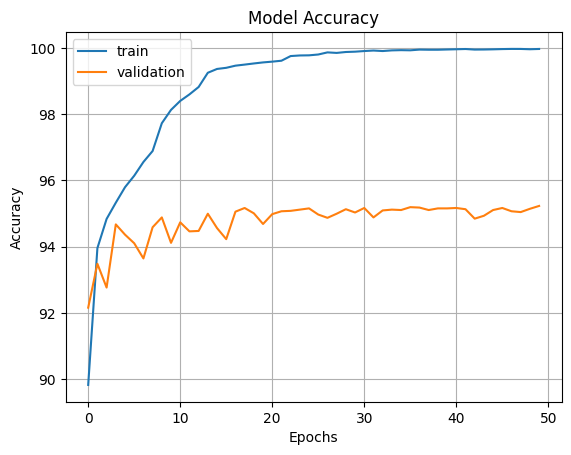

In [14]:
plt.plot(accs_train, label='Train_accuracy')
plt.plot(accs_val, label='Validation_accuracy')
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

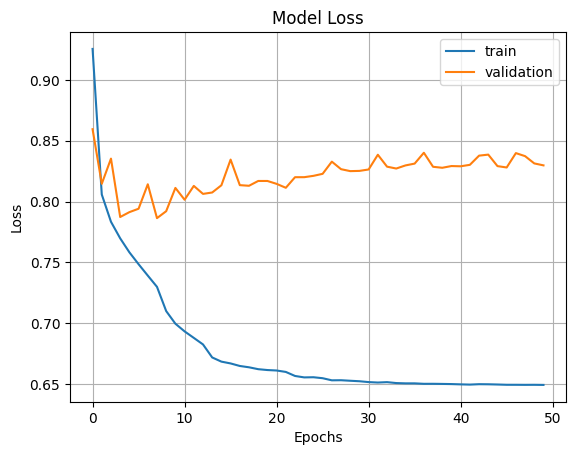

In [15]:
plt.plot(losses_train, label='Train_loss')
plt.plot(losses_val, label='Validation_loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [17]:
test = MyTestSet("./pretrained_100/test_pre.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [18]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./pretrained_100/checkpoint_model_pre.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [27]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

In [28]:
real_label = pd.read_csv("./pretrained_100/testy_pre.csv", index_col=0)
real_label.value_counts()

celltype_l2      
CD14 Mono            2132
CD4 Naive             874
NK                    859
CD4 TCM               745
CD8 TEM               587
CD8 Naive             539
B naive               385
CD16 Mono             315
CD4 TEM               214
gdT                   183
B memory              164
CD8 TCM               144
MAIT                  139
Treg                  125
cDC2                  123
B intermediate        121
Platelet              114
CD4 CTL                87
NK_CD56bright          47
pDC                    43
Doublet                29
NK Proliferating       27
dnT                    17
Plasmablast            16
HSPC                   16
ILC                     7
cDC1                    7
Eryth                   4
CD8 Proliferating       4
ASDC                    4
CD4 Proliferating       3
dtype: int64

In [29]:
file = open("./pretrained_100/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

CD14 Mono            2140
CD4 Naive             896
NK                    866
CD4 TCM               731
CD8 TEM               583
CD8 Naive             543
B naive               376
CD16 Mono             320
CD4 TEM               207
gdT                   175
B memory              164
CD8 TCM               144
MAIT                  143
B intermediate        130
cDC2                  127
Treg                  125
Platelet              111
CD4 CTL                87
NK_CD56bright          44
pDC                    43
NK Proliferating       30
Plasmablast            17
HSPC                   16
dnT                    13
Doublet                13
ILC                     8
cDC1                    7
Eryth                   5
CD8 Proliferating       4
ASDC                    4
CD4 Proliferating       2
dtype: int64

In [30]:
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype_l2"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype_l2"])
ari = adjusted_rand_score(real_label_2, pred_label_2)

print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.948, ARI = 0.938
